# Selecting patterns in cell-cell comm events according to invading trophoblast microenvironments (MEs) - updated as of Feb 2022

# And plotting them for relevant partners: immune (dNK and dM), endothealial and fibriblast cell states of mother and and invading trophoblast (VCT_CCC, EVT_1, EVT_2, EVT_3, eEVT, iEVT) of fetus

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import scanpy as sc
import scipy


In [2]:
%%bash

pip freeze

absl-py==0.12.0
aiohttp==3.7.4.post0
airr==1.3.1
alabaster==0.7.12
alembic @ file:///home/conda/feedstock_root/build_artifacts/alembic_1613901514078/work
anndata @ file:///home/conda/feedstock_root/build_artifacts/anndata_1605539061264/work
annoy @ file:///home/conda/feedstock_root/build_artifacts/python-annoy_1610271511811/work
anyio @ file:///home/conda/feedstock_root/build_artifacts/anyio_1614388751160/work/dist
arboreto==0.1.6
argon2-cffi @ file:///home/conda/feedstock_root/build_artifacts/argon2-cffi_1610522574055/work
async-generator==1.10
async-timeout==3.0.1
attrs @ file:///home/conda/feedstock_root/build_artifacts/attrs_1605083924122/work
Babel @ file:///home/conda/feedstock_root/build_artifacts/babel_1605182336601/work
backcall @ file:///home/conda/feedstock_root/build_artifacts/backcall_1592338393461/work
backports.functools-lru-cache==1.6.1
bbknn @ file:///opt/conda/conda-bld/bbknn_1616434096000/work
bleach @ file:///home/conda/feedstock_root/build_artifacts/bleach_16122134

In [3]:
save_path = '/lustre/scratch117/cellgen/team292/aa22/with_Luz/202111_MFI_CellPhone/result_tables_parsed/'


## Reading in table generated in notebook S2

In [4]:
# here I subsetted to all interactions where at least 1 partner is DE (using invading trophoblast DEGs along trajectory)

# results dated 20211202 (generated from out_20211124_threshold_0.1) are the ones I end up using, although that was a run wuth DEGs that were quite liberal in % of cells expressing a gene
# I tried to rerun cellphone with a more stringent list of DEGs (stuff dated 20211203) but didn't see a huge difference
# hence I still don't fully understand how --threshold 0.1 parameter is supposed to work in cellphone

cellphone_results_simple = pd.read_csv(save_path + '20211202_cellphone_interactions_MFI_table_with_stats_cutoffs_FDR_0.05_expressing_fraction_0.1_logFC_positive_simple_interactions.csv',
                               index_col=0)


cellphone_results_complex = pd.read_csv(save_path + '20211202_cellphone_interactions_MFI_table_with_stats_cutoffs_FDR_0.05_expressing_fraction_0.1_logFC_positive_complexes_deconv_into_pseduinteractions.csv',
                               index_col=0)



In [5]:
cellphone_results_simple

interaction partner_A_genes partner_B_genes    celltype_A celltype_B  \
431      CCL3_CCR1            CCL3            CCR1            GC      EVT_1   
439      CCL3_CCR1            CCL3            CCR1       dT_regs    VCT_CCC   
449      CCL3_CCR1            CCL3            CCR1         EVT_2     Plasma   
450      CCL3_CCR1            CCL3            CCR1  dEpi_lumenal    VCT_CCC   
454      CCL3_CCR1            CCL3            CCR1         EVT_2       uSMC   
...            ...             ...             ...           ...        ...   
196930   ESAM_ESAM            ESAM            ESAM       VCT_CCC     Plasma   
196934   ESAM_ESAM            ESAM            ESAM       VCT_CCC       uSMC   
196935   ESAM_ESAM            ESAM            ESAM       VCT_CCC    VCT_CCC   
196936   ESAM_ESAM            ESAM            ESAM         EVT_1      EVT_1   
196937   ESAM_ESAM            ESAM            ESAM          iEVT       iEVT   

        is_partner_A_DE  logFC_gene_A  adj_pval_gene_A  percent_expr_gene_A  \
431               False           NaN              NaN             0.000000   
439               False           NaN              NaN             0.169173   
449                True      0.011295     4.384222e-02             0.061493   
450               False           NaN              NaN             0.081481   
454                True      0.011295     4.384222e-02             0.061493   
...                 ...           ...              ...                  ...   
196930             True      0.014818     2.571815e-02             0.050993   
196934             True      0.014818     2.571815e-02             0.050993   
196935             True      0.014818     2.571815e-02             0.050993   
196936             True      0.052964     1.195136e-15             0.145396   
196937             True      0.242554     1.961001e-52             0.389010   

        is_partner_B_DE  logFC_gene_B  adj_pval_gene_B  percent_expr_gene_B  
431                True      0.264079    2.975272e-292             0.550009  
439                True      0.056090     2.377878e-36             0.110584  
449               False           NaN              NaN             0.023529  
450                True      0.056090     2.377878e-36             0.110584  
454               False           NaN              NaN             0.020536  
...                 ...           ...              ...                  ...  
196930            False           NaN              NaN             0.007843  
196934            False           NaN              NaN             0.058910  
196935             True      0.014818     2.571815e-02             0.050993  
196936             True      0.052964     1.195136e-15             0.145396  
196937             True      0.242554     1.961001e-52             0.389010  

[14475 rows x 13 columns]

In [6]:
# are there self within-troph interactions here?
cellphone_results_simple[(cellphone_results_simple['celltype_A'] == 'eEVT')
                        & (cellphone_results_simple['celltype_B'] == 'eEVT')]

interaction partner_A_genes partner_B_genes celltype_A celltype_B  \
4729     HLA-F_VSIR           HLA-F            VSIR       eEVT       eEVT   
8599      CCL3_CCR3            CCL3            CCR3       eEVT       eEVT   
9029      CCL5_CCR3            CCL5            CCR3       eEVT       eEVT   
9459    CCL3L1_CCR3          CCL3L1            CCR3       eEVT       eEVT   
29239      PVR_CD96             PVR            CD96       eEVT       eEVT   
...             ...             ...             ...        ...        ...   
192209    DSG2_DSC3            DSG2            DSC3       eEVT       eEVT   
192639    DSC2_DSG2            DSC2            DSG2       eEVT       eEVT   
195219   NTRK2_NTN4           NTRK2            NTN4       eEVT       eEVT   
195649   UNC5D_NTN4           UNC5D            NTN4       eEVT       eEVT   
196079   UNC5B_NTN4           UNC5B            NTN4       eEVT       eEVT   

        is_partner_A_DE  logFC_gene_A  adj_pval_gene_A  percent_expr_gene_A  \
4729               True      0.206298         0.000216             0.321429   
8599              False           NaN              NaN             0.071429   
9029              False           NaN              NaN             0.071429   
9459              False           NaN              NaN             0.000000   
29239             False           NaN              NaN             0.250000   
...                 ...           ...              ...                  ...   
192209             True      0.460888         0.003773             0.714286   
192639            False           NaN              NaN             0.607143   
195219            False           NaN              NaN             0.000000   
195649            False           NaN              NaN             0.142857   
196079            False           NaN              NaN             0.035714   

        is_partner_B_DE  logFC_gene_B  adj_pval_gene_B  percent_expr_gene_B  
4729              False           NaN              NaN             0.178571  
8599               True      0.137214     2.666668e-02             0.321429  
9029               True      0.137214     2.666668e-02             0.321429  
9459               True      0.137214     2.666668e-02             0.321429  
29239              True      0.127000     4.650283e-02             0.178571  
...                 ...           ...              ...                  ...  
192209            False           NaN              NaN             0.071429  
192639             True      0.460888     3.773459e-03             0.714286  
195219             True      0.685871     9.419136e-13             0.785714  
195649             True      0.685871     9.419136e-13             0.785714  
196079             True      0.685871     9.419136e-13             0.785714  

[86 rows x 13 columns]

In [7]:
# are there non-self troph-troph interactions here?
cellphone_results_simple[(cellphone_results_simple['celltype_A'] == 'EVT_2')
                        & (cellphone_results_simple['celltype_B'] == 'EVT_1')]

interaction partner_A_genes partner_B_genes celltype_A celltype_B  \
818       CCL3_CCR1            CCL3            CCR1      EVT_2      EVT_1   
1248      CCL5_CCR1            CCL5            CCR1      EVT_2      EVT_1   
1678    CCL3L1_CCR1          CCL3L1            CCR1      EVT_2      EVT_1   
4688     HLA-F_VSIR           HLA-F            VSIR      EVT_2      EVT_1   
5118     HLA-E_VSIR           HLA-E            VSIR      EVT_2      EVT_1   
...             ...             ...             ...        ...        ...   
193458   TEK_ANGPT4             TEK          ANGPT4      EVT_2      EVT_1   
195178   NTRK2_NTN4           NTRK2            NTN4      EVT_2      EVT_1   
195608   UNC5D_NTN4           UNC5D            NTN4      EVT_2      EVT_1   
196038   UNC5B_NTN4           UNC5B            NTN4      EVT_2      EVT_1   
196898    ESAM_ESAM            ESAM            ESAM      EVT_2      EVT_1   

        is_partner_A_DE  logFC_gene_A  adj_pval_gene_A  percent_expr_gene_A  \
818                True      0.011295     4.384222e-02             0.061493   
1248               True      0.008731     1.074548e-02             0.014843   
1678              False           NaN              NaN             0.010178   
4688              False           NaN              NaN             0.032231   
5118               True      0.057480     1.019018e-03             0.528414   
...                 ...           ...              ...                  ...   
193458            False           NaN              NaN             0.024173   
195178            False           NaN              NaN             0.005089   
195608            False           NaN              NaN             0.022053   
196038            False           NaN              NaN             0.005089   
196898             True      0.060010     1.017663e-09             0.161578   

        is_partner_B_DE  logFC_gene_B  adj_pval_gene_B  percent_expr_gene_B  
818                True      0.264079    2.975272e-292             0.550009  
1248               True      0.264079    2.975272e-292             0.550009  
1678               True      0.264079    2.975272e-292             0.550009  
4688               True      0.371655    7.506333e-220             0.745510  
5118               True      0.371655    7.506333e-220             0.745510  
...                 ...           ...              ...                  ...  
193458             True      0.295089    1.143858e-202             0.359992  
195178             True      0.031847     3.351895e-09             0.085460  
195608             True      0.031847     3.351895e-09             0.085460  
196038             True      0.031847     3.351895e-09             0.085460  
196898             True      0.052964     1.195136e-15             0.145396  

[166 rows x 13 columns]

In [8]:
cellphone_results_complex

interaction partner_A_genes partner_B_genes  \
1_member_1      LeukotrieneC4_byLTC4S_CYSLTR2         ALOX5AP         CYSLTR2   
1_member_2      LeukotrieneC4_byLTC4S_CYSLTR2           LTC4S         CYSLTR2   
1_member_3      LeukotrieneC4_byLTC4S_CYSLTR2           ALOX5         CYSLTR2   
10011_member_1                FZD1_LRP6_WNT7A            FZD1           WNT7A   
10011_member_2                FZD1_LRP6_WNT7A            LRP6           WNT7A   
...                                       ...             ...             ...   
9940_member_2                 FZD1_LRP6_WNT7A            LRP6           WNT7A   
9971_member_1                 FZD1_LRP6_WNT7A            FZD1           WNT7A   
9971_member_2                 FZD1_LRP6_WNT7A            LRP6           WNT7A   
9991_member_1                 FZD1_LRP6_WNT7A            FZD1           WNT7A   
9991_member_2                 FZD1_LRP6_WNT7A            LRP6           WNT7A   

                    celltype_A celltype_B  is_partner_A_DE  logFC_gene_A  \
1_member_1                  GC      EVT_1            False           NaN   
1_member_2                  GC      EVT_1            False           NaN   
1_member_3                  GC      EVT_1            False           NaN   
10011_member_1         B_cells      EVT_1            False           NaN   
10011_member_2         B_cells      EVT_1            False           NaN   
...                        ...        ...              ...           ...   
9940_member_2     dEpi_lumenal      EVT_1            False           NaN   
9971_member_1   dEpi_secretory      EVT_1            False           NaN   
9971_member_2   dEpi_secretory      EVT_1            False           NaN   
9991_member_1              dM1      EVT_1            False           NaN   
9991_member_2              dM1      EVT_1            False           NaN   

                adj_pval_gene_A  percent_expr_gene_A  is_partner_B_DE  \
1_member_1                  NaN             0.052632             True   
1_member_2                  NaN             0.000000             True   
1_member_3                  NaN             0.000000             True   
10011_member_1              NaN             0.005168             True   
10011_member_2              NaN             0.009044             True   
...                         ...                  ...              ...   
9940_member_2               NaN             0.177778             True   
9971_member_1               NaN             0.038315             True   
9971_member_2               NaN             0.177973             True   
9991_member_1               NaN             0.079580             True   
9991_member_2               NaN             0.015462             True   

                logFC_gene_B  adj_pval_gene_B  percent_expr_gene_B  
1_member_1          0.033083     1.486300e-17             0.053507  
1_member_2          0.033083     1.486300e-17             0.053507  
1_member_3          0.033083     1.486300e-17             0.053507  
10011_member_1      0.174282     1.101306e-63             0.607487  
10011_member_2      0.174282     1.101306e-63             0.607487  
...                      ...              ...                  ...  
9940_member_2       0.174282     1.101306e-63             0.607487  
9971_member_1       0.174282     1.101306e-63             0.607487  
9971_member_2       0.174282     1.101306e-63             0.607487  
9991_member_1       0.174282     1.101306e-63             0.607487  
9991_member_2       0.174282     1.101306e-63             0.607487  

[13330 rows x 13 columns]

# Here looking at communication between mother and fetus, sepcifically:

- cell types from maternal side: dNK1, dNK2, dNK3, dM1, dM2, dS3, dS2, dEndo (or Endo_M here), dS1 and uSMC
- cell types from fetal side: all invading trophoblast - VCT_CCC, EVT_1, EVT_2, eEVT, iEVT and GC

In [9]:
# filtering interactions for only relevant cell types

relevant_cell_types_mother = ['dNK1','dNK2','dNK3','dM1','dM2','dS3','dS2','Endo_M','dS1','uSMC']
relevant_cell_types_fetus = ['VCT_CCC','EVT_1','EVT_2','eEVT','iEVT','GC']

# subset to only interactions between relevant_cell_types_mother and relevant_cell_types_fetus
cellphone_results_simple = cellphone_results_simple[((cellphone_results_simple['celltype_A'].isin(relevant_cell_types_mother + relevant_cell_types_fetus)) & (cellphone_results_simple['celltype_B'].isin(relevant_cell_types_fetus)))
                 | ((cellphone_results_simple['celltype_B'].isin(relevant_cell_types_mother + relevant_cell_types_fetus)) & (cellphone_results_simple['celltype_A'].isin(relevant_cell_types_fetus)))]
cellphone_results_complex = cellphone_results_complex[((cellphone_results_complex['celltype_A'].isin(relevant_cell_types_mother + relevant_cell_types_fetus)) & (cellphone_results_complex['celltype_B'].isin(relevant_cell_types_fetus)))
                 | ((cellphone_results_complex['celltype_B'].isin(relevant_cell_types_mother + relevant_cell_types_fetus)) & (cellphone_results_complex['celltype_A'].isin(relevant_cell_types_fetus)))]



In [10]:
cellphone_results_simple

interaction partner_A_genes partner_B_genes celltype_A celltype_B  \
431      CCL3_CCR1            CCL3            CCR1         GC      EVT_1   
454      CCL3_CCR1            CCL3            CCR1      EVT_2       uSMC   
498      CCL3_CCR1            CCL3            CCR1       dNK3    VCT_CCC   
500      CCL3_CCR1            CCL3            CCR1      EVT_2        dS1   
531      CCL3_CCR1            CCL3            CCR1        dM1      EVT_1   
...            ...             ...             ...        ...        ...   
196916   ESAM_ESAM            ESAM            ESAM      EVT_2         GC   
196934   ESAM_ESAM            ESAM            ESAM    VCT_CCC       uSMC   
196935   ESAM_ESAM            ESAM            ESAM    VCT_CCC    VCT_CCC   
196936   ESAM_ESAM            ESAM            ESAM      EVT_1      EVT_1   
196937   ESAM_ESAM            ESAM            ESAM       iEVT       iEVT   

        is_partner_A_DE  logFC_gene_A  adj_pval_gene_A  percent_expr_gene_A  \
431               False           NaN              NaN             0.000000   
454                True      0.011295     4.384222e-02             0.061493   
498               False           NaN              NaN             0.678184   
500                True      0.011295     4.384222e-02             0.061493   
531               False           NaN              NaN             0.695085   
...                 ...           ...              ...                  ...   
196916             True      0.060010     1.017663e-09             0.161578   
196934             True      0.014818     2.571815e-02             0.050993   
196935             True      0.014818     2.571815e-02             0.050993   
196936             True      0.052964     1.195136e-15             0.145396   
196937             True      0.242554     1.961001e-52             0.389010   

        is_partner_B_DE  logFC_gene_B  adj_pval_gene_B  percent_expr_gene_B  
431                True      0.264079    2.975272e-292             0.550009  
454               False           NaN              NaN             0.020536  
498                True      0.056090     2.377878e-36             0.110584  
500               False           NaN              NaN             0.019349  
531                True      0.264079    2.975272e-292             0.550009  
...                 ...           ...              ...                  ...  
196916            False           NaN              NaN             0.210526  
196934            False           NaN              NaN             0.058910  
196935             True      0.014818     2.571815e-02             0.050993  
196936             True      0.052964     1.195136e-15             0.145396  
196937             True      0.242554     1.961001e-52             0.389010  

[7459 rows x 13 columns]

In [11]:
np.unique(cellphone_results_simple[cellphone_results_simple['celltype_A'] == 'eEVT']['celltype_B'])

array(['EVT_1', 'EVT_2', 'Endo_M', 'GC', 'VCT_CCC', 'dM1', 'dM2', 'dNK1',
       'dNK2', 'dNK3', 'dS1', 'dS2', 'dS3', 'eEVT', 'iEVT', 'uSMC'],
      dtype=object)

In [12]:
cellphone_results_complex[(cellphone_results_complex['partner_A_genes'] == 'CSF2') 
                        | (cellphone_results_complex['partner_B_genes'] == 'CSF2')]

Empty DataFrame
Columns: [interaction, partner_A_genes, partner_B_genes, celltype_A, celltype_B, is_partner_A_DE, logFC_gene_A, adj_pval_gene_A, percent_expr_gene_A, is_partner_B_DE, logFC_gene_B, adj_pval_gene_B, percent_expr_gene_B]
Index: []

In [13]:
np.unique(cellphone_results_complex[(cellphone_results_complex['celltype_A'] == 'iEVT')
                         | (cellphone_results_complex['celltype_B'] == 'iEVT')]['partner_A_genes'])

array(['ACVR1', 'ACVR1B', 'ACVR2A', 'ACVR2B', 'ADM2', 'APOE', 'APP',
       'BMPR1B', 'BMPR2', 'CD47', 'CDH1', 'CLU', 'COL11A1', 'COL15A1',
       'COL17A1', 'COL19A1', 'COL1A1', 'COL1A2', 'COL21A1', 'COL26A1',
       'COL27A1', 'COL3A1', 'COL4A1', 'COL4A2', 'COL5A1', 'COL5A2',
       'COL6A1', 'COL6A2', 'COL9A3', 'F11R', 'FBN1', 'FLT1', 'FN1',
       'FZD2', 'FZD3', 'FZD4', 'FZD5', 'FZD6', 'FZD7', 'GDF11', 'ICAM3',
       'IL2RG', 'IL7R', 'JAM2', 'JAM3', 'KDR', 'KLRC1', 'KLRC2', 'KLRD1',
       'LAMC1', 'LRP4', 'LRP5', 'LRP6', 'MUSK', 'PDGFB', 'PLAUR',
       'PLXNA1', 'SEMA7A', 'SPP1', 'TGFB1', 'TGFB2', 'TREM2', 'TYROBP'],
      dtype=object)

In [14]:
cellphone_results_complex

interaction partner_A_genes partner_B_genes  \
1_member_1      LeukotrieneC4_byLTC4S_CYSLTR2         ALOX5AP         CYSLTR2   
1_member_2      LeukotrieneC4_byLTC4S_CYSLTR2           LTC4S         CYSLTR2   
1_member_3      LeukotrieneC4_byLTC4S_CYSLTR2           ALOX5         CYSLTR2   
10042_member_1                FZD1_LRP6_WNT7A            FZD1           WNT7A   
10042_member_2                FZD1_LRP6_WNT7A            LRP6           WNT7A   
...                                       ...             ...             ...   
98898_member_2     F11R_integrin_aLb2_complex            F11R           ITGAL   
9891_member_1                 FZD1_LRP6_WNT7A            FZD1           WNT7A   
9891_member_2                 FZD1_LRP6_WNT7A            LRP6           WNT7A   
9991_member_1                 FZD1_LRP6_WNT7A            FZD1           WNT7A   
9991_member_2                 FZD1_LRP6_WNT7A            LRP6           WNT7A   

               celltype_A celltype_B  is_partner_A_DE  logFC_gene_A  \
1_member_1             GC      EVT_1            False           NaN   
1_member_2             GC      EVT_1            False           NaN   
1_member_3             GC      EVT_1            False           NaN   
10042_member_1       eEVT      EVT_1            False           NaN   
10042_member_2       eEVT      EVT_1            False           NaN   
...                   ...        ...              ...           ...   
98898_member_2         GC         GC             True      0.502664   
9891_member_1          GC      EVT_1            False           NaN   
9891_member_2          GC      EVT_1            False           NaN   
9991_member_1         dM1      EVT_1            False           NaN   
9991_member_2         dM1      EVT_1            False           NaN   

                adj_pval_gene_A  percent_expr_gene_A  is_partner_B_DE  \
1_member_1                  NaN             0.052632             True   
1_member_2                  NaN             0.000000             True   
1_member_3                  NaN             0.000000             True   
10042_member_1              NaN             0.000000             True   
10042_member_2              NaN             0.142857             True   
...                         ...                  ...              ...   
98898_member_2         0.026934             0.684211            False   
9891_member_1               NaN             0.052632             True   
9891_member_2               NaN             0.000000             True   
9991_member_1               NaN             0.079580             True   
9991_member_2               NaN             0.015462             True   

                logFC_gene_B  adj_pval_gene_B  percent_expr_gene_B  
1_member_1          0.033083     1.486300e-17             0.053507  
1_member_2          0.033083     1.486300e-17             0.053507  
1_member_3          0.033083     1.486300e-17             0.053507  
10042_member_1      0.174282     1.101306e-63             0.607487  
10042_member_2      0.174282     1.101306e-63             0.607487  
...                      ...              ...                  ...  
98898_member_2           NaN              NaN             0.052632  
9891_member_1       0.174282     1.101306e-63             0.607487  
9891_member_2       0.174282     1.101306e-63             0.607487  
9991_member_1       0.174282     1.101306e-63             0.607487  
9991_member_2       0.174282     1.101306e-63             0.607487  

[6869 rows x 13 columns]

In [15]:
# how many simple interactions?
len(np.unique(cellphone_results_simple['interaction']))

306

In [16]:
# how many complex interactions?
len(np.unique(cellphone_results_complex['interaction']))

152

In [17]:
# how many interactions in total?
len(np.unique(cellphone_results_simple['interaction'])) + len(np.unique(cellphone_results_complex['interaction']))

458

In [18]:
# filtering for statistical significance was already done when supplying DEGs to cellphone, so here let's only reflect expression level and fraction of cells expr this L/R

In [19]:
# creating separate tables for molecules (L/R) from maternal side and from fetal (R/L) for all 455 interactions here
# we'll need tables for expression levels and tables for percentage of cells expressing a molecule

# redoing this without scaling - will just take a z-score later

In [20]:
# retrieving expression from the object wtih final annotation
# raw count values in .X
adata = sc.read('/lustre/scratch117/cellgen/team292/aa22/adata_objects/202111_MFI_sc_sn_new_scVI_analysis/adata_raw_filtered.h5ad')

In [21]:
# read in final annotations
final_annot = pd.read_csv('/lustre/scratch117/cellgen/team292/aa22/adata_objects/202111_MFI_sc_sn_new_scVI_analysis/final_annotation_all_cells_and_nulcei_20211123.csv', index_col=0)
# subset adata to only final cells + nuclei
adata = adata[final_annot.index,:]
# add annotation labels
adata.obs['cell_type'] = final_annot.loc[adata.obs_names,'cell_type']
adata

/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
Trying to set attribute `.obs` of view, copying.


AnnData object with n_obs × n_vars = 350815 × 30800
    obs: 'n_genes', 'sample', 'technology', 'tissue', 'dev_age', 'donor', 'dataset', 'run', 'number_of_individuals_multiplexed', 'batch', 'percent_mito', 'n_counts', 'scrublet_score', 'scrublet_cluster_score', 'bh_pval', 'is_doublet', 'cell_type'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1', 'gene_ids-10', 'feature_types-10', 'genome-10', 'n_cells-10', 'gene_ids-11', 'feature_types-11', 'genome-11', 'n_cells-11', 'gene_ids-12', 'feature_types-12', 'genome-12', 'n_cells-12', 'gene_ids-13', 'feature_types-13', 'genome-13', 'n_cells-13', 'gene_ids-14', 'feature_types-14', 'genome-14', 'n_cells-14', 'gene_ids-15', 'feature_types-15', 'genome-15', 'n_cells-15', 'gene_ids-16', 'feature_types-16', 'genome-16', 'n_cells-16', 'gene_ids-17', 'feature_types-17', 'genome-17', 'n_cells-17', 'gene_ids-18', 'feature_types-18', 'genome-18', 'n_cells-18', 'gene_ids-19', 'fe

In [ ]:
# save raw values in .raw
#adata.raw = adata.copy()

# normalise, log transform and scale expression values
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)
#sc.pp.scale(adata, max_value=10) # NOT DOING SCALING ANY MORE!

In [ ]:
# get a subset of all the L/R genes we will need here - to decrease the size of tables in memory
all_LR_genes = list(set(list(cellphone_results_simple['partner_A_genes']) + list(cellphone_results_simple['partner_B_genes']) 
                   + list(cellphone_results_complex['partner_A_genes']) + list(cellphone_results_complex['partner_B_genes'])))

len(all_LR_genes)

In [ ]:
df_expr = pd.DataFrame(adata.X,
                      columns = adata.var_names,
                      index = adata.obs_names)

In [ ]:
%%time

# create a table with scaled expression values for all cell types (did this for TF plots as well)
df_expr_avg = pd.DataFrame(index = relevant_cell_types_mother + relevant_cell_types_fetus,
                             columns= all_LR_genes)

# fill it with scaled expression values

for cell_type in df_expr_scaled.index:
    print(cell_type)
    for gene in df_expr_scaled.columns:
        curr_obs_names = list(adata[adata.obs['cell_type'] == cell_type].obs_names)
        #print('curr_adata shape', curr_adata.X.shape)
        df_expr_avg.loc[cell_type, gene] = np.mean(df_expr.loc[curr_obs_names, gene])


In [ ]:
df_expr_avg

In [ ]:
# save to read in in the future
#df_expr_scaled.to_csv('./20211202_df_expr_scaled_for_cellphone_plotting_relevant_cell_types_and_LR.csv') # for older results: 20211128_df_expr_scaled_for_cellphone_plotting_relevant_cell_types_and_LR

df_expr_avg.to_csv('./20220209_df_expr_avg_normlog_for_cellphone_plotting_relevant_cell_types_and_LR.csv')

In [20]:
df_expr_scaled = pd.read_csv('./20211202_df_expr_scaled_for_cellphone_plotting_relevant_cell_types_and_LR.csv',
                            index_col=0)
df_expr_scaled.shape

(16, 414)

In [21]:
# get a subset of all the L/R genes we will need here - to decrease the size of tables in memory
all_LR_genes = list(set(list(cellphone_results_simple['partner_A_genes']) + list(cellphone_results_simple['partner_B_genes']) 
                   + list(cellphone_results_complex['partner_A_genes']) + list(cellphone_results_complex['partner_B_genes'])))

len(all_LR_genes)

414

In [22]:
# also loading in table with information about percentage of cluster expressing a certain gene
# Load percentage expression info
# Matrix of genes (rows) per celltypes (columns) containing the proportion [0-1] of cells 
# in a celltype expressing the gene
path_Exp = '/lustre/scratch117/cellgen/team292/aa22/with_Luz/202111_MFI_CellPhone/20211123_PercentExpressed_for_cellphone.csv'

per_cutoff = 0.1

# Load matrix
Per_df = pd.read_csv(path_Exp, index_col=0) 

# Dictionary of celltypes2expressed genes
genes_expr_per_cell_type = {} 

# further below we will have dS2/3 as dS2-3, so let's change the name here as well to avoid losing data
#Per_df.columns = ['DC1', 'EVT_1', 'EVT_2', 'EVT_3', 'Endo_F', 'Endo_L', 'Endo_M', 'GC',
#       'HOFB', 'SCT', 'VCT', 'VCT_CCC', 'VCT_fusing', 'VCT_p', 'dEpi_lumen',
#       'dEpi_secretory', 'dM2', 'dNK1', 'dNK3', 'dPV', 'dS1', 'dS2-3', 'eEVT',
#       'fF', 'fPV', 'iEVT', 'uSMC']

for ct in Per_df.columns:
    print(ct)
    curr_table = pd.DataFrame(Per_df.loc[:, ct])
    
    # only leave in genes expressed in this cell type according to a threshold declared in the beginnning of this notebook
    mask = (curr_table[ct] > per_cutoff)
    genes_expr_per_cell_type[ct] = list(curr_table[ct][mask].index)

B_cells
DC
EVT_1
EVT_2
Endo_F
Endo_L
Endo_M
GC
Granulocytes
HOFB
ILC3
M3
MO
NK
PV
Plasma
SCT
T_cells
VCT
VCT_CCC
VCT_fusing
VCT_p
dDC
dEpi_lumenal
dEpi_secretory
dM1
dM2
dNK1
dNK2
dNK3
dS1
dS2
dS3
dT_cells
dT_regs
eEVT
fF1
fF2
iEVT
uSMC


In [23]:
Per_df.columns

Index(['B_cells', 'DC', 'EVT_1', 'EVT_2', 'Endo_F', 'Endo_L', 'Endo_M', 'GC',
       'Granulocytes', 'HOFB', 'ILC3', 'M3', 'MO', 'NK', 'PV', 'Plasma', 'SCT',
       'T_cells', 'VCT', 'VCT_CCC', 'VCT_fusing', 'VCT_p', 'dDC',
       'dEpi_lumenal', 'dEpi_secretory', 'dM1', 'dM2', 'dNK1', 'dNK2', 'dNK3',
       'dS1', 'dS2', 'dS3', 'dT_cells', 'dT_regs', 'eEVT', 'fF1', 'fF2',
       'iEVT', 'uSMC'],
      dtype='object')

In [24]:
Per_df = Per_df.loc[df_expr_scaled.columns, df_expr_scaled.index].T
Per_df

PRL    LILRA4      NTF3      FZD6      CHAT     NCAM1    COL5A1  \
dNK1     0.027273  0.000287  0.002488  0.019904  0.000574  0.712823  0.033014   
dNK2     0.024025  0.000480  0.002483  0.017218  0.000160  0.637303  0.023464   
dNK3     0.025068  0.000000  0.001016  0.014566  0.000000  0.417683  0.024051   
dM1      0.033761  0.011561  0.001844  0.011774  0.000142  0.057238  0.045961   
dM2      0.032209  0.002169  0.001627  0.016918  0.000759  0.090663  0.095326   
dS3      0.811927  0.000152  0.001819  0.019777  0.000152  0.016974  0.752898   
dS2      0.359855  0.000046  0.007864  0.040428  0.000624  0.067959  0.609330   
Endo_M   0.126363  0.000291  0.005380  0.295769  0.000436  0.123891  0.273084   
dS1      0.075987  0.000235  0.004250  0.032147  0.000751  0.252125  0.491218   
uSMC     0.017661  0.000352  0.006454  0.077803  0.001467  0.547028  0.690899   
VCT_CCC  0.008005  0.000000  0.001482  0.203380  0.001779  0.048028  0.092796   
EVT_1    0.008508  0.000189  0.001134  0.110418  0.000378  0.031386  0.149367   
EVT_2    0.025445  0.000000  0.001272  0.074640  0.000848  0.066582  0.204835   
eEVT     0.000000  0.000000  0.000000  0.107143  0.000000  1.000000  0.250000   
iEVT     0.042165  0.000000  0.002448  0.126496  0.002720  0.086779  0.335419   
GC       0.000000  0.000000  0.000000  0.000000  0.000000  0.052632  0.210526   

           IFNGR1      BST2      LIFR  ...     ACKR3   TMEM219   RARRES2  \
dNK1     0.078086  0.468230  0.081914  ...  0.004211  0.275502  0.010718   
dNK2     0.066309  0.523905  0.048691  ...  0.002883  0.241211  0.006887   
dNK3     0.112127  0.561992  0.035908  ...  0.005420  0.212060  0.006436   
dM1      0.463224  0.574509  0.095397  ...  0.023690  0.434924  0.019647   
dM2      0.278278  0.371435  0.186639  ...  0.015183  0.216462  0.032643   
dS3      0.538531  0.086535  0.180420  ...  0.037963  0.778131  0.116921   
dS2      0.313494  0.091412  0.189928  ...  0.062407  0.369026  0.240136   
Endo_M   0.298386  0.548495  0.539479  ...  0.305511  0.370365  0.114585   
dS1      0.290729  0.144789  0.253933  ...  0.043348  0.354201  0.486944   
uSMC     0.157015  0.068826  0.559585  ...  0.069589  0.109253  0.166872   
VCT_CCC  0.416247  0.166617  0.368811  ...  0.013341  0.491847  0.033501   
EVT_1    0.579883  0.324636  0.497826  ...  0.014937  0.751749  0.024957   
EVT_2    0.287956  0.216709  0.632740  ...  0.017812  0.377863  0.020356   
eEVT     0.428571  0.142857  0.964286  ...  0.571429  0.142857  0.000000   
iEVT     0.390370  0.338683  0.782644  ...  0.031284  0.395539  0.032644   
GC       0.315789  0.315789  0.947368  ...  0.000000  0.105263  0.000000   

           TGFBR2    CCL3L1      RBP4    PLXNA3      NRP2      LRP4     ITGA8  
dNK1     0.085837  0.133684  0.043158  0.028995  0.023541  0.028995  0.002201  
dNK2     0.088812  0.098262  0.040842  0.020982  0.020101  0.020822  0.002162  
dNK3     0.196477  0.218835  0.036247  0.027439  0.015921  0.014566  0.001016  
dM1      0.353358  0.422867  0.038797  0.064544  0.373927  0.029151  0.003546  
dM2      0.340202  0.289556  0.032426  0.057152  0.359180  0.034270  0.008351  
dS3      0.386300  0.032659  0.212018  0.198303  0.023339  0.089111  0.003940  
dS2      0.310270  0.028747  0.123217  0.118273  0.067761  0.044459  0.013172  
Endo_M   0.719936  0.015268  0.043187  0.053803  0.259561  0.052494  0.088847  
dS1      0.356385  0.015263  0.050533  0.078406  0.170713  0.047058  0.036444  
uSMC     0.431379  0.002934  0.015725  0.074459  0.490583  0.095171  0.126034  
VCT_CCC  0.126001  0.020457  0.031426  0.116513  0.277201  0.054551  0.001186  
EVT_1    0.194366  0.027226  0.236718  0.125922  0.038760  0.051427  0.002836  
EVT_2    0.301103  0.010178  0.078456  0.176845  0.040288  0.068278  0.004241  
eEVT     0.285714  0.000000  0.035714  0.321429  0.071429  0.392857  0.000000  
iEVT     0.644450  0.012786  0.038085  0.221164  0.047606  0.125136  0.009793  
GC       0.631579  0.000000  0.000000  0.000000  0.052632  0.15

In [25]:
# OPTIONAL
# also to not overcrowd the dotplot, wherever % of cells in cluster expressing a gene is lower than 0.1 threshold, assign 0
#Per_df = Per_df[Per_df > 0.1].fillna(0)

In [26]:
Per_df

PRL    LILRA4      NTF3      FZD6      CHAT     NCAM1    COL5A1  \
dNK1     0.027273  0.000287  0.002488  0.019904  0.000574  0.712823  0.033014   
dNK2     0.024025  0.000480  0.002483  0.017218  0.000160  0.637303  0.023464   
dNK3     0.025068  0.000000  0.001016  0.014566  0.000000  0.417683  0.024051   
dM1      0.033761  0.011561  0.001844  0.011774  0.000142  0.057238  0.045961   
dM2      0.032209  0.002169  0.001627  0.016918  0.000759  0.090663  0.095326   
dS3      0.811927  0.000152  0.001819  0.019777  0.000152  0.016974  0.752898   
dS2      0.359855  0.000046  0.007864  0.040428  0.000624  0.067959  0.609330   
Endo_M   0.126363  0.000291  0.005380  0.295769  0.000436  0.123891  0.273084   
dS1      0.075987  0.000235  0.004250  0.032147  0.000751  0.252125  0.491218   
uSMC     0.017661  0.000352  0.006454  0.077803  0.001467  0.547028  0.690899   
VCT_CCC  0.008005  0.000000  0.001482  0.203380  0.001779  0.048028  0.092796   
EVT_1    0.008508  0.000189  0.001134  0.110418  0.000378  0.031386  0.149367   
EVT_2    0.025445  0.000000  0.001272  0.074640  0.000848  0.066582  0.204835   
eEVT     0.000000  0.000000  0.000000  0.107143  0.000000  1.000000  0.250000   
iEVT     0.042165  0.000000  0.002448  0.126496  0.002720  0.086779  0.335419   
GC       0.000000  0.000000  0.000000  0.000000  0.000000  0.052632  0.210526   

           IFNGR1      BST2      LIFR  ...     ACKR3   TMEM219   RARRES2  \
dNK1     0.078086  0.468230  0.081914  ...  0.004211  0.275502  0.010718   
dNK2     0.066309  0.523905  0.048691  ...  0.002883  0.241211  0.006887   
dNK3     0.112127  0.561992  0.035908  ...  0.005420  0.212060  0.006436   
dM1      0.463224  0.574509  0.095397  ...  0.023690  0.434924  0.019647   
dM2      0.278278  0.371435  0.186639  ...  0.015183  0.216462  0.032643   
dS3      0.538531  0.086535  0.180420  ...  0.037963  0.778131  0.116921   
dS2      0.313494  0.091412  0.189928  ...  0.062407  0.369026  0.240136   
Endo_M   0.298386  0.548495  0.539479  ...  0.305511  0.370365  0.114585   
dS1      0.290729  0.144789  0.253933  ...  0.043348  0.354201  0.486944   
uSMC     0.157015  0.068826  0.559585  ...  0.069589  0.109253  0.166872   
VCT_CCC  0.416247  0.166617  0.368811  ...  0.013341  0.491847  0.033501   
EVT_1    0.579883  0.324636  0.497826  ...  0.014937  0.751749  0.024957   
EVT_2    0.287956  0.216709  0.632740  ...  0.017812  0.377863  0.020356   
eEVT     0.428571  0.142857  0.964286  ...  0.571429  0.142857  0.000000   
iEVT     0.390370  0.338683  0.782644  ...  0.031284  0.395539  0.032644   
GC       0.315789  0.315789  0.947368  ...  0.000000  0.105263  0.000000   

           TGFBR2    CCL3L1      RBP4    PLXNA3      NRP2      LRP4     ITGA8  
dNK1     0.085837  0.133684  0.043158  0.028995  0.023541  0.028995  0.002201  
dNK2     0.088812  0.098262  0.040842  0.020982  0.020101  0.020822  0.002162  
dNK3     0.196477  0.218835  0.036247  0.027439  0.015921  0.014566  0.001016  
dM1      0.353358  0.422867  0.038797  0.064544  0.373927  0.029151  0.003546  
dM2      0.340202  0.289556  0.032426  0.057152  0.359180  0.034270  0.008351  
dS3      0.386300  0.032659  0.212018  0.198303  0.023339  0.089111  0.003940  
dS2      0.310270  0.028747  0.123217  0.118273  0.067761  0.044459  0.013172  
Endo_M   0.719936  0.015268  0.043187  0.053803  0.259561  0.052494  0.088847  
dS1      0.356385  0.015263  0.050533  0.078406  0.170713  0.047058  0.036444  
uSMC     0.431379  0.002934  0.015725  0.074459  0.490583  0.095171  0.126034  
VCT_CCC  0.126001  0.020457  0.031426  0.116513  0.277201  0.054551  0.001186  
EVT_1    0.194366  0.027226  0.236718  0.125922  0.038760  0.051427  0.002836  
EVT_2    0.301103  0.010178  0.078456  0.176845  0.040288  0.068278  0.004241  
eEVT     0.285714  0.000000  0.035714  0.321429  0.071429  0.392857  0.000000  
iEVT     0.644450  0.012786  0.038085  0.221164  0.047606  0.125136  0.009793  
GC       0.631579  0.000000  0.000000  0.000000  0.052632  0.15

In [27]:
# starting with simple interactions
cellphone_results_simple

interaction partner_A_genes partner_B_genes celltype_A celltype_B  \
431      CCL3_CCR1            CCL3            CCR1         GC      EVT_1   
454      CCL3_CCR1            CCL3            CCR1      EVT_2       uSMC   
498      CCL3_CCR1            CCL3            CCR1       dNK3    VCT_CCC   
500      CCL3_CCR1            CCL3            CCR1      EVT_2        dS1   
531      CCL3_CCR1            CCL3            CCR1        dM1      EVT_1   
...            ...             ...             ...        ...        ...   
196916   ESAM_ESAM            ESAM            ESAM      EVT_2         GC   
196934   ESAM_ESAM            ESAM            ESAM    VCT_CCC       uSMC   
196935   ESAM_ESAM            ESAM            ESAM    VCT_CCC    VCT_CCC   
196936   ESAM_ESAM            ESAM            ESAM      EVT_1      EVT_1   
196937   ESAM_ESAM            ESAM            ESAM       iEVT       iEVT   

        is_partner_A_DE  logFC_gene_A  adj_pval_gene_A  percent_expr_gene_A  \
431               False           NaN              NaN             0.000000   
454                True      0.011295     4.384222e-02             0.061493   
498               False           NaN              NaN             0.678184   
500                True      0.011295     4.384222e-02             0.061493   
531               False           NaN              NaN             0.695085   
...                 ...           ...              ...                  ...   
196916             True      0.060010     1.017663e-09             0.161578   
196934             True      0.014818     2.571815e-02             0.050993   
196935             True      0.014818     2.571815e-02             0.050993   
196936             True      0.052964     1.195136e-15             0.145396   
196937             True      0.242554     1.961001e-52             0.389010   

        is_partner_B_DE  logFC_gene_B  adj_pval_gene_B  percent_expr_gene_B  
431                True      0.264079    2.975272e-292             0.550009  
454               False           NaN              NaN             0.020536  
498                True      0.056090     2.377878e-36             0.110584  
500               False           NaN              NaN             0.019349  
531                True      0.264079    2.975272e-292             0.550009  
...                 ...           ...              ...                  ...  
196916            False           NaN              NaN             0.210526  
196934            False           NaN              NaN             0.058910  
196935             True      0.014818     2.571815e-02             0.050993  
196936             True      0.052964     1.195136e-15             0.145396  
196937             True      0.242554     1.961001e-52             0.389010  

[7459 rows x 13 columns]

In [28]:
simple_interactions = list(np.unique(cellphone_results_simple['interaction']))
len(simple_interactions)

306

In [29]:
cellphone_results_simple

interaction partner_A_genes partner_B_genes celltype_A celltype_B  \
431      CCL3_CCR1            CCL3            CCR1         GC      EVT_1   
454      CCL3_CCR1            CCL3            CCR1      EVT_2       uSMC   
498      CCL3_CCR1            CCL3            CCR1       dNK3    VCT_CCC   
500      CCL3_CCR1            CCL3            CCR1      EVT_2        dS1   
531      CCL3_CCR1            CCL3            CCR1        dM1      EVT_1   
...            ...             ...             ...        ...        ...   
196916   ESAM_ESAM            ESAM            ESAM      EVT_2         GC   
196934   ESAM_ESAM            ESAM            ESAM    VCT_CCC       uSMC   
196935   ESAM_ESAM            ESAM            ESAM    VCT_CCC    VCT_CCC   
196936   ESAM_ESAM            ESAM            ESAM      EVT_1      EVT_1   
196937   ESAM_ESAM            ESAM            ESAM       iEVT       iEVT   

        is_partner_A_DE  logFC_gene_A  adj_pval_gene_A  percent_expr_gene_A  \
431               False           NaN              NaN             0.000000   
454                True      0.011295     4.384222e-02             0.061493   
498               False           NaN              NaN             0.678184   
500                True      0.011295     4.384222e-02             0.061493   
531               False           NaN              NaN             0.695085   
...                 ...           ...              ...                  ...   
196916             True      0.060010     1.017663e-09             0.161578   
196934             True      0.014818     2.571815e-02             0.050993   
196935             True      0.014818     2.571815e-02             0.050993   
196936             True      0.052964     1.195136e-15             0.145396   
196937             True      0.242554     1.961001e-52             0.389010   

        is_partner_B_DE  logFC_gene_B  adj_pval_gene_B  percent_expr_gene_B  
431                True      0.264079    2.975272e-292             0.550009  
454               False           NaN              NaN             0.020536  
498                True      0.056090     2.377878e-36             0.110584  
500               False           NaN              NaN             0.019349  
531                True      0.264079    2.975272e-292             0.550009  
...                 ...           ...              ...                  ...  
196916            False           NaN              NaN             0.210526  
196934            False           NaN              NaN             0.058910  
196935             True      0.014818     2.571815e-02             0.050993  
196936             True      0.052964     1.195136e-15             0.145396  
196937             True      0.242554     1.961001e-52             0.389010  

[7459 rows x 13 columns]

In [30]:
complex_interactions = list(np.unique(cellphone_results_complex['interaction']))
len(complex_interactions)

152

In [31]:
# dfs for plotting with scaled expression values (dot color)
dfs_for_plotting_expression = {}

# separate for simple and complex interactions
dfs_for_plotting_expression['simple'] = {}

# separate for mother and fetus
dfs_for_plotting_expression['simple']['fetus'] = pd.DataFrame(index = relevant_cell_types_fetus, columns = all_LR_genes)
dfs_for_plotting_expression['simple']['mother'] = pd.DataFrame(index = relevant_cell_types_mother, columns = all_LR_genes)


In [32]:
dfs_for_plotting_expression['simple']['fetus']

CXCR4 NTRK3 PRLR APLP2 CD33 CCL2 SELL FBN1 ALOX5AP EPHA4  ... EGFR  \
VCT_CCC   NaN   NaN  NaN   NaN  NaN  NaN  NaN  NaN     NaN   NaN  ...  NaN   
EVT_1     NaN   NaN  NaN   NaN  NaN  NaN  NaN  NaN     NaN   NaN  ...  NaN   
EVT_2     NaN   NaN  NaN   NaN  NaN  NaN  NaN  NaN     NaN   NaN  ...  NaN   
eEVT      NaN   NaN  NaN   NaN  NaN  NaN  NaN  NaN     NaN   NaN  ...  NaN   
iEVT      NaN   NaN  NaN   NaN  NaN  NaN  NaN  NaN     NaN   NaN  ...  NaN   
GC        NaN   NaN  NaN   NaN  NaN  NaN  NaN  NaN     NaN   NaN  ...  NaN   

        LILRA4 ABCA1 MUSK WNT5B COL6A2 CD93  LTA PDCD1LG2 KLRC2  
VCT_CCC    NaN   NaN  NaN   NaN    NaN  NaN  NaN      NaN   NaN  
EVT_1      NaN   NaN  NaN   NaN    NaN  NaN  NaN      NaN   NaN  
EVT_2      NaN   NaN  NaN   NaN    NaN  NaN  NaN      NaN   NaN  
eEVT       NaN   NaN  NaN   NaN    NaN  NaN  NaN      NaN   NaN  
iEVT       NaN   NaN  NaN   NaN    NaN  NaN  NaN      NaN   NaN  
GC         NaN   NaN  NaN   NaN    NaN  NaN  NaN      NaN   NaN  

[6 rows x 414 columns]

In [33]:
cellphone_results_simple[(cellphone_results_simple['celltype_A'] == 'VCT_CCC') 
                        & (cellphone_results_simple['celltype_B'] == 'VCT_CCC')]

interaction partner_A_genes partner_B_genes celltype_A celltype_B  \
855         CCL3_CCR1            CCL3            CCR1    VCT_CCC    VCT_CCC   
1285        CCL5_CCR1            CCL5            CCR1    VCT_CCC    VCT_CCC   
1715      CCL3L1_CCR1          CCL3L1            CCR1    VCT_CCC    VCT_CCC   
4295    HLA-C_KIR2DL3           HLA-C         KIR2DL3    VCT_CCC    VCT_CCC   
5155       HLA-E_VSIR           HLA-E            VSIR    VCT_CCC    VCT_CCC   
...               ...             ...             ...        ...        ...   
192205      DSG2_DSC3            DSG2            DSC3    VCT_CCC    VCT_CCC   
192635      DSC2_DSG2            DSC2            DSG2    VCT_CCC    VCT_CCC   
193495     TEK_ANGPT4             TEK          ANGPT4    VCT_CCC    VCT_CCC   
196505     JAML_CD320            JAML           CD320    VCT_CCC    VCT_CCC   
196935      ESAM_ESAM            ESAM            ESAM    VCT_CCC    VCT_CCC   

        is_partner_A_DE  logFC_gene_A  adj_pval_gene_A  percent_expr_gene_A  \
855               False           NaN              NaN             0.093389   
1285               True      0.013219     2.647131e-03             0.027275   
1715              False           NaN              NaN             0.020457   
4295               True      0.380274    1.682596e-133             0.416840   
5155               True      0.172999     9.135119e-31             0.564483   
...                 ...           ...              ...                  ...   
192205             True      0.077164     8.732511e-06             0.594723   
192635             True      0.175826     1.070851e-22             0.658464   
193495            False           NaN              NaN             0.017195   
196505            False           NaN              NaN             0.001482   
196935             True      0.014818     2.571815e-02             0.050993   

        is_partner_B_DE  logFC_gene_B  adj_pval_gene_B  percent_expr_gene_B  
855                True      0.056090     2.377878e-36             0.110584  
1285               True      0.056090     2.377878e-36             0.110584  
1715               True      0.056090     2.377878e-36             0.110584  
4295              False           NaN              NaN             0.002372  
5155              False           NaN              NaN             0.496591  
...                 ...           ...              ...                  ...  
192205            False           NaN              NaN             0.418025  
192635             True      0.077164     8.732511e-06             0.594723  
193495             True      0.009326     2.673383e-03             0.030240  
196505             True      0.088847     1.305902e-15             0.373851  
196935             True      0.014818     2.571815e-02             0.050993  

[186 rows x 13 columns]

In [34]:
# deconvoluted table for manual annotation
df_manual_annotation = {}
df_manual_annotation['simple'] = {}
df_manual_annotation['simple']['fetus'] = pd.DataFrame(columns = ['interacting_pair','partner_in_troph',
                                                                  'partner_in_troph_expr_where', # this is all cell types where z-score of expr of partner is > 0, for now no thresh on %
                                                                  'partner_other',
                                                                  'partner_other_expr_where', # this is all cell types where z-score of expr of partner is > 0, for now no thresh on %
                                                                 'direction_of_interaction'])

In [35]:
df_manual_annotation['simple']['fetus']

Empty DataFrame
Columns: [interacting_pair, partner_in_troph, partner_in_troph_expr_where, partner_other, partner_other_expr_where, direction_of_interaction]
Index: []

In [36]:
cases = []

idx_manual_annotation = 0

# making these into z-scores here straight away

for interaction in simple_interactions:
    print(interaction)
    # which cell types are interacting?
    cts_A = list(cellphone_results_simple[cellphone_results_simple['interaction'] == interaction]['celltype_A'])
    cts_B = list(cellphone_results_simple[cellphone_results_simple['interaction'] == interaction]['celltype_B'])
    
    # which genes are encoding interacting partners? here all are simple interactions
    gene_A = list(cellphone_results_simple[cellphone_results_simple['interaction'] == interaction]['partner_A_genes'])[0]
    gene_B = list(cellphone_results_simple[cellphone_results_simple['interaction'] == interaction]['partner_B_genes'])[0]
    
    print(gene_A, gene_B)

    # are all cell types A/B from only fetus or mother? or from both?
    
    # are any cell types A maternal?
    M_in_cts_A = len(set(cts_A) & set(relevant_cell_types_mother)) > 0
    
    # are any cell types A fetal?
    F_in_cts_A = len(set(cts_A) & set(relevant_cell_types_fetus)) > 0
    
    # are any cell types B maternal?
    M_in_cts_B = len(set(cts_B) & set(relevant_cell_types_mother)) > 0
    
    # are any cell types B fetal?
    F_in_cts_B = len(set(cts_B) & set(relevant_cell_types_fetus)) > 0
    
    
    # are all cell types A fetal?
    all_ct_A_fetal = F_in_cts_A and not M_in_cts_A
    
    # are all cell types A maternal?
    all_ct_A_maternal = M_in_cts_A and not F_in_cts_A
    
    # are all cell types B fetal?
    all_ct_B_fetal = F_in_cts_B and not M_in_cts_B
    
    # are all cell types B maternal?
    all_ct_B_maternal = M_in_cts_B and not F_in_cts_B
    
    
    
    # CASE 1: if both cell type A and cell type B are only fetal
    if all_ct_A_fetal and all_ct_B_fetal:
        cases.append('1')
        print('celltype_A are only fetal & celltype_B are only fetal --> this is a troph-troph interaction')
        print('adding stats for both interacting partners to fetus table')
        dfs_for_plotting_expression['simple']['fetus'].loc[relevant_cell_types_fetus, gene_A] = scipy.stats.zscore(df_expr_scaled.loc[relevant_cell_types_fetus, gene_A])
        dfs_for_plotting_expression['simple']['fetus'].loc[relevant_cell_types_fetus, gene_B] = scipy.stats.zscore(df_expr_scaled.loc[relevant_cell_types_fetus, gene_B])
        
        # in this case add both gene_A and gene_B entries to df_manual_annotation['simple']['fetus'] table separately
        df_manual_annotation['simple']['fetus'] = df_manual_annotation['simple']['fetus'].append(pd.DataFrame(data={'interacting_pair': interaction,
                   'partner_in_troph': gene_A,
                   'partner_in_troph_expr_where': str(list(dfs_for_plotting_expression['simple']['fetus'][dfs_for_plotting_expression['simple']['fetus'].loc[relevant_cell_types_fetus, gene_A] > 0].index)),                                                                                             
                   'partner_other': gene_B,
                   'partner_other_expr_where': str(list(dfs_for_plotting_expression['simple']['fetus'][dfs_for_plotting_expression['simple']['fetus'].loc[relevant_cell_types_fetus, gene_B] > 0].index)),
                   'direction_of_interaction': 'F-F'}, index=[idx_manual_annotation]))
        
        df_manual_annotation['simple']['fetus'] = df_manual_annotation['simple']['fetus'].append(pd.DataFrame(data={'interacting_pair': interaction,
                   'partner_in_troph': gene_B,
                   'partner_in_troph_expr_where': str(list(dfs_for_plotting_expression['simple']['fetus'][dfs_for_plotting_expression['simple']['fetus'].loc[relevant_cell_types_fetus, gene_B] > 0].index)),                                                                                             
                   'partner_other': gene_A,
                   'partner_other_expr_where': str(list(dfs_for_plotting_expression['simple']['fetus'][dfs_for_plotting_expression['simple']['fetus'].loc[relevant_cell_types_fetus, gene_A] > 0].index)),
                   'direction_of_interaction': 'F-F'}, index=[idx_manual_annotation + 1]))
        
        idx_manual_annotation += 1        
        

    # CASE 2: if cell type A are all fetal and cell type B are all maternal
    if all_ct_A_fetal and all_ct_B_maternal:
        cases.append('2')
        print('celltype_A are only fetal & celltype_B are only maternal --> this is a one way F-M interaction')
        
        print('maternal cell types here:', set(cts_B) & set(relevant_cell_types_mother))
        print('fetal cell types here:', set(cts_A) & set(relevant_cell_types_fetus))
        
        print('adding gene_A stats (', gene_A, ') to fetus table')
        print('adding gene_B stats (', gene_B, ') to mother table')
        
        dfs_for_plotting_expression['simple']['fetus'].loc[relevant_cell_types_fetus, gene_A] = scipy.stats.zscore(df_expr_scaled.loc[relevant_cell_types_fetus, gene_A])
        dfs_for_plotting_expression['simple']['mother'].loc[relevant_cell_types_mother, gene_B] = scipy.stats.zscore(df_expr_scaled.loc[relevant_cell_types_mother, gene_B])
     
        # in this case just gene_A entry to df_manual_annotation['simple']['fetus'] table
        df_manual_annotation['simple']['fetus'] = df_manual_annotation['simple']['fetus'].append(pd.DataFrame(data={'interacting_pair': interaction,
                   'partner_in_troph': gene_A,
                   'partner_in_troph_expr_where': str(list(dfs_for_plotting_expression['simple']['fetus'][dfs_for_plotting_expression['simple']['fetus'].loc[relevant_cell_types_fetus, gene_A] > 0].index)),                                                                                             
                   'partner_other': gene_B,
                   'partner_other_expr_where': str(list(dfs_for_plotting_expression['simple']['mother'][dfs_for_plotting_expression['simple']['mother'].loc[relevant_cell_types_mother, gene_B] > 0].index)),
                   'direction_of_interaction': 'F-M'}, index=[idx_manual_annotation]))
        
        idx_manual_annotation += 1        
        
    
    # CASE 3: if cell type A are all maternal and cell type B are all fetal
    if all_ct_A_maternal and all_ct_B_fetal:
        cases.append('3')
        print('celltype_A are only maternal & celltype_B are only fetal --> this is a one way M-F interaction')
        
        print('maternal cell types here:', set(cts_A) & set(relevant_cell_types_mother))
        print('fetal cell types here:', set(cts_B) & set(relevant_cell_types_fetus))
        
        print('adding gene_A stats (', gene_A, ') to mother table')
        print('adding gene_B stats (', gene_B, ') to fetus table')
        
        dfs_for_plotting_expression['simple']['fetus'].loc[relevant_cell_types_fetus, gene_B] = scipy.stats.zscore(df_expr_scaled.loc[relevant_cell_types_fetus, gene_B])
        dfs_for_plotting_expression['simple']['mother'].loc[relevant_cell_types_mother, gene_A] = scipy.stats.zscore(df_expr_scaled.loc[relevant_cell_types_mother, gene_A])
         
        # in this case just gene_B entry to df_manual_annotation['simple']['fetus'] table
        df_manual_annotation['simple']['fetus'] = df_manual_annotation['simple']['fetus'].append(pd.DataFrame(data={'interacting_pair': interaction,
                   'partner_in_troph': gene_B,
                   'partner_in_troph_expr_where': str(list(dfs_for_plotting_expression['simple']['fetus'][dfs_for_plotting_expression['simple']['fetus'].loc[relevant_cell_types_fetus, gene_B] > 0].index)),                                                                                             
                   'partner_other': gene_A,
                   'partner_other_expr_where': str(list(dfs_for_plotting_expression['simple']['mother'][dfs_for_plotting_expression['simple']['mother'].loc[relevant_cell_types_mother, gene_A] > 0].index)),
                   'direction_of_interaction': 'M-F'}, index=[idx_manual_annotation]))
        
        idx_manual_annotation += 1  
    
    
    # CASE 4: if cell type A are all fetal and cell type B are a mix of fetal + maternal
    if all_ct_A_fetal and (F_in_cts_B and M_in_cts_B):
        cases.append('4')
        print('celltype_A are only fetal & celltype_B are a mix of fetal and maternal --> this is a both-ways F-M interaction AND a troph-troph interaction')
        
        print('maternal cell types here:', set(cts_B) & set(relevant_cell_types_mother))
        print('fetal cell types here:', set(cts_A + cts_B) & set(relevant_cell_types_fetus))
        
        print('adding gene_A stats (', gene_A, ') to fetus table')
        print('adding gene_B stats (', gene_B, ') to both fetus and mother table')

        dfs_for_plotting_expression['simple']['fetus'].loc[relevant_cell_types_fetus, gene_A] = scipy.stats.zscore(df_expr_scaled.loc[relevant_cell_types_fetus, gene_A])
        
        dfs_for_plotting_expression['simple']['fetus'].loc[relevant_cell_types_fetus, gene_B] = scipy.stats.zscore(df_expr_scaled.loc[relevant_cell_types_fetus, gene_B])
        dfs_for_plotting_expression['simple']['mother'].loc[relevant_cell_types_mother, gene_B] = scipy.stats.zscore(df_expr_scaled.loc[relevant_cell_types_mother, gene_B])
        
        # in this case add both gene_A and gene_B entries to df_manual_annotation['simple']['fetus'] table separately
        df_manual_annotation['simple']['fetus'] = df_manual_annotation['simple']['fetus'].append(pd.DataFrame(data={'interacting_pair': interaction,
                   'partner_in_troph': gene_A,
                   'partner_in_troph_expr_where': str(list(dfs_for_plotting_expression['simple']['fetus'][dfs_for_plotting_expression['simple']['fetus'].loc[relevant_cell_types_fetus, gene_A] > 0].index)),                                                                                             
                   'partner_other': gene_B,
                   'partner_other_expr_where': str(list(dfs_for_plotting_expression['simple']['fetus'][dfs_for_plotting_expression['simple']['fetus'].loc[relevant_cell_types_fetus, gene_B] > 0].index) + list(dfs_for_plotting_expression['simple']['mother'][dfs_for_plotting_expression['simple']['mother'].loc[relevant_cell_types_mother, gene_B] > 0].index)),
                   'direction_of_interaction': 'F-(M+F)'}, index=[idx_manual_annotation]))
        
        df_manual_annotation['simple']['fetus'] = df_manual_annotation['simple']['fetus'].append(pd.DataFrame(data={'interacting_pair': interaction,
                   'partner_in_troph': gene_B,
                   'partner_in_troph_expr_where': str(list(dfs_for_plotting_expression['simple']['fetus'][dfs_for_plotting_expression['simple']['fetus'].loc[relevant_cell_types_fetus, gene_B] > 0].index)),                                                                                             
                   'partner_other': gene_A,
                   'partner_other_expr_where': str(list(dfs_for_plotting_expression['simple']['fetus'][dfs_for_plotting_expression['simple']['fetus'].loc[relevant_cell_types_fetus, gene_A] > 0].index)),
                   'direction_of_interaction': '(M+F)-F'}, index=[idx_manual_annotation + 1]))
        
        idx_manual_annotation += 1     
        
    # CASE 5: if cell type B are all fetal and cell type A are a mix of fetal + maternal
    if all_ct_B_fetal and (F_in_cts_A and M_in_cts_A):
        cases.append('5')
        print('celltype_A are a mix of fetal and maternal & celltype_B are only fetal --> this is a both-ways M-F interaction AND a troph-troph interaction')
        
        print('maternal cell types here:', set(cts_A) & set(relevant_cell_types_mother))
        print('fetal cell types here:', set(cts_A + cts_B) & set(relevant_cell_types_fetus))
        
        print('adding gene_A stats (', gene_A, ') to both fetus and mother table')
        print('adding gene_B stats (', gene_B, ') to fetus table')

        dfs_for_plotting_expression['simple']['fetus'].loc[relevant_cell_types_fetus, gene_B] = scipy.stats.zscore(df_expr_scaled.loc[relevant_cell_types_fetus, gene_B])
        
        dfs_for_plotting_expression['simple']['fetus'].loc[relevant_cell_types_fetus, gene_A] = scipy.stats.zscore(df_expr_scaled.loc[relevant_cell_types_fetus, gene_A])
        dfs_for_plotting_expression['simple']['mother'].loc[relevant_cell_types_mother, gene_A] = scipy.stats.zscore(df_expr_scaled.loc[relevant_cell_types_mother, gene_A])
    
        # in this case add both gene_A and gene_B entries to df_manual_annotation['simple']['fetus'] table separately
        df_manual_annotation['simple']['fetus'] = df_manual_annotation['simple']['fetus'].append(pd.DataFrame(data={'interacting_pair': interaction,
                   'partner_in_troph': gene_A,
                   'partner_in_troph_expr_where': str(list(dfs_for_plotting_expression['simple']['fetus'][dfs_for_plotting_expression['simple']['fetus'].loc[relevant_cell_types_fetus, gene_A] > 0].index)),                                                                                             
                   'partner_other': gene_B,
                   'partner_other_expr_where': str(list(dfs_for_plotting_expression['simple']['fetus'][dfs_for_plotting_expression['simple']['fetus'].loc[relevant_cell_types_fetus, gene_B] > 0].index)),
                   'direction_of_interaction': '(M+F)-F'}, index=[idx_manual_annotation]))
        
        df_manual_annotation['simple']['fetus'] = df_manual_annotation['simple']['fetus'].append(pd.DataFrame(data={'interacting_pair': interaction,
                   'partner_in_troph': gene_B,
                   'partner_in_troph_expr_where': str(list(dfs_for_plotting_expression['simple']['fetus'][dfs_for_plotting_expression['simple']['fetus'].loc[relevant_cell_types_fetus, gene_B] > 0].index)),                                                                                             
                   'partner_other': gene_A,
                   'partner_other_expr_where': str(list(dfs_for_plotting_expression['simple']['fetus'][dfs_for_plotting_expression['simple']['fetus'].loc[relevant_cell_types_fetus, gene_A] > 0].index) + list(dfs_for_plotting_expression['simple']['mother'][dfs_for_plotting_expression['simple']['mother'].loc[relevant_cell_types_mother, gene_A] > 0].index)),
                   'direction_of_interaction': 'F-(M+F)'}, index=[idx_manual_annotation + 1]))
        
        idx_manual_annotation += 1
    

    # CASE 6: if both cell type A and cell type B are a mix of fetal + maternal
    if (F_in_cts_A and M_in_cts_A) and (F_in_cts_B and M_in_cts_B):
        cases.append('6')
        print('celltype_A AND celltype_B are both a mix of fetal and maternal --> this is a both-ways M-F/F-M interaction AND a troph-troph interaction')
        
        print('maternal cell types here:', set(cts_A + cts_B) & set(relevant_cell_types_mother))
        print('fetal cell types here:', set(cts_A + cts_B) & set(relevant_cell_types_fetus))
        
        print('adding gene_A stats (', gene_A, ') to both fetus and mother table')
        print('adding gene_B stats (', gene_B, ') to both fetus and mother table')

        
        dfs_for_plotting_expression['simple']['fetus'].loc[relevant_cell_types_fetus, gene_A] = scipy.stats.zscore(df_expr_scaled.loc[relevant_cell_types_fetus, gene_A])
        dfs_for_plotting_expression['simple']['fetus'].loc[relevant_cell_types_fetus, gene_B] = scipy.stats.zscore(df_expr_scaled.loc[relevant_cell_types_fetus, gene_B])

        dfs_for_plotting_expression['simple']['mother'].loc[relevant_cell_types_mother, gene_A] = scipy.stats.zscore(df_expr_scaled.loc[relevant_cell_types_mother, gene_A])
        dfs_for_plotting_expression['simple']['mother'].loc[relevant_cell_types_mother, gene_B] = scipy.stats.zscore(df_expr_scaled.loc[relevant_cell_types_mother, gene_B])
            
        # in this case add both gene_A and gene_B entries to df_manual_annotation['simple']['fetus'] table separately
        df_manual_annotation['simple']['fetus'] = df_manual_annotation['simple']['fetus'].append(pd.DataFrame(data={'interacting_pair': interaction,
                   'partner_in_troph': gene_A,
                   'partner_in_troph_expr_where': str(list(dfs_for_plotting_expression['simple']['fetus'][dfs_for_plotting_expression['simple']['fetus'].loc[relevant_cell_types_fetus, gene_A] > 0].index)),                                                                                             
                   'partner_other': gene_B,
                   'partner_other_expr_where': str(list(dfs_for_plotting_expression['simple']['fetus'][dfs_for_plotting_expression['simple']['fetus'].loc[relevant_cell_types_fetus, gene_B] > 0].index) + list(dfs_for_plotting_expression['simple']['mother'][dfs_for_plotting_expression['simple']['mother'].loc[relevant_cell_types_mother, gene_B] > 0].index)),
                   'direction_of_interaction': '(M+F)-(M+F)'}, index=[idx_manual_annotation]))
        
        df_manual_annotation['simple']['fetus'] = df_manual_annotation['simple']['fetus'].append(pd.DataFrame(data={'interacting_pair': interaction,
                   'partner_in_troph': gene_B,
                   'partner_in_troph_expr_where': str(list(dfs_for_plotting_expression['simple']['fetus'][dfs_for_plotting_expression['simple']['fetus'].loc[relevant_cell_types_fetus, gene_B] > 0].index)),                                                                                             
                   'partner_other': gene_A,
                   'partner_other_expr_where': str(list(dfs_for_plotting_expression['simple']['fetus'][dfs_for_plotting_expression['simple']['fetus'].loc[relevant_cell_types_fetus, gene_A] > 0].index) + list(dfs_for_plotting_expression['simple']['mother'][dfs_for_plotting_expression['simple']['mother'].loc[relevant_cell_types_mother, gene_A] > 0].index)),
                   'direction_of_interaction': '(M+F)-(M+F)'}, index=[idx_manual_annotation + 1]))
        
        idx_manual_annotation += 1
        
    print('\n')
        
        
    # add corresponding data to the right tables

ABCA1_APOA1
ABCA1 APOA1
celltype_A AND celltype_B are both a mix of fetal and maternal --> this is a both-ways M-F/F-M interaction AND a troph-troph interaction
maternal cell types here: {'dS1', 'dM1', 'dS3', 'dS2', 'dNK3', 'uSMC', 'Endo_M', 'dNK1', 'dM2', 'dNK2'}
fetal cell types here: {'iEVT', 'VCT_CCC', 'GC', 'eEVT', 'EVT_2', 'EVT_1'}
adding gene_A stats ( ABCA1 ) to both fetus and mother table
adding gene_B stats ( APOA1 ) to both fetus and mother table


ACKR2_CCL13
ACKR2 CCL13
celltype_A AND celltype_B are both a mix of fetal and maternal --> this is a both-ways M-F/F-M interaction AND a troph-troph interaction
maternal cell types here: {'dS1', 'dM1', 'dS3', 'dS2', 'dNK3', 'uSMC', 'Endo_M', 'dNK1', 'dM2', 'dNK2'}
fetal cell types here: {'iEVT', 'VCT_CCC', 'GC', 'eEVT', 'EVT_2', 'EVT_1'}
adding gene_A stats ( ACKR2 ) to both fetus and mother table
adding gene_B stats ( CCL13 ) to both fetus and mother table


ACKR2_CCL14
ACKR2 CCL14
celltype_A are only fetal & celltype_B are a mix

In [37]:
# ok fair
np.unique(cases, return_counts=True)

(array(['1', '4', '5', '6'], dtype='<U1'), array([  7,  89,  87, 123]))

In [38]:
df_manual_annotation['simple']['fetus'].reset_index(inplace=True,drop=True)

In [39]:
df_manual_annotation['simple']['fetus']

interacting_pair partner_in_troph    partner_in_troph_expr_where  \
0        ABCA1_APOA1            ABCA1         ['eEVT', 'iEVT', 'GC']   
1        ABCA1_APOA1            APOA1      ['EVT_2', 'eEVT', 'iEVT']   
2        ACKR2_CCL13            ACKR2  ['VCT_CCC', 'EVT_1', 'EVT_2']   
3        ACKR2_CCL13            CCL13     ['EVT_1', 'EVT_2', 'iEVT']   
4        ACKR2_CCL14            ACKR2  ['VCT_CCC', 'EVT_1', 'EVT_2']   
..               ...              ...                            ...   
607      WNT9A_SFRP1            SFRP1        ['EVT_2', 'eEVT', 'GC']   
608        XCR1_XCL1             XCR1               ['eEVT', 'iEVT']   
609        XCR1_XCL1             XCL1                       ['eEVT']   
610        XCR1_XCL2             XCR1               ['eEVT', 'iEVT']   
611        XCR1_XCL2             XCL2                         ['GC']   

    partner_other                           partner_other_expr_where  \
0           APOA1            ['EVT_2', 'eEVT', 'iEVT', 'dS3', 'dS2']   
1           ABCA1  ['eEVT', 'iEVT', 'GC', 'dM1', 'dM2', 'dS3', 'd...   
2           CCL13           ['EVT_1', 'EVT_2', 'iEVT', 'dM1', 'dM2']   
3           ACKR2        ['VCT_CCC', 'EVT_1', 'EVT_2', 'dS3', 'dS2']   
4           CCL14               ['EVT_1', 'EVT_2', 'iEVT', 'Endo_M']   
..            ...                                                ...   
607         WNT9A  ['VCT_CCC', 'EVT_2', 'iEVT', 'dS3', 'dS2', 'dS...   
608          XCL1                   ['eEVT', 'dNK1', 'dNK2', 'dNK3']   
609          XCR1                                   ['eEVT', 'iEVT']   
610          XCL2                     ['GC', 'dNK1', 'dNK2', 'dNK3']   
611          XCR1             ['eEVT', 'iEVT', 'dM2', 'dS1', 'uSMC']   

    direction_of_interaction  
0                (M+F)-(M+F)  
1                (M+F)-(M+F)  
2                (M+F)-(M+F)  
3                (M+F)-(M+F)  
4                    F-(M+F)  
..                       ...  
607              (M+F)-(M+F)  
608                  F-(M+F)  
609                  (M+F)-F  
610              (M+F)-(M+F)  
611              (M+F)-(M+F)  

[612 rows x 6 columns]

In [40]:
# save for further manual annotation
#df_manual_annotation['simple']['fetus'].to_csv('./20211203_df_manual_annotation_simple_fetus.csv')

# initial run - ended up using this
#df_manual_annotation['simple']['fetus'].to_csv('./20211202_df_manual_annotation_simple_fetus.csv')

In [41]:
# then I went off to manually mark those interactions in the list above that either came up in CellSign OR are from Jarrod's list of interactions, here it is
# this was done on a 20211202 file but comments still hold
comments_table = pd.read_csv('./intermediate_files_cellphonedb/20211202_df_manual_annotation_simple_fetus_with_marked_CellSign_and_Jarrods_interactions.csv',
                                                     index_col=0)
comments_table

interacting_pair partner_in_troph    partner_in_troph_expr_where  \
0        ABCA1_APOA1            ABCA1         ['eEVT', 'iEVT', 'GC']   
1        ABCA1_APOA1            APOA1      ['EVT_2', 'eEVT', 'iEVT']   
2        ACKR2_CCL13            ACKR2  ['VCT_CCC', 'EVT_1', 'EVT_2']   
3        ACKR2_CCL13            CCL13     ['EVT_1', 'EVT_2', 'iEVT']   
4        ACKR2_CCL14            ACKR2  ['VCT_CCC', 'EVT_1', 'EVT_2']   
..               ...              ...                            ...   
607      WNT9A_SFRP1            SFRP1        ['EVT_2', 'eEVT', 'GC']   
608        XCR1_XCL1             XCR1               ['eEVT', 'iEVT']   
609        XCR1_XCL1             XCL1                       ['eEVT']   
610        XCR1_XCL2             XCR1               ['eEVT', 'iEVT']   
611        XCR1_XCL2             XCL2                         ['GC']   

    partner_other                           partner_other_expr_where  \
0           APOA1            ['EVT_2', 'eEVT', 'iEVT', 'dS3', 'dS2']   
1           ABCA1  ['eEVT', 'iEVT', 'GC', 'dM1', 'dM2', 'dS3', 'd...   
2           CCL13           ['EVT_1', 'EVT_2', 'iEVT', 'dM1', 'dM2']   
3           ACKR2        ['VCT_CCC', 'EVT_1', 'EVT_2', 'dS3', 'dS2']   
4           CCL14               ['EVT_1', 'EVT_2', 'iEVT', 'Endo_M']   
..            ...                                                ...   
607         WNT9A  ['VCT_CCC', 'EVT_2', 'iEVT', 'dS3', 'dS2', 'dS...   
608          XCL1                   ['eEVT', 'dNK1', 'dNK2', 'dNK3']   
609          XCR1                                   ['eEVT', 'iEVT']   
610          XCL2                     ['GC', 'dNK1', 'dNK2', 'dNK3']   
611          XCR1             ['eEVT', 'iEVT', 'dM2', 'dS1', 'uSMC']   

    direction_of_interaction comments  
0                (M+F)-(M+F)      NaN  
1                (M+F)-(M+F)      NaN  
2                (M+F)-(M+F)      NaN  
3                (M+F)-(M+F)      NaN  
4                    F-(M+F)      NaN  
..                       ...      ...  
607              (M+F)-(M+F)      NaN  
608                  F-(M+F)      NaN  
609                  (M+F)-F      NaN  
610              (M+F)-(M+F)      NaN  
611              (M+F)-(M+F)      NaN  

[612 rows x 7 columns]

In [42]:
list(df_manual_annotation['simple']['fetus'].index) == list(comments_table.index)

True

In [43]:
df_manual_annotation['simple']['fetus']['comments'] = comments_table['comments']

In [44]:
df_manual_annotation['simple']['fetus']['comments'] = df_manual_annotation['simple']['fetus']['comments'].astype(str)

In [45]:
df_manual_annotation['simple']['fetus']['comments'].value_counts()

nan                               462
Jarrods_inter                      78
CellSign_VCT_CCC_NOTCH1            10
CellSign_iEVT_and_EVT_2_NOTCH2     10
Jarrod_inter                        8
CellSign_GC_and_VCT_CCC_EGFR        8
CellSign_VCT_CCC_NOTCH3             6
CellSign_EVT_2_EPHB2                6
CellSign_GC_PTGER3                  6
CellSign_VCT_CCC_TNFRSF1A           4
CellSign_GC_ESR1                    4
CellSign_eEVT_ESR2                  4
CellSign_GC_and_EVT_1_EPOR          2
CellSign_GC_PDGFRB                  2
CellSign_GC_PGR                     2
Name: comments, dtype: int64

In [46]:
# old
df_manual_annotation['simple']['fetus']['comments'].value_counts()

nan                               462
Jarrods_inter                      78
CellSign_VCT_CCC_NOTCH1            10
CellSign_iEVT_and_EVT_2_NOTCH2     10
Jarrod_inter                        8
CellSign_GC_and_VCT_CCC_EGFR        8
CellSign_VCT_CCC_NOTCH3             6
CellSign_EVT_2_EPHB2                6
CellSign_GC_PTGER3                  6
CellSign_VCT_CCC_TNFRSF1A           4
CellSign_GC_ESR1                    4
CellSign_eEVT_ESR2                  4
CellSign_GC_and_EVT_1_EPOR          2
CellSign_GC_PDGFRB                  2
CellSign_GC_PGR                     2
Name: comments, dtype: int64

In [47]:
# how many interactions are prioritised through Jarrod's list or CellSign?
len(df_manual_annotation['simple']['fetus'][df_manual_annotation['simple']['fetus']['comments'] != 'nan'])

150

In [48]:
# trying to classify interactions by  partner_in_troph_expr_where
df_manual_annotation['simple']['fetus']['partner_in_troph_expr_where'].value_counts()

['eEVT']                                         61
['VCT_CCC', 'EVT_2', 'iEVT']                     49
['eEVT', 'iEVT', 'GC']                           48
['eEVT', 'GC']                                   39
['VCT_CCC', 'EVT_1', 'EVT_2', 'iEVT']            31
['VCT_CCC', 'EVT_1', 'EVT_2']                    28
['VCT_CCC', 'iEVT']                              25
['EVT_2', 'iEVT']                                22
['GC']                                           22
['iEVT', 'GC']                                   20
['EVT_2', 'iEVT', 'GC']                          19
['VCT_CCC', 'EVT_1']                             19
['EVT_1', 'EVT_2', 'iEVT']                       19
['VCT_CCC', 'GC']                                18
['VCT_CCC']                                      17
['EVT_2', 'eEVT', 'iEVT']                        16
['eEVT', 'iEVT']                                 14
['VCT_CCC', 'eEVT']                              14
['EVT_1', 'EVT_2', 'eEVT']                       13
['EVT_1', 'E

### Eventually the following code is selecting cell-cell comm events characteristic of a specific pattern in invading trophoblast trajectory, the current version of code below does it in kind of a manual way (selecting chunks of the trajectory parts), in the final version this needs to be based on microenvironments (MEs) defined earlier in TF analysis (see end of notebooks M1a or M1b in `MFI/2_inv_troph_trajectory_and_TFs/2-6_TF_analysis_inv_troph/`)

In [49]:
# UPDATED as of 04.02.2022
# formatted here to match patterns in their form later - see list 'patterns'

df_manual_annotation_per_ME = {}
df_manual_annotation_per_ME['simple'] = {}
df_manual_annotation_per_ME['simple']['fetus'] = {}


ME_ct_lists = {}

# microenv (ME) 1: VCT_CCC and EVT_1, mostly self interactions here
ME_ct_lists['ME_1_early_inv_column'] = ["['VCT_CCC', 'EVT_1']",
                      "['EVT_1']","['VCT_CCC']"] # early column; self and non-self interactions here, but mostly self?

# invasion front: anything that has VCT_CCC, EVT_1, EVT_2 and iEVT in any combination; ignoring groups with eEVT and GC here since those have their own MEs
ME_ct_lists['ME_2_inv_front'] = [ 
    
    # 1-ct chunks of invading streak (excliding early VCT_CCC and EVT_1, arterial eEVT and fusing GC)
    "['EVT_2']", "['iEVT']",
    
    # 2-ct chunks of invading streak (before GC)
    "['EVT_1', 'EVT_2']", 
    "['EVT_2', 'iEVT']",
    
    # 3-ct chunks of invading streak (before GC)
    "['VCT_CCC', 'EVT_1', 'EVT_2']", 
    "['EVT_1', 'EVT_2', 'iEVT']",
    
    # 4-ct chunks of invading streak (before GC)
    "['VCT_CCC', 'EVT_1', 'EVT_2', 'iEVT']",
    
    # 5-ct chunks of invading streak (before GC)
    "['VCT_CCC', 'EVT_1', 'EVT_2', 'eEVT', 'iEVT']",

]

# arterial remodelling: speciifc to VCT_CCC -> EVT_1 -> EVT_2 -> eEVT branch involving eEVT
ME_ct_lists['ME_3_artery_remodelling'] = [
    
    # 1-ct chunks of eEVT streak
    "['eEVT']",
    
    # 2-ct chunks of eEVT streak
    "['EVT_2', 'eEVT']",
    
    # 3-ct chunks of eEVT streak
    "['EVT_1', 'EVT_2', 'eEVT']",
    
    # 4-ct chunks of eEVT streak
    "['VCT_CCC', 'EVT_1', 'EVT_2', 'eEVT']",
    
]

# fusion: speciifc to VCT_CCC -> EVT_1 -> EVT_2 -> iEVT -> GC branch involving GC
ME_ct_lists['ME_4_fusion'] = [
    
    # 1-ct chunks of GC streak
    "['GC']",
    
    # 2-ct chunks of GC streak
    "['iEVT', 'GC']",
    
    # 3-ct chunks of GC streak
    "['EVT_2', 'iEVT', 'GC']",
    
    # 4-ct chunks of GC streak
    "['EVT_1', 'EVT_2', 'iEVT', 'GC']",
    
    # 5-ct chunks of GC streak
    "['VCT_CCC', 'EVT_1', 'EVT_2', 'iEVT', 'GC']",
    
]


MEs = ME_ct_lists.keys()
MEs

dict_keys(['ME_1_early_inv_column', 'ME_2_inv_front', 'ME_3_artery_remodelling', 'ME_4_fusion'])

In [50]:
# by Jarrod's list or CellSign
prioritised_inter = 0
#prioritised_inter_Jarrod = 0
#prioritised_inter_CellSign

for ME in MEs:
    print(ME)
    df_manual_annotation_per_ME['simple']['fetus'][ME] = df_manual_annotation['simple']['fetus'][df_manual_annotation['simple']['fetus']['partner_in_troph_expr_where'].isin(ME_ct_lists[ME])]
    print(len(df_manual_annotation_per_ME['simple']['fetus'][ME]))
    
    # how many inter in current sublist are prioritised?
    prioritised_inter += len(df_manual_annotation_per_ME['simple']['fetus'][ME][df_manual_annotation_per_ME['simple']['fetus'][ME]['comments'] != 'nan'])
    
    print(df_manual_annotation_per_ME['simple']['fetus'][ME]['comments'].value_counts())
    
    print('\n')
    

ME_1_early_inv_column
37
nan                           25
CellSign_VCT_CCC_NOTCH1        5
Jarrods_inter                  3
Jarrod_inter                   2
CellSign_GC_and_EVT_1_EPOR     1
CellSign_GC_PTGER3             1
Name: comments, dtype: int64


ME_2_inv_front
115
nan                               93
Jarrods_inter                     15
CellSign_VCT_CCC_NOTCH1            2
CellSign_iEVT_and_EVT_2_NOTCH2     2
CellSign_GC_and_VCT_CCC_EGFR       2
Jarrod_inter                       1
Name: comments, dtype: int64


ME_3_artery_remodelling
84
nan                               73
Jarrods_inter                      8
CellSign_VCT_CCC_NOTCH1            1
CellSign_VCT_CCC_NOTCH3            1
CellSign_iEVT_and_EVT_2_NOTCH2     1
Name: comments, dtype: int64


ME_4_fusion
66
nan                               47
Jarrods_inter                      9
CellSign_GC_ESR1                   3
CellSign_GC_PGR                    2
CellSign_VCT_CCC_NOTCH1            1
CellSign_EVT_2_EPHB2           

In [52]:
prioritised_inter

64

In [53]:
df_manual_annotation_per_ME['simple']['fetus']['ME_1_early_inv_column']['comments'].value_counts()

nan                           25
CellSign_VCT_CCC_NOTCH1        5
Jarrods_inter                  3
Jarrod_inter                   2
CellSign_GC_and_EVT_1_EPOR     1
CellSign_GC_PTGER3             1
Name: comments, dtype: int64

In [54]:
df_manual_annotation_per_ME['simple']['fetus']['ME_2_inv_front']['comments'].value_counts()

nan                               93
Jarrods_inter                     15
CellSign_VCT_CCC_NOTCH1            2
CellSign_iEVT_and_EVT_2_NOTCH2     2
CellSign_GC_and_VCT_CCC_EGFR       2
Jarrod_inter                       1
Name: comments, dtype: int64

So out of 150 interactions that are prioritised overall through Jarrod's list or CellSign we are only subsetting 64 here - may be worth also looking at the rest of prioritised manually!

In [55]:
df_manual_annotation_per_ME['simple']['fetus']['ME_4_fusion']

interacting_pair partner_in_troph partner_in_troph_expr_where  \
7           ACKR2_CCL2             CCL2                      ['GC']   
20      ADORA2B_ENTPD1          ADORA2B              ['iEVT', 'GC']   
37         ATP6AP2_REN              REN                      ['GC']   
84       CD200_CD200R1            CD200     ['EVT_2', 'iEVT', 'GC']   
88            CD2_CD58              CD2                      ['GC']   
..                 ...              ...                         ...   
553  TNFRSF10B_TNFSF10          TNFSF10              ['iEVT', 'GC']   
556  TNFSF10_TNFRSF10D          TNFSF10              ['iEVT', 'GC']   
585         VEGFA_FLT1             FLT1     ['EVT_2', 'iEVT', 'GC']   
588         WNT2_SFRP1             WNT2                      ['GC']   
611          XCR1_XCL2             XCL2                      ['GC']   

    partner_other                           partner_other_expr_where  \
7           ACKR2                      ['VCT_CCC', 'EVT_1', 'EVT_2']   
20         ENTPD1  ['eEVT', 'iEVT', 'GC', 'dNK1', 'dM1', 'dM2', '...   
37        ATP6AP2  ['EVT_1', 'iEVT', 'GC', 'dM1', 'dS3', 'dS2', '...   
84        CD200R1  ['VCT_CCC', 'EVT_1', 'EVT_2', 'iEVT', 'dNK1', ...   
88           CD58                                     ['eEVT', 'GC']   
..            ...                                                ...   
553     TNFRSF10B   ['VCT_CCC', 'GC', 'dM1', 'dM2', 'dS2', 'Endo_M']   
556     TNFRSF10D  ['VCT_CCC', 'EVT_1', 'EVT_2', 'iEVT', 'dM1', '...   
585         VEGFA  ['VCT_CCC', 'EVT_2', 'iEVT', 'dM1', 'dS3', 'dS...   
588         SFRP1                            ['EVT_2', 'eEVT', 'GC']   
611          XCR1             ['eEVT', 'iEVT', 'dM2', 'dS1', 'uSMC']   

    direction_of_interaction comments  
7                    (M+F)-F      nan  
20               (M+F)-(M+F)      nan  
37               (M+F)-(M+F)      nan  
84                   F-(M+F)      nan  
88                       F-F      nan  
..                       ...      ...  
553              (M+F)-(M+F)      nan  
556                  F-(M+F)      nan  
585              (M+F)-(M+F)      nan  
588                  (M+F)-F      nan  
611              (M+F)-(M+F)      nan  

[66 rows x 7 columns]

In [56]:
# how many interactions are unique in ME_3 vs ME_4 comparison (eEVT branch vs GC)
# they still are different due to which cell types interact but just out of curiosity

ME_3_interactions = list(set(df_manual_annotation_per_ME['simple']['fetus']['ME_3_artery_remodelling']['interacting_pair']))
ME_4_interactions = list(set(df_manual_annotation_per_ME['simple']['fetus']['ME_4_fusion']['interacting_pair']))

In [57]:
len(ME_3_interactions)

81

In [58]:
len(ME_4_interactions)

63

In [59]:
len(set(ME_3_interactions) & set(ME_4_interactions))

11

In [60]:
set(ME_3_interactions) & set(ME_4_interactions)

{'CSF1R_CSF1',
 'CXCL12_CXCR4',
 'ERBB4_NRG4',
 'FGF1_FGFR1',
 'FGFR1_NCAM1',
 'HLA-E_KLRC1',
 'HLA-G_LILRB1',
 'HLA-G_LILRB2',
 'LDLR_KIT',
 'SFRP4_WNT2B',
 'TNFRSF10A_TNFSF10'}

In [61]:
df_manual_annotation_per_ME['simple']['fetus']['ME_4_fusion'][df_manual_annotation_per_ME['simple']['fetus']['ME_4_fusion']['interacting_pair'] == 'CSF1R_CSF1']

interacting_pair partner_in_troph partner_in_troph_expr_where  \
129       CSF1R_CSF1             CSF1                      ['GC']   

    partner_other                  partner_other_expr_where  \
129         CSF1R  ['EVT_1', 'EVT_2', 'eEVT', 'dM1', 'dM2']   

    direction_of_interaction comments  
129              (M+F)-(M+F)      nan

In [62]:
df_manual_annotation_per_ME['simple']['fetus']['ME_3_artery_remodelling'][df_manual_annotation_per_ME['simple']['fetus']['ME_3_artery_remodelling']['interacting_pair'] == 'CSF1R_CSF1']

interacting_pair partner_in_troph partner_in_troph_expr_where  \
128       CSF1R_CSF1            CSF1R  ['EVT_1', 'EVT_2', 'eEVT']   

    partner_other partner_other_expr_where direction_of_interaction comments  
128          CSF1   ['GC', 'dNK1', 'dNK2']              (M+F)-(M+F)      nan

In [63]:
# save to play with this manually
# already done
for ME in MEs:
    print(ME)
    df_manual_annotation_per_ME['simple']['fetus'][ME].to_csv('./intermediate_files_cellphonedb/20220206_df_manual_annotation_per_microenv_' + ME + '.csv')

ME_1_early_inv_column
ME_2_inv_front
ME_3_artery_remodelling
ME_4_fusion


In [83]:
# for each ME, let's declare cell types in it (according mainly to prior knowlegde & tissue histology 
# and visual inspection of cell2location results)
ct_in_ME = {}

ct_in_ME['ME_1_early_inv_column'] = ['VCT_CCC','EVT_1']
ct_in_ME['ME_2_inv_front'] = ['EVT_1', 'EVT_2', 'iEVT','dNK1','dNK2','dNK3',
                              'dM1','dM2','dS3','dS2','dS1']
ct_in_ME['ME_3_artery_remodelling'] = ['EVT_2', 'eEVT', 'iEVT', 'Endo_M', 'dNK1','dNK2','dNK3',
                              'dM1','dM2','dS3','dS2']
ct_in_ME['ME_4_fusion'] = ['iEVT', 'GC', 'uSMC', 'dNK1','dNK2','dNK3',
                              'dM1','dM2','dS3','dS2','dS1']

In [84]:
# codes for major compartments will be: 
# T - trophoblast; 
# I - immune (dNK and dM); 
# F - fibroblasts (dS and uSMC); 
# E - Endothelial (Endo_M)

major_compartments = {}

major_compartments['T'] = ['VCT_CCC','EVT_1','EVT_2','eEVT','iEVT','GC']
major_compartments['I'] = ['dNK1','dNK2','dNK3','dM1','dM2']
major_compartments['F'] = ['uSMC','dS3','dS2','dS1']
major_compartments['E'] = ['Endo_M']


In [112]:
# here I went away and chose most interesting simple interactions

# these genes (L/R) we will have to visualise for each ME
partners_in_troph_in_ME = {}
inter_major_compartments_in_ME = {}
compartments_list_of_lists = {}

for ME in MEs:
    print(ME)
    # if it's ME2, adding entry 11 (ME2_entries_to_add) that now is getting picked up through newly added pattern VCT_CCC,EVT_1,EVT_2,eEVT,iEVT
    # and dropping entries ME2_entries_to_drop - have done that above, reading in updated table (only for ME2)
    if ME == 'ME_2_inv_front':
        df_manual_annotation_per_ME['simple']['fetus'][ME] = pd.read_csv('./intermediate_files_cellphonedb/20220206_df_manual_annotation_simple_fetus_ME_2_inv_front.csv',
                                                                        index_col=0)
    else:
        # otherwise for MEs 1,3 and 4 nothing changed from 12.2021 to 02.2022
        df_manual_annotation_per_ME['simple']['fetus'][ME] = pd.read_csv('./intermediate_files_cellphonedb/20211202_df_manual_annotation_simple_fetus_' + ME + '.csv',
                                                                    index_col=0)
        
    
    # to make sure there are no duplicates in the index
    df_manual_annotation_per_ME['simple']['fetus'][ME].reset_index(inplace=True)
        
    df_manual_annotation_per_ME['simple']['fetus'][ME]['major_compartments_here'] = ['na'for i in range(len(df_manual_annotation_per_ME['simple']['fetus'][ME]))] 
    
    # to each interaction add a code that corresponds to major compartments of cell types in 'partner_other_expr_where' column
    # and intersected with selected cell types in ct_in_ME[ME]
    # parsing str(list of cell types) into list of cell types
    for idx in df_manual_annotation_per_ME['simple']['fetus'][ME].index:
        partner_other_expr_where_list = df_manual_annotation_per_ME['simple']['fetus'][ME].loc[idx,'partner_other_expr_where'][2:-2].split("', '")
        #print(partner_other_expr_where_list)
        # overlap with cell types in current ME
        partner_other_expr_where_list = list(set(partner_other_expr_where_list) & set(ct_in_ME[ME]))

        major_compartments_here = []

        for ct in partner_other_expr_where_list:
            if ct in major_compartments['T']:
                curr_major_compartment = 'T'
            elif ct in major_compartments['I']:
                curr_major_compartment = 'I'
            elif ct in major_compartments['F']:
                curr_major_compartment = 'F'
            elif ct in major_compartments['E']:
                curr_major_compartment = 'E'
            major_compartments_here.append(curr_major_compartment)
        
        df_manual_annotation_per_ME['simple']['fetus'][ME].loc[idx,'major_compartments_here'] = str(set(major_compartments_here))

    partners_in_troph_in_ME[ME] = list(df_manual_annotation_per_ME['simple']['fetus'][ME][df_manual_annotation_per_ME['simple']['fetus'][ME]['taking_or_not'] == 'yes']['partner_in_troph'])
    
    partners_in_troph_in_ME[ME] = list(set(partners_in_troph_in_ME[ME]))
    
    # also corresponding to the partners_in_troph_in_ME[ME] we want to know the interacting compartments
    # list of same length as partners_in_troph_in_ME[ME]
    for gene in partners_in_troph_in_ME[ME]:
        compartments_list_of_lists[gene] = list(df_manual_annotation_per_ME['simple']['fetus'][ME][(df_manual_annotation_per_ME['simple']['fetus'][ME]['taking_or_not'] == 'yes')
                                                  & (df_manual_annotation_per_ME['simple']['fetus'][ME]['partner_in_troph'] == gene)]['major_compartments_here'])
        # remove any empty 'set()' expressions
        compartments_list_of_lists[gene] = [elem for elem in compartments_list_of_lists[gene] if elem != 'set()']
        
        compartments_list_of_lists[gene] = [compartments_list_of_lists[gene][i][2:-2].split("', '") for i in range(len(compartments_list_of_lists[gene]))]

        compartments_list_of_lists[gene] = [item for sublist in compartments_list_of_lists[gene] for item in sublist]
        compartments_list_of_lists[gene] = list(set(compartments_list_of_lists[gene]))
        
    inter_major_compartments_in_ME[ME] = [compartments_list_of_lists[gene] for gene in partners_in_troph_in_ME[ME]]
    
    
    print('total number of selected L/R here:', len(partners_in_troph_in_ME[ME]), '\n')
    

ME_1_early_inv_column
total number of selected L/R here: 14 

ME_2_inv_front
total number of selected L/R here: 40 

ME_3_artery_remodelling
total number of selected L/R here: 38 

ME_4_fusion
total number of selected L/R here: 33 



In [113]:
len(partners_in_troph_in_ME['ME_2_inv_front'])

40

In [114]:
len(inter_major_compartments_in_ME['ME_2_inv_front'])

40

In [115]:
inter_major_compartments_in_ME['ME_2_inv_front'][:20]

[['I', 'T', 'F'],
 ['T', 'F'],
 ['T', 'F'],
 ['F'],
 ['I', 'T', 'F'],
 ['I', 'T', 'F'],
 ['T'],
 ['I', 'T', 'F'],
 ['T'],
 [],
 ['T'],
 ['I', 'T', 'F'],
 ['I', 'T', 'F'],
 ['I', 'T'],
 ['I', 'T'],
 ['I', 'T', 'F'],
 ['T'],
 ['T'],
 ['T'],
 ['I', 'T', 'F']]

In [116]:
for ME in MEs:
    df_manual_annotation_per_ME['simple']['fetus'][ME]['comments'] = df_manual_annotation_per_ME['simple']['fetus'][ME]['comments'].astype(str)

In [117]:
df_manual_annotation_per_ME['simple']['fetus']['ME_4_fusion']

index   interacting_pair partner_in_troph partner_in_troph_expr_where  \
0       7         ACKR2_CCL2             CCL2                      ['GC']   
1      20     ADORA2B_ENTPD1          ADORA2B              ['iEVT', 'GC']   
2      37        ATP6AP2_REN              REN                      ['GC']   
3      84      CD200_CD200R1            CD200     ['EVT_2', 'iEVT', 'GC']   
4      88           CD2_CD58              CD2                      ['GC']   
..    ...                ...              ...                         ...   
61    553  TNFRSF10B_TNFSF10          TNFSF10              ['iEVT', 'GC']   
62    556  TNFSF10_TNFRSF10D          TNFSF10              ['iEVT', 'GC']   
63    585         VEGFA_FLT1             FLT1     ['EVT_2', 'iEVT', 'GC']   
64    588         WNT2_SFRP1             WNT2                      ['GC']   
65    611          XCR1_XCL2             XCL2                      ['GC']   

   partner_other                           partner_other_expr_where  \
0          ACKR2                      ['VCT_CCC', 'EVT_1', 'EVT_2']   
1         ENTPD1  ['eEVT', 'iEVT', 'GC', 'dNK1', 'dM1', 'dM2', '...   
2        ATP6AP2  ['EVT_1', 'iEVT', 'GC', 'dM1', 'dS3', 'dS2', '...   
3        CD200R1  ['VCT_CCC', 'EVT_1', 'EVT_2', 'iEVT', 'dNK1', ...   
4           CD58                                     ['eEVT', 'GC']   
..           ...                                                ...   
61     TNFRSF10B   ['VCT_CCC', 'GC', 'dM1', 'dM2', 'dS2', 'Endo_M']   
62     TNFRSF10D  ['VCT_CCC', 'EVT_1', 'EVT_2', 'iEVT', 'dM1', '...   
63         VEGFA  ['VCT_CCC', 'EVT_2', 'iEVT', 'dM1', 'dS3', 'dS...   
64         SFRP1                            ['EVT_2', 'eEVT', 'GC']   
65          XCR1             ['eEVT', 'iEVT', 'dM2', 'dS1', 'uSMC']   

   direction_of_interaction comments taking_or_not  \
0                   (M+F)-F      nan            no   
1               (M+F)-(M+F)      nan           yes   
2               (M+F)-(M+F)      nan           yes   
3                   F-(M+F)      nan           yes   
4                       F-F      nan           yes   
..                      ...      ...           ...   
61              (M+F)-(M+F)      nan           yes   
62                  F-(M+F)      nan           yes   
63              (M+F)-(M+F)      nan           yes   
64                  (M+F)-F      nan           yes   
65              (M+F)-(M+F)      nan           yes   

       taking_as(doesnt_matter_so_much) extra_comments major_compartments_here  
0                                   NaN            NaN                   set()  
1          iEVT_and_dNK1_dM,GC_and_uSMC            NaN         {'I', 'T', 'F'}  
2                    GC_and_iEVT_GC_dS1            NaN         {'I', 'T', 'F'}  
3                   GC_iEVT_and_iEVT_dM            NaN              {'I', 'T'}  
4                             GC_and_GC            NaN                   {'T'}  
..                                  ...            ...                     ...  
61          iEVT_GC_and_GC,iEVT_and_dS2            NaN         {'I', 'T', 'F'}  
62                        iEVT_and_iEVT            NaN              {'I', 'T'}  
63  EVT_2_iEVT_GC_and_iEVT_dS3_dS2_uSMC            NaN         {'I', 'T', 'F'}  
64                    G_and_GC_dS1_uSMC            NaN                   {'T'}  
65                          GC_and_uSMC            NaN         {'I', 'T', 'F'}  

[66 rows x 12 columns]

In [118]:
df_manual_annotation_per_ME['simple']['fetus']['ME_4_fusion'][(df_manual_annotation_per_ME['simple']['fetus']['ME_4_fusion']['taking_or_not'] == 'yes')
                                                                & (df_manual_annotation_per_ME['simple']['fetus']['ME_4_fusion']['comments'] != 'nan')]

index           interacting_pair partner_in_troph  \
5      91                   CD33_GP6              GP6   
8     123           CEACAM4_PDCD1LG2         PDCD1LG2   
13    144                DLK1_NOTCH2             DLK1   
14    146                DLK1_NOTCH3             DLK1   
16    203                EPHA2_EFNB1            EFNB1   
17    209                EPHA4_EFNB1            EFNB1   
19    215                EPHB2_EFNB1            EFNB1   
24    240   Estradiol_byCYP19A1_ESR1          CYP19A1   
25    241   Estradiol_byCYP19A1_ESR1             ESR1   
26    242   Estradiol_byCYP19A1_ESR2          CYP19A1   
27    245   Estradiol_byHSD17B1_ESR1             ESR1   
38    294                 HLA-E_VSIR            HLA-E   
41    319               IGFLR1_PILRA            PILRA   
44    342                   LDLR_KIT             LDLR   
45    344                  LDLR_LIFR             LDLR   
54    442  PGR_Progesterone_byHSD3B1              PGR   
55    443  PGR_Progesterone_byHSD3B1           HSD3B1   

         partner_in_troph_expr_where partner_other  \
5                     ['iEVT', 'GC']          CD33   
8                     ['iEVT', 'GC']       CEACAM4   
13                            ['GC']        NOTCH2   
14                            ['GC']        NOTCH3   
16           ['EVT_2', 'iEVT', 'GC']         EPHA2   
17           ['EVT_2', 'iEVT', 'GC']         EPHA4   
19           ['EVT_2', 'iEVT', 'GC']         EPHB2   
24                            ['GC']          ESR1   
25                            ['GC']       CYP19A1   
26                            ['GC']          ESR2   
27                            ['GC']       HSD17B1   
38  ['EVT_1', 'EVT_2', 'iEVT', 'GC']          VSIR   
41                            ['GC']        IGFLR1   
44           ['EVT_2', 'iEVT', 'GC']           KIT   
45           ['EVT_2', 'iEVT', 'GC']          LIFR   
54                            ['GC']        HSD3B1   
55                    ['iEVT', 'GC']           PGR   

                             partner_other_expr_where  \
5   ['VCT_CCC', 'EVT_1', 'EVT_2', 'iEVT', 'dM1', '...   
8                     ['EVT_2', 'iEVT', 'dM1', 'dM2']   
13  ['eEVT', 'iEVT', 'GC', 'dM1', 'dM2', 'dS1', 'u...   
14  ['VCT_CCC', 'eEVT', 'dS3', 'dS2', 'Endo_M', 'd...   
16        ['VCT_CCC', 'eEVT', 'dS3', 'dS2', 'Endo_M']   
17     ['VCT_CCC', 'EVT_2', 'iEVT', 'Endo_M', 'uSMC']   
19       ['eEVT', 'iEVT', 'GC', 'dM1', 'dM2', 'uSMC']   
24                ['GC', 'dS3', 'dS2', 'dS1', 'uSMC']   
25                    ['GC', 'dM2', 'Endo_M', 'uSMC']   
26           ['eEVT', 'iEVT', 'GC', 'Endo_M', 'uSMC']   
27  ['VCT_CCC', 'eEVT', 'GC', 'dM2', 'dS3', 'dS2',...   
38  ['VCT_CCC', 'EVT_1', 'EVT_2', 'dNK3', 'dM1', '...   
41  ['VCT_CCC', 'EVT_1', 'EVT_2', 'dNK1', 'dNK2', ...   
44                 ['eEVT', 'dNK1', 'Endo_M', 'uSMC']   
45  ['eEVT', 'iEVT', 'GC', 'dM2', 'Endo_M', 'dS1',...   
54     ['iEVT', 'GC', 'dM2', 'Endo_M', 'dS1', 'uSMC']   
55                ['GC', 'dS3', 'dS2', 'dS1', 'uSMC']   

   direction_of_interaction                        comments taking_or_not  \
5                   F-(M+F)                   Jarrods_inter           yes   
8                   F-(M+F)                   Jarrods_inter           yes   
13              (M+F)-(M+F)  CellSign_iEVT_and_EVT_2_NOTCH2           yes   
14              (M+F)-(M+F)         CellSign_VCT_CCC_NOTCH3           yes   
16                  F-(M+F)                   Jarrods_inter           yes   
17                  F-(M+F)                   Jarrods_inter           yes   
19              (M+F)-(M+F)            CellSign_EVT_2_EPHB2           yes   
24              (M+F)-(M+F)                CellSign_GC_ESR1           yes   
25              (M+F)-(M+F)                CellSign_GC_ESR1           yes   
26              (M+F)-(M+F)              CellSign_eEVT_ESR2           yes   
27                  F-(M+F)                CellSign_GC_ESR1           yes   
38              (M+F)-(M+F)                   Jarrods

In [119]:
MEs = list(MEs)

In [120]:
MEs

['ME_1_early_inv_column',
 'ME_2_inv_front',
 'ME_3_artery_remodelling',
 'ME_4_fusion']

In [121]:
# is there overlap?

for ME in MEs:
    print(ME)
    print('total number of selected L/R here:', len(partners_in_troph_in_ME[ME]), '\n')
    
    for ME_ in list(set(MEs) - {ME}):
        print('overlap with ME',ME_,' list of genes:', list(set(partners_in_troph_in_ME[ME]) & set(partners_in_troph_in_ME[ME_])))
    
    
    print('\n')

ME_1_early_inv_column
total number of selected L/R here: 14 

overlap with ME ME_2_inv_front  list of genes: []
overlap with ME ME_3_artery_remodelling  list of genes: []
overlap with ME ME_4_fusion  list of genes: []


ME_2_inv_front
total number of selected L/R here: 40 

overlap with ME ME_3_artery_remodelling  list of genes: []
overlap with ME ME_4_fusion  list of genes: []
overlap with ME ME_1_early_inv_column  list of genes: []


ME_3_artery_remodelling
total number of selected L/R here: 38 

overlap with ME ME_2_inv_front  list of genes: []
overlap with ME ME_4_fusion  list of genes: []
overlap with ME ME_1_early_inv_column  list of genes: []


ME_4_fusion
total number of selected L/R here: 33 

overlap with ME ME_2_inv_front  list of genes: []
overlap with ME ME_3_artery_remodelling  list of genes: []
overlap with ME ME_1_early_inv_column  list of genes: []




## they are all unique - awesome!

In [122]:
all_genes_to_visualise = partners_in_troph_in_ME['ME_1_early_inv_column'] + partners_in_troph_in_ME['ME_2_inv_front'] + partners_in_troph_in_ME['ME_3_artery_remodelling'] + partners_in_troph_in_ME['ME_4_fusion']
len(all_genes_to_visualise)


125

In [123]:
partners_in_troph_in_ME['ME_1_early_inv_column']

['DPP4',
 'LRPAP1',
 'NGF',
 'SLC3A2',
 'CXCL2',
 'CD47',
 'PDGFA',
 'WNT6',
 'BST1',
 'TMED2',
 'NOTCH1',
 'CD24',
 'TNFRSF12A',
 'PLAU']

In [124]:
partners_in_troph_in_ME['ME_2_inv_front']

['NECTIN2',
 'TMEM219',
 'PTGFRN',
 'RBP4',
 'ACKR2',
 'VSIR',
 'NOTCH4',
 'OPRK1',
 'BTN3A1',
 'LRRC15',
 'HBEGF',
 'IGFBP3',
 'WNT7A',
 'RNASET2',
 'CD55',
 'DLL1',
 'CCL3L1',
 'IL7R',
 'TNFRSF10D',
 'EFNA3',
 'FTH1',
 'JAML',
 'EFNA4',
 'PLAUR',
 'PRL',
 'PVR',
 'IGFLR1',
 'ANXA1',
 'FTL',
 'TEK',
 'DLL4',
 'TGFA',
 'HFE',
 'BSG',
 'ERBB3',
 'ADM',
 'VLDLR',
 'CNTNAP1',
 'TGFB1',
 'HLA-C']

In [125]:
partners_in_troph_in_ME['ME_3_artery_remodelling']

['DSG2',
 'TNFRSF1B',
 'FGFR3',
 'NTRK3',
 'NGFR',
 'TYRO3',
 'UNC5B',
 'ACKR3',
 'OPRM1',
 'NCAM1',
 'WNT3A',
 'DSC2',
 'XCL1',
 'LEP',
 'CCL3',
 'EPHA1',
 'CSF1R',
 'LILRB2',
 'LILRB1',
 'PLXND1',
 'SEMA3F',
 'KLRC1',
 'ADORA1',
 'SFRP4',
 'ADGRE2',
 'ANGPT4',
 'CXCL12',
 'KIT',
 'CD93',
 'FGF1',
 'CD226',
 'FLT4',
 'ROBO2',
 'ERBB4',
 'GH2',
 'CCR1',
 'JAG1',
 'TGFB3']

In [126]:
partners_in_troph_in_ME['ME_4_fusion']

['CXCR4',
 'REN',
 'JAM2',
 'EFNB1',
 'BST2',
 'ESR1',
 'DLK1',
 'CYP19A1',
 'XCL2',
 'ADORA2B',
 'PILRA',
 'FLT1',
 'PSAP',
 'FGFR1',
 'HLA-G',
 'HLA-E',
 'CD2',
 'WNT2',
 'SEMA4C',
 'CSF1',
 'CLEC2D',
 'LDLR',
 'SEMA3A',
 'TNFSF10',
 'WNT2B',
 'TAC3',
 'PGR',
 'GP6',
 'CD200',
 'DKK1',
 'HSD3B1',
 'PDCD1LG2',
 'KLRC2']

In [127]:
all_genes_to_visualise[:20]

['DPP4',
 'LRPAP1',
 'NGF',
 'SLC3A2',
 'CXCL2',
 'CD47',
 'PDGFA',
 'WNT6',
 'BST1',
 'TMED2',
 'NOTCH1',
 'CD24',
 'TNFRSF12A',
 'PLAU',
 'NECTIN2',
 'TMEM219',
 'PTGFRN',
 'RBP4',
 'ACKR2',
 'VSIR']

In [128]:
# opposite to the gene - which major compartments does this L/R interact with?
all_compartments_to_visualise = inter_major_compartments_in_ME['ME_1_early_inv_column'] + inter_major_compartments_in_ME['ME_2_inv_front'] + inter_major_compartments_in_ME['ME_3_artery_remodelling'] + inter_major_compartments_in_ME['ME_4_fusion']
len(all_compartments_to_visualise)


125

In [129]:
all_compartments_to_visualise[:20]

[['T'],
 ['T'],
 ['T'],
 ['T'],
 ['T'],
 ['T'],
 ['T'],
 ['T'],
 ['T'],
 ['T'],
 ['T'],
 ['T'],
 ['T'],
 ['T'],
 ['I', 'T', 'F'],
 ['T', 'F'],
 ['T', 'F'],
 ['F'],
 ['I', 'T', 'F'],
 ['I', 'T', 'F']]

In [130]:
all_compartments_to_visualise = [str(i) for i in all_compartments_to_visualise]
all_compartments_to_visualise

["['T']",
 "['T']",
 "['T']",
 "['T']",
 "['T']",
 "['T']",
 "['T']",
 "['T']",
 "['T']",
 "['T']",
 "['T']",
 "['T']",
 "['T']",
 "['T']",
 "['I', 'T', 'F']",
 "['T', 'F']",
 "['T', 'F']",
 "['F']",
 "['I', 'T', 'F']",
 "['I', 'T', 'F']",
 "['T']",
 "['I', 'T', 'F']",
 "['T']",
 '[]',
 "['T']",
 "['I', 'T', 'F']",
 "['I', 'T', 'F']",
 "['I', 'T']",
 "['I', 'T']",
 "['I', 'T', 'F']",
 "['T']",
 "['T']",
 "['T']",
 "['I', 'T', 'F']",
 "['T', 'F']",
 "['T']",
 "['I', 'T', 'F']",
 "['I', 'F']",
 "['T', 'F']",
 "['I', 'T', 'F']",
 "['I', 'F']",
 "['I', 'T']",
 "['T', 'F']",
 "['I', 'T', 'F']",
 "['T']",
 "['T']",
 "['I', 'T']",
 "['I', 'T', 'F']",
 "['T', 'F']",
 "['T']",
 "['T', 'F']",
 '[]',
 "['T', 'F']",
 "['I', 'T']",
 "['I', 'T']",
 "['I', 'T']",
 "['E', 'T', 'F', 'I']",
 "['T']",
 "['I', 'T']",
 "['I', 'T']",
 "['T']",
 "['I', 'T']",
 "['T']",
 "['E', 'T', 'F']",
 "['T']",
 "['E', 'T', 'F', 'I']",
 "['T']",
 "['E', 'T']",
 "['E', 'I', 'T', 'F']",
 "['E', 'T', 'F', 'I']",
 "['E', 'T'

In [131]:
# drop genes and corresponding values from all_compartments_to_visualise if all_compartments_to_visualise[i] == []

idx2drop = []
all_compartments_to_visualise_clean = []
all_genes_to_visualise_clean = []
                                
for i in range(len(all_compartments_to_visualise)):
    if all_compartments_to_visualise[i] == '[]':
        print(i)
        print(all_genes_to_visualise[i])
    else:
        # keep all other genes
        all_compartments_to_visualise_clean.append(all_compartments_to_visualise[i])
        all_genes_to_visualise_clean.append(all_genes_to_visualise[i])
        
    

23
LRRC15
51
CNTNAP1
74
SEMA3F


In [132]:
len(all_genes_to_visualise_clean)

122

In [134]:
# save to plot in space, per ME

LR_to_vis_in_space_simple = pd.DataFrame(columns=MEs)

for ME in MEs:
    print(ME)
    # this is overwritten unfortunately
    #pd.DataFrame(partners_in_troph_in_ME[ME]).to_csv('20211212_LR_to_vis_in_space_simple_' + ME + '.csv')

    pd.DataFrame(partners_in_troph_in_ME[ME]).to_csv('20220206_LR_to_vis_in_space_simple_' + ME + '.csv')

#LR_to_vis_in_space_simple.to_csv('20211212_LR_to_vis_in_space_simple.csv')
#LR_to_vis_in_space_complex = pd.DataFrame(all_genes_to_visualise_complexes)
#LR_to_vis_in_space_complex.to_csv('20211212_LR_to_vis_in_space_complex.csv')



ME_1_early_inv_column
ME_2_inv_front
ME_3_artery_remodelling
ME_4_fusion


In [135]:
dfs_for_plotting_expression['simple']['fetus']

CXCR4     NTRK3      PRLR     APLP2      CD33      CCL2      SELL  \
VCT_CCC  -0.64122 -0.286506  0.329064  2.048414  1.430228 -0.466448  1.966452   
EVT_1   -0.415908 -0.609284 -1.456818 -0.464885  0.032305 -0.439788  0.290952   
EVT_2   -0.320668 -0.314175  0.231613 -0.678774  0.571951 -0.301065  0.156299   
eEVT    -1.110454  2.167505 -0.069483 -0.690606 -1.290065 -0.718868 -0.921468   
iEVT     0.542617  -0.09702  1.756529 -0.667111  0.545649 -0.287223 -0.570766   
GC       1.945633 -0.860518 -0.790906  0.452962 -1.290068  2.213392 -0.921468   

        FBN1 ALOX5AP     EPHA4  ...      EGFR    LILRA4     ABCA1 MUSK  \
VCT_CCC  NaN     NaN  0.295164  ...  0.552084  -0.44721 -1.074687  NaN   
EVT_1    NaN     NaN -0.225052  ... -1.106821  2.236068 -1.304731  NaN   
EVT_2    NaN     NaN  0.201515  ... -0.654614  -0.44721 -0.506127  NaN   
eEVT     NaN     NaN -1.073483  ... -1.083803 -0.447219  0.983648  NaN   
iEVT     NaN     NaN  1.875338  ...  0.801816  -0.44721  1.185887  NaN   
GC       NaN     NaN -1.073483  ...  1.491339 -0.447219  0.716009  NaN   

            WNT5B COL6A2      CD93       LTA  PDCD1LG2     KLRC2  
VCT_CCC -0.849703    NaN -0.410018   0.71143 -1.361363 -0.209877  
EVT_1   -1.049138    NaN -0.517429 -0.148516 -0.584787 -0.578972  
EVT_2   -0.206798    NaN -0.166459 -0.811092 -0.394862 -0.399703  
eEVT     0.793644    NaN  2.131747 -0.811087 -0.092397 -0.828641  
iEVT    -0.493788    NaN -0.042715  1.870352  0.633815 -0.161831  
GC       1.805783    NaN -0.995126 -0.811087  1.799594  2.179024  

[6 rows x 414 columns]

In [136]:
# drop NaNs here - it means the molecule is not relevant in cell type
dfs_for_plotting_expression['simple']['mother'] = dfs_for_plotting_expression['simple']['mother'].dropna(axis='columns', how='all')
dfs_for_plotting_expression['simple']['mother']

CXCR4     NTRK3      PRLR      CD33      CCL2      SELL     EPHA4  \
dNK1   -0.326147 -0.851731 -0.750763 -0.490473 -0.562866 -0.175689 -0.518884   
dNK2    0.022715 -0.848036 -0.795192 -0.486087  -0.61913  2.437703 -0.275091   
dNK3    2.566615 -0.986527 -0.801519  -0.50483 -0.670077  0.275343 -0.037659   
dM1     0.977943 -0.533823 -0.680314  2.212262   1.32342  1.093407  -0.55364   
dM2     0.163388 -0.219376 -0.491529  1.765371  2.402455  0.058961 -0.494263   
dS3    -0.711834 -0.722979  2.177176 -0.561914 -0.755844 -0.818263 -0.549843   
dS2    -0.666534  0.519998   1.59374 -0.526696 -0.508606 -0.804843 -0.351741   
Endo_M -0.640705  0.515072 -0.406283 -0.516075  0.267513 -0.614786  2.934201   
dS1    -0.666963   0.75737  0.081386 -0.426536 -0.294146 -0.689071 -0.243201   
uSMC   -0.718479  2.370032  0.073298 -0.465021  -0.58272 -0.762761   0.09012   

            CCL5      DLL1     GPR37  ...     PILRA      LTBR       NTS  \
dNK1    0.138596 -0.889309 -0.686959  ...  -0.81762 -1.427015 -0.449225   
dNK2    0.685958 -0.732839 -0.734935  ... -0.841262 -1.487443 -0.444596   
dNK3    2.760272 -0.259714 -0.655621  ... -0.866684 -1.568676  -0.48919   
dM1    -0.333749 -0.872712 -0.623792  ...  0.846254  0.796132 -0.380529   
dM2    -0.422144 -0.841013 -0.443918  ...  0.019168  0.653464 -0.317168   
dS3    -0.580161   0.30065 -0.248742  ...   2.41781   0.40313 -0.367258   
dS2    -0.568557  1.059262  0.043085  ...  0.586373  0.306449 -0.352964   
Endo_M -0.565619  2.365599  0.427116  ...  -0.71456  1.113532  2.968254   
dS1    -0.539557  0.334269  0.148189  ...  0.044261  0.587775 -0.209826   
uSMC   -0.575038 -0.464193  2.775576  ... -0.673741  0.622652  0.042502   

           VEGFA    LILRA4     ABCA1     WNT5B      CD93       LTA     KLRC2  
dNK1   -1.022007 -0.383637 -0.979026 -0.827341 -0.597681  0.110174   2.14032  
dNK2   -1.074043 -0.302942 -1.067106 -0.868948  -0.60495  0.208426  1.682851  
dNK3    -1.05337 -0.467227 -1.064841 -0.866126 -0.633975  2.907578   0.33284  
dM1     0.115556  2.939941  1.560189  -0.73014  0.472379 -0.430781 -0.605248  
dM2    -0.431972  0.250691  1.928803 -0.554895   1.00076 -0.445609 -0.584023  
dS3     1.174301 -0.435956   0.22159  2.001011 -0.675404  -0.49378 -0.644815  
dS2     1.603926 -0.455421  0.422322  0.782969 -0.484351 -0.480147 -0.625751  
Endo_M -0.562734 -0.399003 -0.495013 -0.464669  2.538384 -0.447775 -0.587909  
dS1    -0.224086 -0.399587 -0.302929  0.068138 -0.527457 -0.444862  -0.52467  
uSMC     1.47443 -0.346859 -0.223989      1.46 -0.487705 -0.483224 -0.583596  

[10 rows x 274 columns]

In [137]:
dfs_for_plotting_expression['simple']['fetus']

CXCR4     NTRK3      PRLR     APLP2      CD33      CCL2      SELL  \
VCT_CCC  -0.64122 -0.286506  0.329064  2.048414  1.430228 -0.466448  1.966452   
EVT_1   -0.415908 -0.609284 -1.456818 -0.464885  0.032305 -0.439788  0.290952   
EVT_2   -0.320668 -0.314175  0.231613 -0.678774  0.571951 -0.301065  0.156299   
eEVT    -1.110454  2.167505 -0.069483 -0.690606 -1.290065 -0.718868 -0.921468   
iEVT     0.542617  -0.09702  1.756529 -0.667111  0.545649 -0.287223 -0.570766   
GC       1.945633 -0.860518 -0.790906  0.452962 -1.290068  2.213392 -0.921468   

        FBN1 ALOX5AP     EPHA4  ...      EGFR    LILRA4     ABCA1 MUSK  \
VCT_CCC  NaN     NaN  0.295164  ...  0.552084  -0.44721 -1.074687  NaN   
EVT_1    NaN     NaN -0.225052  ... -1.106821  2.236068 -1.304731  NaN   
EVT_2    NaN     NaN  0.201515  ... -0.654614  -0.44721 -0.506127  NaN   
eEVT     NaN     NaN -1.073483  ... -1.083803 -0.447219  0.983648  NaN   
iEVT     NaN     NaN  1.875338  ...  0.801816  -0.44721  1.185887  NaN   
GC       NaN     NaN -1.073483  ...  1.491339 -0.447219  0.716009  NaN   

            WNT5B COL6A2      CD93       LTA  PDCD1LG2     KLRC2  
VCT_CCC -0.849703    NaN -0.410018   0.71143 -1.361363 -0.209877  
EVT_1   -1.049138    NaN -0.517429 -0.148516 -0.584787 -0.578972  
EVT_2   -0.206798    NaN -0.166459 -0.811092 -0.394862 -0.399703  
eEVT     0.793644    NaN  2.131747 -0.811087 -0.092397 -0.828641  
iEVT    -0.493788    NaN -0.042715  1.870352  0.633815 -0.161831  
GC       1.805783    NaN -0.995126 -0.811087  1.799594  2.179024  

[6 rows x 414 columns]

In [138]:
# drop NaNs here - it means the molecule is not relevant in cell type
dfs_for_plotting_expression['simple']['fetus'] = dfs_for_plotting_expression['simple']['fetus'].dropna(axis='columns', how='all')
dfs_for_plotting_expression['simple']['fetus']

CXCR4     NTRK3      PRLR     APLP2      CD33      CCL2      SELL  \
VCT_CCC  -0.64122 -0.286506  0.329064  2.048414  1.430228 -0.466448  1.966452   
EVT_1   -0.415908 -0.609284 -1.456818 -0.464885  0.032305 -0.439788  0.290952   
EVT_2   -0.320668 -0.314175  0.231613 -0.678774  0.571951 -0.301065  0.156299   
eEVT    -1.110454  2.167505 -0.069483 -0.690606 -1.290065 -0.718868 -0.921468   
iEVT     0.542617  -0.09702  1.756529 -0.667111  0.545649 -0.287223 -0.570766   
GC       1.945633 -0.860518 -0.790906  0.452962 -1.290068  2.213392 -0.921468   

            EPHA4      CCL5      DLL1  ...       NTS     VEGFA      EGFR  \
VCT_CCC  0.295164   0.23754  1.488148  ...  0.426523   1.05604  0.552084   
EVT_1   -0.225052 -0.807707  0.754502  ...  0.591553 -0.344557 -1.106821   
EVT_2    0.201515 -0.104924  0.458327  ...  1.315182  0.997045 -0.654614   
eEVT    -1.073483  1.990185  -0.42941  ... -1.343989 -1.069079 -1.083803   
iEVT     1.875338 -0.180784 -0.788162  ...  0.354721  0.781317  0.801816   
GC      -1.073483 -1.134309 -1.483404  ... -1.343989 -1.420766  1.491339   

           LILRA4     ABCA1     WNT5B      CD93       LTA  PDCD1LG2     KLRC2  
VCT_CCC  -0.44721 -1.074687 -0.849703 -0.410018   0.71143 -1.361363 -0.209877  
EVT_1    2.236068 -1.304731 -1.049138 -0.517429 -0.148516 -0.584787 -0.578972  
EVT_2    -0.44721 -0.506127 -0.206798 -0.166459 -0.811092 -0.394862 -0.399703  
eEVT    -0.447219  0.983648  0.793644  2.131747 -0.811087 -0.092397 -0.828641  
iEVT     -0.44721  1.185887 -0.493788 -0.042715  1.870352  0.633815 -0.161831  
GC      -0.447219  0.716009  1.805783 -0.995126 -0.811087  1.799594  2.179024  

[6 rows x 331 columns]

In [139]:
# dfs for plotting with % of cells expressing R/L in cluster (dot size)
dfs_for_plotting_per = {}

# separate for simple and complex interactions
dfs_for_plotting_per['simple'] = {}
#dfs_for_plotting_per['complex'] = {}

# separate for mother and fetus
dfs_for_plotting_per['simple']['fetus'] = pd.DataFrame(index = relevant_cell_types_fetus, columns = all_LR_genes)
dfs_for_plotting_per['simple']['mother'] = pd.DataFrame(index = relevant_cell_types_mother, columns = all_LR_genes)

#dfs_for_plotting_per['complex']['fetus'] = pd.DataFrame(index = relevant_cell_types_fetus, columns = all_LR_genes)

#dfs_for_plotting_per['complex']['mother'] = pd.DataFrame(index = relevant_cell_types_mother, columns = all_LR_genes)

In [141]:
cases_per_df = []

for interaction in simple_interactions:
    print(interaction)
    # which cell types are interacting?
    cts_A = list(cellphone_results_simple[cellphone_results_simple['interaction'] == interaction]['celltype_A'])
    cts_B = list(cellphone_results_simple[cellphone_results_simple['interaction'] == interaction]['celltype_B'])
    
    # which genes are encoding interacting partners? here all are simple interactions
    gene_A = list(cellphone_results_simple[cellphone_results_simple['interaction'] == interaction]['partner_A_genes'])[0]
    gene_B = list(cellphone_results_simple[cellphone_results_simple['interaction'] == interaction]['partner_B_genes'])[0]
    
    print(gene_A, gene_B)

    # are all cell types A/B from only fetus or mother? or from both?
    
    # are any cell types A maternal?
    M_in_cts_A = len(set(cts_A) & set(relevant_cell_types_mother)) > 0
    
    # are any cell types A fetal?
    F_in_cts_A = len(set(cts_A) & set(relevant_cell_types_fetus)) > 0
    
    # are any cell types B maternal?
    M_in_cts_B = len(set(cts_B) & set(relevant_cell_types_mother)) > 0
    
    # are any cell types B fetal?
    F_in_cts_B = len(set(cts_B) & set(relevant_cell_types_fetus)) > 0
    
    
    # are all cell types A fetal?
    all_ct_A_fetal = F_in_cts_A and not M_in_cts_A
    
    # are all cell types A maternal?
    all_ct_A_maternal = M_in_cts_A and not F_in_cts_A
    
    # are all cell types B fetal?
    all_ct_B_fetal = F_in_cts_B and not M_in_cts_B
    
    # are all cell types B maternal?
    all_ct_B_maternal = M_in_cts_B and not F_in_cts_B
    
    
    
    # CASE 1: if both cell type A and cell type B are only fetal
    if all_ct_A_fetal and all_ct_B_fetal:
        cases_per_df.append('1')
        print('celltype_A are only fetal & celltype_B are only fetal --> this is a troph-troph interaction')
        print('adding stats for both interacting partners to fetus table')
        dfs_for_plotting_per['simple']['fetus'].loc[relevant_cell_types_fetus, gene_A] = Per_df.loc[relevant_cell_types_fetus, gene_A]
        dfs_for_plotting_per['simple']['fetus'].loc[relevant_cell_types_fetus, gene_B] = Per_df.loc[relevant_cell_types_fetus, gene_B]

    # CASE 2: if cell type A are all fetal and cell type B are all maternal
    if all_ct_A_fetal and all_ct_B_maternal:
        cases_per_df.append('2')
        print('celltype_A are only fetal & celltype_B are only maternal --> this is a one way F-M interaction')
        
        print('maternal cell types here:', set(cts_A) & set(relevant_cell_types_mother))
        print('fetal cell types here:', set(cts_A) & set(relevant_cell_types_fetus))
        
        print('adding gene_A stats (', gene_A, ') to fetus table')
        print('adding gene_B stats (', gene_B, ') to mother table')
        
        dfs_for_plotting_per['simple']['fetus'].loc[relevant_cell_types_fetus, gene_A] = Per_df.loc[relevant_cell_types_fetus, gene_A]
        dfs_for_plotting_per['simple']['mother'].loc[relevant_cell_types_mother, gene_B] = Per_df.loc[relevant_cell_types_mother, gene_B]
     
    # CASE 3: if cell type A are all maternal and cell type B are all fetal
    if all_ct_A_maternal and all_ct_B_fetal:
        cases_per_df.append('3')
        print('celltype_A are only maternal & celltype_B are only fetal --> this is a one way M-F interaction')
        
        print('maternal cell types here:', set(cts_A) & set(relevant_cell_types_mother))
        print('fetal cell types here:', set(cts_A) & set(relevant_cell_types_fetus))
        
        print('adding gene_A stats (', gene_A, ') to mother table')
        print('adding gene_B stats (', gene_B, ') to fetus table')
        
        dfs_for_plotting_per['simple']['fetus'].loc[relevant_cell_types_fetus, gene_B] = Per_df.loc[relevant_cell_types_fetus, gene_B]
        dfs_for_plotting_per['simple']['mother'].loc[relevant_cell_types_mother, gene_A] = Per_df.loc[relevant_cell_types_mother, gene_A]
     
    # CASE 4: if cell type A are all fetal and cell type B are a mix of fetal + maternal
    if all_ct_A_fetal and (F_in_cts_B and M_in_cts_B):
        cases_per_df.append('4')
        print('celltype_A are only fetal & celltype_B are a mix of fetal and maternal --> this is a both-ways F-M interaction AND a troph-troph interaction')
        
        print('maternal cell types here:', set(cts_A) & set(relevant_cell_types_mother))
        print('fetal cell types here:', set(cts_A) & set(relevant_cell_types_fetus))
        
        print('adding gene_A stats (', gene_A, ') to fetus table')
        print('adding gene_B stats (', gene_B, ') to both fetus and mother table')

        dfs_for_plotting_per['simple']['fetus'].loc[relevant_cell_types_fetus, gene_A] = Per_df.loc[relevant_cell_types_fetus, gene_A]
        
        dfs_for_plotting_per['simple']['fetus'].loc[relevant_cell_types_fetus, gene_B] = Per_df.loc[relevant_cell_types_fetus, gene_B]
        dfs_for_plotting_per['simple']['mother'].loc[relevant_cell_types_mother, gene_B] = Per_df.loc[relevant_cell_types_mother, gene_B]
     
        
    # CASE 5: if cell type B are all fetal and cell type A are a mix of fetal + maternal
    if all_ct_B_fetal and (F_in_cts_A and M_in_cts_A):
        cases_per_df.append('5')
        print('celltype_A are a mix of fetal and maternal & celltype_B are only fetal --> this is a both-ways M-F interaction AND a troph-troph interaction')
        
        print('maternal cell types here:', set(cts_A) & set(relevant_cell_types_mother))
        print('fetal cell types here:', set(cts_A) & set(relevant_cell_types_fetus))
        
        print('adding gene_A stats (', gene_A, ') to both fetus and mother table')
        print('adding gene_B stats (', gene_B, ') to fetus table')

        dfs_for_plotting_per['simple']['fetus'].loc[relevant_cell_types_fetus, gene_B] = Per_df.loc[relevant_cell_types_fetus, gene_B]
        
        dfs_for_plotting_per['simple']['fetus'].loc[relevant_cell_types_fetus, gene_A] = Per_df.loc[relevant_cell_types_fetus, gene_A]
        dfs_for_plotting_per['simple']['mother'].loc[relevant_cell_types_mother, gene_A] = Per_df.loc[relevant_cell_types_mother, gene_A]
     

    # CASE 6: if both cell type A and cell type B are a mix of fetal + maternal
    if (F_in_cts_A and M_in_cts_A) and (F_in_cts_B and M_in_cts_B):
        cases_per_df.append('6')
        print('celltype_A AND celltype_B are both a mix of fetal and maternal --> this is a both-ways M-F/F-M interaction AND a troph-troph interaction')
        
        print('maternal cell types here:', set(cts_A) & set(relevant_cell_types_mother))
        print('fetal cell types here:', set(cts_A) & set(relevant_cell_types_fetus))
        
        print('adding gene_A stats (', gene_A, ') to both fetus and mother table')
        print('adding gene_B stats (', gene_B, ') to both fetus and mother table')

        
        dfs_for_plotting_per['simple']['fetus'].loc[relevant_cell_types_fetus, gene_A] = Per_df.loc[relevant_cell_types_fetus, gene_A]
        dfs_for_plotting_per['simple']['fetus'].loc[relevant_cell_types_fetus, gene_B] = Per_df.loc[relevant_cell_types_fetus, gene_B]

        dfs_for_plotting_per['simple']['mother'].loc[relevant_cell_types_mother, gene_A] = Per_df.loc[relevant_cell_types_mother, gene_A]
        dfs_for_plotting_per['simple']['mother'].loc[relevant_cell_types_mother, gene_B] = Per_df.loc[relevant_cell_types_mother, gene_B]
         
    print('\n')
        
        
    # add corresponding data to the right tables

ABCA1_APOA1
ABCA1 APOA1
celltype_A AND celltype_B are both a mix of fetal and maternal --> this is a both-ways M-F/F-M interaction AND a troph-troph interaction
maternal cell types here: {'dNK3', 'dNK1', 'dM1', 'dNK2'}
fetal cell types here: {'iEVT', 'GC', 'eEVT', 'EVT_2', 'EVT_1'}
adding gene_A stats ( ABCA1 ) to both fetus and mother table
adding gene_B stats ( APOA1 ) to both fetus and mother table


ACKR2_CCL13
ACKR2 CCL13
celltype_A AND celltype_B are both a mix of fetal and maternal --> this is a both-ways M-F/F-M interaction AND a troph-troph interaction
maternal cell types here: {'dM1', 'dS2', 'dNK3', 'dNK1', 'dNK2'}
fetal cell types here: {'VCT_CCC', 'GC', 'eEVT', 'EVT_2', 'EVT_1'}
adding gene_A stats ( ACKR2 ) to both fetus and mother table
adding gene_B stats ( CCL13 ) to both fetus and mother table


ACKR2_CCL14
ACKR2 CCL14
celltype_A are only fetal & celltype_B are a mix of fetal and maternal --> this is a both-ways F-M interaction AND a troph-troph interaction
maternal ce

In [142]:
np.unique(cases, return_counts=True)

(array(['1', '4', '5', '6'], dtype='<U1'), array([  7,  89,  87, 123]))

In [143]:
# should match with np.unique(cases, return_counts=True)
np.unique(cases_per_df, return_counts=True)

(array(['1', '4', '5', '6'], dtype='<U1'), array([  7,  89,  87, 123]))

In [144]:
dfs_for_plotting_per['simple']['mother']

CXCR4     NTRK3      PRLR APLP2      CD33      CCL2      SELL FBN1  \
dNK1    0.141148  0.001244  0.047847   NaN  0.004498  0.036172  0.026603  NaN   
dNK2     0.20181  0.001281  0.032033   NaN  0.004084  0.024666  0.098022  NaN   
dNK3    0.591463  0.000339   0.02981   NaN  0.003049  0.018293  0.031504  NaN   
dM1     0.506986  0.004397  0.093056   NaN  0.196752  0.191432  0.085822  NaN   
dM2     0.231537  0.005748  0.146839   NaN  0.117232  0.250624  0.027763  NaN   
dS3     0.022732  0.006289  0.908767   NaN  0.001667  0.025006  0.001591  NaN   
dS2     0.033295  0.012107  0.727421   NaN  0.002707  0.051927  0.001278  NaN   
Endo_M   0.04217  0.014687  0.220154   NaN  0.004362  0.142649  0.012942  NaN   
dS1     0.021791  0.014019   0.39783   NaN  0.008266  0.084652  0.004884  NaN   
uSMC    0.007158  0.025348    0.3862   NaN  0.006161  0.035968  0.002699  NaN   

       ALOX5AP     EPHA4  ... EGFR    LILRA4     ABCA1 MUSK     WNT5B COL6A2  \
dNK1       NaN  0.005742  ...  NaN  0.000287  0.063923  NaN  0.009378    NaN   
dNK2       NaN  0.018419  ...  NaN   0.00048  0.044927  NaN  0.005205    NaN   
dNK3       NaN  0.031843  ...  NaN       0.0  0.048103  NaN  0.005081    NaN   
dM1        NaN  0.003617  ...  NaN  0.011561  0.533939  NaN  0.024895    NaN   
dM2        NaN  0.007917  ...  NaN  0.002169  0.527817  NaN  0.045874    NaN   
dS3        NaN  0.012427  ...  NaN  0.000152  0.548155  NaN  0.554065    NaN   
dS2        NaN  0.021066  ...  NaN  0.000046  0.441457  NaN  0.262814    NaN   
Endo_M     NaN  0.267559  ...  NaN  0.000291  0.220009  NaN  0.072124    NaN   
dS1        NaN  0.029869  ...  NaN  0.000235  0.276734  NaN  0.154088    NaN   
uSMC       NaN  0.053688  ...  NaN  0.000352  0.276536  NaN    0.2932    NaN   

            CD93       LTA PDCD1LG2     KLRC2  
dNK1    0.020861  0.010622      NaN  0.408995  
dNK2    0.018259  0.011132      NaN  0.329863  
dNK3    0.014566  0.053184      NaN  0.151762  
dM1     0.230016  0.001277      NaN  0.008724  
dM2     0.264071  0.000868      NaN  0.010411  
dS3      0.02349  0.000379      NaN  0.002652  
dS2     0.052079  0.000456      NaN  0.004898  
Endo_M  0.524211  0.001163      NaN  0.012796  
dS1     0.040365  0.001104      NaN  0.023388  
uSMC    0.052456  0.000293      NaN  0.013847  

[10 rows x 414 columns]

In [145]:
# subset to only data that is present in corresponding dfs_for_plotting_expression table aka is relevant
dfs_for_plotting_per['simple']['mother'] = dfs_for_plotting_per['simple']['mother'].loc[dfs_for_plotting_expression['simple']['mother'].index, 
                                                                                       dfs_for_plotting_expression['simple']['mother'].columns]
dfs_for_plotting_per['simple']['mother']

CXCR4     NTRK3      PRLR      CD33      CCL2      SELL     EPHA4  \
dNK1    0.141148  0.001244  0.047847  0.004498  0.036172  0.026603  0.005742   
dNK2     0.20181  0.001281  0.032033  0.004084  0.024666  0.098022  0.018419   
dNK3    0.591463  0.000339   0.02981  0.003049  0.018293  0.031504  0.031843   
dM1     0.506986  0.004397  0.093056  0.196752  0.191432  0.085822  0.003617   
dM2     0.231537  0.005748  0.146839  0.117232  0.250624  0.027763  0.007917   
dS3     0.022732  0.006289  0.908767  0.001667  0.025006  0.001591  0.012427   
dS2     0.033295  0.012107  0.727421  0.002707  0.051927  0.001278  0.021066   
Endo_M   0.04217  0.014687  0.220154  0.004362  0.142649  0.012942  0.267559   
dS1     0.021791  0.014019   0.39783  0.008266  0.084652  0.004884  0.029869   
uSMC    0.007158  0.025348    0.3862  0.006161  0.035968  0.002699  0.053688   

            CCL5      DLL1     GPR37  ...     PILRA      LTBR       NTS  \
dNK1    0.317608  0.014545  0.000957  ...   0.03311  0.019426  0.000287   
dNK2    0.438776  0.018099  0.000801  ...  0.025867  0.015056   0.00032   
dNK3    0.775745  0.036247  0.001016  ...  0.020325  0.011856       0.0   
dM1     0.161997   0.01759  0.001277  ...  0.465281  0.214271  0.000851   
dM2     0.082529  0.015074  0.001844  ...  0.219499   0.14044  0.001301   
dS3     0.023187  0.153899  0.007199  ...  0.812003  0.348867   0.00144   
dS2     0.021963   0.12565  0.004533  ...  0.401028  0.207754  0.001156   
Endo_M  0.024865   0.17464  0.005235  ...  0.085502  0.247346  0.026756   
dS1     0.028812   0.09219   0.00418  ...  0.301977  0.219814  0.002254   
uSMC     0.01549  0.033914   0.01285  ...  0.080268  0.168456  0.003931   

           VEGFA    LILRA4     ABCA1     WNT5B      CD93       LTA     KLRC2  
dNK1    0.056555  0.000287  0.063923  0.009378  0.020861  0.010622  0.408995  
dNK2    0.045007   0.00048  0.044927  0.005205  0.018259  0.011132  0.329863  
dNK3    0.047764       0.0  0.048103  0.005081  0.014566  0.053184  0.151762  
dM1     0.284134  0.011561  0.533939  0.024895  0.230016  0.001277  0.008724  
dM2       0.1579  0.002169  0.527817  0.045874  0.264071  0.000868  0.010411  
dS3     0.654467  0.000152  0.548155  0.554065   0.02349  0.000379  0.002652  
dS2     0.529857  0.000046  0.441457  0.262814  0.052079  0.000456  0.004898  
Endo_M  0.201541  0.000291  0.220009  0.072124  0.524211  0.001163  0.012796  
dS1     0.261823  0.000235  0.276734  0.154088  0.040365  0.001104  0.023388  
uSMC    0.510826  0.000352  0.276536    0.2932  0.052456  0.000293  0.013847  

[10 rows x 274 columns]

In [146]:
dfs_for_plotting_per['simple']['fetus']

CXCR4     NTRK3      PRLR     APLP2      CD33      CCL2      SELL  \
VCT_CCC  0.014824   0.00504  0.165431  0.742069  0.008598  0.020457  0.010969   
EVT_1    0.041029  0.002647   0.07336  0.625827  0.005672  0.031008  0.003214   
EVT_2    0.026718  0.004241  0.130619  0.349873  0.004665   0.01866  0.002969   
eEVT          0.0  0.035714  0.285714  0.428571       0.0       0.0       0.0   
iEVT     0.067737  0.007345  0.287813  0.396083  0.003808  0.026387   0.00136   
GC       0.052632       0.0  0.052632  0.421053       0.0  0.052632       0.0   

        FBN1 ALOX5AP     EPHA4  ...      EGFR    LILRA4     ABCA1 MUSK  \
VCT_CCC  NaN     NaN  0.003558  ...  0.764305       0.0  0.214349  NaN   
EVT_1    NaN     NaN  0.002458  ...  0.383248  0.000189   0.11401  NaN   
EVT_2    NaN     NaN  0.003393  ...  0.395674       0.0  0.265479  NaN   
eEVT     NaN     NaN       0.0  ...  0.392857       0.0  0.642857  NaN   
iEVT     NaN     NaN  0.008977  ...  0.723885       0.0   0.66839  NaN   
GC       NaN     NaN       0.0  ...  0.894737       0.0  0.578947  NaN   

            WNT5B COL6A2      CD93       LTA  PDCD1LG2     KLRC2  
VCT_CCC  0.023125    NaN  0.010377  0.000296  0.069078  0.006522  
EVT_1    0.028172    NaN  0.011912  0.000378  0.314615  0.002269  
EVT_2    0.025445    NaN  0.013995       0.0  0.222222  0.004241  
eEVT     0.071429    NaN  0.071429       0.0  0.321429       0.0  
iEVT     0.032916    NaN  0.023939  0.000816   0.43444  0.007889  
GC       0.052632    NaN       0.0       0.0  0.421053  0.052632  

[6 rows x 414 columns]

In [147]:
dfs_for_plotting_per['simple']['fetus'].loc[:,'ADGRE2']

VCT_CCC    0.008894
EVT_1       0.01834
EVT_2      0.015267
eEVT       0.035714
iEVT       0.011153
GC              0.0
Name: ADGRE2, dtype: object

In [148]:
# subset to only data that is present in corresponding dfs_for_plotting_expression table aka is relevant
dfs_for_plotting_per['simple']['fetus'] = dfs_for_plotting_per['simple']['fetus'].loc[dfs_for_plotting_expression['simple']['fetus'].index, 
                                                                                       dfs_for_plotting_expression['simple']['fetus'].columns]
dfs_for_plotting_per['simple']['fetus']

CXCR4     NTRK3      PRLR     APLP2      CD33      CCL2      SELL  \
VCT_CCC  0.014824   0.00504  0.165431  0.742069  0.008598  0.020457  0.010969   
EVT_1    0.041029  0.002647   0.07336  0.625827  0.005672  0.031008  0.003214   
EVT_2    0.026718  0.004241  0.130619  0.349873  0.004665   0.01866  0.002969   
eEVT          0.0  0.035714  0.285714  0.428571       0.0       0.0       0.0   
iEVT     0.067737  0.007345  0.287813  0.396083  0.003808  0.026387   0.00136   
GC       0.052632       0.0  0.052632  0.421053       0.0  0.052632       0.0   

            EPHA4      CCL5      DLL1  ...       NTS     VEGFA      EGFR  \
VCT_CCC  0.003558  0.027275  0.064927  ...  0.001482   0.09665  0.764305   
EVT_1    0.002458  0.010777  0.062205  ...  0.002836  0.061259  0.383248   
EVT_2    0.003393  0.014843  0.031383  ...  0.001696  0.072519  0.395674   
eEVT          0.0  0.071429  0.035714  ...       0.0  0.035714  0.392857   
iEVT     0.008977  0.019314  0.013874  ...  0.001632  0.087323  0.723885   
GC            0.0       0.0       0.0  ...       0.0       0.0  0.894737   

           LILRA4     ABCA1     WNT5B      CD93       LTA  PDCD1LG2     KLRC2  
VCT_CCC       0.0  0.214349  0.023125  0.010377  0.000296  0.069078  0.006522  
EVT_1    0.000189   0.11401  0.028172  0.011912  0.000378  0.314615  0.002269  
EVT_2         0.0  0.265479  0.025445  0.013995       0.0  0.222222  0.004241  
eEVT          0.0  0.642857  0.071429  0.071429       0.0  0.321429       0.0  
iEVT          0.0   0.66839  0.032916  0.023939  0.000816   0.43444  0.007889  
GC            0.0  0.578947  0.052632       0.0       0.0  0.421053  0.052632  

[6 rows x 331 columns]

In [149]:
dfs_for_plotting_per['simple']['fetus']

CXCR4     NTRK3      PRLR     APLP2      CD33      CCL2      SELL  \
VCT_CCC  0.014824   0.00504  0.165431  0.742069  0.008598  0.020457  0.010969   
EVT_1    0.041029  0.002647   0.07336  0.625827  0.005672  0.031008  0.003214   
EVT_2    0.026718  0.004241  0.130619  0.349873  0.004665   0.01866  0.002969   
eEVT          0.0  0.035714  0.285714  0.428571       0.0       0.0       0.0   
iEVT     0.067737  0.007345  0.287813  0.396083  0.003808  0.026387   0.00136   
GC       0.052632       0.0  0.052632  0.421053       0.0  0.052632       0.0   

            EPHA4      CCL5      DLL1  ...       NTS     VEGFA      EGFR  \
VCT_CCC  0.003558  0.027275  0.064927  ...  0.001482   0.09665  0.764305   
EVT_1    0.002458  0.010777  0.062205  ...  0.002836  0.061259  0.383248   
EVT_2    0.003393  0.014843  0.031383  ...  0.001696  0.072519  0.395674   
eEVT          0.0  0.071429  0.035714  ...       0.0  0.035714  0.392857   
iEVT     0.008977  0.019314  0.013874  ...  0.001632  0.087323  0.723885   
GC            0.0       0.0       0.0  ...       0.0       0.0  0.894737   

           LILRA4     ABCA1     WNT5B      CD93       LTA  PDCD1LG2     KLRC2  
VCT_CCC       0.0  0.214349  0.023125  0.010377  0.000296  0.069078  0.006522  
EVT_1    0.000189   0.11401  0.028172  0.011912  0.000378  0.314615  0.002269  
EVT_2         0.0  0.265479  0.025445  0.013995       0.0  0.222222  0.004241  
eEVT          0.0  0.642857  0.071429  0.071429       0.0  0.321429       0.0  
iEVT          0.0   0.66839  0.032916  0.023939  0.000816   0.43444  0.007889  
GC            0.0  0.578947  0.052632       0.0       0.0  0.421053  0.052632  

[6 rows x 331 columns]

In [150]:
len(all_genes_to_visualise_clean)

122

In [151]:
# subsetting to manually selected molecules (08.12.2021), simple interactions

# only FETUS

dfs_for_plotting_expression['simple']['fetus'] = dfs_for_plotting_expression['simple']['fetus'].loc[:,all_genes_to_visualise_clean]

dfs_for_plotting_per['simple']['fetus'] = dfs_for_plotting_per['simple']['fetus'].loc[:,all_genes_to_visualise_clean]


In [152]:
dotplot_x_simple_fetus = [[i+1]*len(dfs_for_plotting_expression['simple']['fetus'].columns) for i in range(len(dfs_for_plotting_expression['simple']['fetus'].index))]

dotplot_x_simple_mother = [[i+1]*len(dfs_for_plotting_expression['simple']['mother'].columns) for i in range(len(dfs_for_plotting_expression['simple']['mother'].index))]

In [153]:
len(dotplot_x_simple_fetus[0])

122

In [154]:
dotplot_y_simple_fetus = [[i for i in range(len(dfs_for_plotting_expression['simple']['fetus'].columns))] for i in range(len(dfs_for_plotting_expression['simple']['fetus'].index))]
dotplot_y_simple_fetus = [item for sublist in dotplot_y_simple_fetus for item in sublist]
dotplot_y_simple_mother = [[i for i in range(len(dfs_for_plotting_expression['simple']['mother'].columns))] for i in range(len(dfs_for_plotting_expression['simple']['mother'].index))]
dotplot_y_simple_mother = [item for sublist in dotplot_y_simple_mother for item in sublist]

In [155]:
len(dotplot_y_simple_fetus)

732

In [156]:
# scaled expression
colors_simple_fetus = []

for ct_fetus in dfs_for_plotting_expression['simple']['fetus'].index:
    colors_simple_fetus.append(list(dfs_for_plotting_expression['simple']['fetus'].loc[ct_fetus, :]))
colors_simple_fetus = [item for sublist in colors_simple_fetus for item in sublist]

colors_simple_mother = []

for ct_mother in dfs_for_plotting_expression['simple']['mother'].index:
    colors_simple_mother.append(list(dfs_for_plotting_expression['simple']['mother'].loc[ct_mother, :]))
colors_simple_mother = [item for sublist in colors_simple_mother for item in sublist]




In [157]:
len(colors_simple_fetus)

732

In [158]:
# percentage of cells from cluster expressing gene
sizes_simple_fetus = []
sizes_simple_mother = []

for ct_fetus in dfs_for_plotting_per['simple']['fetus'].index:
    sizes_simple_fetus.append(list(dfs_for_plotting_per['simple']['fetus'].loc[ct_fetus, :]))
sizes_simple_fetus = [item for sublist in sizes_simple_fetus for item in sublist]

sizes_simple_mother = []

for ct_mother in dfs_for_plotting_per['simple']['mother'].index:
    sizes_simple_mother.append(list(dfs_for_plotting_per['simple']['mother'].loc[ct_mother, :]))
sizes_simple_mother = [item for sublist in sizes_simple_mother for item in sublist]


In [159]:
len(sizes_simple_fetus)

732

In [160]:
# % of cells expr in cluster
dot_sequence_int = [elem for elem in [0.2, 0.4, 0.6, 0.8, 1.0]]

In [161]:
# scaling the sizes_dict and dot_sequence_int so that dots are more visible
#dot_sequence_int = [elem * 100 for elem in dot_sequence_int]
dot_sequence_int

[0.2, 0.4, 0.6, 0.8, 1.0]

In [162]:
dfs_for_plotting_expression['simple']['fetus']

DPP4    LRPAP1       NGF    SLC3A2     CXCL2      CD47     PDGFA  \
VCT_CCC  2.126193  2.007458  2.190655  2.091313   2.14774  2.141651  2.217548   
EVT_1    0.018471  0.312553 -0.145661  0.260204 -0.356604  0.176068 -0.234139   
EVT_2   -0.182506 -0.627589 -0.205689 -0.636161 -0.176083 -0.685168 -0.357185   
eEVT    -0.818522 -1.100752 -0.653566 -0.859283 -0.783156 -0.634378 -0.597667   
iEVT    -0.325114  -0.51015 -0.532175 -0.584892 -0.048743 -0.420768 -0.430889   
GC      -0.818522  -0.08152 -0.653566  -0.27118 -0.783154 -0.577405 -0.597667   

             WNT6      BST1     TMED2  ...   TNFSF10     WNT2B      TAC3  \
VCT_CCC  2.232504  1.370501  0.330351  ...  -0.96716 -0.898509 -0.679713   
EVT_1   -0.409938  1.276777  1.911646  ... -0.085721 -0.807304 -0.704847   
EVT_2   -0.406691 -0.032559 -0.181642  ... -0.079023 -0.250481 -0.444744   
eEVT    -0.520687 -1.059361 -1.341475  ... -1.360709 -0.802762 -0.902764   
iEVT      -0.3745 -0.495997 -0.089684  ...  1.461853  1.262104  0.981129   
GC      -0.520687 -1.059361 -0.629195  ...  1.030759  1.496952  1.750939   

              PGR       GP6     CD200      DKK1    HSD3B1  PDCD1LG2     KLRC2  
VCT_CCC -0.651136 -0.984617 -1.367937 -1.275055 -0.911571 -1.361363 -0.209877  
EVT_1   -0.675379 -0.776067 -0.721534 -1.123939 -0.333994 -0.584787 -0.578972  
EVT_2   -0.376325 -0.436242  0.368881  1.242888  -0.56919 -0.394862 -0.399703  
eEVT    -0.085593  -0.45924 -0.710328 -0.473978 -0.626719 -0.092397 -0.828641  
iEVT    -0.404186  0.828367  1.135411  0.895608  0.396014  0.633815 -0.161831  
GC       2.192618  1.827799  1.295507  0.734477   2.04546  1.799594  2.179024  

[6 rows x 122 columns]

In [163]:
dfs_for_plotting_expression['simple']['mother']

CXCR4     NTRK3      PRLR      CD33      CCL2      SELL     EPHA4  \
dNK1   -0.326147 -0.851731 -0.750763 -0.490473 -0.562866 -0.175689 -0.518884   
dNK2    0.022715 -0.848036 -0.795192 -0.486087  -0.61913  2.437703 -0.275091   
dNK3    2.566615 -0.986527 -0.801519  -0.50483 -0.670077  0.275343 -0.037659   
dM1     0.977943 -0.533823 -0.680314  2.212262   1.32342  1.093407  -0.55364   
dM2     0.163388 -0.219376 -0.491529  1.765371  2.402455  0.058961 -0.494263   
dS3    -0.711834 -0.722979  2.177176 -0.561914 -0.755844 -0.818263 -0.549843   
dS2    -0.666534  0.519998   1.59374 -0.526696 -0.508606 -0.804843 -0.351741   
Endo_M -0.640705  0.515072 -0.406283 -0.516075  0.267513 -0.614786  2.934201   
dS1    -0.666963   0.75737  0.081386 -0.426536 -0.294146 -0.689071 -0.243201   
uSMC   -0.718479  2.370032  0.073298 -0.465021  -0.58272 -0.762761   0.09012   

            CCL5      DLL1     GPR37  ...     PILRA      LTBR       NTS  \
dNK1    0.138596 -0.889309 -0.686959  ...  -0.81762 -1.427015 -0.449225   
dNK2    0.685958 -0.732839 -0.734935  ... -0.841262 -1.487443 -0.444596   
dNK3    2.760272 -0.259714 -0.655621  ... -0.866684 -1.568676  -0.48919   
dM1    -0.333749 -0.872712 -0.623792  ...  0.846254  0.796132 -0.380529   
dM2    -0.422144 -0.841013 -0.443918  ...  0.019168  0.653464 -0.317168   
dS3    -0.580161   0.30065 -0.248742  ...   2.41781   0.40313 -0.367258   
dS2    -0.568557  1.059262  0.043085  ...  0.586373  0.306449 -0.352964   
Endo_M -0.565619  2.365599  0.427116  ...  -0.71456  1.113532  2.968254   
dS1    -0.539557  0.334269  0.148189  ...  0.044261  0.587775 -0.209826   
uSMC   -0.575038 -0.464193  2.775576  ... -0.673741  0.622652  0.042502   

           VEGFA    LILRA4     ABCA1     WNT5B      CD93       LTA     KLRC2  
dNK1   -1.022007 -0.383637 -0.979026 -0.827341 -0.597681  0.110174   2.14032  
dNK2   -1.074043 -0.302942 -1.067106 -0.868948  -0.60495  0.208426  1.682851  
dNK3    -1.05337 -0.467227 -1.064841 -0.866126 -0.633975  2.907578   0.33284  
dM1     0.115556  2.939941  1.560189  -0.73014  0.472379 -0.430781 -0.605248  
dM2    -0.431972  0.250691  1.928803 -0.554895   1.00076 -0.445609 -0.584023  
dS3     1.174301 -0.435956   0.22159  2.001011 -0.675404  -0.49378 -0.644815  
dS2     1.603926 -0.455421  0.422322  0.782969 -0.484351 -0.480147 -0.625751  
Endo_M -0.562734 -0.399003 -0.495013 -0.464669  2.538384 -0.447775 -0.587909  
dS1    -0.224086 -0.399587 -0.302929  0.068138 -0.527457 -0.444862  -0.52467  
uSMC     1.47443 -0.346859 -0.223989      1.46 -0.487705 -0.483224 -0.583596  

[10 rows x 274 columns]

In [164]:
# update colors

# scaled expression, z-scores per gene
colors_simple_fetus = []

for ct_fetus in dfs_for_plotting_expression['simple']['fetus'].index:
    colors_simple_fetus.append(list(dfs_for_plotting_expression['simple']['fetus'].loc[ct_fetus, :]))
colors_simple_fetus = [item for sublist in colors_simple_fetus for item in sublist]

colors_simple_mother = []

for ct_mother in dfs_for_plotting_expression['simple']['mother'].index:
    colors_simple_mother.append(list(dfs_for_plotting_expression['simple']['mother'].loc[ct_mother, :]))
colors_simple_mother = [item for sublist in colors_simple_mother for item in sublist]




In [165]:
df_manual_annotation['simple']['fetus']

interacting_pair partner_in_troph    partner_in_troph_expr_where  \
0        ABCA1_APOA1            ABCA1         ['eEVT', 'iEVT', 'GC']   
1        ABCA1_APOA1            APOA1      ['EVT_2', 'eEVT', 'iEVT']   
2        ACKR2_CCL13            ACKR2  ['VCT_CCC', 'EVT_1', 'EVT_2']   
3        ACKR2_CCL13            CCL13     ['EVT_1', 'EVT_2', 'iEVT']   
4        ACKR2_CCL14            ACKR2  ['VCT_CCC', 'EVT_1', 'EVT_2']   
..               ...              ...                            ...   
607      WNT9A_SFRP1            SFRP1        ['EVT_2', 'eEVT', 'GC']   
608        XCR1_XCL1             XCR1               ['eEVT', 'iEVT']   
609        XCR1_XCL1             XCL1                       ['eEVT']   
610        XCR1_XCL2             XCR1               ['eEVT', 'iEVT']   
611        XCR1_XCL2             XCL2                         ['GC']   

    partner_other                           partner_other_expr_where  \
0           APOA1            ['EVT_2', 'eEVT', 'iEVT', 'dS3', 'dS2']   
1           ABCA1  ['eEVT', 'iEVT', 'GC', 'dM1', 'dM2', 'dS3', 'd...   
2           CCL13           ['EVT_1', 'EVT_2', 'iEVT', 'dM1', 'dM2']   
3           ACKR2        ['VCT_CCC', 'EVT_1', 'EVT_2', 'dS3', 'dS2']   
4           CCL14               ['EVT_1', 'EVT_2', 'iEVT', 'Endo_M']   
..            ...                                                ...   
607         WNT9A  ['VCT_CCC', 'EVT_2', 'iEVT', 'dS3', 'dS2', 'dS...   
608          XCL1                   ['eEVT', 'dNK1', 'dNK2', 'dNK3']   
609          XCR1                                   ['eEVT', 'iEVT']   
610          XCL2                     ['GC', 'dNK1', 'dNK2', 'dNK3']   
611          XCR1             ['eEVT', 'iEVT', 'dM2', 'dS1', 'uSMC']   

    direction_of_interaction comments  
0                (M+F)-(M+F)      nan  
1                (M+F)-(M+F)      nan  
2                (M+F)-(M+F)      nan  
3                (M+F)-(M+F)      nan  
4                    F-(M+F)      nan  
..                       ...      ...  
607              (M+F)-(M+F)      nan  
608                  F-(M+F)      nan  
609                  (M+F)-F      nan  
610              (M+F)-(M+F)      nan  
611              (M+F)-(M+F)      nan  

[612 rows x 7 columns]

In [166]:
# I want these ticks opposite to list of genes
all_compartments_to_visualise

["['T']",
 "['T']",
 "['T']",
 "['T']",
 "['T']",
 "['T']",
 "['T']",
 "['T']",
 "['T']",
 "['T']",
 "['T']",
 "['T']",
 "['T']",
 "['T']",
 "['I', 'T', 'F']",
 "['T', 'F']",
 "['T', 'F']",
 "['F']",
 "['I', 'T', 'F']",
 "['I', 'T', 'F']",
 "['T']",
 "['I', 'T', 'F']",
 "['T']",
 '[]',
 "['T']",
 "['I', 'T', 'F']",
 "['I', 'T', 'F']",
 "['I', 'T']",
 "['I', 'T']",
 "['I', 'T', 'F']",
 "['T']",
 "['T']",
 "['T']",
 "['I', 'T', 'F']",
 "['T', 'F']",
 "['T']",
 "['I', 'T', 'F']",
 "['I', 'F']",
 "['T', 'F']",
 "['I', 'T', 'F']",
 "['I', 'F']",
 "['I', 'T']",
 "['T', 'F']",
 "['I', 'T', 'F']",
 "['T']",
 "['T']",
 "['I', 'T']",
 "['I', 'T', 'F']",
 "['T', 'F']",
 "['T']",
 "['T', 'F']",
 '[]',
 "['T', 'F']",
 "['I', 'T']",
 "['I', 'T']",
 "['I', 'T']",
 "['E', 'T', 'F', 'I']",
 "['T']",
 "['I', 'T']",
 "['I', 'T']",
 "['T']",
 "['I', 'T']",
 "['T']",
 "['E', 'T', 'F']",
 "['T']",
 "['E', 'T', 'F', 'I']",
 "['T']",
 "['E', 'T']",
 "['E', 'I', 'T', 'F']",
 "['E', 'T', 'F', 'I']",
 "['E', 'T'

In [178]:
# for mother, sort by alphabet
dfs_for_plotting_expression['simple']['mother'] = dfs_for_plotting_expression['simple']['mother'].loc[:,sorted(dfs_for_plotting_expression['simple']['mother'].columns)]

In [179]:
dfs_for_plotting_expression['simple']['mother']

ABCA1     ACKR2    ADGRE2    ADGRE5    ADORA1   ADORA2B    ADORA3  \
dNK1   -0.979026 -0.403921 -0.563265  0.960432 -1.121167  -0.63385 -0.461476   
dNK2   -1.067106 -0.337244 -0.519371  1.331704 -1.159657 -0.684572  -0.49744   
dNK3   -1.064841 -0.256089 -0.561681  1.211163 -1.480081 -0.728081 -0.483436   
dM1     1.560189 -0.868001  2.503474 -0.211036 -0.431858 -0.397591  2.011316   
dM2     1.928803 -0.780764  1.339878 -0.683663  0.268985 -0.500619  1.987823   
dS3      0.22159  2.144814 -0.634498 -1.126083  0.310916  2.607557 -0.521045   
dS2     0.422322  1.721375 -0.487888 -0.942737  1.914895  1.087116 -0.515315   
Endo_M -0.495013 -0.090327 -0.427157 -1.123521  0.230303 -0.311494 -0.476805   
dS1    -0.302929 -0.359095 -0.304208 -0.639741  0.899874 -0.128497 -0.514752   
uSMC   -0.223989 -0.770746 -0.345284  1.223481   0.56779 -0.309968 -0.528871   

            AGRN    ANGPT1    ANGPT4  ...     WNT3A      WNT4     WNT5A  \
dNK1   -0.725794 -0.778113 -0.549757  ... -1.297302 -0.509058 -0.715498   
dNK2    -0.90583 -0.885264 -0.767047  ... -0.829258 -0.514091 -0.733808   
dNK3   -1.129958 -0.989132 -0.907208  ... -1.049888 -0.513083 -0.718966   
dM1    -0.328704 -0.792535  -0.67406  ... -0.889095 -0.502585 -0.660705   
dM2    -0.089102 -0.417832  0.222358  ... -0.358497 -0.489051 -0.640523   
dS3     0.598334 -0.124845 -0.988962  ...  0.223283  2.768963  2.125879   
dS2     1.024492  0.044297  0.062443  ...  1.240399  0.796947   1.73156   
Endo_M  2.340208  0.422793  0.577299  ...  0.246286 -0.436534 -0.020703   
dS1    -0.206498  1.293387  0.539777  ...  0.985645 -0.146144 -0.196932   
uSMC   -0.577149  2.227245  2.485156  ...  1.728429 -0.455363 -0.170303   

           WNT5B      WNT6     WNT7A     WNT9A      XCL1      XCL2      XCR1  
dNK1   -0.827341 -0.502254 -0.321336 -0.761583   0.55053  0.811757 -0.965798  
dNK2   -0.868948 -0.507289 -0.780489 -0.816568  2.111668  1.924477 -1.047891  
dNK3   -0.866126 -0.492755   -1.3612 -0.836274  1.617252  1.684005 -0.122325  
dM1     -0.73014 -0.488122  -0.25469 -0.802527  -0.56799 -0.581716 -0.314723  
dM2    -0.554895  -0.46227  0.793187  -0.73208 -0.569468 -0.565206  0.678163  
dS3     2.001011  2.784743 -1.211094  1.796087 -0.643594 -0.665457 -0.468302  
dS2     0.782969  0.786206 -0.108567  1.451015 -0.636452 -0.660005 -0.248549  
Endo_M -0.464669 -0.342904  1.146033 -0.467875 -0.628669  -0.65368 -0.312383  
dS1     0.068138 -0.339997  0.114293  0.019501 -0.603039 -0.630784  0.157621  
uSMC        1.46 -0.435358  1.983864  1.150306 -0.630239 -0.663391  2.644188  

[10 rows x 274 columns]

In [180]:
def plot_dotplot(mode, pdf_save_name):
    
    if mode == 'simple_fetus':
        x = dotplot_x_simple_fetus # factors (1 for now)
        y = dotplot_y_simple_fetus # cell2location cell types

        colors = colors_simple_fetus  # color of points
        sizes = sizes_simple_fetus # size of points

        curr_genes = list(dfs_for_plotting_expression['simple']['fetus'].columns)  
        curr_cell_types = list(dfs_for_plotting_expression['simple']['fetus'].index)  
        
    elif mode == 'simple_mother':
        x = dotplot_x_simple_mother # factors (1 for now)
        y = dotplot_y_simple_mother # cell2location cell types

        colors = colors_simple_mother  # color of points
        sizes = sizes_simple_mother # size of points

        curr_genes = list(dfs_for_plotting_expression['simple']['mother'].columns)  
        curr_cell_types = list(dfs_for_plotting_expression['simple']['mother'].index)  
    
    else:
        print('unknown mode, can only deal with simple_fetus OR simple_mother')
    
    from mpl_toolkits.axes_grid1.inset_locator import inset_axes
    
    # to make the dots more visible
    sizes = [elem*200 for elem in sizes]
    # % of cells expr in cluster
    dot_sequence_int = [elem*200 for elem in [0.2, 0.4, 0.6, 0.8, 1.0]]
    
    fig1 = plt.figure(figsize=[7, int(len(y) / 25)])
    ax1 = plt.subplot(111)

    #plt.title('|\u0394''(Normalised AUC score)| between CVID and control',fontsize=16)

    colors_lim_abs = max(abs(max(colors)), abs(min(colors)))
    
    #print('colors_lim_abs', colors_lim_abs)

    im1 = ax1.scatter(x, y, c=colors, s=sizes, cmap='coolwarm', 
                      #vmin = -colors_lim_abs, 
                      #vmax = colors_lim_abs
                     )
    ax1.set_axisbelow(True)
    ax1.grid(color='grey', linestyle='-', linewidth=0.1)

    # Add a colorbar
    cbar = plt.colorbar(im1, ax=ax1, pad=0.4, shrink=0.6)
    #cbar = plt.clim(min(cisTopic_colors), -min(cisTopic_colors))

    cbar.set_label('Z-scores of scaled expression of L/R (interaction partner)',
                   fontsize=16)

    # set the color limits - not necessary here, but good to know how.
    im1.set_clim(-colors_lim_abs, colors_lim_abs)

    plt.xlabel('cell type',fontsize=20)
    plt.ylabel('interaction partner',fontsize=20)
    
    ytick_names = list(curr_genes)
    plt.yticks(y[:len(ytick_names)], ytick_names)
    #print(y[:len(ytick_names)])
    xtick_names = list(curr_cell_types)
    plt.xticks([i + 1 for i in range(len(xtick_names))], xtick_names, rotation=90) # was [elem + 1 for elem in dotplot_x[ct_immune][:len(xtick_names)]] and didn't work

    #plt.tick_params(axis='x',labelsize=16, labelrotation=60)

    plt.xlim(0, len(xtick_names) + 1)
    plt.ylim(-1, len(ytick_names))
    
    ax_twin = ax1.twinx()
    #s2 = np.sin(2*np.pi*t)
    #ax2.plot(t, s2, 'r.')
    
    if mode == 'simple_fetus':
        plt.ylabel('interacting compartments', color='black',fontsize=15)
        plt.yticks(y[:len(ytick_names)], all_compartments_to_visualise_clean)
        plt.ylim(-1, len(ytick_names))
    
    #print(y[:len(ytick_names)])
    #plt.show()


    fig2 = plt.figure(figsize=[3,2])
    ax2 = plt.subplot()

    x_dots = [1,1,1,1,1]
    y_dots = [0,1,2,3,4]

    im2 = ax2.scatter(x_dots, y_dots, c='black', s=dot_sequence_int, cmap='YlOrRd')

    plt.text(1.1,0,'20%',fontsize=14)
    plt.text(1.1,1,'40%',fontsize=14)
    plt.text(1.1,2,'60%',fontsize=14)
    plt.text(1.1,3,'80%',fontsize=14)
    plt.text(1.1,4,'100%',fontsize=14)

    plt.text(0.83, 5.1, 'Fraction of cells expressing L/R', fontsize=14)

    plt.axis('off')

    plt.xlim(0.8, 1.5)
    plt.ylim(-1, 6)

    #plt.show()



    import matplotlib.backends.backend_pdf
    pdf = matplotlib.backends.backend_pdf.PdfPages('./figures/' + pdf_save_name + '.pdf')
    for fig in [fig1, fig2]:
        pdf.savefig(fig, bbox_inches='tight')
    pdf.close()

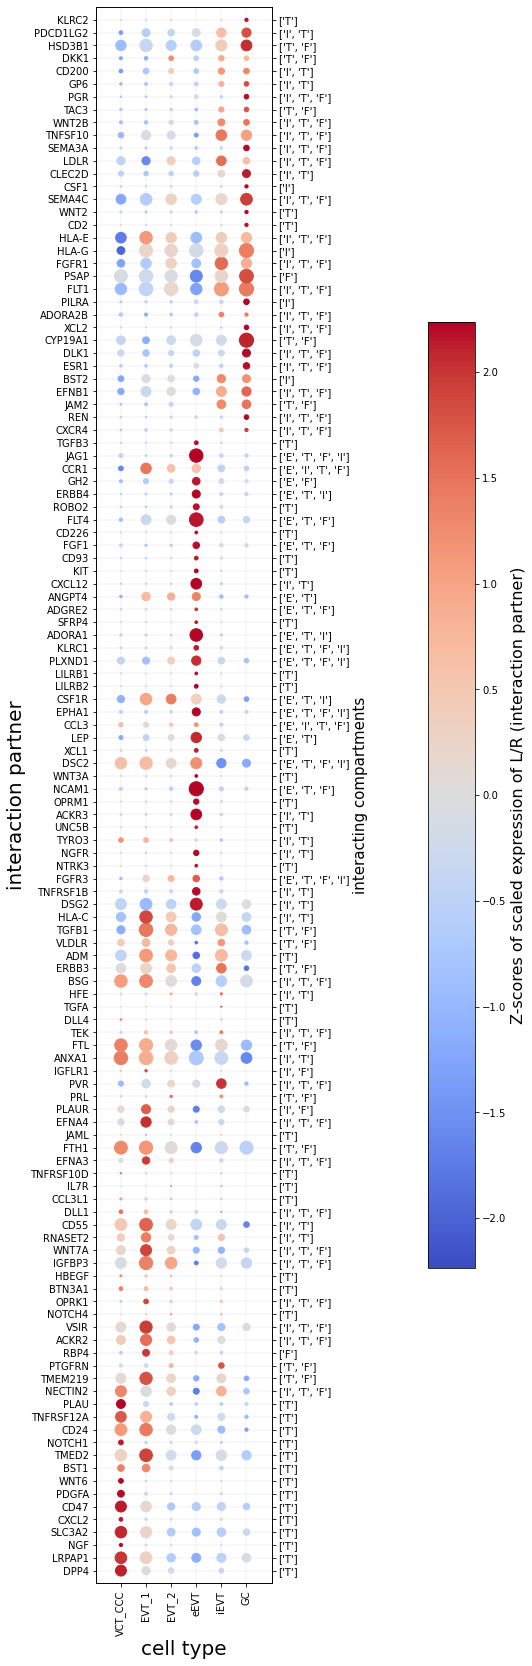

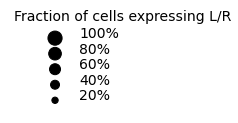

In [181]:
plot_dotplot('simple_fetus', 
             pdf_save_name='20220206_fetus_simple_interactions_zscores_selected_by_ME'
            )

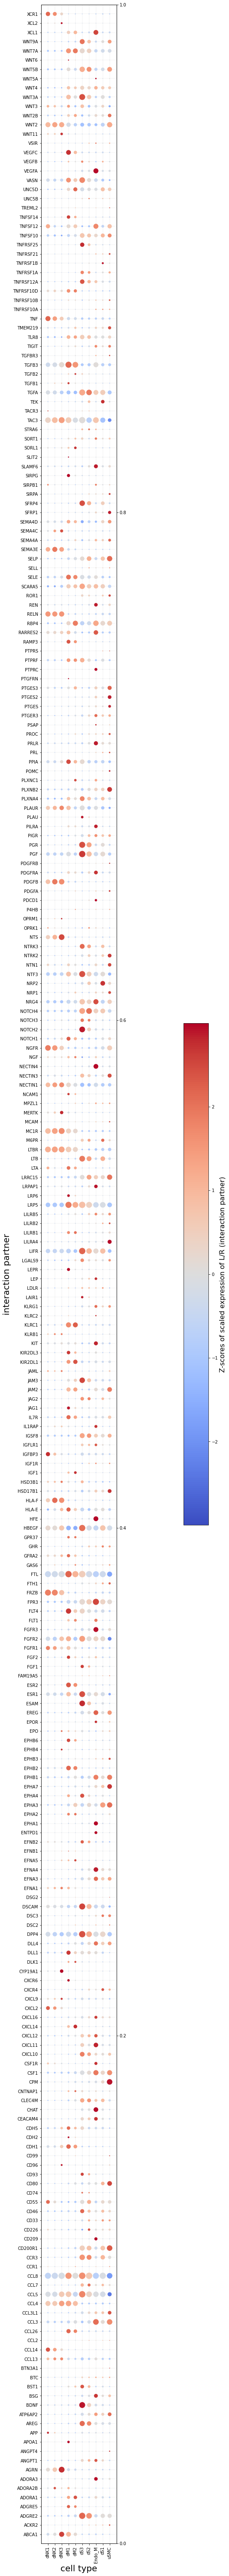

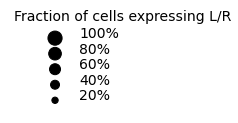

In [182]:
plot_dotplot('simple_mother', 
             pdf_save_name='20220206_mother_simple_interactions_zscores')

## Part 2: dealing with complexes

In [183]:
cellphone_results_complex

interaction partner_A_genes partner_B_genes  \
1_member_1      LeukotrieneC4_byLTC4S_CYSLTR2         ALOX5AP         CYSLTR2   
1_member_2      LeukotrieneC4_byLTC4S_CYSLTR2           LTC4S         CYSLTR2   
1_member_3      LeukotrieneC4_byLTC4S_CYSLTR2           ALOX5         CYSLTR2   
10042_member_1                FZD1_LRP6_WNT7A            FZD1           WNT7A   
10042_member_2                FZD1_LRP6_WNT7A            LRP6           WNT7A   
...                                       ...             ...             ...   
98898_member_2     F11R_integrin_aLb2_complex            F11R           ITGAL   
9891_member_1                 FZD1_LRP6_WNT7A            FZD1           WNT7A   
9891_member_2                 FZD1_LRP6_WNT7A            LRP6           WNT7A   
9991_member_1                 FZD1_LRP6_WNT7A            FZD1           WNT7A   
9991_member_2                 FZD1_LRP6_WNT7A            LRP6           WNT7A   

               celltype_A celltype_B  is_partner_A_DE  logFC_gene_A  \
1_member_1             GC      EVT_1            False           NaN   
1_member_2             GC      EVT_1            False           NaN   
1_member_3             GC      EVT_1            False           NaN   
10042_member_1       eEVT      EVT_1            False           NaN   
10042_member_2       eEVT      EVT_1            False           NaN   
...                   ...        ...              ...           ...   
98898_member_2         GC         GC             True      0.502664   
9891_member_1          GC      EVT_1            False           NaN   
9891_member_2          GC      EVT_1            False           NaN   
9991_member_1         dM1      EVT_1            False           NaN   
9991_member_2         dM1      EVT_1            False           NaN   

                adj_pval_gene_A  percent_expr_gene_A  is_partner_B_DE  \
1_member_1                  NaN             0.052632             True   
1_member_2                  NaN             0.000000             True   
1_member_3                  NaN             0.000000             True   
10042_member_1              NaN             0.000000             True   
10042_member_2              NaN             0.142857             True   
...                         ...                  ...              ...   
98898_member_2         0.026934             0.684211            False   
9891_member_1               NaN             0.052632             True   
9891_member_2               NaN             0.000000             True   
9991_member_1               NaN             0.079580             True   
9991_member_2               NaN             0.015462             True   

                logFC_gene_B  adj_pval_gene_B  percent_expr_gene_B  
1_member_1          0.033083     1.486300e-17             0.053507  
1_member_2          0.033083     1.486300e-17             0.053507  
1_member_3          0.033083     1.486300e-17             0.053507  
10042_member_1      0.174282     1.101306e-63             0.607487  
10042_member_2      0.174282     1.101306e-63             0.607487  
...                      ...              ...                  ...  
98898_member_2           NaN              NaN             0.052632  
9891_member_1       0.174282     1.101306e-63             0.607487  
9891_member_2       0.174282     1.101306e-63             0.607487  
9991_member_1       0.174282     1.101306e-63             0.607487  
9991_member_2       0.174282     1.101306e-63             0.607487  

[6869 rows x 13 columns]

In [184]:
cellphone_results_complex[cellphone_results_complex['interaction'] == 'ACVR_1B2A_receptor_GDF11']

interaction partner_A_genes partner_B_genes  \
92019_member_1  ACVR_1B2A_receptor_GDF11          ACVR2A           GDF11   
92019_member_2  ACVR_1B2A_receptor_GDF11          ACVR1B           GDF11   

               celltype_A celltype_B  is_partner_A_DE  logFC_gene_A  \
92019_member_1       eEVT       eEVT            False           NaN   
92019_member_2       eEVT       eEVT            False           NaN   

                adj_pval_gene_A  percent_expr_gene_A  is_partner_B_DE  \
92019_member_1              NaN             0.321429             True   
92019_member_2              NaN             0.107143             True   

                logFC_gene_B  adj_pval_gene_B  percent_expr_gene_B  
92019_member_1      0.099028         0.037822             0.178571  
92019_member_2      0.099028         0.037822             0.178571

In [185]:
# dfs for plotting with scaled expression values (dot color)
#dfs_for_plotting_expression = {}

# separate for simple and complex interactions
dfs_for_plotting_expression['complex'] = {}

dfs_for_plotting_expression['complex']['fetus'] = pd.DataFrame(index = relevant_cell_types_fetus, columns = all_LR_genes)
dfs_for_plotting_expression['complex']['mother'] = pd.DataFrame(index = relevant_cell_types_mother, columns = all_LR_genes)

In [186]:
# deconvoluted table for manual annotation
#df_manual_annotation = {}
df_manual_annotation['complex'] = {}
df_manual_annotation['complex']['fetus'] = pd.DataFrame(columns = ['interacting_pair',
                                                                   'partners_in_troph', # this is all cell types where z-score of expr of partner is > 0, for now no thresh on %
                                                                   'partners_in_troph_expr_where',
                                                                   #'partner_in_troph_forms_complex_with',
                                                                   #'partner_in_troph_forms_complex_with_expr_where',
                                                                   
                                                                   'partners_other', # this is all cell types where z-score of expr of partner is > 0, for now no thresh on %
                                                                   'partners_other_expr_where',
                                                                   #'partner_other_forms_complex_with', 
                                                                   #'partner_other_forms_complex_with_expr_where',
                                                                   'direction_of_interaction'])

In [187]:
df_manual_annotation['complex']['fetus']

Empty DataFrame
Columns: [interacting_pair, partners_in_troph, partners_in_troph_expr_where, partners_other, partners_other_expr_where, direction_of_interaction]
Index: []

In [188]:
df_manual_annotation['complex']['fetus'].columns

Index(['interacting_pair', 'partners_in_troph', 'partners_in_troph_expr_where',
       'partners_other', 'partners_other_expr_where',
       'direction_of_interaction'],
      dtype='object')

In [189]:
cases_complex = []

idx_manual_annotation_complexes = 0

for interaction in complex_interactions:
    print(interaction)
    # which cell types are interacting?
    cts_A = list(cellphone_results_complex[cellphone_results_complex['interaction'] == interaction]['celltype_A'])
    cts_B = list(cellphone_results_complex[cellphone_results_complex['interaction'] == interaction]['celltype_B'])
    
    # which genes are encoding interacting partners? here all are simple interactions
    gene_A = list(set(cellphone_results_complex[cellphone_results_complex['interaction'] == interaction]['partner_A_genes']))
    gene_B = list(set(cellphone_results_complex[cellphone_results_complex['interaction'] == interaction]['partner_B_genes']))
    
    print(gene_A, gene_B)

    # are all cell types A/B from only fetus or mother? or from both?
    
    # are any cell types A maternal?
    M_in_cts_A = len(set(cts_A) & set(relevant_cell_types_mother)) > 0
    
    # are any cell types A fetal?
    F_in_cts_A = len(set(cts_A) & set(relevant_cell_types_fetus)) > 0
    
    # are any cell types B maternal?
    M_in_cts_B = len(set(cts_B) & set(relevant_cell_types_mother)) > 0
    
    # are any cell types B fetal?
    F_in_cts_B = len(set(cts_B) & set(relevant_cell_types_fetus)) > 0
    
    
    # are all cell types A fetal?
    all_ct_A_fetal = F_in_cts_A and not M_in_cts_A
    
    # are all cell types A maternal?
    all_ct_A_maternal = M_in_cts_A and not F_in_cts_A
    
    # are all cell types B fetal?
    all_ct_B_fetal = F_in_cts_B and not M_in_cts_B
    
    # are all cell types B maternal?
    all_ct_B_maternal = M_in_cts_B and not F_in_cts_B
    
    
    
    # CASE 1: if both cell type A and cell type B are only fetal
    if all_ct_A_fetal and all_ct_B_fetal:
        cases_complex.append('1')
        print('celltype_A are only fetal & celltype_B are only fetal --> this is a troph-troph interaction')
        print('adding stats for both interacting partners to fetus table')
        dfs_for_plotting_expression['complex']['fetus'].loc[relevant_cell_types_fetus, gene_A] = scipy.stats.zscore(df_expr_scaled.loc[relevant_cell_types_fetus, gene_A])
        dfs_for_plotting_expression['complex']['fetus'].loc[relevant_cell_types_fetus, gene_B] = scipy.stats.zscore(df_expr_scaled.loc[relevant_cell_types_fetus, gene_B])
        
        
        # accounting for complexes here
        if isinstance(gene_A, list):
            partners_in_troph_per_complex_subunit_gene_A = [dfs_for_plotting_expression['complex']['fetus'][dfs_for_plotting_expression['complex']['fetus'].loc[relevant_cell_types_fetus, gene_A[i]] > 0].index for i in range(len(gene_A))]
            partners_in_troph_expr_where_gene_A = str(list(set.intersection(*[set(list) for list in partners_in_troph_per_complex_subunit_gene_A])))
            
            # in this case the list below should be the same as above since it's a F-F interaction
            partners_other_per_complex_subunit_gene_A = [dfs_for_plotting_expression['complex']['fetus'][dfs_for_plotting_expression['complex']['fetus'].loc[relevant_cell_types_fetus, gene_A[i]] > 0].index for i in range(len(gene_A))]
            partners_other_expr_where_gene_A = str(list(set.intersection(*[set(list) for list in partners_other_per_complex_subunit_gene_A])))
            
        else:
            # 2 identical lists
            partners_in_troph_expr_where_gene_A = str(list(dfs_for_plotting_expression['complex']['fetus'][dfs_for_plotting_expression['complex']['fetus'].loc[relevant_cell_types_fetus, gene_A] > 0].index))
            partners_other_expr_where_gene_A = str(list(dfs_for_plotting_expression['complex']['fetus'][dfs_for_plotting_expression['complex']['fetus'].loc[relevant_cell_types_fetus, gene_A] > 0].index))
        
        if isinstance(gene_B, list):
            partners_in_troph_per_complex_subunit_gene_B = [dfs_for_plotting_expression['complex']['fetus'][dfs_for_plotting_expression['complex']['fetus'].loc[relevant_cell_types_fetus, gene_B[i]] > 0].index for i in range(len(gene_B))]
            partners_in_troph_expr_where_gene_B = str(list(set.intersection(*[set(list) for list in partners_in_troph_per_complex_subunit_gene_B])))
            
            # in this case the list below should be the same as above since it's a F-F interaction
            partners_other_per_complex_subunit_gene_B = [dfs_for_plotting_expression['complex']['fetus'][dfs_for_plotting_expression['complex']['fetus'].loc[relevant_cell_types_fetus, gene_B[i]] > 0].index for i in range(len(gene_B))]
            partners_other_expr_where_gene_B = str(list(set.intersection(*[set(list) for list in partners_other_per_complex_subunit_gene_B])))
            
        else:
            # 2 identical lists
            partners_in_troph_expr_where_gene_B = str(list(dfs_for_plotting_expression['complex']['fetus'][dfs_for_plotting_expression['complex']['fetus'].loc[relevant_cell_types_fetus, gene_B] > 0].index))
            partners_other_expr_where_gene_B = str(list(dfs_for_plotting_expression['complex']['fetus'][dfs_for_plotting_expression['complex']['fetus'].loc[relevant_cell_types_fetus, gene_B] > 0].index))
        
        
        # in this case add both gene_A and gene_B entries to df_manual_annotation['complex']['fetus'] table separately
        df_manual_annotation['complex']['fetus'] = df_manual_annotation['complex']['fetus'].append(pd.DataFrame(data={'interacting_pair': interaction,
                   'partners_in_troph': str(gene_A),
                   'partners_in_troph_expr_where': partners_in_troph_expr_where_gene_A,                                                                                             
                   'partners_other': str(gene_B),
                   'partners_other_expr_where': partners_other_expr_where_gene_B,
                   'direction_of_interaction': 'F-F'}, index=[idx_manual_annotation_complexes]))
        
        df_manual_annotation['complex']['fetus'] = df_manual_annotation['complex']['fetus'].append(pd.DataFrame(data={'interacting_pair': interaction,
                   'partners_in_troph': str(gene_B),
                   'partners_in_troph_expr_where': partners_in_troph_expr_where_gene_B,                                                                                             
                   'partners_other': str(gene_A),
                   'partners_other_expr_where': partners_other_expr_where_gene_A,
                   'direction_of_interaction': 'F-F'}, index=[idx_manual_annotation_complexes + 1]))
        
        idx_manual_annotation_complexes += 1  
        
    # CASE 2: if cell type A are all fetal and cell type B are all maternal
    if all_ct_A_fetal and all_ct_B_maternal:
        cases_complex.append('2')
        print('celltype_A are only fetal & celltype_B are only maternal --> this is a one way F-M interaction')
        
        print('maternal cell types here:', set(cts_A) & set(relevant_cell_types_mother))
        print('fetal cell types here:', set(cts_A) & set(relevant_cell_types_fetus))
        
        print('adding gene_A stats (', gene_A, ') to fetus table')
        print('adding gene_B stats (', gene_B, ') to mother table')
        
        dfs_for_plotting_expression['complex']['fetus'].loc[relevant_cell_types_fetus, gene_A] = scipy.stats.zscore(df_expr_scaled.loc[relevant_cell_types_fetus, gene_A])
        dfs_for_plotting_expression['complex']['mother'].loc[relevant_cell_types_mother, gene_B] = scipy.stats.zscore(df_expr_scaled.loc[relevant_cell_types_mother, gene_B])
     
        # accounting for complexes here
        if isinstance(gene_A, list):
            partners_in_troph_per_complex_subunit_gene_A = [dfs_for_plotting_expression['complex']['fetus'][dfs_for_plotting_expression['complex']['fetus'].loc[relevant_cell_types_fetus, gene_A[i]] > 0].index for i in range(len(gene_A))]
            partners_in_troph_expr_where_gene_A = str(list(set.intersection(*[set(list) for list in partners_in_troph_per_complex_subunit_gene_A])))
        else:
            partners_in_troph_expr_where_gene_A = str(list(dfs_for_plotting_expression['complex']['fetus'][dfs_for_plotting_expression['complex']['fetus'].loc[relevant_cell_types_fetus, gene_A] > 0].index))
        
        if isinstance(gene_B, list):
            partners_other_per_complex_subunit_gene_B = [dfs_for_plotting_expression['complex']['mother'][dfs_for_plotting_expression['complex']['mother'].loc[relevant_cell_types_mother, gene_B[i]] > 0].index for i in range(len(gene_B))]
            partners_other_expr_where_gene_B = str(list(set.intersection(*[set(list) for list in partners_other_per_complex_subunit_gene_B])))
            
        else:
            partners_other_expr_where_gene_B = str(list(dfs_for_plotting_expression['complex']['mother'][dfs_for_plotting_expression['complex']['mother'].loc[relevant_cell_types_mother, gene_B] > 0].index))
        
        # in this case just gene_A entry to df_manual_annotation['simple']['fetus'] table
        df_manual_annotation['complex']['fetus'] = df_manual_annotation['complex']['fetus'].append(pd.DataFrame(data={'interacting_pair': interaction,
                   'partners_in_troph': str(gene_A),
                   'partners_in_troph_expr_where': partners_in_troph_expr_where_gene_A,                                                                                             
                   'partners_other': str(gene_B),
                   'partners_other_expr_where': partners_other_expr_where_gene_B,
                   'direction_of_interaction': 'F-M'}, index=[idx_manual_annotation_complexes]))
        
        idx_manual_annotation_complexes += 1  
    
    
    # CASE 3: if cell type A are all maternal and cell type B are all fetal
    if all_ct_A_maternal and all_ct_B_fetal:
        cases_complex.append('3')
        print('celltype_A are only maternal & celltype_B are only fetal --> this is a one way M-F interaction')
        
        print('maternal cell types here:', set(cts_A) & set(relevant_cell_types_mother))
        print('fetal cell types here:', set(cts_A) & set(relevant_cell_types_fetus))
        
        print('adding gene_A stats (', gene_A, ') to mother table')
        print('adding gene_B stats (', gene_B, ') to fetus table')
        
        dfs_for_plotting_expression['complex']['fetus'].loc[relevant_cell_types_fetus, gene_B] = scipy.stats.zscore(df_expr_scaled.loc[relevant_cell_types_fetus, gene_B])
        dfs_for_plotting_expression['complex']['mother'].loc[relevant_cell_types_mother, gene_A] = scipy.stats.zscore(df_expr_scaled.loc[relevant_cell_types_mother, gene_A])
     

        # accounting for complexes here
        if isinstance(gene_B, list):
            partners_in_troph_per_complex_subunit_gene_B = [dfs_for_plotting_expression['complex']['fetus'][dfs_for_plotting_expression['complex']['fetus'].loc[relevant_cell_types_fetus, gene_B[i]] > 0].index for i in range(len(gene_B))]
            partners_in_troph_expr_where_gene_B = str(list(set.intersection(*[set(list) for list in partners_in_troph_per_complex_subunit_gene_B])))
        else:
            partners_in_troph_expr_where_gene_B = str(list(dfs_for_plotting_expression['complex']['fetus'][dfs_for_plotting_expression['complex']['fetus'].loc[relevant_cell_types_fetus, gene_B] > 0].index))
        
        if isinstance(gene_A, list):
            partners_other_per_complex_subunit_gene_A = [dfs_for_plotting_expression['complex']['mother'][dfs_for_plotting_expression['complex']['mother'].loc[relevant_cell_types_mother, gene_A[i]] > 0].index for i in range(len(gene_A))]
            partners_other_expr_where_gene_A = str(list(set.intersection(*[set(list) for list in partners_other_per_complex_subunit_gene_A])))
            
        else:
            partners_other_expr_where_gene_A = str(list(dfs_for_plotting_expression['complex']['mother'][dfs_for_plotting_expression['complex']['mother'].loc[relevant_cell_types_mother, gene_A] > 0].index))
       
    
        # in this case just gene_B entry to df_manual_annotation['simple']['fetus'] table
        df_manual_annotation['complex']['fetus'] = df_manual_annotation['complex']['fetus'].append(pd.DataFrame(data={'interacting_pair': interaction,
                   'partners_in_troph': str(gene_B),
                   'partners_in_troph_expr_where': partners_in_troph_expr_where_gene_B, #str(list(dfs_for_plotting_expression['complex']['fetus'][dfs_for_plotting_expression['complex']['fetus'].loc[relevant_cell_types_fetus, gene_B] > 0].index)),                                                                                             
                   'partners_other': str(gene_A),
                   'partners_other_expr_where': partners_other_expr_where_gene_A, #str(list(dfs_for_plotting_expression['complex']['mother'][dfs_for_plotting_expression['complex']['mother'].loc[relevant_cell_types_mother, gene_A] > 0].index)),
                   'direction_of_interaction': 'M-F'}, index=[idx_manual_annotation_complexes]))
        
        idx_manual_annotation_complexes += 1  
    
    
    # CASE 4: if cell type A are all fetal and cell type B are a mix of fetal + maternal
    if all_ct_A_fetal and (F_in_cts_B and M_in_cts_B):
        cases_complex.append('4')
        print('celltype_A are only fetal & celltype_B are a mix of fetal and maternal --> this is a both-ways F-M interaction AND a troph-troph interaction')
        
        print('maternal cell types here:', set(cts_A) & set(relevant_cell_types_mother))
        print('fetal cell types here:', set(cts_A) & set(relevant_cell_types_fetus))
        
        print('adding gene_A stats (', gene_A, ') to fetus table')
        print('adding gene_B stats (', gene_B, ') to both fetus and mother table')

        dfs_for_plotting_expression['complex']['fetus'].loc[relevant_cell_types_fetus, gene_A] = scipy.stats.zscore(df_expr_scaled.loc[relevant_cell_types_fetus, gene_A])
        
        dfs_for_plotting_expression['complex']['fetus'].loc[relevant_cell_types_fetus, gene_B] = scipy.stats.zscore(df_expr_scaled.loc[relevant_cell_types_fetus, gene_B])
        dfs_for_plotting_expression['complex']['mother'].loc[relevant_cell_types_mother, gene_B] = scipy.stats.zscore(df_expr_scaled.loc[relevant_cell_types_mother, gene_B])
     
        # accounting for complexes here
        if isinstance(gene_A, list):
            partners_in_troph_per_complex_subunit_gene_A = [dfs_for_plotting_expression['complex']['fetus'][dfs_for_plotting_expression['complex']['fetus'].loc[relevant_cell_types_fetus, gene_A[i]] > 0].index for i in range(len(gene_A))]
            partners_in_troph_expr_where_gene_A = str(list(set.intersection(*[set(list) for list in partners_in_troph_per_complex_subunit_gene_A])))
            
            # in this case the list below should be the same as above since it's a F-F interaction
            partners_other_per_complex_subunit_gene_A = [dfs_for_plotting_expression['complex']['fetus'][dfs_for_plotting_expression['complex']['fetus'].loc[relevant_cell_types_fetus, gene_A[i]] > 0].index for i in range(len(gene_A))]
            partners_other_expr_where_gene_A = str(list(set.intersection(*[set(list) for list in partners_other_per_complex_subunit_gene_A])))
            
        else:
            # 2 identical lists
            partners_in_troph_expr_where_gene_A = str(list(dfs_for_plotting_expression['complex']['fetus'][dfs_for_plotting_expression['complex']['fetus'].loc[relevant_cell_types_fetus, gene_A] > 0].index))
            partners_other_expr_where_gene_A = str(list(dfs_for_plotting_expression['complex']['fetus'][dfs_for_plotting_expression['complex']['fetus'].loc[relevant_cell_types_fetus, gene_A] > 0].index))
        
        if isinstance(gene_B, list):
            partners_other_per_complex_subunit_gene_B_fetus = [dfs_for_plotting_expression['complex']['fetus'][dfs_for_plotting_expression['complex']['fetus'].loc[relevant_cell_types_fetus, gene_B[i]] > 0].index for i in range(len(gene_B))]
            partners_other_expr_where_gene_B_fetus = list(set.intersection(*[set(list) for list in partners_other_per_complex_subunit_gene_B_fetus]))
            
            partners_other_per_complex_subunit_gene_B_mother = [dfs_for_plotting_expression['complex']['mother'][dfs_for_plotting_expression['complex']['mother'].loc[relevant_cell_types_mother, gene_B[i]] > 0].index for i in range(len(gene_B))]
            partners_other_expr_where_gene_B_mother = list(set.intersection(*[set(list) for list in partners_other_per_complex_subunit_gene_B_mother]))
            
            partners_other_expr_where_gene_B = str(partners_other_expr_where_gene_B_fetus + partners_other_expr_where_gene_B_mother)
            
            partners_in_troph_expr_where_gene_B = str(partners_other_expr_where_gene_B_fetus)
            
        else:
            partners_other_expr_where_gene_B = str(list(dfs_for_plotting_expression['complex']['fetus'][dfs_for_plotting_expression['complex']['fetus'].loc[relevant_cell_types_fetus, gene_B] > 0].index) + list(dfs_for_plotting_expression['complex']['mother'][dfs_for_plotting_expression['complex']['mother'].loc[relevant_cell_types_mother, gene_B] > 0].index))
            partners_in_troph_expr_where_gene_B = str(list(dfs_for_plotting_expression['complex']['fetus'][dfs_for_plotting_expression['complex']['fetus'].loc[relevant_cell_types_fetus, gene_B] > 0].index))
            
    
        # in this case add both gene_A and gene_B entries to df_manual_annotation['simple']['fetus'] table separately
        df_manual_annotation['complex']['fetus'] = df_manual_annotation['complex']['fetus'].append(pd.DataFrame(data={'interacting_pair': interaction,
                   'partners_in_troph': str(gene_A),
                   'partners_in_troph_expr_where': partners_in_troph_expr_where_gene_A, #str(list(dfs_for_plotting_expression['complex']['fetus'][dfs_for_plotting_expression['complex']['fetus'].loc[relevant_cell_types_fetus, gene_A] > 0].index)),                                                                                             
                   'partners_other': str(gene_B),
                   'partners_other_expr_where': partners_other_expr_where_gene_B, #str(list(dfs_for_plotting_expression['complex']['fetus'][dfs_for_plotting_expression['complex']['fetus'].loc[relevant_cell_types_fetus, gene_B] > 0].index) + list(dfs_for_plotting_expression['complex']['mother'][dfs_for_plotting_expression['complex']['mother'].loc[relevant_cell_types_mother, gene_B] > 0].index)),
                   'direction_of_interaction': 'F-(M+F)'}, index=[idx_manual_annotation_complexes]))
        
        df_manual_annotation['complex']['fetus'] = df_manual_annotation['complex']['fetus'].append(pd.DataFrame(data={'interacting_pair': interaction,
                   'partners_in_troph': str(gene_B),
                   'partners_in_troph_expr_where': partners_in_troph_expr_where_gene_B, #str(list(dfs_for_plotting_expression['complex']['fetus'][dfs_for_plotting_expression['complex']['fetus'].loc[relevant_cell_types_fetus, gene_B] > 0].index)),                                                                                             
                   'partners_other': str(gene_A),
                   'partners_other_expr_where': partners_other_expr_where_gene_A, #str(list(dfs_for_plotting_expression['complex']['fetus'][dfs_for_plotting_expression['complex']['fetus'].loc[relevant_cell_types_fetus, gene_A] > 0].index)),
                   'direction_of_interaction': '(M+F)-F'}, index=[idx_manual_annotation_complexes + 1]))
        
        idx_manual_annotation_complexes += 1  
        
        
    # CASE 5: if cell type B are all fetal and cell type A are a mix of fetal + maternal
    if all_ct_B_fetal and (F_in_cts_A and M_in_cts_A):
        cases_complex.append('5')
        print('celltype_A are a mix of fetal and maternal & celltype_B are only fetal --> this is a both-ways M-F interaction AND a troph-troph interaction')
        
        print('maternal cell types here:', set(cts_A) & set(relevant_cell_types_mother))
        print('fetal cell types here:', set(cts_A) & set(relevant_cell_types_fetus))
        
        print('adding gene_A stats (', gene_A, ') to both fetus and mother table')
        print('adding gene_B stats (', gene_B, ') to fetus table')

        dfs_for_plotting_expression['complex']['fetus'].loc[relevant_cell_types_fetus, gene_B] = scipy.stats.zscore(df_expr_scaled.loc[relevant_cell_types_fetus, gene_B])
        
        dfs_for_plotting_expression['complex']['fetus'].loc[relevant_cell_types_fetus, gene_A] = scipy.stats.zscore(df_expr_scaled.loc[relevant_cell_types_fetus, gene_A])
        dfs_for_plotting_expression['complex']['mother'].loc[relevant_cell_types_mother, gene_A] = scipy.stats.zscore(df_expr_scaled.loc[relevant_cell_types_mother, gene_A])
     
        # accounting for complexes here
        if isinstance(gene_B, list):
            partners_in_troph_per_complex_subunit_gene_B = [dfs_for_plotting_expression['complex']['fetus'][dfs_for_plotting_expression['complex']['fetus'].loc[relevant_cell_types_fetus, gene_B[i]] > 0].index for i in range(len(gene_B))]
            partners_in_troph_expr_where_gene_B = str(list(set.intersection(*[set(list) for list in partners_in_troph_per_complex_subunit_gene_B])))
            
            # in this case the list below should be the same as above since it's a F-F interaction
            partners_other_per_complex_subunit_gene_B = [dfs_for_plotting_expression['complex']['fetus'][dfs_for_plotting_expression['complex']['fetus'].loc[relevant_cell_types_fetus, gene_B[i]] > 0].index for i in range(len(gene_B))]
            partners_other_expr_where_gene_B = str(list(set.intersection(*[set(list) for list in partners_other_per_complex_subunit_gene_B])))
            
        else:
            # 2 identical lists
            partners_in_troph_expr_where_gene_B = str(list(dfs_for_plotting_expression['complex']['fetus'][dfs_for_plotting_expression['complex']['fetus'].loc[relevant_cell_types_fetus, gene_B] > 0].index))
            partners_other_expr_where_gene_B = str(list(dfs_for_plotting_expression['complex']['fetus'][dfs_for_plotting_expression['complex']['fetus'].loc[relevant_cell_types_fetus, gene_B] > 0].index))
        
        if isinstance(gene_A, list):
            partners_other_per_complex_subunit_gene_A_fetus = [dfs_for_plotting_expression['complex']['fetus'][dfs_for_plotting_expression['complex']['fetus'].loc[relevant_cell_types_fetus, gene_A[i]] > 0].index for i in range(len(gene_A))]
            partners_other_expr_where_gene_A_fetus = list(set.intersection(*[set(list) for list in partners_other_per_complex_subunit_gene_A_fetus]))
            
            partners_other_per_complex_subunit_gene_A_mother = [dfs_for_plotting_expression['complex']['mother'][dfs_for_plotting_expression['complex']['mother'].loc[relevant_cell_types_mother, gene_A[i]] > 0].index for i in range(len(gene_A))]
            partners_other_expr_where_gene_A_mother = list(set.intersection(*[set(list) for list in partners_other_per_complex_subunit_gene_A_mother]))
            
            partners_other_expr_where_gene_A = str(partners_other_expr_where_gene_A_fetus + partners_other_expr_where_gene_A_mother)
            
            partners_in_troph_expr_where_gene_A = str(partners_other_expr_where_gene_A_fetus)
            
        else:
            partners_other_expr_where_gene_A = str(list(dfs_for_plotting_expression['complex']['fetus'][dfs_for_plotting_expression['complex']['fetus'].loc[relevant_cell_types_fetus, gene_A] > 0].index) + list(dfs_for_plotting_expression['complex']['mother'][dfs_for_plotting_expression['complex']['mother'].loc[relevant_cell_types_mother, gene_A] > 0].index))
            partners_in_troph_expr_where_gene_A = str(list(dfs_for_plotting_expression['complex']['fetus'][dfs_for_plotting_expression['complex']['fetus'].loc[relevant_cell_types_fetus, gene_A] > 0].index))

    
        # in this case add both gene_A and gene_B entries to df_manual_annotation['simple']['fetus'] table separately
        df_manual_annotation['complex']['fetus'] = df_manual_annotation['complex']['fetus'].append(pd.DataFrame(data={'interacting_pair': interaction,
                   'partners_in_troph': str(gene_A),
                   'partners_in_troph_expr_where': partners_in_troph_expr_where_gene_A, #str(list(dfs_for_plotting_expression['complex']['fetus'][dfs_for_plotting_expression['complex']['fetus'].loc[relevant_cell_types_fetus, gene_A] > 0].index)),                                                                                             
                   'partners_other': str(gene_B),
                   'partners_other_expr_where': partners_other_expr_where_gene_B, #str(list(dfs_for_plotting_expression['complex']['fetus'][dfs_for_plotting_expression['complex']['fetus'].loc[relevant_cell_types_fetus, gene_B] > 0].index)),
                   'direction_of_interaction': '(M+F)-F'}, index=[idx_manual_annotation_complexes]))
        
        df_manual_annotation['complex']['fetus'] = df_manual_annotation['complex']['fetus'].append(pd.DataFrame(data={'interacting_pair': interaction,
                   'partners_in_troph': str(gene_B),
                   'partners_in_troph_expr_where': partners_in_troph_expr_where_gene_B, #str(list(dfs_for_plotting_expression['complex']['fetus'][dfs_for_plotting_expression['complex']['fetus'].loc[relevant_cell_types_fetus, gene_B] > 0].index)),                                                                                             
                   'partners_other': str(gene_A),
                   'partners_other_expr_where': partners_other_expr_where_gene_A, #str(list(dfs_for_plotting_expression['complex']['fetus'][dfs_for_plotting_expression['complex']['fetus'].loc[relevant_cell_types_fetus, gene_A] > 0].index) + list(dfs_for_plotting_expression['complex']['mother'][dfs_for_plotting_expression['complex']['mother'].loc[relevant_cell_types_mother, gene_A] > 0].index)),
                   'direction_of_interaction': 'F-(M+F)'}, index=[idx_manual_annotation_complexes + 1]))
        
        idx_manual_annotation_complexes += 1
    

    # CASE 6: if both cell type A and cell type B are a mix of fetal + maternal
    if (F_in_cts_A and M_in_cts_A) and (F_in_cts_B and M_in_cts_B):
        cases_complex.append('6')
        print('celltype_A AND celltype_B are both a mix of fetal and maternal --> this is a both-ways M-F/F-M interaction AND a troph-troph interaction')
        
        print('maternal cell types here:', set(cts_A) & set(relevant_cell_types_mother))
        print('fetal cell types here:', set(cts_A) & set(relevant_cell_types_fetus))
        
        print('adding gene_A stats (', gene_A, ') to both fetus and mother table')
        print('adding gene_B stats (', gene_B, ') to both fetus and mother table')

        
        dfs_for_plotting_expression['complex']['fetus'].loc[relevant_cell_types_fetus, gene_A] = scipy.stats.zscore(df_expr_scaled.loc[relevant_cell_types_fetus, gene_A])
        dfs_for_plotting_expression['complex']['fetus'].loc[relevant_cell_types_fetus, gene_B] = scipy.stats.zscore(df_expr_scaled.loc[relevant_cell_types_fetus, gene_B])

        dfs_for_plotting_expression['complex']['mother'].loc[relevant_cell_types_mother, gene_A] = scipy.stats.zscore(df_expr_scaled.loc[relevant_cell_types_mother, gene_A])
        dfs_for_plotting_expression['complex']['mother'].loc[relevant_cell_types_mother, gene_B] = scipy.stats.zscore(df_expr_scaled.loc[relevant_cell_types_mother, gene_B])
        
        # accounting for complexes here
        if isinstance(gene_A, list):
            partners_other_per_complex_subunit_gene_A_fetus = [dfs_for_plotting_expression['complex']['fetus'][dfs_for_plotting_expression['complex']['fetus'].loc[relevant_cell_types_fetus, gene_A[i]] > 0].index for i in range(len(gene_A))]
            partners_other_expr_where_gene_A_fetus = list(set.intersection(*[set(list) for list in partners_other_per_complex_subunit_gene_A_fetus]))
            
            partners_other_per_complex_subunit_gene_A_mother = [dfs_for_plotting_expression['complex']['mother'][dfs_for_plotting_expression['complex']['mother'].loc[relevant_cell_types_mother, gene_A[i]] > 0].index for i in range(len(gene_A))]
            partners_other_expr_where_gene_A_mother = list(set.intersection(*[set(list) for list in partners_other_per_complex_subunit_gene_A_mother]))
            
            partners_other_expr_where_gene_A = str(partners_other_expr_where_gene_A_fetus + partners_other_expr_where_gene_A_mother)
            
            partners_in_troph_expr_where_gene_A = str(partners_other_expr_where_gene_A_fetus)
            
        else:
            partners_other_expr_where_gene_A = str(list(dfs_for_plotting_expression['complex']['fetus'][dfs_for_plotting_expression['complex']['fetus'].loc[relevant_cell_types_fetus, gene_A] > 0].index) + list(dfs_for_plotting_expression['complex']['mother'][dfs_for_plotting_expression['complex']['mother'].loc[relevant_cell_types_mother, gene_A] > 0].index))
            partners_in_troph_expr_where_gene_A = str(list(dfs_for_plotting_expression['complex']['fetus'][dfs_for_plotting_expression['complex']['fetus'].loc[relevant_cell_types_fetus, gene_A] > 0].index))
            
    
        if isinstance(gene_B, list):
            partners_other_per_complex_subunit_gene_B_fetus = [dfs_for_plotting_expression['complex']['fetus'][dfs_for_plotting_expression['complex']['fetus'].loc[relevant_cell_types_fetus, gene_B[i]] > 0].index for i in range(len(gene_B))]
            partners_other_expr_where_gene_B_fetus = list(set.intersection(*[set(list) for list in partners_other_per_complex_subunit_gene_B_fetus]))
            
            partners_other_per_complex_subunit_gene_B_mother = [dfs_for_plotting_expression['complex']['mother'][dfs_for_plotting_expression['complex']['mother'].loc[relevant_cell_types_mother, gene_B[i]] > 0].index for i in range(len(gene_B))]
            partners_other_expr_where_gene_B_mother = list(set.intersection(*[set(list) for list in partners_other_per_complex_subunit_gene_B_mother]))
            
            partners_other_expr_where_gene_B = str(partners_other_expr_where_gene_B_fetus + partners_other_expr_where_gene_B_mother)
            
            partners_in_troph_expr_where_gene_B = str(partners_other_expr_where_gene_B_fetus)
            
        else:
            partners_other_expr_where_gene_B = str(list(dfs_for_plotting_expression['complex']['fetus'][dfs_for_plotting_expression['complex']['fetus'].loc[relevant_cell_types_fetus, gene_B] > 0].index) + list(dfs_for_plotting_expression['complex']['mother'][dfs_for_plotting_expression['complex']['mother'].loc[relevant_cell_types_mother, gene_B] > 0].index))
            partners_in_troph_expr_where_gene_B = str(list(dfs_for_plotting_expression['complex']['fetus'][dfs_for_plotting_expression['complex']['fetus'].loc[relevant_cell_types_fetus, gene_B] > 0].index))
            
    
        
        # in this case add both gene_A and gene_B entries to df_manual_annotation['simple']['fetus'] table separately
        df_manual_annotation['complex']['fetus'] = df_manual_annotation['complex']['fetus'].append(pd.DataFrame(data={'interacting_pair': interaction,
                   'partners_in_troph': str(gene_A),
                   'partners_in_troph_expr_where': partners_in_troph_expr_where_gene_A, #str(list(dfs_for_plotting_expression['complex']['fetus'][dfs_for_plotting_expression['complex']['fetus'].loc[relevant_cell_types_fetus, gene_A] > 0].index)),                                                                                             
                   'partners_other': str(gene_B),
                   'partners_other_expr_where': partners_other_expr_where_gene_B, #str(list(dfs_for_plotting_expression['complex']['fetus'][dfs_for_plotting_expression['complex']['fetus'].loc[relevant_cell_types_fetus, gene_B] > 0].index) + list(dfs_for_plotting_expression['complex']['mother'][dfs_for_plotting_expression['complex']['mother'].loc[relevant_cell_types_mother, gene_B] > 0].index)),
                   'direction_of_interaction': '(M+F)-(M+F)'}, index=[idx_manual_annotation_complexes]))
        
        df_manual_annotation['complex']['fetus'] = df_manual_annotation['complex']['fetus'].append(pd.DataFrame(data={'interacting_pair': interaction,
                   'partners_in_troph': str(gene_B),
                   'partners_in_troph_expr_where': partners_in_troph_expr_where_gene_B, #str(list(dfs_for_plotting_expression['complex']['fetus'][dfs_for_plotting_expression['complex']['fetus'].loc[relevant_cell_types_fetus, gene_B] > 0].index)),                                                                                             
                   'partners_other': str(gene_A),
                   'partners_other_expr_where': partners_other_expr_where_gene_A, #str(list(dfs_for_plotting_expression['complex']['fetus'][dfs_for_plotting_expression['complex']['fetus'].loc[relevant_cell_types_fetus, gene_A] > 0].index) + list(dfs_for_plotting_expression['complex']['mother'][dfs_for_plotting_expression['complex']['mother'].loc[relevant_cell_types_mother, gene_A] > 0].index)),
                   'direction_of_interaction': '(M+F)-(M+F)'}, index=[idx_manual_annotation_complexes + 1]))
        
        idx_manual_annotation_complexes += 1
    print('\n')
        
        
    # add corresponding data to the right tables

ACVR_1A2A_receptor_INHA
['ACVR1', 'ACVR2A'] ['INHA']
celltype_A are a mix of fetal and maternal & celltype_B are only fetal --> this is a both-ways M-F interaction AND a troph-troph interaction
maternal cell types here: {'dS1', 'dM1', 'dS3', 'dS2', 'dNK3', 'Endo_M', 'dNK1', 'dM2', 'dNK2'}
fetal cell types here: {'iEVT', 'VCT_CCC', 'GC', 'eEVT', 'EVT_2', 'EVT_1'}
adding gene_A stats ( ['ACVR1', 'ACVR2A'] ) to both fetus and mother table
adding gene_B stats ( ['INHA'] ) to fetus table


ACVR_1A2B_receptor_INHA
['ACVR1', 'ACVR2B'] ['INHA']
celltype_A are a mix of fetal and maternal & celltype_B are only fetal --> this is a both-ways M-F interaction AND a troph-troph interaction
maternal cell types here: {'dS1', 'dM1', 'dS3', 'dS2', 'dNK3', 'Endo_M', 'dNK1', 'dM2', 'dNK2'}
fetal cell types here: {'iEVT', 'VCT_CCC', 'GC', 'eEVT', 'EVT_2', 'EVT_1'}
adding gene_A stats ( ['ACVR1', 'ACVR2B'] ) to both fetus and mother table
adding gene_B stats ( ['INHA'] ) to fetus table


ACVR_1B2A_receptor_G

In [190]:
df_manual_annotation['complex']['fetus'][df_manual_annotation['complex']['fetus']['interacting_pair'] == 'ACVR_1B2A_receptor_GDF11']

interacting_pair     partners_in_troph  \
2  ACVR_1B2A_receptor_GDF11  ['ACVR1B', 'ACVR2A']   
3  ACVR_1B2A_receptor_GDF11             ['GDF11']   

  partners_in_troph_expr_where        partners_other  \
2             ['eEVT', 'iEVT']             ['GDF11']   
3                     ['eEVT']  ['ACVR1B', 'ACVR2A']   

  partners_other_expr_where direction_of_interaction  
2                  ['eEVT']                      F-F  
3          ['eEVT', 'iEVT']                      F-F

In [191]:
df_manual_annotation['complex']['fetus']

interacting_pair     partners_in_troph  \
0        ACVR_1A2A_receptor_INHA   ['ACVR1', 'ACVR2A']   
1        ACVR_1A2A_receptor_INHA              ['INHA']   
1        ACVR_1A2B_receptor_INHA   ['ACVR1', 'ACVR2B']   
2        ACVR_1A2B_receptor_INHA              ['INHA']   
2       ACVR_1B2A_receptor_GDF11  ['ACVR1B', 'ACVR2A']   
..                           ...                   ...   
150  TGFB1_integrin_aVb6_complex    ['ITGB6', 'ITGAV']   
150      TGFB2_TGFbeta_receptor1             ['TGFB2']   
151      TGFB2_TGFbeta_receptor1  ['TGFBR2', 'TGFBR1']   
151      TGFB2_TGFbeta_receptor2             ['TGFB2']   
152      TGFB2_TGFbeta_receptor2   ['ACVR1', 'TGFBR2']   

           partners_in_troph_expr_where        partners_other  \
0                      ['eEVT', 'iEVT']              ['INHA']   
1    ['VCT_CCC', 'EVT_2', 'iEVT', 'GC']   ['ACVR1', 'ACVR2A']   
1                     ['EVT_2', 'iEVT']              ['INHA']   
2    ['VCT_CCC', 'EVT_2', 'iEVT', 'GC']   ['ACVR1', 'ACVR2B']   
2                      ['eEVT', 'iEVT']             ['GDF11']   
..                                  ...                   ...   
150                         ['VCT_CCC']             ['TGFB1']   
150              ['GC', 'eEVT', 'iEVT']  ['TGFBR2', 'TGFBR1']   
151                      ['GC', 'iEVT']             ['TGFB2']   
151              ['GC', 'eEVT', 'iEVT']   ['ACVR1', 'TGFBR2']   
152                            ['iEVT']             ['TGFB2']   

                             partners_other_expr_where  \
0                   ['VCT_CCC', 'EVT_2', 'iEVT', 'GC']   
1            ['eEVT', 'iEVT', 'Endo_M', 'dS1', 'uSMC']   
1                   ['VCT_CCC', 'EVT_2', 'iEVT', 'GC']   
2    ['EVT_2', 'iEVT', 'Endo_M', 'dS2', 'uSMC', 'dS1']   
2                                             ['eEVT']   
..                                                 ...   
150                         ['EVT_2', 'iEVT', 'EVT_1']   
150                      ['GC', 'iEVT', 'uSMC', 'dM2']   
151  ['GC', 'eEVT', 'iEVT', 'Endo_M', 'dS1', 'dS2',...   
151                         ['iEVT', 'Endo_M', 'uSMC']   
152                             ['GC', 'eEVT', 'iEVT']   

    direction_of_interaction  
0                    (M+F)-F  
1                    F-(M+F)  
1                    (M+F)-F  
2                    F-(M+F)  
2                        F-F  
..                       ...  
150                  (M+F)-F  
150              (M+F)-(M+F)  
151              (M+F)-(M+F)  
151                  F-(M+F)  
152                  (M+F)-F  

[304 rows x 6 columns]

In [192]:
complex_interactions_fetus = list(set(df_manual_annotation['complex']['fetus']['interacting_pair']))

In [193]:
len(complex_interactions_fetus)

152

In [194]:
# also adding 'is_integrin' information from cellphone
interactions = pd.read_csv('./out_20211124_threshold_0.1/relevant_interactions.txt',sep='\t')
interactions.head()

id_cp_interaction               interacting_pair  \
0   CPI-CS01FC3CF4D  LeukotrieneC4_byLTC4S_CYSLTR2   
1   CPI-SS0795802F6                    CCL4_SLC7A1   
2   CPI-SS03105D292                    CSF1_SLC7A1   
3   CPI-SS08DA48A5A                      CCL3_CCR1   
4   CPI-SS0A021DB6E                      CCL5_CCR1   

                       partner_a      partner_b gene_a   gene_b  secreted  \
0  complex:LeukotrieneC4_byLTC4S  simple:Q9NS75    NaN  CYSLTR2      True   
1                  simple:P13236  simple:P30825   CCL4   SLC7A1      True   
2                  simple:P09603  simple:P30825   CSF1   SLC7A1      True   
3                  simple:P10147  simple:P32246   CCL3     CCR1      True   
4                  simple:P13501  simple:P32246   CCL5     CCR1      True   

   receptor_a  receptor_b annotation_strategy  ...  iEVT|fF1  iEVT|fF2  \
0       False        True        user_curated  ...         0         0   
1       False        True         IMEx,IntAct  ...         0         0   
2       False        True                 I2D  ...         0         0   
3       False        True        user_curated  ...         0         0   
4       False        True        user_curated  ...         0         0   

   iEVT|iEVT  iEVT|uSMC  uSMC|EVT_1  uSMC|EVT_2  uSMC|GC  uSMC|VCT_CCC  \
0          0          0           0           0        0             0   
1          0          0           0           0        0             0   
2          0          0           0           0        0             0   
3          0          0           0           0        0             0   
4          0          0           0           0        0             0   

   uSMC|eEVT  uSMC|iEVT  
0          0          0  
1          0          0  
2          0          0  
3          0          0  
4          0          0  

[5 rows x 455 columns]

In [195]:
interactions.set_index('interacting_pair', inplace = True)

In [196]:
interactions

id_cp_interaction  \
interacting_pair                                  
LeukotrieneC4_byLTC4S_CYSLTR2   CPI-CS01FC3CF4D   
CCL4_SLC7A1                     CPI-SS0795802F6   
CSF1_SLC7A1                     CPI-SS03105D292   
CCL3_CCR1                       CPI-SS08DA48A5A   
CCL5_CCR1                       CPI-SS0A021DB6E   
...                                         ...   
UNC5D_NTN4                      CPI-SS0A1028EF5   
UNC5B_NTN4                      CPI-SS005F1054E   
VSTM1_ADGRG3                    CPI-SS033E857EB   
JAML_CD320                      CPI-SS075296A07   
ESAM_ESAM                       CPI-SS04C672963   

                                                   partner_a      partner_b  \
interacting_pair                                                              
LeukotrieneC4_byLTC4S_CYSLTR2  complex:LeukotrieneC4_byLTC4S  simple:Q9NS75   
CCL4_SLC7A1                                    simple:P13236  simple:P30825   
CSF1_SLC7A1                                    simple:P09603  simple:P30825   
CCL3_CCR1                                      simple:P10147  simple:P32246   
CCL5_CCR1                                      simple:P13501  simple:P32246   
...                                                      ...            ...   
UNC5D_NTN4                                     simple:Q6UXZ4  simple:Q9HB63   
UNC5B_NTN4                                     simple:Q8IZJ1  simple:Q9HB63   
VSTM1_ADGRG3                                   simple:Q6UX27  simple:Q86Y34   
JAML_CD320                                     simple:Q86YT9  simple:Q9NPF0   
ESAM_ESAM                                      simple:Q96AP7  simple:Q96AP7   

                              gene_a   gene_b  secreted  receptor_a  \
interacting_pair                                                      
LeukotrieneC4_byLTC4S_CYSLTR2    NaN  CYSLTR2      True       False   
CCL4_SLC7A1                     CCL4   SLC7A1      True       False   
CSF1_SLC7A1                     CSF1   SLC7A1      True       False   
CCL3_CCR1                       CCL3     CCR1      True       False   
CCL5_CCR1                       CCL5     CCR1      True       False   
...                              ...      ...       ...         ...   
UNC5D_NTN4                     UNC5D     NTN4      True        True   
UNC5B_NTN4                     UNC5B     NTN4      True        True   
VSTM1_ADGRG3                   VSTM1   ADGRG3      True        True   
JAML_CD320                      JAML    CD320     False       False   
ESAM_ESAM                       ESAM     ESAM     False       False   

                               receptor_b annotation_strategy  is_integrin  \
interacting_pair                                                             
LeukotrieneC4_byLTC4S_CYSLTR2        True        user_curated        False   
CCL4_SLC7A1                          True         IMEx,IntAct        False   
CSF1_SLC7A1                          True                 I2D        False   
CCL3_CCR1                            True        user_curated        False   
CCL5_CCR1                            True        user_curated        False   
...                                   ...                 ...          ...   
UNC5D_NTN4                          False        user_curated        False   
UNC5B_NTN4                          False        user_curated        False   
VSTM1_ADGRG3                         True         IMEx,IntAct        False   
JAML_CD320                          False        user_curated        False   
ESAM_ESAM                           False        user_curated        False   

                               ...  iEVT|fF1  iEVT|fF2  iEVT|iEVT  iEVT|uSMC  \
interacting_pair               ...                                             
LeukotrieneC4_byLTC4S_CYSLTR2  ...         0         0          0          0   
CCL4_SLC7A1                    ...         0         0          0          0   
CSF1_SLC7A1                    ...         0         0          0          0   

In [197]:
# also adding 'is_integrin' information from cellphone
df_manual_annotation['complex']['fetus']['is_integrin'] = [interactions.loc[inter_pair,'is_integrin'] for inter_pair in df_manual_annotation['complex']['fetus']['interacting_pair']]

In [198]:
df_manual_annotation['complex']['fetus']['is_integrin']

0      False
1      False
1      False
2      False
2      False
       ...  
150     True
150    False
151    False
151    False
152    False
Name: is_integrin, Length: 304, dtype: bool

In [199]:
idx_manual_annotation_complexes

152

In [200]:
np.unique(cases_complex, return_counts=True)

(array(['1', '4', '5', '6'], dtype='<U1'), array([ 2, 41, 57, 52]))

# in the following table columns partners_in_troph_expr_where and partners_other_expr_where are not correctly assigned so I can ignore them for now


In [201]:
df_manual_annotation['complex']['fetus']

interacting_pair     partners_in_troph  \
0        ACVR_1A2A_receptor_INHA   ['ACVR1', 'ACVR2A']   
1        ACVR_1A2A_receptor_INHA              ['INHA']   
1        ACVR_1A2B_receptor_INHA   ['ACVR1', 'ACVR2B']   
2        ACVR_1A2B_receptor_INHA              ['INHA']   
2       ACVR_1B2A_receptor_GDF11  ['ACVR1B', 'ACVR2A']   
..                           ...                   ...   
150  TGFB1_integrin_aVb6_complex    ['ITGB6', 'ITGAV']   
150      TGFB2_TGFbeta_receptor1             ['TGFB2']   
151      TGFB2_TGFbeta_receptor1  ['TGFBR2', 'TGFBR1']   
151      TGFB2_TGFbeta_receptor2             ['TGFB2']   
152      TGFB2_TGFbeta_receptor2   ['ACVR1', 'TGFBR2']   

           partners_in_troph_expr_where        partners_other  \
0                      ['eEVT', 'iEVT']              ['INHA']   
1    ['VCT_CCC', 'EVT_2', 'iEVT', 'GC']   ['ACVR1', 'ACVR2A']   
1                     ['EVT_2', 'iEVT']              ['INHA']   
2    ['VCT_CCC', 'EVT_2', 'iEVT', 'GC']   ['ACVR1', 'ACVR2B']   
2                      ['eEVT', 'iEVT']             ['GDF11']   
..                                  ...                   ...   
150                         ['VCT_CCC']             ['TGFB1']   
150              ['GC', 'eEVT', 'iEVT']  ['TGFBR2', 'TGFBR1']   
151                      ['GC', 'iEVT']             ['TGFB2']   
151              ['GC', 'eEVT', 'iEVT']   ['ACVR1', 'TGFBR2']   
152                            ['iEVT']             ['TGFB2']   

                             partners_other_expr_where  \
0                   ['VCT_CCC', 'EVT_2', 'iEVT', 'GC']   
1            ['eEVT', 'iEVT', 'Endo_M', 'dS1', 'uSMC']   
1                   ['VCT_CCC', 'EVT_2', 'iEVT', 'GC']   
2    ['EVT_2', 'iEVT', 'Endo_M', 'dS2', 'uSMC', 'dS1']   
2                                             ['eEVT']   
..                                                 ...   
150                         ['EVT_2', 'iEVT', 'EVT_1']   
150                      ['GC', 'iEVT', 'uSMC', 'dM2']   
151  ['GC', 'eEVT', 'iEVT', 'Endo_M', 'dS1', 'dS2',...   
151                         ['iEVT', 'Endo_M', 'uSMC']   
152                             ['GC', 'eEVT', 'iEVT']   

    direction_of_interaction  is_integrin  
0                    (M+F)-F        False  
1                    F-(M+F)        False  
1                    (M+F)-F        False  
2                    F-(M+F)        False  
2                        F-F        False  
..                       ...          ...  
150                  (M+F)-F         True  
150              (M+F)-(M+F)        False  
151              (M+F)-(M+F)        False  
151                  F-(M+F)        False  
152                  (M+F)-F        False  

[304 rows x 7 columns]

In [203]:
# went away and manually marked Jarrods_inter or CellSign prioritised interactions
# nothing changed for complexes from 12.2021 to 02.2022

In [204]:
# then I went off to manually mark those interactions in the list above that either came up in CellSign OR are from Jarrod's list of interactions, here it is
# this was done on a 20211202 file but comments should still hold
comments_table = pd.read_csv('./intermediate_files_cellphonedb/20211202_df_manual_annotation_complex_fetus_Jarrods_inter_or_CellSign.csv',
                                                     index_col=0)
comments_table

interacting_pair     partners_in_troph  \
0        ACVR_1A2A_receptor_INHA   ['ACVR1', 'ACVR2A']   
1        ACVR_1A2A_receptor_INHA              ['INHA']   
1        ACVR_1A2B_receptor_INHA   ['ACVR2B', 'ACVR1']   
2        ACVR_1A2B_receptor_INHA              ['INHA']   
2       ACVR_1B2A_receptor_GDF11  ['ACVR1B', 'ACVR2A']   
..                           ...                   ...   
150  TGFB1_integrin_aVb6_complex    ['ITGB6', 'ITGAV']   
150      TGFB2_TGFbeta_receptor1             ['TGFB2']   
151      TGFB2_TGFbeta_receptor1  ['TGFBR1', 'TGFBR2']   
151      TGFB2_TGFbeta_receptor2             ['TGFB2']   
152      TGFB2_TGFbeta_receptor2   ['TGFBR2', 'ACVR1']   

           partners_in_troph_expr_where        partners_other  \
0                      ['eEVT', 'iEVT']              ['INHA']   
1    ['VCT_CCC', 'EVT_2', 'iEVT', 'GC']   ['ACVR1', 'ACVR2A']   
1                     ['EVT_2', 'iEVT']              ['INHA']   
2    ['VCT_CCC', 'EVT_2', 'iEVT', 'GC']   ['ACVR2B', 'ACVR1']   
2                      ['eEVT', 'iEVT']             ['GDF11']   
..                                  ...                   ...   
150                         ['VCT_CCC']             ['TGFB1']   
150              ['iEVT', 'eEVT', 'GC']  ['TGFBR1', 'TGFBR2']   
151                      ['GC', 'iEVT']             ['TGFB2']   
151              ['iEVT', 'eEVT', 'GC']   ['TGFBR2', 'ACVR1']   
152                            ['iEVT']             ['TGFB2']   

                             partners_other_expr_where  \
0                   ['VCT_CCC', 'EVT_2', 'iEVT', 'GC']   
1            ['eEVT', 'iEVT', 'dS1', 'uSMC', 'Endo_M']   
1                   ['VCT_CCC', 'EVT_2', 'iEVT', 'GC']   
2    ['EVT_2', 'iEVT', 'dS1', 'dS2', 'uSMC', 'Endo_M']   
2                                             ['eEVT']   
..                                                 ...   
150                         ['EVT_1', 'EVT_2', 'iEVT']   
150                      ['GC', 'iEVT', 'dM2', 'uSMC']   
151  ['iEVT', 'eEVT', 'GC', 'dS2', 'uSMC', 'Endo_M'...   
151                         ['iEVT', 'uSMC', 'Endo_M']   
152                             ['iEVT', 'eEVT', 'GC']   

    direction_of_interaction  is_integrin                            comments  \
0                    (M+F)-F        False                                 NaN   
1                    F-(M+F)        False                                 NaN   
1                    (M+F)-F        False                                 NaN   
2                    F-(M+F)        False                                 NaN   
2                        F-F        False                                 NaN   
..                       ...          ...                                 ...   
150                  (M+F)-F         True                                 NaN   
150              (M+F)-(M+F)        False  CellSign_GC_eEVT_TGFbeta_receptor1   
151              (M+F)-(M+F)        False  CellSign_GC_eEVT_TGFbeta_receptor1   
151                  F-(M+F)        False                                 NaN   
152                  (M+F)-F        False                                 NaN   

     taking_or_not  taking_as(doesnt_matter_so_much)  extra_comments  
0              NaN                               NaN             NaN  
1              NaN                               NaN             NaN  
1              NaN                               NaN             NaN  
2              NaN                               NaN             NaN  
2              NaN                               NaN             NaN  
..             ...                               ...             ...  
150            NaN                               NaN             NaN  
150            NaN                               NaN             NaN  
151            NaN                               NaN             NaN  
151            NaN                               NaN             NaN  
152            NaN                               NaN             NaN  

[304 rows x 11 

In [205]:
list(df_manual_annotation['complex']['fetus'].index) == list(comments_table.index)

True

In [206]:
df_manual_annotation['complex']['fetus']['comments'] = comments_table['comments']

In [207]:
df_manual_annotation['complex']['fetus']['comments'] = df_manual_annotation['complex']['fetus']['comments'].astype(str)

In [208]:
df_manual_annotation['complex']['fetus']['comments'].value_counts()

nan                                   294
CellSign_GC_eEVT_TGFbeta_receptor1      4
CellSign_eEVT_BNPR1A_BMPR2              2
CellSign_eEVT_BNPR1B_BMPR2              2
CellSign_GC_BMR1B_AVR2B                 2
Name: comments, dtype: int64

In [209]:
# how many interactions are prioritised through Jarrod's list or CellSign?
len(df_manual_annotation['complex']['fetus'][df_manual_annotation['complex']['fetus']['comments'] != 'nan'])

10

In [210]:
# trying to classify interactions by  partner_in_troph_expr_where
df_manual_annotation['complex']['fetus']['partners_in_troph_expr_where'].value_counts()

['VCT_CCC']                              42
['eEVT']                                 37
['GC', 'iEVT']                           32
['EVT_2', 'iEVT']                        25
['GC', 'eEVT', 'iEVT']                   23
['GC']                                   18
['GC', 'EVT_2', 'iEVT']                  18
['GC', 'eEVT']                           16
['VCT_CCC', 'EVT_2', 'EVT_1']            14
[]                                       14
['GC', 'eEVT', 'EVT_2', 'iEVT']          10
['VCT_CCC', 'eEVT', 'EVT_2', 'EVT_1']     9
['VCT_CCC', 'iEVT']                       7
['iEVT']                                  6
['eEVT', 'EVT_2', 'iEVT']                 4
['VCT_CCC', 'EVT_2', 'iEVT', 'GC']        4
['VCT_CCC', 'EVT_2', 'iEVT']              3
['EVT_2', 'iEVT', 'EVT_1']                3
['eEVT', 'iEVT']                          3
['VCT_CCC', 'eEVT', 'EVT_2', 'iEVT']      2
['GC', 'EVT_2', 'EVT_1']                  2
['VCT_CCC', 'eEVT', 'EVT_1']              2
['VCT_CCC', 'GC']               

In [211]:
# microenv (ME) 1: VCT_CCC and EVT_1 (self and non self inter here)

df_manual_annotation_per_ME = {}
df_manual_annotation_per_ME['complex'] = {}
df_manual_annotation_per_ME['complex']['fetus'] = {}


MEs

['ME_1_early_inv_column',
 'ME_2_inv_front',
 'ME_3_artery_remodelling',
 'ME_4_fusion']

In [212]:
# by Jarrod's list or CellSign
prioritised_inter = 0
#prioritised_inter_Jarrod = 0
#prioritised_inter_CellSign

for ME in MEs:
    print(ME)
    df_manual_annotation_per_ME['complex']['fetus'][ME] = df_manual_annotation['complex']['fetus'][df_manual_annotation['complex']['fetus']['partners_in_troph_expr_where'].isin(ME_ct_lists[ME])]
    print(len(df_manual_annotation_per_ME['complex']['fetus'][ME]))
    
    # how many inter in current sublist are prioritised?
    prioritised_inter += len(df_manual_annotation_per_ME['complex']['fetus'][ME][df_manual_annotation_per_ME['complex']['fetus'][ME]['comments'] != 'nan'])
    
    print(df_manual_annotation_per_ME['complex']['fetus'][ME]['comments'].value_counts())
    
    print('\n')
    

ME_1_early_inv_column
44
nan    44
Name: comments, dtype: int64


ME_2_inv_front
31
nan    31
Name: comments, dtype: int64


ME_3_artery_remodelling
37
nan                           36
CellSign_eEVT_BNPR1A_BMPR2     1
Name: comments, dtype: int64


ME_4_fusion
18
nan    18
Name: comments, dtype: int64




In [213]:
prioritised_inter

1

In [214]:
df_manual_annotation_per_ME['complex']['fetus']['ME_1_early_inv_column']['comments'].value_counts()

nan    44
Name: comments, dtype: int64

In [215]:
df_manual_annotation_per_ME['complex']['fetus']['ME_2_inv_front']['comments'].value_counts()

nan    31
Name: comments, dtype: int64

In [216]:
df_manual_annotation_per_ME['complex']['fetus']['ME_4_fusion']

interacting_pair    partners_in_troph  \
8              APOE_TREM2_receptor  ['TYROBP', 'TREM2']   
9               APP_TREM2_receptor  ['TYROBP', 'TREM2']   
17                CD94:NKG2C_HLA-E   ['KLRD1', 'KLRC2']   
21              CLU_TREM2_receptor  ['TYROBP', 'TREM2']   
33   COL1A1_integrin_a11b1_complex           ['COL1A1']   
34    COL1A1_integrin_a1b1_complex           ['COL1A1']   
35    COL1A1_integrin_a2b1_complex           ['COL1A1']   
36   COL1A2_integrin_a11b1_complex           ['COL1A2']   
37    COL1A2_integrin_a1b1_complex           ['COL1A2']   
38    COL1A2_integrin_a2b1_complex           ['COL1A2']   
60   COL5A2_integrin_a11b1_complex           ['COL5A2']   
61    COL5A2_integrin_a1b1_complex           ['COL5A2']   
62    COL5A2_integrin_a2b1_complex           ['COL5A2']   
126    ICAM3_integrin_aDb2_complex   ['ITGAD', 'ITGB2']   
141       PlexinA1_complex3_SEMA3A           ['SEMA3A']   
142       PlexinA2_complex1_SEMA3A           ['SEMA3A']   
143       PlexinA3_complex1_SEMA3A           ['SEMA3A']   
144       PlexinA4_complex1_SEMA3A           ['SEMA3A']   

    partners_in_troph_expr_where       partners_other  \
8                         ['GC']             ['APOE']   
9                         ['GC']              ['APP']   
17                        ['GC']            ['HLA-E']   
21                        ['GC']              ['CLU']   
33                        ['GC']  ['ITGA11', 'ITGB1']   
34                        ['GC']   ['ITGA1', 'ITGB1']   
35                        ['GC']   ['ITGA2', 'ITGB1']   
36                        ['GC']  ['ITGA11', 'ITGB1']   
37                        ['GC']   ['ITGA1', 'ITGB1']   
38                        ['GC']   ['ITGA2', 'ITGB1']   
60                        ['GC']  ['ITGA11', 'ITGB1']   
61                        ['GC']   ['ITGA1', 'ITGB1']   
62                        ['GC']   ['ITGA2', 'ITGB1']   
126                       ['GC']            ['ICAM3']   
141                       ['GC']   ['PLXNA1', 'NRP1']   
142                       ['GC']   ['NRP1', 'PLXNA2']   
143                       ['GC']   ['NRP1', 'PLXNA3']   
144                       ['GC']   ['NRP1', 'PLXNA4']   

                    partners_other_expr_where direction_of_interaction  \
8                              ['GC', 'iEVT']                  (M+F)-F   
9                              ['GC', 'eEVT']                  (M+F)-F   
17           ['GC', 'EVT_2', 'iEVT', 'EVT_1']                  (M+F)-F   
21                          ['VCT_CCC', 'GC']                  (M+F)-F   
33           ['EVT_2', 'iEVT', 'dS1', 'uSMC']                  F-(M+F)   
34      ['GC', 'eEVT', 'iEVT', 'dS3', 'uSMC']              (M+F)-(M+F)   
35                         ['eEVT', 'Endo_M']              (M+F)-(M+F)   
36           ['EVT_2', 'iEVT', 'dS1', 'uSMC']                  F-(M+F)   
37      ['GC', 'eEVT', 'iEVT', 'dS3', 'uSMC']              (M+F)-(M+F)   
38                         ['eEVT', 'Endo_M']              (M+F)-(M+F)   
60           ['EVT_2', 'iEVT', 'dS1', 'uSMC']                  F-(M+F)   
61      ['GC', 'eEVT', 'iEVT', 'dS3', 'uSMC']              (M+F)-(M+F)   
62                         ['eEVT', 'Endo_M']              (M+F)-(M+F)   
126              ['VCT_CCC', 'eEVT', 'EVT_1']                  (M+F)-F   
141  ['VCT_CCC', 'dS1', 'uSMC', 'dM2', 'dM1']                  F-(M+F)   
142             ['VCT_CCC', 'Endo_M', 'uSMC']                  F-(M+F)   
143             ['dS1', 'uSMC', 'dM2', 'dM1']                  F-(M+F)   
144                           ['dS1', 'uSMC']                  F-(M+F)   

     is_integrin comments  
8          False      nan  
9          False      nan  
17         False      nan  
21         False      nan  
33          True      nan  
34          True      nan  
35          True      nan  
36          True      nan  
37          True      nan  
38          True      nan  
60          True      nan  
61          True      nan  
62          True      nan  
126         T

In [217]:
# how many interactions are unique in ME_3 vs ME_4 comparison (eEVT branch vs GC)
# they still are different due to which cell types interact but just out of curiosity

ME_3_interactions = list(set(df_manual_annotation_per_ME['complex']['fetus']['ME_3_artery_remodelling']['interacting_pair']))
ME_4_interactions = list(set(df_manual_annotation_per_ME['complex']['fetus']['ME_4_fusion']['interacting_pair']))

In [218]:
len(ME_3_interactions)

36

In [219]:
len(ME_4_interactions)

18

In [220]:
len(set(ME_3_interactions) & set(ME_4_interactions))

3

In [221]:
set(ME_3_interactions) & set(ME_4_interactions)

{'COL1A1_integrin_a2b1_complex',
 'COL1A2_integrin_a2b1_complex',
 'COL5A2_integrin_a2b1_complex'}

In [222]:
# for each ME, let's declare cell types in it (according to SpDE2 analysis and prior knowlegde)
ct_in_ME = {}

ct_in_ME['ME_1_early_inv_column'] = ['VCT_CCC','EVT_1']
ct_in_ME['ME_2_inv_front'] = ['EVT_1', 'EVT_2', 'iEVT','dNK1','dNK2','dNK3',
                              'dM1','dM2','dS3','dS2','dS1']
ct_in_ME['ME_3_artery_remodelling'] = ['EVT_2', 'eEVT', 'iEVT', 'Endo_M', 'dNK1','dNK2','dNK3',
                              'dM1','dM2','dS3','dS2']
ct_in_ME['ME_4_fusion'] = ['iEVT', 'GC', 'uSMC', 'dNK1','dNK2','dNK3',
                              'dM1','dM2','dS3','dS2','dS1']

In [223]:
# codes for major compartments will be: T - trophoblast; I - immune (dNK and dM); F - fibroblasts (dS and uSMC); E - Endothelial (Endo_M)
major_compartments = {}

major_compartments['T'] = ['VCT_CCC','EVT_1','EVT_2','eEVT','iEVT','GC']
major_compartments['I'] = ['dNK1','dNK2','dNK3','dM1','dM2']
major_compartments['F'] = ['uSMC','dS3','dS2','dS1']
major_compartments['E'] = ['Endo_M']


In [224]:
# here I went away and chose most interesting simple interactions
# nothing changed for complexes from 12.2021 to 02.2022

# these genes (L/R) we will have to visualise for each ME
partners_in_troph_in_ME_complex = {}
inter_major_compartments_in_ME_complex = {}
compartments_list_of_lists_complex = {}

for ME in MEs:
    print(ME)
    df_manual_annotation_per_ME['complex']['fetus'][ME] = pd.read_csv('./intermediate_files_cellphonedb/20211202_df_manual_annotation_complex_fetus_' + ME + '_complexes.csv',
                                                                    index_col=0)
    # to make sure there are no duplicates in the index
    df_manual_annotation_per_ME['complex']['fetus'][ME].reset_index(inplace=True)
        
    df_manual_annotation_per_ME['complex']['fetus'][ME]['major_compartments_here'] = ['na'for i in range(len(df_manual_annotation_per_ME['complex']['fetus'][ME]))] 
    
    # to each interaction add a code that corresponds to major compartments of cell types in 'partner_other_expr_where' column
    # and intersected with selected cell types in ct_in_ME[ME]
    # parsing str(list of cell types) into list of cell types
    for idx in df_manual_annotation_per_ME['complex']['fetus'][ME].index:
        partner_other_expr_where_list = df_manual_annotation_per_ME['complex']['fetus'][ME].loc[idx,'partners_other_expr_where'][2:-2].split("', '")
        #print(partner_other_expr_where_list)
        # overlap with cell types in current ME
        partner_other_expr_where_list = list(set(partner_other_expr_where_list) & set(ct_in_ME[ME]))

        major_compartments_here = []

        for ct in partner_other_expr_where_list:
            if ct in major_compartments['T']:
                curr_major_compartment = 'T'
            elif ct in major_compartments['I']:
                curr_major_compartment = 'I'
            elif ct in major_compartments['F']:
                curr_major_compartment = 'F'
            elif ct in major_compartments['E']:
                curr_major_compartment = 'E'
            major_compartments_here.append(curr_major_compartment)
        
        df_manual_annotation_per_ME['complex']['fetus'][ME].loc[idx,'major_compartments_here'] = str(set(major_compartments_here))

    partners_in_troph_in_ME_complex[ME] = list(df_manual_annotation_per_ME['complex']['fetus'][ME][df_manual_annotation_per_ME['complex']['fetus'][ME]['taking_or_not'] == 'yes']['partners_in_troph'])
    
    partners_in_troph_in_ME_complex[ME] = list(set(partners_in_troph_in_ME_complex[ME]))
    
    # also corresponding to the partners_in_troph_in_ME[ME] we want to know the interacting compartments
    # list of same length as partners_in_troph_in_ME[ME]
    for gene in partners_in_troph_in_ME_complex[ME]:
        print(gene)
        compartments_list_of_lists_complex[gene] = list(df_manual_annotation_per_ME['complex']['fetus'][ME][(df_manual_annotation_per_ME['complex']['fetus'][ME]['taking_or_not'] == 'yes')
                                                  & (df_manual_annotation_per_ME['complex']['fetus'][ME]['partners_in_troph'] == gene)]['major_compartments_here'])
        # remove any empty 'set()' expressions
        compartments_list_of_lists_complex[gene] = [elem for elem in compartments_list_of_lists_complex[gene] if elem != 'set()']
        
        compartments_list_of_lists_complex[gene] = [compartments_list_of_lists_complex[gene][i][2:-2].split("', '") for i in range(len(compartments_list_of_lists_complex[gene]))]

        compartments_list_of_lists_complex[gene] = [item for sublist in compartments_list_of_lists_complex[gene] for item in sublist]
        compartments_list_of_lists_complex[gene] = list(set(compartments_list_of_lists_complex[gene]))
        
    inter_major_compartments_in_ME_complex[ME] = [compartments_list_of_lists_complex[gene] for gene in partners_in_troph_in_ME_complex[ME]]
    
    
    print('total number of selected L/R here:', len(partners_in_troph_in_ME_complex[ME]), '\n')
    

ME_1_early_inv_column
['FZD2', 'LRP5']
['FZD7', 'LRP5']
['LRP6', 'FZD7']
['LRP6', 'FZD3']
['WNT6']
['LRP6', 'FZD5']
['ITGB6', 'ITGAV']
['FZD3', 'LRP5']
['FZD5', 'LRP5']
['FZD6', 'LRP5']
total number of selected L/R here: 10 

ME_2_inv_front
['TGFBR2', 'ACVR1']
['ACVR2B', 'ACVR1B']
['RAMP2', 'CALCRL']
['FLT1', 'KDR']
['ACVR2B', 'ACVR1']
['ITGB2', 'ITGAM']
['TGFB1']
['ITGA11', 'ITGB1']
['ITGB1', 'ITGA8']
total number of selected L/R here: 9 

ME_3_artery_remodelling
['LRP6', 'FZD4']
['MUSK', 'LRP4']
['LRP6', 'KREMEN1']
['KLRD1', 'KLRC1']
['ADM2']
['BMPR2', 'BMPR1A']
['CYSLTR2']
['COL21A1']
['GDF11']
['ITGB1', 'ITGA2']
['BMPR1A', 'ACVR2A']
total number of selected L/R here: 11 

ME_4_fusion
['TYROBP', 'TREM2']
['COL1A2']
['KLRD1', 'KLRC2']
['COL5A2']
['SEMA3A']
['COL1A1']
['HLA-E']
total number of selected L/R here: 7 



In [225]:
df_manual_annotation_per_ME['complex']['fetus']['ME_4_fusion']

index               interacting_pair    partners_in_troph  \
0       8            APOE_TREM2_receptor  ['TYROBP', 'TREM2']   
1       9             APP_TREM2_receptor  ['TYROBP', 'TREM2']   
2      17               CD94:NKG2A_HLA-E            ['HLA-E']   
3      17               CD94:NKG2C_HLA-E   ['KLRD1', 'KLRC2']   
4      18               CD94:NKG2C_HLA-E            ['HLA-E']   
5      21             CLU_TREM2_receptor  ['TYROBP', 'TREM2']   
6      33  COL1A1_integrin_a11b1_complex           ['COL1A1']   
7      34   COL1A1_integrin_a1b1_complex           ['COL1A1']   
8      35   COL1A1_integrin_a2b1_complex           ['COL1A1']   
9      36  COL1A2_integrin_a11b1_complex           ['COL1A2']   
10     37   COL1A2_integrin_a1b1_complex           ['COL1A2']   
11     38   COL1A2_integrin_a2b1_complex           ['COL1A2']   
12     60  COL5A2_integrin_a11b1_complex           ['COL5A2']   
13     61   COL5A2_integrin_a1b1_complex           ['COL5A2']   
14     62   COL5A2_integrin_a2b1_complex           ['COL5A2']   
15    126    ICAM3_integrin_aDb2_complex   ['ITGB2', 'ITGAD']   
16    141       PlexinA1_complex3_SEMA3A           ['SEMA3A']   
17    142       PlexinA2_complex1_SEMA3A           ['SEMA3A']   
18    143       PlexinA3_complex1_SEMA3A           ['SEMA3A']   
19    144       PlexinA4_complex1_SEMA3A           ['SEMA3A']   

        partners_in_troph_expr_where       partners_other  \
0                             ['GC']             ['APOE']   
1                             ['GC']              ['APP']   
2   ['EVT_1', 'EVT_2', 'iEVT', 'GC']   ['KLRD1', 'KLRC1']   
3                             ['GC']            ['HLA-E']   
4   ['EVT_1', 'EVT_2', 'iEVT', 'GC']   ['KLRD1', 'KLRC2']   
5                             ['GC']              ['CLU']   
6                             ['GC']  ['ITGA11', 'ITGB1']   
7                             ['GC']   ['ITGB1', 'ITGA1']   
8                             ['GC']   ['ITGB1', 'ITGA2']   
9                             ['GC']  ['ITGA11', 'ITGB1']   
10                            ['GC']   ['ITGB1', 'ITGA1']   
11                            ['GC']   ['ITGB1', 'ITGA2']   
12                            ['GC']  ['ITGA11', 'ITGB1']   
13                            ['GC']   ['ITGB1', 'ITGA1']   
14                            ['GC']   ['ITGB1', 'ITGA2']   
15                            ['GC']            ['ICAM3']   
16                            ['GC']   ['PLXNA1', 'NRP1']   
17                            ['GC']   ['PLXNA2', 'NRP1']   
18                            ['GC']   ['PLXNA3', 'NRP1']   
19                            ['GC']   ['PLXNA4', 'NRP1']   

                   partners_other_expr_where direction_of_interaction  \
0                             ['GC', 'iEVT']                  (M+F)-F   
1                             ['GC', 'eEVT']                  (M+F)-F   
2           ['eEVT', 'dNK2', 'dNK3', 'dNK1']                  F-(M+F)   
3           ['EVT_1', 'EVT_2', 'iEVT', 'GC']                  (M+F)-F   
4             ['GC', 'dNK2', 'dNK3', 'dNK1']                  F-(M+F)   
5                          ['VCT_CCC', 'GC']                  (M+F)-F   
6           ['EVT_2', 'iEVT', 'dS1', 'uSMC']                  F-(M+F)   
7      ['GC', 'eEVT', 'iEVT', 'dS3', 'uSMC']              (M+F)-(M+F)   
8                         ['eEVT', 'Endo_M']              (M+F)-(M+F)   
9           ['EVT_2', 'iEVT', 'dS1', 'uSMC']                  F-(M+F)   
10     ['GC', 'eEVT', 'iEVT', 'dS3', 'uSMC']              (M+F)-(M+F)   
11                        ['eEVT', 'Endo_M']              (M+F)-(M+F)   
12          ['EVT_2', 'iEVT', 'dS1', 'uSMC']                  F-(M+F)   
13     ['GC', 'eEVT', 'iEVT', 'dS3', 'uSMC']              (M+F)-(M+F)   
14                        ['eEVT', 'Endo_M']              (M+F)-(M+F)   
15              ['VCT_CCC', 'eEVT', 'EVT_1']                  (M+F)-F   
16  ['VCT_CCC', 'dS1', 'dM2', 'uSMC', 'dM1']                  F-(M+F)   
17             ['VCT_CCC', 'uSMC', 'Endo_M

In [226]:
len(partners_in_troph_in_ME_complex['ME_2_inv_front'])

9

In [227]:
len(inter_major_compartments_in_ME_complex['ME_2_inv_front'])

9

In [228]:
for ME in MEs:
    df_manual_annotation_per_ME['complex']['fetus'][ME]['comments'] = df_manual_annotation_per_ME['complex']['fetus'][ME]['comments'].astype(str)

In [229]:
df_manual_annotation_per_ME['complex']['fetus']['ME_4_fusion']

index               interacting_pair    partners_in_troph  \
0       8            APOE_TREM2_receptor  ['TYROBP', 'TREM2']   
1       9             APP_TREM2_receptor  ['TYROBP', 'TREM2']   
2      17               CD94:NKG2A_HLA-E            ['HLA-E']   
3      17               CD94:NKG2C_HLA-E   ['KLRD1', 'KLRC2']   
4      18               CD94:NKG2C_HLA-E            ['HLA-E']   
5      21             CLU_TREM2_receptor  ['TYROBP', 'TREM2']   
6      33  COL1A1_integrin_a11b1_complex           ['COL1A1']   
7      34   COL1A1_integrin_a1b1_complex           ['COL1A1']   
8      35   COL1A1_integrin_a2b1_complex           ['COL1A1']   
9      36  COL1A2_integrin_a11b1_complex           ['COL1A2']   
10     37   COL1A2_integrin_a1b1_complex           ['COL1A2']   
11     38   COL1A2_integrin_a2b1_complex           ['COL1A2']   
12     60  COL5A2_integrin_a11b1_complex           ['COL5A2']   
13     61   COL5A2_integrin_a1b1_complex           ['COL5A2']   
14     62   COL5A2_integrin_a2b1_complex           ['COL5A2']   
15    126    ICAM3_integrin_aDb2_complex   ['ITGB2', 'ITGAD']   
16    141       PlexinA1_complex3_SEMA3A           ['SEMA3A']   
17    142       PlexinA2_complex1_SEMA3A           ['SEMA3A']   
18    143       PlexinA3_complex1_SEMA3A           ['SEMA3A']   
19    144       PlexinA4_complex1_SEMA3A           ['SEMA3A']   

        partners_in_troph_expr_where       partners_other  \
0                             ['GC']             ['APOE']   
1                             ['GC']              ['APP']   
2   ['EVT_1', 'EVT_2', 'iEVT', 'GC']   ['KLRD1', 'KLRC1']   
3                             ['GC']            ['HLA-E']   
4   ['EVT_1', 'EVT_2', 'iEVT', 'GC']   ['KLRD1', 'KLRC2']   
5                             ['GC']              ['CLU']   
6                             ['GC']  ['ITGA11', 'ITGB1']   
7                             ['GC']   ['ITGB1', 'ITGA1']   
8                             ['GC']   ['ITGB1', 'ITGA2']   
9                             ['GC']  ['ITGA11', 'ITGB1']   
10                            ['GC']   ['ITGB1', 'ITGA1']   
11                            ['GC']   ['ITGB1', 'ITGA2']   
12                            ['GC']  ['ITGA11', 'ITGB1']   
13                            ['GC']   ['ITGB1', 'ITGA1']   
14                            ['GC']   ['ITGB1', 'ITGA2']   
15                            ['GC']            ['ICAM3']   
16                            ['GC']   ['PLXNA1', 'NRP1']   
17                            ['GC']   ['PLXNA2', 'NRP1']   
18                            ['GC']   ['PLXNA3', 'NRP1']   
19                            ['GC']   ['PLXNA4', 'NRP1']   

                   partners_other_expr_where direction_of_interaction  \
0                             ['GC', 'iEVT']                  (M+F)-F   
1                             ['GC', 'eEVT']                  (M+F)-F   
2           ['eEVT', 'dNK2', 'dNK3', 'dNK1']                  F-(M+F)   
3           ['EVT_1', 'EVT_2', 'iEVT', 'GC']                  (M+F)-F   
4             ['GC', 'dNK2', 'dNK3', 'dNK1']                  F-(M+F)   
5                          ['VCT_CCC', 'GC']                  (M+F)-F   
6           ['EVT_2', 'iEVT', 'dS1', 'uSMC']                  F-(M+F)   
7      ['GC', 'eEVT', 'iEVT', 'dS3', 'uSMC']              (M+F)-(M+F)   
8                         ['eEVT', 'Endo_M']              (M+F)-(M+F)   
9           ['EVT_2', 'iEVT', 'dS1', 'uSMC']                  F-(M+F)   
10     ['GC', 'eEVT', 'iEVT', 'dS3', 'uSMC']              (M+F)-(M+F)   
11                        ['eEVT', 'Endo_M']              (M+F)-(M+F)   
12          ['EVT_2', 'iEVT', 'dS1', 'uSMC']                  F-(M+F)   
13     ['GC', 'eEVT', 'iEVT', 'dS3', 'uSMC']              (M+F)-(M+F)   
14                        ['eEVT', 'Endo_M']              (M+F)-(M+F)   
15              ['VCT_CCC', 'eEVT', 'EVT_1']                  (M+F)-F   
16  ['VCT_CCC', 'dS1', 'dM2', 'uSMC', 'dM1']                  F-(M+F)   
17             ['VCT_CCC', 'uSMC', 'Endo_M

In [230]:
df_manual_annotation_per_ME['complex']['fetus']['ME_4_fusion'][(df_manual_annotation_per_ME['complex']['fetus']['ME_4_fusion']['taking_or_not'] == 'yes')
                                                                & (df_manual_annotation_per_ME['complex']['fetus']['ME_4_fusion']['comments'] != 'nan')]

Empty DataFrame
Columns: [index, interacting_pair, partners_in_troph, partners_in_troph_expr_where, partners_other, partners_other_expr_where, direction_of_interaction, is_integrin, comments, taking_or_not, taking_as(doesnt_matter_so_much), extra_comments, major_compartments_here]
Index: []

In [231]:
MEs = list(MEs)

In [232]:
MEs

['ME_1_early_inv_column',
 'ME_2_inv_front',
 'ME_3_artery_remodelling',
 'ME_4_fusion']

In [233]:
# is there overlap?

for ME in MEs:
    print(ME)
    print('total number of selected L/R here:', len(partners_in_troph_in_ME_complex[ME]), '\n')
    
    for ME_ in list(set(MEs) - {ME}):
        print('overlap with ME',ME_,' list of genes:', list(set(partners_in_troph_in_ME_complex[ME]) & set(partners_in_troph_in_ME_complex[ME_])))
    
    
    print('\n')

ME_1_early_inv_column
total number of selected L/R here: 10 

overlap with ME ME_2_inv_front  list of genes: []
overlap with ME ME_3_artery_remodelling  list of genes: []
overlap with ME ME_4_fusion  list of genes: []


ME_2_inv_front
total number of selected L/R here: 9 

overlap with ME ME_3_artery_remodelling  list of genes: []
overlap with ME ME_4_fusion  list of genes: []
overlap with ME ME_1_early_inv_column  list of genes: []


ME_3_artery_remodelling
total number of selected L/R here: 11 

overlap with ME ME_2_inv_front  list of genes: []
overlap with ME ME_4_fusion  list of genes: []
overlap with ME ME_1_early_inv_column  list of genes: []


ME_4_fusion
total number of selected L/R here: 7 

overlap with ME ME_2_inv_front  list of genes: []
overlap with ME ME_3_artery_remodelling  list of genes: []
overlap with ME ME_1_early_inv_column  list of genes: []




## they are all unique - awesome!

In [234]:
partners_in_troph_in_ME_complex['ME_1_early_inv_column']

["['FZD2', 'LRP5']",
 "['FZD7', 'LRP5']",
 "['LRP6', 'FZD7']",
 "['LRP6', 'FZD3']",
 "['WNT6']",
 "['LRP6', 'FZD5']",
 "['ITGB6', 'ITGAV']",
 "['FZD3', 'LRP5']",
 "['FZD5', 'LRP5']",
 "['FZD6', 'LRP5']"]

In [235]:
partners_in_troph_in_ME_complex['ME_2_inv_front']

["['TGFBR2', 'ACVR1']",
 "['ACVR2B', 'ACVR1B']",
 "['RAMP2', 'CALCRL']",
 "['FLT1', 'KDR']",
 "['ACVR2B', 'ACVR1']",
 "['ITGB2', 'ITGAM']",
 "['TGFB1']",
 "['ITGA11', 'ITGB1']",
 "['ITGB1', 'ITGA8']"]

In [236]:
partners_in_troph_in_ME_complex['ME_3_artery_remodelling']

["['LRP6', 'FZD4']",
 "['MUSK', 'LRP4']",
 "['LRP6', 'KREMEN1']",
 "['KLRD1', 'KLRC1']",
 "['ADM2']",
 "['BMPR2', 'BMPR1A']",
 "['CYSLTR2']",
 "['COL21A1']",
 "['GDF11']",
 "['ITGB1', 'ITGA2']",
 "['BMPR1A', 'ACVR2A']"]

In [237]:
partners_in_troph_in_ME_complex['ME_4_fusion']

["['TYROBP', 'TREM2']",
 "['COL1A2']",
 "['KLRD1', 'KLRC2']",
 "['COL5A2']",
 "['SEMA3A']",
 "['COL1A1']",
 "['HLA-E']"]

In [238]:
partners_in_troph_in_ME_complex['ME_4_fusion'][0][2:-2].split("', '")

['TYROBP', 'TREM2']

In [239]:
# lists of genes
partners_in_troph_in_ME_lists_complex = {}

partners_in_troph_in_ME_lists_complex['ME_1_early_inv_column'] = list(set(['LRP6', 'FZD7','LRP6', 'FZD3','FZD5', 'LRP5','ITGB6', 'ITGAV',
                                                                  'LRP6', 'FZD5','FZD6','LRP5','FZD2', 'LRP5','WNT6','FZD7', 'LRP5','FZD3', 'LRP5']))
partners_in_troph_in_ME_lists_complex['ME_2_inv_front'] = list(set(['FLT1', 'KDR','ITGB1', 'ITGA8','TGFBR2', 'ACVR1','ITGA11', 'ITGB1',
                                                            'TGFB1','ACVR2B', 'ACVR1','ACVR2B', 'ACVR1B','ITGB2', 'ITGAM','RAMP2', 'CALCRL']))
partners_in_troph_in_ME_lists_complex['ME_3_artery_remodelling'] = list(set(['ITGB1', 'ITGA2','MUSK', 'LRP4','BMPR1A', 'ACVR2A','ADM2','CYSLTR2',
                                                                     'COL21A1','LRP6', 'FZD4','KLRD1', 'KLRC1','GDF11','LRP6', 'KREMEN1',
                                                                     'BMPR2', 'BMPR1A']))
partners_in_troph_in_ME_lists_complex['ME_4_fusion'] = list(set(['HLA-E','TYROBP', 'TREM2','COL5A2','SEMA3A',
                                                         'COL1A2','KLRD1', 'KLRC2','COL1A1']))


In [240]:
partners_in_troph_in_ME_lists_complex['ME_1_early_inv_column']

['ITGAV',
 'FZD2',
 'FZD5',
 'LRP5',
 'FZD7',
 'WNT6',
 'FZD6',
 'ITGB6',
 'FZD3',
 'LRP6']

In [241]:
partners_in_troph_in_ME_lists_complex['ME_2_inv_front']

['CALCRL',
 'ITGB1',
 'ITGA8',
 'ACVR1',
 'FLT1',
 'ITGA11',
 'KDR',
 'ACVR1B',
 'TGFBR2',
 'RAMP2',
 'ITGAM',
 'TGFB1',
 'ACVR2B',
 'ITGB2']

In [242]:
partners_in_troph_in_ME_lists_complex['ME_3_artery_remodelling']

['KLRD1',
 'ADM2',
 'ITGB1',
 'BMPR2',
 'CYSLTR2',
 'MUSK',
 'KREMEN1',
 'FZD4',
 'ITGA2',
 'KLRC1',
 'GDF11',
 'COL21A1',
 'ACVR2A',
 'BMPR1A',
 'LRP4',
 'LRP6']

In [243]:
partners_in_troph_in_ME_lists_complex['ME_4_fusion']

['KLRD1',
 'COL5A2',
 'SEMA3A',
 'TREM2',
 'HLA-E',
 'KLRC2',
 'TYROBP',
 'COL1A1',
 'COL1A2']

In [244]:
interactions#[interactions['gene_b'] == 'FZD2']

id_cp_interaction  \
interacting_pair                                  
LeukotrieneC4_byLTC4S_CYSLTR2   CPI-CS01FC3CF4D   
CCL4_SLC7A1                     CPI-SS0795802F6   
CSF1_SLC7A1                     CPI-SS03105D292   
CCL3_CCR1                       CPI-SS08DA48A5A   
CCL5_CCR1                       CPI-SS0A021DB6E   
...                                         ...   
UNC5D_NTN4                      CPI-SS0A1028EF5   
UNC5B_NTN4                      CPI-SS005F1054E   
VSTM1_ADGRG3                    CPI-SS033E857EB   
JAML_CD320                      CPI-SS075296A07   
ESAM_ESAM                       CPI-SS04C672963   

                                                   partner_a      partner_b  \
interacting_pair                                                              
LeukotrieneC4_byLTC4S_CYSLTR2  complex:LeukotrieneC4_byLTC4S  simple:Q9NS75   
CCL4_SLC7A1                                    simple:P13236  simple:P30825   
CSF1_SLC7A1                                    simple:P09603  simple:P30825   
CCL3_CCR1                                      simple:P10147  simple:P32246   
CCL5_CCR1                                      simple:P13501  simple:P32246   
...                                                      ...            ...   
UNC5D_NTN4                                     simple:Q6UXZ4  simple:Q9HB63   
UNC5B_NTN4                                     simple:Q8IZJ1  simple:Q9HB63   
VSTM1_ADGRG3                                   simple:Q6UX27  simple:Q86Y34   
JAML_CD320                                     simple:Q86YT9  simple:Q9NPF0   
ESAM_ESAM                                      simple:Q96AP7  simple:Q96AP7   

                              gene_a   gene_b  secreted  receptor_a  \
interacting_pair                                                      
LeukotrieneC4_byLTC4S_CYSLTR2    NaN  CYSLTR2      True       False   
CCL4_SLC7A1                     CCL4   SLC7A1      True       False   
CSF1_SLC7A1                     CSF1   SLC7A1      True       False   
CCL3_CCR1                       CCL3     CCR1      True       False   
CCL5_CCR1                       CCL5     CCR1      True       False   
...                              ...      ...       ...         ...   
UNC5D_NTN4                     UNC5D     NTN4      True        True   
UNC5B_NTN4                     UNC5B     NTN4      True        True   
VSTM1_ADGRG3                   VSTM1   ADGRG3      True        True   
JAML_CD320                      JAML    CD320     False       False   
ESAM_ESAM                       ESAM     ESAM     False       False   

                               receptor_b annotation_strategy  is_integrin  \
interacting_pair                                                             
LeukotrieneC4_byLTC4S_CYSLTR2        True        user_curated        False   
CCL4_SLC7A1                          True         IMEx,IntAct        False   
CSF1_SLC7A1                          True                 I2D        False   
CCL3_CCR1                            True        user_curated        False   
CCL5_CCR1                            True        user_curated        False   
...                                   ...                 ...          ...   
UNC5D_NTN4                          False        user_curated        False   
UNC5B_NTN4                          False        user_curated        False   
VSTM1_ADGRG3                         True         IMEx,IntAct        False   
JAML_CD320                          False        user_curated        False   
ESAM_ESAM                           False        user_curated        False   

                               ...  iEVT|fF1  iEVT|fF2  iEVT|iEVT  iEVT|uSMC  \
interacting_pair               ...                                             
LeukotrieneC4_byLTC4S_CYSLTR2  ...         0         0          0          0   
CCL4_SLC7A1                    ...         0         0          0          0   
CSF1_SLC7A1                    ...         0         0          0          0   

In [245]:
all_genes_to_visualise_complex = partners_in_troph_in_ME_lists_complex['ME_1_early_inv_column'] + partners_in_troph_in_ME_lists_complex['ME_2_inv_front'] + partners_in_troph_in_ME_lists_complex['ME_3_artery_remodelling'] + partners_in_troph_in_ME_lists_complex['ME_4_fusion']
len(all_genes_to_visualise_complex)


49

In [246]:
# exclude gene repetitions
for i in range(len(np.unique(all_genes_to_visualise_complex))):
    if np.unique(all_genes_to_visualise_complex, return_counts=True)[1][i] > 1:
        print(np.unique(all_genes_to_visualise_complex, return_counts=True)[0][i])

ITGB1
KLRD1
LRP6


In [247]:
all_genes_to_visualise_complex = ['FZD2',
 'FZD5',
 'FZD7',
 'LRP5',
 'FZD6',
 'ITGB6',
 'ITGAV',
 'FZD3',
 'LRP6',
 'WNT6',
 'TGFB1',
 'RAMP2',
 'ACVR1B',
 'KDR',
 'ITGA11',
 'CALCRL',
 'ITGB2',
 'ITGB1',
 'ACVR1',
 'ACVR2B',
 'FLT1',
 'ITGAM',
 'TGFBR2',
 'ITGA8',
 'BMPR1A',
 'KREMEN1',
 'MUSK',
 'GDF11',
 'BMPR2',
 'ADM2',
 'KLRD1',
 'FZD4',
 'KLRC1',
 'CYSLTR2',
 #'ITGB1',
 'COL21A1',
 'ITGA2',
 'ACVR2A',
 #'LRP6',
 'LRP4',
 'COL1A2',
 'TYROBP',
 'HLA-E',
 'SEMA3A',
 'KLRC2',
 'COL5A2',
 #'KLRD1',
 'COL1A1',
 'TREM2']

In [248]:
# opposite to the gene - which major compartments does this L/R interact with?
# a bit trickier for complexes since values in inter_major_compartments_in_ME_complex[ME] are for gene list comprising a complex

gene2compartments_complex = {}

for ME in MEs:
    print(ME)
    curr_list_of_gene_lists = [partners_in_troph_in_ME_complex[ME][i][2:-2].split("', '") for i in range(len(partners_in_troph_in_ME_complex[ME]))]
    corresponding_compartments = inter_major_compartments_in_ME_complex[ME]
    
    gene2compartments_complex[ME] = {}
    
    for gene in all_genes_to_visualise_complex:
        #print('gene',gene)
        gene2compartments_complex[ME][gene] = []
        for i in range(len(curr_list_of_gene_lists)):
            #print('curr_list_of_gene_lists[i]', curr_list_of_gene_lists[i])
            #print('current corresponding_compartments[i]', corresponding_compartments[i])
            if gene in curr_list_of_gene_lists[i]:
                #print('adding',corresponding_compartments[i])
                gene2compartments_complex[ME][gene].append(corresponding_compartments[i])
            #else: # add empty list also in case nothing comes up - to make sure all genes are in keys of gene2compartments_complex[ME]
                #gene2compartments_complex[ME][gene].append([''])
            #print('\n')
            
    print(len(gene2compartments_complex[ME]))
                
    print('\n')

ME_1_early_inv_column
46


ME_2_inv_front
46


ME_3_artery_remodelling
46


ME_4_fusion
46




In [249]:
gene2compartments_complex['ME_1_early_inv_column']

{'FZD2': [['T']],
 'FZD5': [['T'], ['T']],
 'FZD7': [['T'], ['T']],
 'LRP5': [['T'], ['T'], ['T'], ['T'], ['T']],
 'FZD6': [['T']],
 'ITGB6': [['T']],
 'ITGAV': [['T']],
 'FZD3': [['T'], ['T']],
 'LRP6': [['T'], ['T'], ['T']],
 'WNT6': [['T']],
 'TGFB1': [],
 'RAMP2': [],
 'ACVR1B': [],
 'KDR': [],
 'ITGA11': [],
 'CALCRL': [],
 'ITGB2': [],
 'ITGB1': [],
 'ACVR1': [],
 'ACVR2B': [],
 'FLT1': [],
 'ITGAM': [],
 'TGFBR2': [],
 'ITGA8': [],
 'BMPR1A': [],
 'KREMEN1': [],
 'MUSK': [],
 'GDF11': [],
 'BMPR2': [],
 'ADM2': [],
 'KLRD1': [],
 'FZD4': [],
 'KLRC1': [],
 'CYSLTR2': [],
 'COL21A1': [],
 'ITGA2': [],
 'ACVR2A': [],
 'LRP4': [],
 'COL1A2': [],
 'TYROBP': [],
 'HLA-E': [],
 'SEMA3A': [],
 'KLRC2': [],
 'COL5A2': [],
 'COL1A1': [],
 'TREM2': []}

In [250]:
len(gene2compartments_complex['ME_1_early_inv_column'])

46

In [251]:
len(gene2compartments_complex['ME_2_inv_front'])

46

In [252]:
len(gene2compartments_complex['ME_3_artery_remodelling'])

46

In [253]:
len(gene2compartments_complex['ME_4_fusion'])

46

In [254]:
# unite all the MEs data and make unique
all_compartments_to_visualise_complex = [gene2compartments_complex['ME_1_early_inv_column'][gene] + gene2compartments_complex['ME_2_inv_front'][gene] 
                                         + gene2compartments_complex['ME_3_artery_remodelling'][gene] 
                                         + gene2compartments_complex['ME_4_fusion'][gene] for gene in all_genes_to_visualise_complex]

# flatten lists 
all_compartments_to_visualise_complex = [[item for sublist in comp_list for item in sublist] for comp_list in all_compartments_to_visualise_complex]
# make unique
all_compartments_to_visualise_complex = [list(set(elem)) for elem in all_compartments_to_visualise_complex]

In [255]:
all_compartments_to_visualise_complex

[['T'],
 ['T'],
 ['T'],
 ['T'],
 ['T'],
 ['T'],
 ['T'],
 ['T'],
 ['T'],
 ['T'],
 ['I', 'T', 'F'],
 [],
 ['T'],
 ['I', 'T', 'F'],
 ['T'],
 [],
 ['T'],
 ['E', 'T', 'F', 'I'],
 ['T'],
 ['T'],
 ['I', 'T', 'F'],
 ['T'],
 ['T'],
 ['T'],
 ['T'],
 ['T'],
 ['T'],
 ['I', 'T'],
 ['T'],
 ['E', 'T'],
 ['T'],
 ['T'],
 ['T'],
 ['I'],
 ['E', 'T', 'F'],
 ['E', 'T', 'F', 'I'],
 ['T'],
 ['T'],
 ['T', 'F'],
 ['T'],
 ['I', 'T'],
 ['I', 'F'],
 ['T'],
 ['T', 'F'],
 ['T', 'F'],
 ['T']]

In [256]:
len(all_compartments_to_visualise_complex)

46

In [257]:
all_compartments_to_visualise_complex = [str(i) for i in all_compartments_to_visualise_complex]
all_compartments_to_visualise_complex

["['T']",
 "['T']",
 "['T']",
 "['T']",
 "['T']",
 "['T']",
 "['T']",
 "['T']",
 "['T']",
 "['T']",
 "['I', 'T', 'F']",
 '[]',
 "['T']",
 "['I', 'T', 'F']",
 "['T']",
 '[]',
 "['T']",
 "['E', 'T', 'F', 'I']",
 "['T']",
 "['T']",
 "['I', 'T', 'F']",
 "['T']",
 "['T']",
 "['T']",
 "['T']",
 "['T']",
 "['T']",
 "['I', 'T']",
 "['T']",
 "['E', 'T']",
 "['T']",
 "['T']",
 "['T']",
 "['I']",
 "['E', 'T', 'F']",
 "['E', 'T', 'F', 'I']",
 "['T']",
 "['T']",
 "['T', 'F']",
 "['T']",
 "['I', 'T']",
 "['I', 'F']",
 "['T']",
 "['T', 'F']",
 "['T', 'F']",
 "['T']"]

In [258]:
# drop genes and corresponding values from all_compartments_to_visualise if all_compartments_to_visualise[i] == []

all_compartments_to_visualise_complex_clean = []
all_genes_to_visualise_complex_clean = []
                                
for i in range(len(all_compartments_to_visualise_complex)):
    
    print(i, all_genes_to_visualise_complex[i], all_compartments_to_visualise_complex[i])
    
    if all_compartments_to_visualise_complex[i] == '[]':
        print(i)
        print(all_genes_to_visualise_complex[i])
    else:
        # keep all other genes
        all_compartments_to_visualise_complex_clean.append(all_compartments_to_visualise_complex[i])
        all_genes_to_visualise_complex_clean.append(all_genes_to_visualise_complex[i])
        
    

0 FZD2 ['T']
1 FZD5 ['T']
2 FZD7 ['T']
3 LRP5 ['T']
4 FZD6 ['T']
5 ITGB6 ['T']
6 ITGAV ['T']
7 FZD3 ['T']
8 LRP6 ['T']
9 WNT6 ['T']
10 TGFB1 ['I', 'T', 'F']
11 RAMP2 []
11
RAMP2
12 ACVR1B ['T']
13 KDR ['I', 'T', 'F']
14 ITGA11 ['T']
15 CALCRL []
15
CALCRL
16 ITGB2 ['T']
17 ITGB1 ['E', 'T', 'F', 'I']
18 ACVR1 ['T']
19 ACVR2B ['T']
20 FLT1 ['I', 'T', 'F']
21 ITGAM ['T']
22 TGFBR2 ['T']
23 ITGA8 ['T']
24 BMPR1A ['T']
25 KREMEN1 ['T']
26 MUSK ['T']
27 GDF11 ['I', 'T']
28 BMPR2 ['T']
29 ADM2 ['E', 'T']
30 KLRD1 ['T']
31 FZD4 ['T']
32 KLRC1 ['T']
33 CYSLTR2 ['I']
34 COL21A1 ['E', 'T', 'F']
35 ITGA2 ['E', 'T', 'F', 'I']
36 ACVR2A ['T']
37 LRP4 ['T']
38 COL1A2 ['T', 'F']
39 TYROBP ['T']
40 HLA-E ['I', 'T']
41 SEMA3A ['I', 'F']
42 KLRC2 ['T']
43 COL5A2 ['T', 'F']
44 COL1A1 ['T', 'F']
45 TREM2 ['T']


In [259]:
len(all_genes_to_visualise_complex_clean)

44

In [260]:
len(all_compartments_to_visualise_complex_clean)

44

In [261]:
# save to plot in space for all MEs together

pd.DataFrame(all_genes_to_visualise_complex_clean).to_csv('20211212_LR_to_vis_in_space_complex_all_MEs.csv')

#LR_to_vis_in_space_simple.to_csv('20211212_LR_to_vis_in_space_simple.csv')
#LR_to_vis_in_space_complex = pd.DataFrame(all_genes_to_visualise_complexes)
#LR_to_vis_in_space_complex.to_csv('20211212_LR_to_vis_in_space_complex.csv')



In [262]:
# excluding molecules involved in ECM interations - ITG and COL genes
all_genes_to_visualise_complex_clean

['FZD2',
 'FZD5',
 'FZD7',
 'LRP5',
 'FZD6',
 'ITGB6',
 'ITGAV',
 'FZD3',
 'LRP6',
 'WNT6',
 'TGFB1',
 'ACVR1B',
 'KDR',
 'ITGA11',
 'ITGB2',
 'ITGB1',
 'ACVR1',
 'ACVR2B',
 'FLT1',
 'ITGAM',
 'TGFBR2',
 'ITGA8',
 'BMPR1A',
 'KREMEN1',
 'MUSK',
 'GDF11',
 'BMPR2',
 'ADM2',
 'KLRD1',
 'FZD4',
 'KLRC1',
 'CYSLTR2',
 'COL21A1',
 'ITGA2',
 'ACVR2A',
 'LRP4',
 'COL1A2',
 'TYROBP',
 'HLA-E',
 'SEMA3A',
 'KLRC2',
 'COL5A2',
 'COL1A1',
 'TREM2']

In [263]:
all_genes_to_visualise_complex_clean_no_ECM = []
all_compartments_to_visualise_complex_clean_no_ECM = []

for i in range(len(all_genes_to_visualise_complex_clean)):
    if 'COL' in all_genes_to_visualise_complex_clean[i] or 'ITG' in all_genes_to_visualise_complex_clean[i]:
        print(all_genes_to_visualise_complex_clean[i])
    else:
        all_genes_to_visualise_complex_clean_no_ECM.append(all_genes_to_visualise_complex_clean[i])
        all_compartments_to_visualise_complex_clean_no_ECM.append(all_compartments_to_visualise_complex_clean[i])

ITGB6
ITGAV
ITGA11
ITGB2
ITGB1
ITGAM
ITGA8
COL21A1
ITGA2
COL1A2
COL5A2
COL1A1


In [264]:
len(all_compartments_to_visualise_complex_clean_no_ECM)

32

In [265]:
len(all_genes_to_visualise_complex_clean_no_ECM)

32

In [266]:
for i in range(len(np.unique(all_genes_to_visualise_complex_clean_no_ECM, return_counts=True)[0])):
    if np.unique(all_genes_to_visualise_complex_clean_no_ECM, return_counts=True)[1][i] > 1:
        print(np.unique(all_genes_to_visualise_complex_clean_no_ECM, return_counts=True)[0][i])

In [267]:
all_genes_to_visualise_complex_clean_no_ECM

['FZD2',
 'FZD5',
 'FZD7',
 'LRP5',
 'FZD6',
 'FZD3',
 'LRP6',
 'WNT6',
 'TGFB1',
 'ACVR1B',
 'KDR',
 'ACVR1',
 'ACVR2B',
 'FLT1',
 'TGFBR2',
 'BMPR1A',
 'KREMEN1',
 'MUSK',
 'GDF11',
 'BMPR2',
 'ADM2',
 'KLRD1',
 'FZD4',
 'KLRC1',
 'CYSLTR2',
 'ACVR2A',
 'LRP4',
 'TYROBP',
 'HLA-E',
 'SEMA3A',
 'KLRC2',
 'TREM2']

In [268]:
len(set(dfs_for_plotting_expression['complex']['fetus'].columns) & set(all_genes_to_visualise_complex_clean_no_ECM))

32

In [269]:
dfs_for_plotting_expression['complex']['mother']

CXCR4 NTRK3 PRLR APLP2 CD33 CCL2 SELL      FBN1   ALOX5AP EPHA4  ...  \
dNK1     NaN   NaN  NaN   NaN  NaN  NaN  NaN  -0.91963  0.007566   NaN  ...   
dNK2     NaN   NaN  NaN   NaN  NaN  NaN  NaN -0.976797  0.235647   NaN  ...   
dNK3     NaN   NaN  NaN   NaN  NaN  NaN  NaN -0.994193  2.566342   NaN  ...   
dM1      NaN   NaN  NaN   NaN  NaN  NaN  NaN -0.927457  0.710668   NaN  ...   
dM2      NaN   NaN  NaN   NaN  NaN  NaN  NaN -0.667824  0.222367   NaN  ...   
dS3      NaN   NaN  NaN   NaN  NaN  NaN  NaN  1.761684 -0.771115   NaN  ...   
dS2      NaN   NaN  NaN   NaN  NaN  NaN  NaN  1.495113 -0.761894   NaN  ...   
Endo_M   NaN   NaN  NaN   NaN  NaN  NaN  NaN  0.215618 -0.761207   NaN  ...   
dS1      NaN   NaN  NaN   NaN  NaN  NaN  NaN  0.449285 -0.710585   NaN  ...   
uSMC     NaN   NaN  NaN   NaN  NaN  NaN  NaN  0.564202 -0.737791   NaN  ...   

       EGFR LILRA4 ABCA1      MUSK WNT5B    COL6A2 CD93  LTA PDCD1LG2  \
dNK1    NaN    NaN   NaN -0.524228   NaN -0.994535  NaN  NaN      NaN   
dNK2    NaN    NaN   NaN -0.954168   NaN -1.024972  NaN  NaN      NaN   
dNK3    NaN    NaN   NaN -1.197648   NaN -1.015251  NaN  NaN      NaN   
dM1     NaN    NaN   NaN  -0.68335   NaN -0.962069  NaN  NaN      NaN   
dM2     NaN    NaN   NaN -0.576422   NaN -0.728511  NaN  NaN      NaN   
dS3     NaN    NaN   NaN  0.013381   NaN  1.060915  NaN  NaN      NaN   
dS2     NaN    NaN   NaN  1.337282   NaN  1.068535  NaN  NaN      NaN   
Endo_M  NaN    NaN   NaN -0.438359   NaN  0.069125  NaN  NaN      NaN   
dS1     NaN    NaN   NaN  1.633591   NaN  1.330263  NaN  NaN      NaN   
uSMC    NaN    NaN   NaN   1.38992   NaN  1.196498  NaN  NaN      NaN   

           KLRC2  
dNK1     2.14032  
dNK2    1.682851  
dNK3     0.33284  
dM1    -0.605248  
dM2    -0.584023  
dS3    -0.644815  
dS2    -0.625751  
Endo_M -0.587909  
dS1     -0.52467  
uSMC   -0.583596  

[10 rows x 414 columns]

In [270]:
# drop NaNs here - it means the molecule is not relevant in cell type
dfs_for_plotting_expression['complex']['mother'] = dfs_for_plotting_expression['complex']['mother'].dropna(axis='columns', how='all')
dfs_for_plotting_expression['complex']['mother']

FBN1   ALOX5AP    COL4A2    PLXNA2      FLT1   COL11A1    PDGFRB  \
dNK1    -0.91963  0.007566 -0.958409 -0.660258 -0.498534 -0.526649 -0.833198   
dNK2   -0.976797  0.235647 -1.038973 -0.671006 -0.773758 -0.846961 -0.857345   
dNK3   -0.994193  2.566342 -1.075049 -0.692102 -0.782242 -0.845993 -0.848528   
dM1    -0.927457  0.710668  -0.93909 -0.453196 -0.532343 -0.635177 -0.834544   
dM2    -0.667824  0.222367  -0.63426 -0.128196 -0.051144 -0.035006 -0.683908   
dS3     1.761684 -0.771115  0.348731  -0.66198 -1.022567 -0.947425  1.586912   
dS2     1.495113 -0.761894  0.846582 -0.458863 -0.251196 -0.505217  1.726217   
Endo_M  0.215618 -0.761207   1.03255  2.467151  2.078162  1.603978 -0.337979   
dS1     0.449285 -0.710585  0.602969 -0.036182  0.159754  0.916589   1.03537   
uSMC    0.564202 -0.737791  1.814948  1.294632  1.673868  1.821861  0.047003   

           KLRD1   COL26A1      CDH1  ...     ITGA1     ITGA2     RAMP2  \
dNK1    1.032714 -0.829146   0.31463  ...  0.594227 -0.355513 -0.533116   
dNK2    1.579374 -0.793817   -0.0913  ...  0.210729  -0.40687 -0.538036   
dNK3    1.881139 -0.923295 -0.430902  ... -0.415742 -0.496836  -0.54638   
dM1    -0.707033  -0.73031 -0.877449  ... -1.458892 -0.418638  -0.52481   
dM2    -0.645751 -0.538959 -0.149852  ... -1.101444 -0.354879 -0.477338   
dS3    -0.707024  2.208878 -1.745714  ...  0.269916 -0.475332 -0.233633   
dS2    -0.589592  0.840197  2.379358  ... -0.143878 -0.161997 -0.070873   
Endo_M -0.643271 -0.427443  0.007535  ... -0.193857  2.975439  2.887768   
dS1     -0.62799   0.08431  0.175461  ... -0.194025 -0.215851  0.353634   
uSMC   -0.572567  1.109586  0.418232  ...  2.432965 -0.089522 -0.317217   

           ITGA3    ACVR1B    CALCRL      FZD5      MUSK    COL6A2     KLRC2  
dNK1   -0.768035 -1.350413 -0.535008 -0.767845 -0.524228 -0.994535   2.14032  
dNK2   -0.878254 -1.238752 -0.566772 -0.726191 -0.954168 -1.024972  1.682851  
dNK3   -0.879053  0.596495 -0.559868 -0.909826 -1.197648 -1.015251   0.33284  
dM1    -0.902121 -0.004462 -0.510981  1.177685  -0.68335 -0.962069 -0.605248  
dM2    -0.775601 -0.396074 -0.403167   1.56159 -0.576422 -0.728511 -0.584023  
dS3     0.855616 -1.199678 -0.362057 -1.088658  0.013381  1.060915 -0.644815  
dS2     0.719345 -0.004091 -0.106401 -0.630659  1.337282  1.068535 -0.625751  
Endo_M  1.991751  0.979233   2.91119  0.379885 -0.438359  0.069125 -0.587909  
dS1    -0.400016  0.918515   -0.0542 -0.497622  1.633591  1.330263  -0.52467  
uSMC    1.036368  1.699226  0.187262   1.50164   1.38992  1.196498 -0.583596  

[10 rows x 93 columns]

In [271]:
dfs_for_plotting_expression['complex']['fetus']

CXCR4 NTRK3 PRLR APLP2 CD33 CCL2 SELL      FBN1   ALOX5AP EPHA4  ...  \
VCT_CCC   NaN   NaN  NaN   NaN  NaN  NaN  NaN -0.716785 -0.285872   NaN  ...   
EVT_1     NaN   NaN  NaN   NaN  NaN  NaN  NaN -0.840453   0.01282   NaN  ...   
EVT_2     NaN   NaN  NaN   NaN  NaN  NaN  NaN -0.091518  -0.24537   NaN  ...   
eEVT      NaN   NaN  NaN   NaN  NaN  NaN  NaN -1.008138 -1.282868   NaN  ...   
iEVT      NaN   NaN  NaN   NaN  NaN  NaN  NaN   0.99259 -0.237299   NaN  ...   
GC        NaN   NaN  NaN   NaN  NaN  NaN  NaN  1.664303  2.038589   NaN  ...   

        EGFR LILRA4 ABCA1      MUSK WNT5B    COL6A2 CD93  LTA PDCD1LG2  \
VCT_CCC  NaN    NaN   NaN -0.478165   NaN -0.648777  NaN  NaN      NaN   
EVT_1    NaN    NaN   NaN -0.472564   NaN -0.718151  NaN  NaN      NaN   
EVT_2    NaN    NaN   NaN -0.361514   NaN -0.013371  NaN  NaN      NaN   
eEVT     NaN    NaN   NaN  2.201858   NaN -0.768562  NaN  NaN      NaN   
iEVT     NaN    NaN   NaN -0.150306   NaN  0.034315  NaN  NaN      NaN   
GC       NaN    NaN   NaN -0.739309   NaN  2.114546  NaN  NaN      NaN   

            KLRC2  
VCT_CCC -0.209877  
EVT_1   -0.578972  
EVT_2   -0.399703  
eEVT    -0.828641  
iEVT    -0.161831  
GC       2.179024  

[6 rows x 414 columns]

In [272]:
# drop NaNs here - it means the molecule is not relevant in cell type
dfs_for_plotting_expression['complex']['fetus'] = dfs_for_plotting_expression['complex']['fetus'].dropna(axis='columns', how='all')
dfs_for_plotting_expression['complex']['fetus']

FBN1   ALOX5AP      SPP1      JAM3    COL4A2    PLXNA2      FLT1  \
VCT_CCC -0.716785 -0.285872  0.025575 -0.109651 -1.826251  2.206766 -0.946013   
EVT_1   -0.840453   0.01282 -1.008899  1.447628 -0.717625 -0.342626 -0.451358   
EVT_2   -0.091518  -0.24537  0.729569  0.974502  0.319509 -0.226698  0.171222   
eEVT    -1.008138 -1.282868  0.683709 -1.355939  1.235911 -0.652005 -1.286864   
iEVT      0.99259 -0.237299  1.179532 -1.046883   0.36826 -0.333432  1.085653   
GC       1.664303  2.038589 -1.609485  0.090344  0.620196 -0.652005   1.42736   

          COL11A1    PDGFRB     KLRD1  ...     RAMP2     WNT2B     ITGA3  \
VCT_CCC -0.743758 -0.850868 -0.786685  ...   0.67023 -0.898509 -0.601185   
EVT_1   -0.472956 -0.883334 -0.869888  ...  0.667899 -0.807304 -0.789244   
EVT_2   -0.351527 -0.478359 -0.381839  ...  0.530196 -0.250481  -0.52652   
eEVT    -1.006495  1.031998  0.237556  ... -1.403805 -0.802762  2.138312   
iEVT     1.908618 -0.528876 -0.282924  ...  0.939286  1.262104 -0.376737   
GC       0.666118   1.70944  2.083781  ... -1.403805  1.496952  0.155373   

             WNT6    ACVR1B    CALCRL      FZD5      MUSK    COL6A2     KLRC2  
VCT_CCC  2.232504 -0.456964 -0.607187  2.165681 -0.478165 -0.648777 -0.209877  
EVT_1   -0.409938 -0.658929 -0.548812  -0.27429 -0.472564 -0.718151 -0.578972  
EVT_2   -0.406691 -0.205305   0.26277 -0.269509 -0.361514 -0.013371 -0.399703  
eEVT    -0.520687  1.980602  1.957124  -0.75862  2.201858 -0.768562 -0.828641  
iEVT      -0.3745  0.436671  0.125627 -0.104643 -0.150306  0.034315 -0.161831  
GC      -0.520687 -1.096075 -1.189522  -0.75862 -0.739309  2.114546  2.179024  

[6 rows x 114 columns]

In [273]:
# dfs for plotting % info
#dfs_for_plotting_per = {}

# separate for simple and complex interactions
dfs_for_plotting_per['complex'] = {}

dfs_for_plotting_per['complex']['fetus'] = pd.DataFrame(index = relevant_cell_types_fetus, columns = all_LR_genes)
dfs_for_plotting_per['complex']['mother'] = pd.DataFrame(index = relevant_cell_types_mother, columns = all_LR_genes)


In [274]:
cases_complex_per_df = []

for interaction in complex_interactions:
    print(interaction)
    # which cell types are interacting?
    cts_A = list(cellphone_results_complex[cellphone_results_complex['interaction'] == interaction]['celltype_A'])
    cts_B = list(cellphone_results_complex[cellphone_results_complex['interaction'] == interaction]['celltype_B'])
    
    # which genes are encoding interacting partners? here all are simple interactions
    gene_A = list(set(cellphone_results_complex[cellphone_results_complex['interaction'] == interaction]['partner_A_genes']))
    gene_B = list(set(cellphone_results_complex[cellphone_results_complex['interaction'] == interaction]['partner_B_genes']))
    
    print(gene_A, gene_B)

    # are all cell types A/B from only fetus or mother? or from both?
    
    # are any cell types A maternal?
    M_in_cts_A = len(set(cts_A) & set(relevant_cell_types_mother)) > 0
    
    # are any cell types A fetal?
    F_in_cts_A = len(set(cts_A) & set(relevant_cell_types_fetus)) > 0
    
    # are any cell types B maternal?
    M_in_cts_B = len(set(cts_B) & set(relevant_cell_types_mother)) > 0
    
    # are any cell types B fetal?
    F_in_cts_B = len(set(cts_B) & set(relevant_cell_types_fetus)) > 0
    
    
    # are all cell types A fetal?
    all_ct_A_fetal = F_in_cts_A and not M_in_cts_A
    
    # are all cell types A maternal?
    all_ct_A_maternal = M_in_cts_A and not F_in_cts_A
    
    # are all cell types B fetal?
    all_ct_B_fetal = F_in_cts_B and not M_in_cts_B
    
    # are all cell types B maternal?
    all_ct_B_maternal = M_in_cts_B and not F_in_cts_B
    
    
    
    # CASE 1: if both cell type A and cell type B are only fetal
    if all_ct_A_fetal and all_ct_B_fetal:
        cases_complex_per_df.append('1')
        print('celltype_A are only fetal & celltype_B are only fetal --> this is a troph-troph interaction')
        print('adding stats for both interacting partners to fetus table')
        dfs_for_plotting_per['complex']['fetus'].loc[relevant_cell_types_fetus, gene_A] = Per_df.loc[relevant_cell_types_fetus, gene_A]
        dfs_for_plotting_per['complex']['fetus'].loc[relevant_cell_types_fetus, gene_B] = Per_df.loc[relevant_cell_types_fetus, gene_B]

    # CASE 2: if cell type A are all fetal and cell type B are all maternal
    if all_ct_A_fetal and all_ct_B_maternal:
        cases_complex_per_df.append('2')
        print('celltype_A are only fetal & celltype_B are only maternal --> this is a one way F-M interaction')
        
        print('maternal cell types here:', set(cts_A) & set(relevant_cell_types_mother))
        print('fetal cell types here:', set(cts_A) & set(relevant_cell_types_fetus))
        
        print('adding gene_A stats (', gene_A, ') to fetus table')
        print('adding gene_B stats (', gene_B, ') to mother table')
        
        dfs_for_plotting_per['complex']['fetus'].loc[relevant_cell_types_fetus, gene_A] = Per_df.loc[relevant_cell_types_fetus, gene_A]
        dfs_for_plotting_per['complex']['mother'].loc[relevant_cell_types_mother, gene_B] = Per_df.loc[relevant_cell_types_mother, gene_B]
     
    # CASE 3: if cell type A are all maternal and cell type B are all fetal
    if all_ct_A_maternal and all_ct_B_fetal:
        cases_complex_per_df.append('3')
        print('celltype_A are only maternal & celltype_B are only fetal --> this is a one way M-F interaction')
        
        print('maternal cell types here:', set(cts_A) & set(relevant_cell_types_mother))
        print('fetal cell types here:', set(cts_A) & set(relevant_cell_types_fetus))
        
        print('adding gene_A stats (', gene_A, ') to mother table')
        print('adding gene_B stats (', gene_B, ') to fetus table')
        
        dfs_for_plotting_per['complex']['fetus'].loc[relevant_cell_types_fetus, gene_B] = Per_df.loc[relevant_cell_types_fetus, gene_B]
        dfs_for_plotting_per['complex']['mother'].loc[relevant_cell_types_mother, gene_A] = Per_df.loc[relevant_cell_types_mother, gene_A]
     
    # CASE 4: if cell type A are all fetal and cell type B are a mix of fetal + maternal
    if all_ct_A_fetal and (F_in_cts_B and M_in_cts_B):
        cases_complex_per_df.append('4')
        print('celltype_A are only fetal & celltype_B are a mix of fetal and maternal --> this is a both-ways F-M interaction AND a troph-troph interaction')
        
        print('maternal cell types here:', set(cts_A) & set(relevant_cell_types_mother))
        print('fetal cell types here:', set(cts_A) & set(relevant_cell_types_fetus))
        
        print('adding gene_A stats (', gene_A, ') to fetus table')
        print('adding gene_B stats (', gene_B, ') to both fetus and mother table')

        dfs_for_plotting_per['complex']['fetus'].loc[relevant_cell_types_fetus, gene_A] = Per_df.loc[relevant_cell_types_fetus, gene_A]
        
        dfs_for_plotting_per['complex']['fetus'].loc[relevant_cell_types_fetus, gene_B] = Per_df.loc[relevant_cell_types_fetus, gene_B]
        dfs_for_plotting_per['complex']['mother'].loc[relevant_cell_types_mother, gene_B] = Per_df.loc[relevant_cell_types_mother, gene_B]
     
        
    # CASE 5: if cell type B are all fetal and cell type A are a mix of fetal + maternal
    if all_ct_B_fetal and (F_in_cts_A and M_in_cts_A):
        cases_complex_per_df.append('5')
        print('celltype_A are a mix of fetal and maternal & celltype_B are only fetal --> this is a both-ways M-F interaction AND a troph-troph interaction')
        
        print('maternal cell types here:', set(cts_A) & set(relevant_cell_types_mother))
        print('fetal cell types here:', set(cts_A) & set(relevant_cell_types_fetus))
        
        print('adding gene_A stats (', gene_A, ') to both fetus and mother table')
        print('adding gene_B stats (', gene_B, ') to fetus table')

        dfs_for_plotting_per['complex']['fetus'].loc[relevant_cell_types_fetus, gene_B] = Per_df.loc[relevant_cell_types_fetus, gene_B]
        
        dfs_for_plotting_per['complex']['fetus'].loc[relevant_cell_types_fetus, gene_A] = Per_df.loc[relevant_cell_types_fetus, gene_A]
        dfs_for_plotting_per['complex']['mother'].loc[relevant_cell_types_mother, gene_A] = Per_df.loc[relevant_cell_types_mother, gene_A]
     

    # CASE 6: if both cell type A and cell type B are a mix of fetal + maternal
    if (F_in_cts_A and M_in_cts_A) and (F_in_cts_B and M_in_cts_B):
        cases_complex_per_df.append('6')
        print('celltype_A AND celltype_B are both a mix of fetal and maternal --> this is a both-ways M-F/F-M interaction AND a troph-troph interaction')
        
        print('maternal cell types here:', set(cts_A) & set(relevant_cell_types_mother))
        print('fetal cell types here:', set(cts_A) & set(relevant_cell_types_fetus))
        
        print('adding gene_A stats (', gene_A, ') to both fetus and mother table')
        print('adding gene_B stats (', gene_B, ') to both fetus and mother table')

        
        dfs_for_plotting_per['complex']['fetus'].loc[relevant_cell_types_fetus, gene_A] = Per_df.loc[relevant_cell_types_fetus, gene_A]
        dfs_for_plotting_per['complex']['fetus'].loc[relevant_cell_types_fetus, gene_B] = Per_df.loc[relevant_cell_types_fetus, gene_B]

        dfs_for_plotting_per['complex']['mother'].loc[relevant_cell_types_mother, gene_A] = Per_df.loc[relevant_cell_types_mother, gene_A]
        dfs_for_plotting_per['complex']['mother'].loc[relevant_cell_types_mother, gene_B] = Per_df.loc[relevant_cell_types_mother, gene_B]
         
    print('\n')
        
        
    # add corresponding data to the right tables

ACVR_1A2A_receptor_INHA
['ACVR1', 'ACVR2A'] ['INHA']
celltype_A are a mix of fetal and maternal & celltype_B are only fetal --> this is a both-ways M-F interaction AND a troph-troph interaction
maternal cell types here: {'dS1', 'dM1', 'dS3', 'dS2', 'dNK3', 'Endo_M', 'dNK1', 'dM2', 'dNK2'}
fetal cell types here: {'iEVT', 'VCT_CCC', 'GC', 'eEVT', 'EVT_2', 'EVT_1'}
adding gene_A stats ( ['ACVR1', 'ACVR2A'] ) to both fetus and mother table
adding gene_B stats ( ['INHA'] ) to fetus table


ACVR_1A2B_receptor_INHA
['ACVR1', 'ACVR2B'] ['INHA']
celltype_A are a mix of fetal and maternal & celltype_B are only fetal --> this is a both-ways M-F interaction AND a troph-troph interaction
maternal cell types here: {'dS1', 'dM1', 'dS3', 'dS2', 'dNK3', 'Endo_M', 'dNK1', 'dM2', 'dNK2'}
fetal cell types here: {'iEVT', 'VCT_CCC', 'GC', 'eEVT', 'EVT_2', 'EVT_1'}
adding gene_A stats ( ['ACVR1', 'ACVR2B'] ) to both fetus and mother table
adding gene_B stats ( ['INHA'] ) to fetus table


ACVR_1B2A_receptor_G

In [275]:
np.unique(cases_complex_per_df, return_counts=True)

(array(['1', '4', '5', '6'], dtype='<U1'), array([ 2, 41, 57, 52]))

In [276]:
np.unique(cases_complex, return_counts=True)

(array(['1', '4', '5', '6'], dtype='<U1'), array([ 2, 41, 57, 52]))

In [277]:
dfs_for_plotting_per['complex']['mother']

CXCR4 NTRK3 PRLR APLP2 CD33 CCL2 SELL      FBN1   ALOX5AP EPHA4  ...  \
dNK1     NaN   NaN  NaN   NaN  NaN  NaN  NaN  0.065742   0.18555   NaN  ...   
dNK2     NaN   NaN  NaN   NaN  NaN  NaN  NaN  0.047009  0.222632   NaN  ...   
dNK3     NaN   NaN  NaN   NaN  NaN  NaN  NaN  0.041667  0.557927   NaN  ...   
dM1      NaN   NaN  NaN   NaN  NaN  NaN  NaN  0.078516   0.33052   NaN  ...   
dM2      NaN   NaN  NaN   NaN  NaN  NaN  NaN  0.154322  0.199761   NaN  ...   
dS3      NaN   NaN  NaN   NaN  NaN  NaN  NaN   0.87679  0.015458   NaN  ...   
dS2      NaN   NaN  NaN   NaN  NaN  NaN  NaN   0.76321  0.009871   NaN  ...   
Endo_M   NaN   NaN  NaN   NaN  NaN  NaN  NaN  0.482914  0.011051   NaN  ...   
dS1      NaN   NaN  NaN   NaN  NaN  NaN  NaN  0.576363  0.020688   NaN  ...   
uSMC     NaN   NaN  NaN   NaN  NaN  NaN  NaN  0.572904  0.015842   NaN  ...   

       EGFR LILRA4 ABCA1      MUSK WNT5B    COL6A2 CD93  LTA PDCD1LG2  \
dNK1    NaN    NaN   NaN  0.007847   NaN  0.060861  NaN  NaN      NaN   
dNK2    NaN    NaN   NaN  0.003764   NaN  0.046689  NaN  NaN      NaN   
dNK3    NaN    NaN   NaN  0.001355   NaN  0.049119  NaN  NaN      NaN   
dM1     NaN    NaN   NaN  0.007589   NaN  0.095397  NaN  NaN      NaN   
dM2     NaN    NaN   NaN  0.008676   NaN  0.166793  NaN  NaN      NaN   
dS3     NaN    NaN   NaN  0.039403   NaN   0.88755  NaN  NaN      NaN   
dS2     NaN    NaN   NaN  0.042877   NaN  0.777614  NaN  NaN      NaN   
Endo_M  NaN    NaN   NaN  0.015123   NaN  0.568707  NaN  NaN      NaN   
dS1     NaN    NaN   NaN  0.040224   NaN  0.826821  NaN  NaN      NaN   
uSMC    NaN    NaN   NaN  0.036379   NaN  0.826791  NaN  NaN      NaN   

           KLRC2  
dNK1    0.408995  
dNK2    0.329863  
dNK3    0.151762  
dM1     0.008724  
dM2     0.010411  
dS3     0.002652  
dS2     0.004898  
Endo_M  0.012796  
dS1     0.023388  
uSMC    0.013847  

[10 rows x 414 columns]

In [278]:
# subset to only data that is present in corresponding dfs_for_plotting_expression table aka is relevant
dfs_for_plotting_per['complex']['mother'] = dfs_for_plotting_per['complex']['mother'].loc[dfs_for_plotting_expression['complex']['mother'].index, 
                                                                                       dfs_for_plotting_expression['complex']['mother'].columns]
dfs_for_plotting_per['complex']['mother']

FBN1   ALOX5AP    COL4A2    PLXNA2      FLT1   COL11A1    PDGFRB  \
dNK1    0.065742   0.18555   0.09445  0.006699  0.145455  0.004593  0.014258   
dNK2    0.047009  0.222632  0.063746  0.005686  0.087451  0.001922   0.00969   
dNK3    0.041667  0.557927  0.052507  0.003388  0.081978  0.001694  0.011179   
dM1     0.078516   0.33052  0.123697  0.025321  0.176466  0.004185  0.018654   
dM2     0.154322  0.199761   0.21245  0.049886  0.248346  0.010086  0.045006   
dS3      0.87679  0.015458  0.770175  0.019777  0.118209  0.002122  0.676214   
dS2      0.76321  0.009871  0.756274  0.028945  0.240699  0.006267  0.533295   
Endo_M  0.482914  0.011051  0.770976   0.28937  0.738403  0.033154  0.132471   
dS1     0.576363  0.020688   0.70819  0.070023  0.319729  0.022777  0.433875   
uSMC    0.572904  0.015842   0.88617  0.187878  0.687086  0.035088  0.207006   

           KLRD1   COL26A1      CDH1  ...     ITGA1     ITGA2     RAMP2  \
dNK1    0.624115   0.00201  0.042105  ...  0.434258  0.007273  0.009569   
dNK2    0.712661  0.002402  0.034516  ...  0.350685  0.005446  0.007688   
dNK3    0.773713  0.001016  0.030149  ...  0.257453  0.002371  0.007114   
dM1     0.062983  0.003972   0.03057  ...  0.068799  0.006171  0.015037   
dM2     0.079384  0.006073  0.041861  ...   0.13697  0.008242  0.025594   
dS3     0.119573  0.122982  0.040615  ...  0.667197  0.010912  0.208381   
dS2     0.134746  0.039379  0.107778  ...  0.410991   0.02064  0.180756   
Endo_M  0.111677  0.011633  0.062964  ...  0.388832  0.189327  0.545441   
dS1     0.102475  0.020335  0.060372  ...   0.33511  0.016508  0.296764   
uSMC    0.141055  0.030746   0.06554  ...   0.73784  0.022883  0.074048   

           ITGA3    ACVR1B    CALCRL      FZD5      MUSK    COL6A2     KLRC2  
dNK1    0.016268  0.027464  0.020287  0.004019  0.007847  0.060861  0.408995  
dNK2    0.011372  0.026908  0.010491  0.004084  0.003764  0.046689  0.329863  
dNK3    0.011856  0.055556  0.013211  0.003049  0.001355  0.049119  0.151762  
dM1     0.013831  0.069225  0.034683  0.026598  0.007589  0.095397  0.008724  
dM2      0.01887  0.045006  0.066804  0.022991  0.008676  0.166793  0.010411  
dS3     0.219292  0.111313  0.215579   0.00485  0.039403   0.88755  0.002652  
dS2     0.122045  0.084629  0.200681  0.007103  0.042877  0.777614  0.004898  
Endo_M  0.198051   0.10397  0.798168  0.020794  0.015123  0.568707  0.012796  
dS1     0.045367  0.094656  0.221927  0.007561  0.040224  0.826821  0.023388  
uSMC    0.115531  0.093998  0.295077  0.024585  0.036379  0.826791  0.013847  

[10 rows x 93 columns]

In [279]:
dfs_for_plotting_per['complex']['fetus']

CXCR4 NTRK3 PRLR APLP2 CD33 CCL2 SELL      FBN1   ALOX5AP EPHA4  ...  \
VCT_CCC   NaN   NaN  NaN   NaN  NaN  NaN  NaN  0.404091  0.018085   NaN  ...   
EVT_1     NaN   NaN  NaN   NaN  NaN  NaN  NaN   0.37474  0.040839   NaN  ...   
EVT_2     NaN   NaN  NaN   NaN  NaN  NaN  NaN  0.509754  0.015691   NaN  ...   
eEVT      NaN   NaN  NaN   NaN  NaN  NaN  NaN      0.25       0.0   NaN  ...   
iEVT      NaN   NaN  NaN   NaN  NaN  NaN  NaN  0.809032  0.025571   NaN  ...   
GC        NaN   NaN  NaN   NaN  NaN  NaN  NaN  0.947368  0.052632   NaN  ...   

        EGFR LILRA4 ABCA1      MUSK WNT5B    COL6A2 CD93  LTA PDCD1LG2  \
VCT_CCC  NaN    NaN   NaN  0.005929   NaN  0.105248  NaN  NaN      NaN   
EVT_1    NaN    NaN   NaN  0.007941   NaN  0.144262  NaN  NaN      NaN   
EVT_2    NaN    NaN   NaN  0.011026   NaN  0.147583  NaN  NaN      NaN   
eEVT     NaN    NaN   NaN  0.107143   NaN  0.142857  NaN  NaN      NaN   
iEVT     NaN    NaN   NaN  0.021219   NaN  0.198041  NaN  NaN      NaN   
GC       NaN    NaN   NaN       0.0   NaN  0.315789  NaN  NaN      NaN   

            KLRC2  
VCT_CCC  0.006522  
EVT_1    0.002269  
EVT_2    0.004241  
eEVT          0.0  
iEVT     0.007889  
GC       0.052632  

[6 rows x 414 columns]

In [280]:
# subset to only data that is present in corresponding dfs_for_plotting_expression table aka is relevant
dfs_for_plotting_per['complex']['fetus'] = dfs_for_plotting_per['complex']['fetus'].loc[dfs_for_plotting_expression['complex']['fetus'].index, 
                                                                                       dfs_for_plotting_expression['complex']['fetus'].columns]
dfs_for_plotting_per['complex']['fetus']

FBN1   ALOX5AP      SPP1      JAM3    COL4A2    PLXNA2      FLT1  \
VCT_CCC  0.404091  0.018085  0.627631   0.27483  0.775571  0.176104  0.653128   
EVT_1     0.37474  0.040839   0.69446  0.479675  0.957081  0.033844  0.919077   
EVT_2    0.509754  0.015691  0.566158  0.262935   0.90458  0.028414  0.887193   
eEVT         0.25       0.0  0.714286  0.142857       1.0       0.0  0.642857   
iEVT     0.809032  0.025571   0.65506  0.186888  0.933079  0.025299  0.973613   
GC       0.947368  0.052632  0.263158  0.157895  0.947368       0.0       1.0   

          COL11A1    PDGFRB     KLRD1  ...     RAMP2     WNT2B     ITGA3  \
VCT_CCC  0.013045  0.016009  0.068782  ...  0.027275   0.04121  0.098725   
EVT_1    0.036302  0.017584  0.076763  ...  0.024579  0.058612  0.059936   
EVT_2    0.033927  0.027142  0.113656  ...  0.010178  0.089483  0.086514   
eEVT          0.0  0.107143  0.321429  ...       0.0  0.071429  0.607143   
iEVT     0.137106  0.040533  0.178455  ...  0.016322  0.243199  0.166485   
GC       0.052632  0.105263  0.368421  ...       0.0  0.157895  0.157895   

             WNT6    ACVR1B    CALCRL      FZD5      MUSK    COL6A2     KLRC2  
VCT_CCC  0.110881   0.02609  0.016009  0.181441  0.005929  0.105248  0.006522  
EVT_1    0.007374  0.020798  0.021365  0.052184  0.007941  0.144262  0.002269  
EVT_2    0.004241  0.025869  0.035199  0.027566  0.011026  0.147583  0.004241  
eEVT          0.0  0.107143  0.107143       0.0  0.107143  0.142857       0.0  
iEVT     0.006801  0.059848  0.046246  0.043526  0.021219  0.198041  0.007889  
GC            0.0       0.0       0.0       0.0       0.0  0.315789  0.052632  

[6 rows x 114 columns]

In [281]:
dfs_for_plotting_expression['complex']['fetus']

FBN1   ALOX5AP      SPP1      JAM3    COL4A2    PLXNA2      FLT1  \
VCT_CCC -0.716785 -0.285872  0.025575 -0.109651 -1.826251  2.206766 -0.946013   
EVT_1   -0.840453   0.01282 -1.008899  1.447628 -0.717625 -0.342626 -0.451358   
EVT_2   -0.091518  -0.24537  0.729569  0.974502  0.319509 -0.226698  0.171222   
eEVT    -1.008138 -1.282868  0.683709 -1.355939  1.235911 -0.652005 -1.286864   
iEVT      0.99259 -0.237299  1.179532 -1.046883   0.36826 -0.333432  1.085653   
GC       1.664303  2.038589 -1.609485  0.090344  0.620196 -0.652005   1.42736   

          COL11A1    PDGFRB     KLRD1  ...     RAMP2     WNT2B     ITGA3  \
VCT_CCC -0.743758 -0.850868 -0.786685  ...   0.67023 -0.898509 -0.601185   
EVT_1   -0.472956 -0.883334 -0.869888  ...  0.667899 -0.807304 -0.789244   
EVT_2   -0.351527 -0.478359 -0.381839  ...  0.530196 -0.250481  -0.52652   
eEVT    -1.006495  1.031998  0.237556  ... -1.403805 -0.802762  2.138312   
iEVT     1.908618 -0.528876 -0.282924  ...  0.939286  1.262104 -0.376737   
GC       0.666118   1.70944  2.083781  ... -1.403805  1.496952  0.155373   

             WNT6    ACVR1B    CALCRL      FZD5      MUSK    COL6A2     KLRC2  
VCT_CCC  2.232504 -0.456964 -0.607187  2.165681 -0.478165 -0.648777 -0.209877  
EVT_1   -0.409938 -0.658929 -0.548812  -0.27429 -0.472564 -0.718151 -0.578972  
EVT_2   -0.406691 -0.205305   0.26277 -0.269509 -0.361514 -0.013371 -0.399703  
eEVT    -0.520687  1.980602  1.957124  -0.75862  2.201858 -0.768562 -0.828641  
iEVT      -0.3745  0.436671  0.125627 -0.104643 -0.150306  0.034315 -0.161831  
GC      -0.520687 -1.096075 -1.189522  -0.75862 -0.739309  2.114546  2.179024  

[6 rows x 114 columns]

In [282]:
dfs_for_plotting_expression['complex']['mother']

FBN1   ALOX5AP    COL4A2    PLXNA2      FLT1   COL11A1    PDGFRB  \
dNK1    -0.91963  0.007566 -0.958409 -0.660258 -0.498534 -0.526649 -0.833198   
dNK2   -0.976797  0.235647 -1.038973 -0.671006 -0.773758 -0.846961 -0.857345   
dNK3   -0.994193  2.566342 -1.075049 -0.692102 -0.782242 -0.845993 -0.848528   
dM1    -0.927457  0.710668  -0.93909 -0.453196 -0.532343 -0.635177 -0.834544   
dM2    -0.667824  0.222367  -0.63426 -0.128196 -0.051144 -0.035006 -0.683908   
dS3     1.761684 -0.771115  0.348731  -0.66198 -1.022567 -0.947425  1.586912   
dS2     1.495113 -0.761894  0.846582 -0.458863 -0.251196 -0.505217  1.726217   
Endo_M  0.215618 -0.761207   1.03255  2.467151  2.078162  1.603978 -0.337979   
dS1     0.449285 -0.710585  0.602969 -0.036182  0.159754  0.916589   1.03537   
uSMC    0.564202 -0.737791  1.814948  1.294632  1.673868  1.821861  0.047003   

           KLRD1   COL26A1      CDH1  ...     ITGA1     ITGA2     RAMP2  \
dNK1    1.032714 -0.829146   0.31463  ...  0.594227 -0.355513 -0.533116   
dNK2    1.579374 -0.793817   -0.0913  ...  0.210729  -0.40687 -0.538036   
dNK3    1.881139 -0.923295 -0.430902  ... -0.415742 -0.496836  -0.54638   
dM1    -0.707033  -0.73031 -0.877449  ... -1.458892 -0.418638  -0.52481   
dM2    -0.645751 -0.538959 -0.149852  ... -1.101444 -0.354879 -0.477338   
dS3    -0.707024  2.208878 -1.745714  ...  0.269916 -0.475332 -0.233633   
dS2    -0.589592  0.840197  2.379358  ... -0.143878 -0.161997 -0.070873   
Endo_M -0.643271 -0.427443  0.007535  ... -0.193857  2.975439  2.887768   
dS1     -0.62799   0.08431  0.175461  ... -0.194025 -0.215851  0.353634   
uSMC   -0.572567  1.109586  0.418232  ...  2.432965 -0.089522 -0.317217   

           ITGA3    ACVR1B    CALCRL      FZD5      MUSK    COL6A2     KLRC2  
dNK1   -0.768035 -1.350413 -0.535008 -0.767845 -0.524228 -0.994535   2.14032  
dNK2   -0.878254 -1.238752 -0.566772 -0.726191 -0.954168 -1.024972  1.682851  
dNK3   -0.879053  0.596495 -0.559868 -0.909826 -1.197648 -1.015251   0.33284  
dM1    -0.902121 -0.004462 -0.510981  1.177685  -0.68335 -0.962069 -0.605248  
dM2    -0.775601 -0.396074 -0.403167   1.56159 -0.576422 -0.728511 -0.584023  
dS3     0.855616 -1.199678 -0.362057 -1.088658  0.013381  1.060915 -0.644815  
dS2     0.719345 -0.004091 -0.106401 -0.630659  1.337282  1.068535 -0.625751  
Endo_M  1.991751  0.979233   2.91119  0.379885 -0.438359  0.069125 -0.587909  
dS1    -0.400016  0.918515   -0.0542 -0.497622  1.633591  1.330263  -0.52467  
uSMC    1.036368  1.699226  0.187262   1.50164   1.38992  1.196498 -0.583596  

[10 rows x 93 columns]

In [283]:
dfs_for_plotting_expression['complex']['fetus']

FBN1   ALOX5AP      SPP1      JAM3    COL4A2    PLXNA2      FLT1  \
VCT_CCC -0.716785 -0.285872  0.025575 -0.109651 -1.826251  2.206766 -0.946013   
EVT_1   -0.840453   0.01282 -1.008899  1.447628 -0.717625 -0.342626 -0.451358   
EVT_2   -0.091518  -0.24537  0.729569  0.974502  0.319509 -0.226698  0.171222   
eEVT    -1.008138 -1.282868  0.683709 -1.355939  1.235911 -0.652005 -1.286864   
iEVT      0.99259 -0.237299  1.179532 -1.046883   0.36826 -0.333432  1.085653   
GC       1.664303  2.038589 -1.609485  0.090344  0.620196 -0.652005   1.42736   

          COL11A1    PDGFRB     KLRD1  ...     RAMP2     WNT2B     ITGA3  \
VCT_CCC -0.743758 -0.850868 -0.786685  ...   0.67023 -0.898509 -0.601185   
EVT_1   -0.472956 -0.883334 -0.869888  ...  0.667899 -0.807304 -0.789244   
EVT_2   -0.351527 -0.478359 -0.381839  ...  0.530196 -0.250481  -0.52652   
eEVT    -1.006495  1.031998  0.237556  ... -1.403805 -0.802762  2.138312   
iEVT     1.908618 -0.528876 -0.282924  ...  0.939286  1.262104 -0.376737   
GC       0.666118   1.70944  2.083781  ... -1.403805  1.496952  0.155373   

             WNT6    ACVR1B    CALCRL      FZD5      MUSK    COL6A2     KLRC2  
VCT_CCC  2.232504 -0.456964 -0.607187  2.165681 -0.478165 -0.648777 -0.209877  
EVT_1   -0.409938 -0.658929 -0.548812  -0.27429 -0.472564 -0.718151 -0.578972  
EVT_2   -0.406691 -0.205305   0.26277 -0.269509 -0.361514 -0.013371 -0.399703  
eEVT    -0.520687  1.980602  1.957124  -0.75862  2.201858 -0.768562 -0.828641  
iEVT      -0.3745  0.436671  0.125627 -0.104643 -0.150306  0.034315 -0.161831  
GC      -0.520687 -1.096075 -1.189522  -0.75862 -0.739309  2.114546  2.179024  

[6 rows x 114 columns]

In [284]:
# subsetting to manually selected molecules, complex interactions

#dfs_for_plotting_expression['complex']['mother'] = dfs_for_plotting_expression['complex']['mother'].loc[:,manually_selected_LR_complex['mother']]
dfs_for_plotting_expression['complex']['fetus'] = dfs_for_plotting_expression['complex']['fetus'].loc[:,all_genes_to_visualise_complex_clean_no_ECM]

#dfs_for_plotting_per['complex']['mother'] = dfs_for_plotting_per['complex']['mother'].loc[:,manually_selected_LR_complex['mother']]
dfs_for_plotting_per['complex']['fetus'] = dfs_for_plotting_per['complex']['fetus'].loc[:,all_genes_to_visualise_complex_clean_no_ECM]


In [285]:
dfs_for_plotting_expression['complex']['fetus']

FZD2      FZD5      FZD7      LRP5      FZD6      FZD3      LRP6  \
VCT_CCC  1.144674  2.165681  1.397089  2.175335  1.713161  1.467128  0.164543   
EVT_1   -0.535508  -0.27429   0.07506 -0.688426 -0.426806 -0.231706 -0.239357   
EVT_2    0.121288 -0.269509  1.016057 -0.607198 -0.015256 -0.387348 -0.023539   
eEVT    -1.081178  -0.75862 -1.226561 -0.290094  -0.19906 -1.499602   0.95805   
iEVT     1.431903 -0.104643 -0.035085 -0.584049  0.528974 -0.443248  1.091283   
GC      -1.081179  -0.75862 -1.226561 -0.005568 -1.601014  1.094776  -1.95098   

             WNT6     TGFB1    ACVR1B  ...      FZD4     KLRC1   CYSLTR2  \
VCT_CCC  2.232504 -1.138175 -0.456964  ... -0.468658 -0.367025 -0.576739   
EVT_1   -0.409938  1.467219 -0.658929  ... -0.405676 -0.638544 -0.438353   
EVT_2   -0.406691  0.765356 -0.205305  ... -0.392528 -0.045707  -0.36096   
eEVT    -0.520687 -0.833528  1.980602  ...  2.230692  2.136699  2.226195   
iEVT      -0.3745  0.656095  0.436671  ... -0.378867 -0.154827 -0.542569   
GC      -0.520687 -0.916966 -1.096075  ... -0.584963 -0.930597 -0.307574   

           ACVR2A      LRP4    TYROBP     HLA-E    SEMA3A     KLRC2     TREM2  
VCT_CCC -1.055921 -0.856057 -0.105882   -1.7421 -0.461057 -0.209877 -0.324281  
EVT_1   -1.075601 -0.896822 -0.589533   1.13111 -0.517808 -0.578972 -0.339821  
EVT_2   -0.573065 -0.605329   -0.5641  0.423757 -0.186301 -0.399703 -0.425861  
eEVT     1.548715  1.945863 -0.721187 -0.919642 -0.669105 -0.828641 -0.638564  
iEVT      0.16979 -0.129281 -0.201565  0.398872 -0.377974 -0.161831  -0.49521  
GC       0.986083  0.541626  2.182267  0.708003  2.212245  2.179024  2.223738  

[6 rows x 32 columns]

In [883]:
# trying to plot complex interactions



In [286]:
dotplot_x_complex_fetus = [[i+1]*len(dfs_for_plotting_expression['complex']['fetus'].columns) for i in range(len(dfs_for_plotting_expression['complex']['fetus'].index))]

dotplot_x_complex_mother = [[i+1]*len(dfs_for_plotting_expression['complex']['mother'].columns) for i in range(len(dfs_for_plotting_expression['complex']['mother'].index))]

In [287]:
len(dotplot_x_complex_fetus[0])

32

In [288]:
dotplot_y_complex_fetus = [[i for i in range(len(dfs_for_plotting_expression['complex']['fetus'].columns))] for i in range(len(dfs_for_plotting_expression['complex']['fetus'].index))]
dotplot_y_complex_fetus = [item for sublist in dotplot_y_complex_fetus for item in sublist]
dotplot_y_complex_mother = [[i for i in range(len(dfs_for_plotting_expression['complex']['mother'].columns))] for i in range(len(dfs_for_plotting_expression['complex']['mother'].index))]
dotplot_y_complex_mother = [item for sublist in dotplot_y_complex_mother for item in sublist]


In [289]:
len(dotplot_y_complex_fetus)

192

In [290]:
# scaled expression, z-scores
colors_complex_fetus = []

for ct_fetus in dfs_for_plotting_expression['complex']['fetus'].index:
    colors_complex_fetus.append(list(dfs_for_plotting_expression['complex']['fetus'].loc[ct_fetus, :]))
colors_complex_fetus = [item for sublist in colors_complex_fetus for item in sublist]

colors_complex_mother = []

for ct_mother in dfs_for_plotting_expression['complex']['mother'].index:
    colors_complex_mother.append(list(dfs_for_plotting_expression['complex']['mother'].loc[ct_mother, :]))
colors_complex_mother = [item for sublist in colors_complex_mother for item in sublist]


In [291]:
len(colors_complex_fetus)

192

In [292]:
# percentage of cells from cluster expressing gene
sizes_complex_fetus = []
sizes_complex_mother = []

for ct_fetus in dfs_for_plotting_per['complex']['fetus'].index:
    sizes_complex_fetus.append(list(dfs_for_plotting_per['complex']['fetus'].loc[ct_fetus, :]))
sizes_complex_fetus = [item for sublist in sizes_complex_fetus for item in sublist]

sizes_complex_mother = []

for ct_mother in dfs_for_plotting_per['complex']['mother'].index:
    sizes_complex_mother.append(list(dfs_for_plotting_per['complex']['mother'].loc[ct_mother, :]))
sizes_complex_mother = [item for sublist in sizes_complex_mother for item in sublist]


In [293]:
len(sizes_complex_fetus)

192

In [294]:
# % of cells expr in cluster
dot_sequence_int = [elem for elem in [0.2, 0.4, 0.6, 0.8, 1.0]]

In [295]:
# scaling the sizes_dict and dot_sequence_int so that dots are more visible
#dot_sequence_int = [elem * 100 for elem in dot_sequence_int]
dot_sequence_int

[0.2, 0.4, 0.6, 0.8, 1.0]

In [296]:
dfs_for_plotting_expression['complex']['fetus']

FZD2      FZD5      FZD7      LRP5      FZD6      FZD3      LRP6  \
VCT_CCC  1.144674  2.165681  1.397089  2.175335  1.713161  1.467128  0.164543   
EVT_1   -0.535508  -0.27429   0.07506 -0.688426 -0.426806 -0.231706 -0.239357   
EVT_2    0.121288 -0.269509  1.016057 -0.607198 -0.015256 -0.387348 -0.023539   
eEVT    -1.081178  -0.75862 -1.226561 -0.290094  -0.19906 -1.499602   0.95805   
iEVT     1.431903 -0.104643 -0.035085 -0.584049  0.528974 -0.443248  1.091283   
GC      -1.081179  -0.75862 -1.226561 -0.005568 -1.601014  1.094776  -1.95098   

             WNT6     TGFB1    ACVR1B  ...      FZD4     KLRC1   CYSLTR2  \
VCT_CCC  2.232504 -1.138175 -0.456964  ... -0.468658 -0.367025 -0.576739   
EVT_1   -0.409938  1.467219 -0.658929  ... -0.405676 -0.638544 -0.438353   
EVT_2   -0.406691  0.765356 -0.205305  ... -0.392528 -0.045707  -0.36096   
eEVT    -0.520687 -0.833528  1.980602  ...  2.230692  2.136699  2.226195   
iEVT      -0.3745  0.656095  0.436671  ... -0.378867 -0.154827 -0.542569   
GC      -0.520687 -0.916966 -1.096075  ... -0.584963 -0.930597 -0.307574   

           ACVR2A      LRP4    TYROBP     HLA-E    SEMA3A     KLRC2     TREM2  
VCT_CCC -1.055921 -0.856057 -0.105882   -1.7421 -0.461057 -0.209877 -0.324281  
EVT_1   -1.075601 -0.896822 -0.589533   1.13111 -0.517808 -0.578972 -0.339821  
EVT_2   -0.573065 -0.605329   -0.5641  0.423757 -0.186301 -0.399703 -0.425861  
eEVT     1.548715  1.945863 -0.721187 -0.919642 -0.669105 -0.828641 -0.638564  
iEVT      0.16979 -0.129281 -0.201565  0.398872 -0.377974 -0.161831  -0.49521  
GC       0.986083  0.541626  2.182267  0.708003  2.212245  2.179024  2.223738  

[6 rows x 32 columns]

In [297]:
# update colors

# scaled expression, z-scores per gene
colors_complex_fetus = []

for ct_fetus in dfs_for_plotting_expression['complex']['fetus'].index:
    colors_complex_fetus.append(list(dfs_for_plotting_expression['complex']['fetus'].loc[ct_fetus, :]))
colors_complex_fetus = [item for sublist in colors_complex_fetus for item in sublist]

colors_complex_mother = []

for ct_mother in dfs_for_plotting_expression['complex']['mother'].index:
    colors_complex_mother.append(list(dfs_for_plotting_expression['complex']['mother'].loc[ct_mother, :]))
colors_complex_mother = [item for sublist in colors_complex_mother for item in sublist]




In [298]:
def plot_dotplot_complex(mode, pdf_save_name):
    
    if mode == 'complex_fetus':
        x = dotplot_x_complex_fetus # factors (1 for now)
        y = dotplot_y_complex_fetus # cell2location cell types

        colors = colors_complex_fetus  # color of points
        sizes = sizes_complex_fetus # size of points

        curr_genes = list(dfs_for_plotting_expression['complex']['fetus'].columns)  
        curr_cell_types = list(dfs_for_plotting_expression['complex']['fetus'].index)  
        
    elif mode == 'complex_mother':
        x = dotplot_x_complex_mother # factors (1 for now)
        y = dotplot_y_complex_mother # cell2location cell types

        colors = colors_complex_mother  # color of points
        sizes = sizes_complex_mother # size of points

        curr_genes = list(dfs_for_plotting_expression['complex']['mother'].columns)  
        curr_cell_types = list(dfs_for_plotting_expression['complex']['mother'].index)  
    
    else:
        print('unknown mode, can only deal with complex_fetus OR complex_mother')
    
    from mpl_toolkits.axes_grid1.inset_locator import inset_axes
    
    # to make the dots more visible
    sizes = [elem*100 for elem in sizes]
    # % of cells expr in cluster
    dot_sequence_int = [elem*100 for elem in [0.2, 0.4, 0.6, 0.8, 1.0]]
    
    fig1 = plt.figure(figsize=[6, int(len(y) / 23)])
    ax1 = plt.subplot(111)

    #plt.title('|\u0394''(Normalised AUC score)| between CVID and control',fontsize=16)

    colors_lim_abs = max(abs(max(colors)), abs(min(colors)))
    
    #print('colors_lim_abs', colors_lim_abs)

    im1 = ax1.scatter(x, y, c=colors, s=sizes, cmap='coolwarm', 
                      #vmin = -colors_lim_abs, 
                      #vmax = colors_lim_abs
                     )
    ax1.set_axisbelow(True)
    ax1.grid(color='grey', linestyle='-', linewidth=0.1)

    # Add a colorbar
    cbar = plt.colorbar(im1, ax=ax1, pad=0.4, shrink=0.6)
    #cbar = plt.clim(min(cisTopic_colors), -min(cisTopic_colors))

    cbar.set_label('Z-scores of scaled expression of L/R (interaction partner)',
                   fontsize=16)

    # set the color limits - not necessary here, but good to know how.
    im1.set_clim(-colors_lim_abs, colors_lim_abs)

    plt.xlabel('cell type',fontsize=20)
    plt.ylabel('interaction partner',fontsize=20)

    ytick_names = list(curr_genes)
    plt.yticks(y[:len(ytick_names)], ytick_names)
    xtick_names = list(curr_cell_types)
    plt.xticks([i + 1 for i in range(len(xtick_names))], xtick_names, rotation=90) # was [elem + 1 for elem in dotplot_x[ct_immune][:len(xtick_names)]] and didn't work

    #plt.tick_params(axis='x',labelsize=16, labelrotation=60)

    plt.xlim(0, len(xtick_names) + 1)
    plt.ylim(-1, len(ytick_names))
    
    ax_twin = ax1.twinx()
    #s2 = np.sin(2*np.pi*t)
    #ax2.plot(t, s2, 'r.')
    plt.ylabel('interacting compartments', color='black',fontsize=15)
    plt.yticks(y[:len(ytick_names)], all_compartments_to_visualise_complex_clean_no_ECM)
    plt.ylim(-1, len(ytick_names))
    #print(y[:len(ytick_names)])
    #plt.show()


    fig2 = plt.figure(figsize=[3,2])
    ax2 = plt.subplot()

    x_dots = [1,1,1,1,1]
    y_dots = [0,1,2,3,4]

    im2 = ax2.scatter(x_dots, y_dots, c='black', s=dot_sequence_int, cmap='YlOrRd')

    plt.text(1.1,0,'20%',fontsize=14)
    plt.text(1.1,1,'40%',fontsize=14)
    plt.text(1.1,2,'60%',fontsize=14)
    plt.text(1.1,3,'80%',fontsize=14)
    plt.text(1.1,4,'100%',fontsize=14)

    plt.text(0.83, 5.1, 'Fraction of cells expressing L/R', fontsize=14)

    plt.axis('off')

    plt.xlim(0.8, 1.5)
    plt.ylim(-1, 6)

    #plt.show()



    import matplotlib.backends.backend_pdf
    pdf = matplotlib.backends.backend_pdf.PdfPages('./figures/' + pdf_save_name + '.pdf')
    for fig in [fig1, fig2]:
        pdf.savefig(fig, bbox_inches='tight')
    pdf.close()

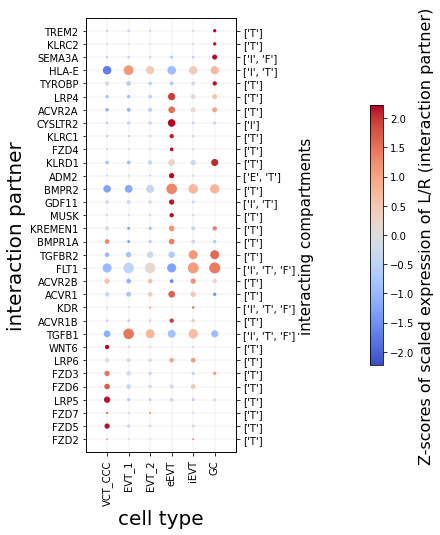

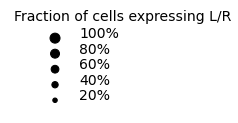

In [299]:
plot_dotplot_complex('complex_fetus', pdf_save_name='20220206_fetus_complex_interactions_zscores_selected')

In [300]:
MEs

['ME_1_early_inv_column',
 'ME_2_inv_front',
 'ME_3_artery_remodelling',
 'ME_4_fusion']

In [301]:
# below are cells to help mark special cases - Jarrod's interactions or CS-validated interactions


In [304]:
df_manual_annotation_per_ME.keys()

dict_keys(['complex'])

In [302]:
# below are cells to help mark special cases - Jarrod's interactions or CS-validated interactions
for ME in MEs:
    print(ME)
    print(df_manual_annotation_per_ME['simple']['fetus'][ME][df_manual_annotation_per_ME['simple']['fetus'][ME]['comments'] != 'nan'])


ME_1_early_inv_column


KeyError: 'simple'

In [932]:
for ME in MEs:
    print(ME)
    print(df_manual_annotation_per_ME['complex']['fetus'][ME][df_manual_annotation_per_ME['complex']['fetus'][ME]['comments'] != 'nan'])


ME_1_early_inv_column
Empty DataFrame
Columns: [index, interacting_pair, partners_in_troph, partners_in_troph_expr_where, partners_other, partners_other_expr_where, direction_of_interaction, is_integrin, comments, taking_or_not, taking_as(doesnt_matter_so_much), extra_comments, major_compartments_here, is_ECM_interaction]
Index: []
ME_2_inv_front
    index         interacting_pair partners_in_troph  \
29    147  TGFB1_TGFbeta_receptor1         ['TGFB1']   

   partners_in_troph_expr_where        partners_other  \
29   ['EVT_1', 'EVT_2', 'iEVT']  ['TGFBR1', 'TGFBR2']   

        partners_other_expr_where direction_of_interaction  is_integrin  \
29  ['GC', 'iEVT', 'dM2', 'uSMC']              (M+F)-(M+F)        False   

                              comments taking_or_not  \
29  CellSign_GC_eEVT_TGFbeta_receptor1           yes   

            taking_as(doesnt_matter_so_much)  extra_comments  \
29  EVT_2_iEVT_and_iEVT,iEVT_and_GC_dM2_uSMC             NaN   

   major_compartments_here  is

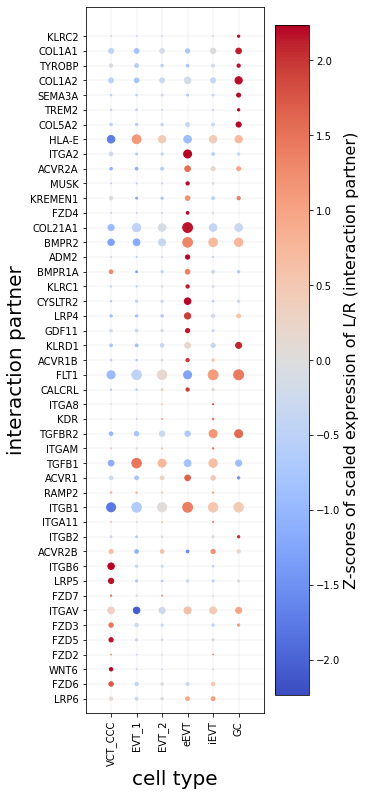

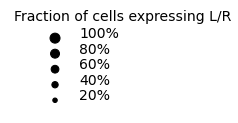

In [306]:
plot_dotplot_complex('complex_fetus', pdf_save_name='20211208_fetus_complex_interactions_zscores_selected')

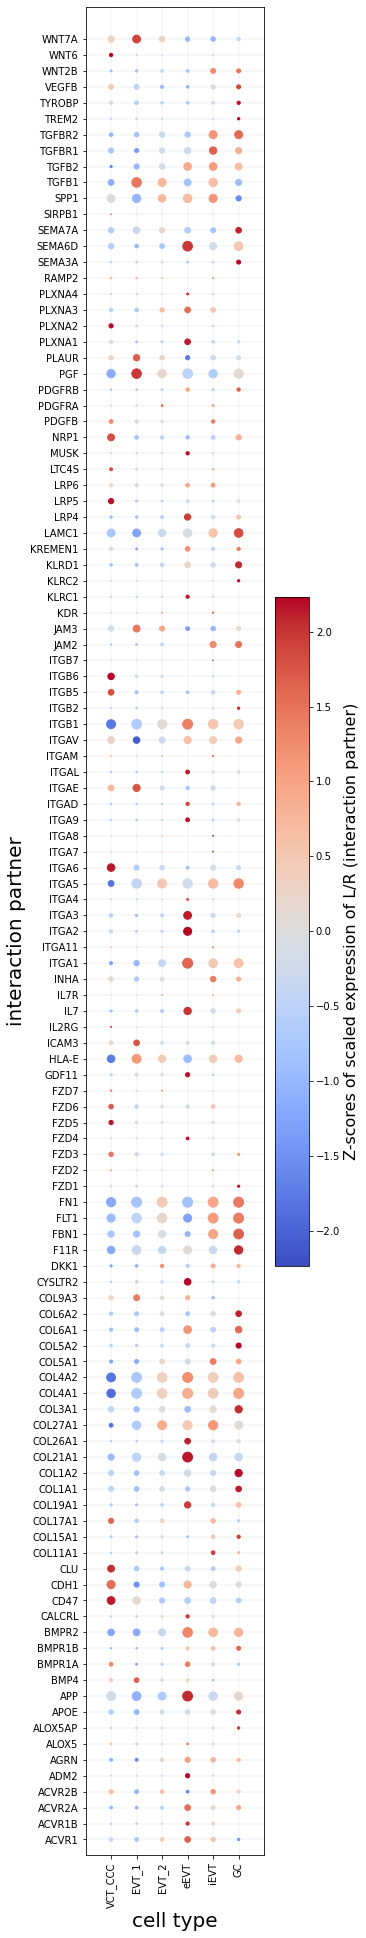

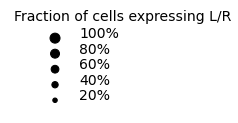

In [138]:
plot_dotplot_complex('complex_fetus', pdf_save_name='20211202_fetus_complex_interactions_zscores_all')

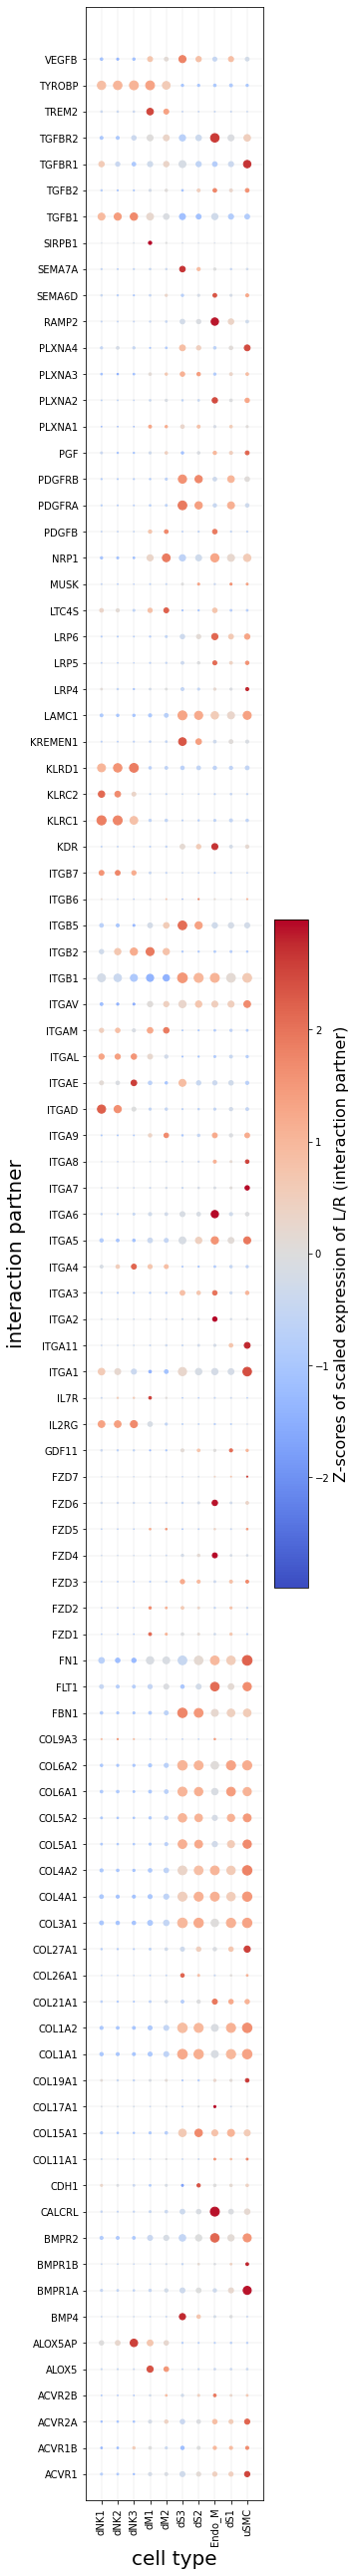

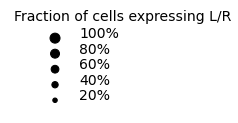

In [139]:
plot_dotplot_complex('complex_mother', pdf_save_name='20211202_mother_complex_interactions_zscores_all')

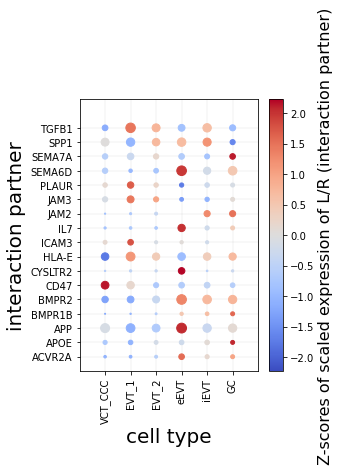

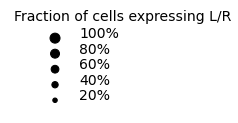

In [127]:
plot_dotplot_complex('complex_fetus', pdf_save_name='20211201_fetus_complex_interactions_zscores_selected')

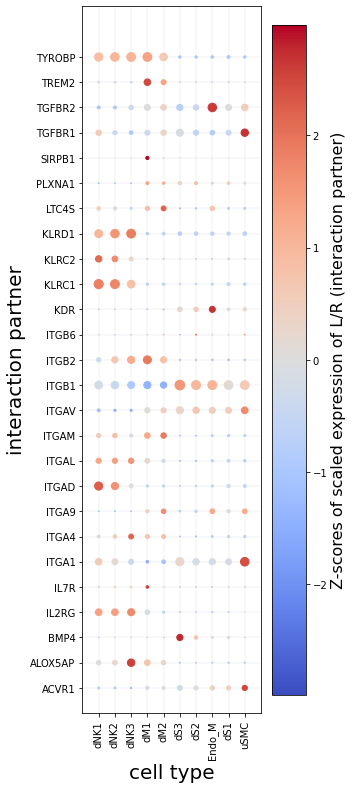

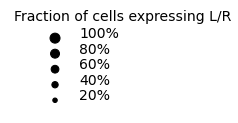

In [128]:
plot_dotplot_complex('complex_mother', pdf_save_name='20211201_mother_complex_interactions_zscores_selected')

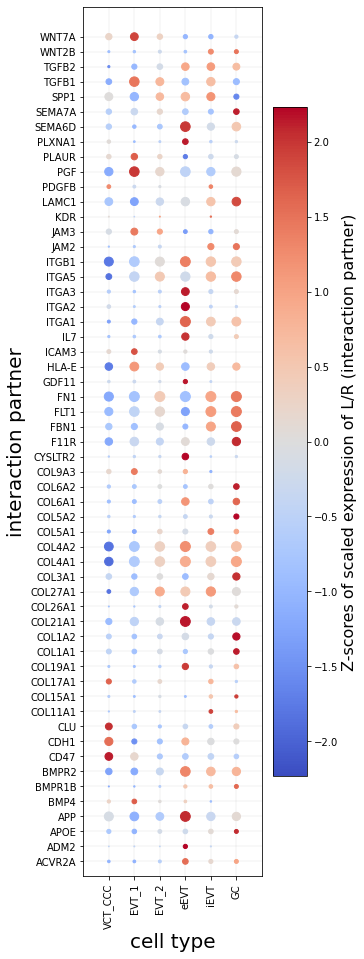

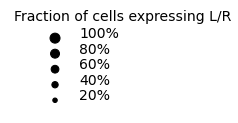

In [573]:
plot_dotplot_complex('complex_fetus', pdf_save_name='20211128_fetus_complex_interactions_zscores')

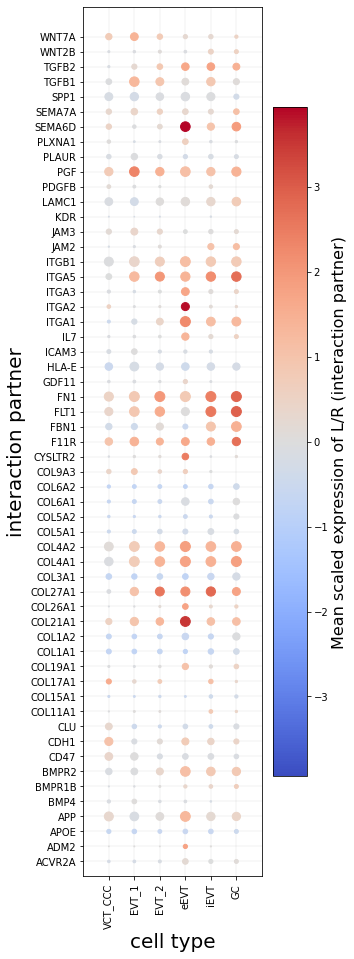

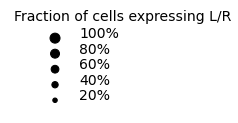

In [538]:
plot_dotplot_complex('complex_fetus', pdf_save_name='20211128_fetus_complex_interactions')

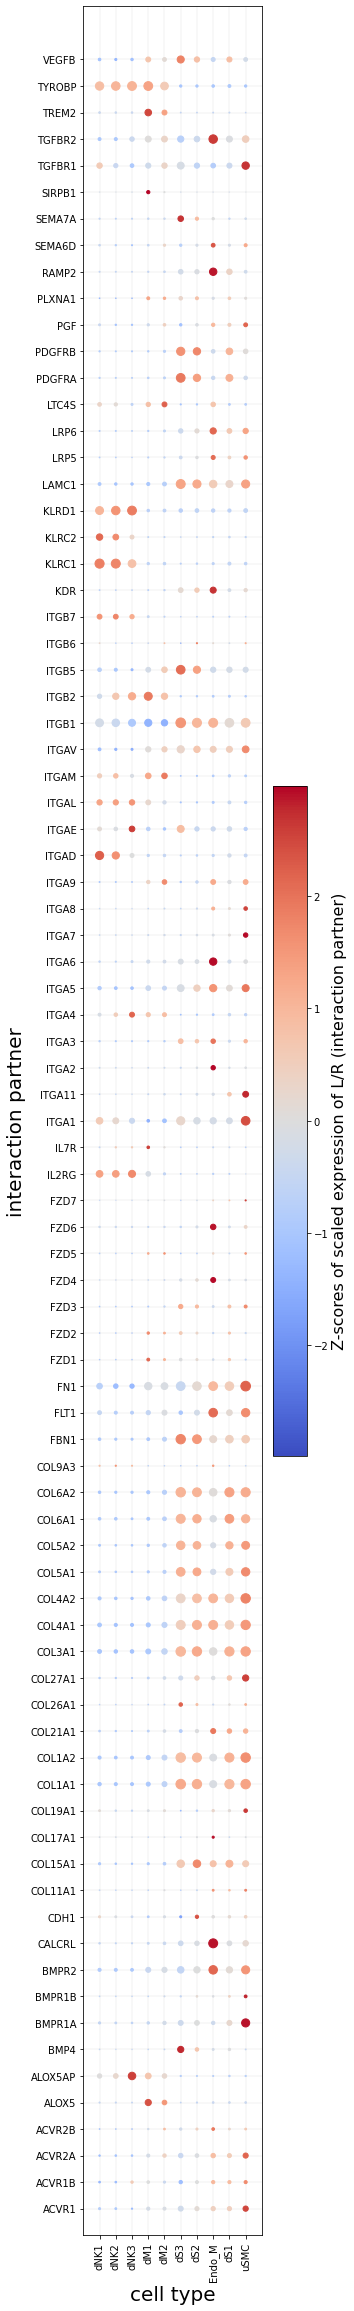

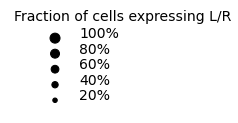

In [574]:
plot_dotplot_complex('complex_mother', pdf_save_name='20211128_mother_complex_interactions_zscores')

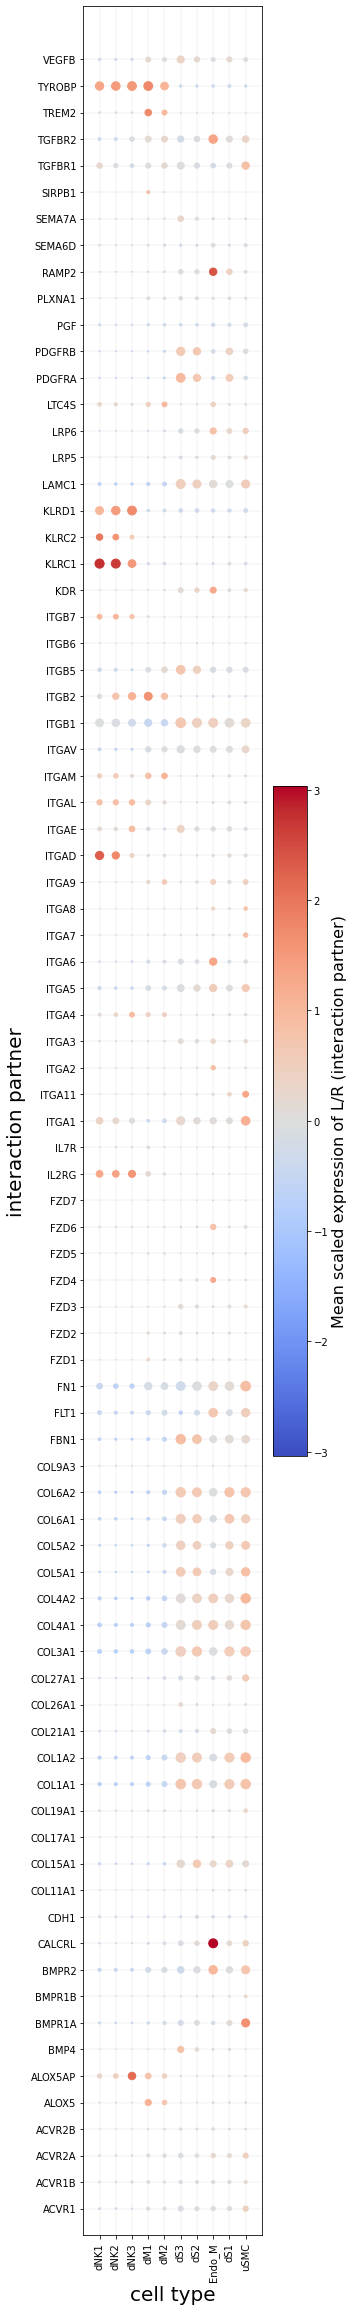

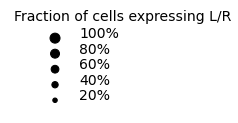

In [539]:
plot_dotplot_complex('complex_mother', pdf_save_name='20211128_mother_complex_interactions')

### Separating L/R by whether they are involved in ECM interactions or not

In [788]:
# read in interactions table from cellphone output to gather 'is_integrin' labels for all interactions here
interactions = pd.read_csv('./out_20211124_threshold_0.1/relevant_interactions.txt', sep='\t')
interactions.set_index('interacting_pair', inplace=True)

In [789]:
ECM_interactions = list(set(interactions[interactions['is_integrin'] == True].index))
len(ECM_interactions)

152

In [790]:
MEs

['ME_1_early_inv_column',
 'ME_2_inv_front',
 'ME_3_artery_remodelling',
 'ME_4_fusion']

In [792]:
# how many ECM interactions do we see in each ME in the complex tables?

partners_in_troph_in_ME_complex_ECM = {}

for ME in MEs:
    print(ME)
    df_manual_annotation_per_ME['complex']['fetus'][ME]['is_ECM_interaction'] = [True if df_manual_annotation_per_ME['complex']['fetus'][ME].loc[idx,'interacting_pair'] in ECM_interactions else False for idx in df_manual_annotation_per_ME['complex']['fetus'][ME].index]
    # is this column the same as 'is_integrin'? yes
    #print(np.unique(df_manual_annotation_per_ME['complex']['fetus'][ME]['is_ECM_interaction'] == df_manual_annotation_per_ME['complex']['fetus'][ME]['is_integrin']))
    curr_ECM_interactions_subtable = df_manual_annotation_per_ME['complex']['fetus'][ME][(df_manual_annotation_per_ME['complex']['fetus'][ME]['is_ECM_interaction'] == True)
                                                                                        & (df_manual_annotation_per_ME['complex']['fetus'][ME]['taking_or_not'] == 'yes')
                                                                                         # & valid interaction partner compartments in terms of defined MEs
                                                                                        & (df_manual_annotation_per_ME['complex']['fetus'][ME]['major_compartments_here'] != 'set()')]
    #print(curr_ECM_interactions_subtable)
    partners_in_troph_in_ME_complex_ECM[ME] = list(curr_ECM_interactions_subtable['partners_in_troph'])
    print('\n')
    
    

ME_1_early_inv_column


ME_2_inv_front


ME_3_artery_remodelling


ME_4_fusion




In [793]:
partners_in_troph_in_ME_complex_ECM['ME_1_early_inv_column']

["['ITGB6', 'ITGAV']"]

In [794]:
partners_in_troph_in_ME_complex_ECM['ME_2_inv_front']

["['ITGA11', 'ITGB1']",
 "['ITGA11', 'ITGB1']",
 "['ITGA11', 'ITGB1']",
 "['ITGA11', 'ITGB1']",
 "['ITGA11', 'ITGB1']",
 "['ITGA11', 'ITGB1']",
 "['ITGA11', 'ITGB1']",
 "['ITGA11', 'ITGB1']",
 "['ITGA11', 'ITGB1']",
 "['ITGA11', 'ITGB1']",
 "['ITGA11', 'ITGB1']",
 "['ITGB1', 'ITGA8']",
 "['ITGB2', 'ITGAM']",
 "['TGFB1']"]

In [795]:
partners_in_troph_in_ME_complex_ECM['ME_3_artery_remodelling']

["['ITGB1', 'ITGA2']",
 "['ITGB1', 'ITGA2']",
 "['ITGB1', 'ITGA2']",
 "['ITGB1', 'ITGA2']",
 "['ITGB1', 'ITGA2']",
 "['ITGB1', 'ITGA2']",
 "['ITGB1', 'ITGA2']",
 "['COL21A1']",
 "['COL21A1']",
 "['COL21A1']",
 "['ITGB1', 'ITGA2']",
 "['ITGB1', 'ITGA2']",
 "['ITGB1', 'ITGA2']",
 "['ITGB1', 'ITGA2']",
 "['ITGB1', 'ITGA2']",
 "['ITGB1', 'ITGA2']",
 "['ITGB1', 'ITGA2']",
 "['ITGB1', 'ITGA2']",
 "['ITGB1', 'ITGA2']",
 "['ITGB1', 'ITGA2']",
 "['ITGB1', 'ITGA2']",
 "['ITGB1', 'ITGA2']",
 "['ITGB1', 'ITGA2']"]

In [796]:
partners_in_troph_in_ME_complex_ECM['ME_4_fusion']

["['COL1A1']",
 "['COL1A1']",
 "['COL1A2']",
 "['COL1A2']",
 "['COL5A2']",
 "['COL5A2']"]

In [797]:
# lists of genes
partners_in_troph_in_ME_lists_complex_ECM = {}

partners_in_troph_in_ME_lists_complex_ECM['ME_1_early_inv_column'] = list(set(['ITGB6', 'ITGAV']))
partners_in_troph_in_ME_lists_complex_ECM['ME_2_inv_front'] = list(set(['ITGA11', 'ITGB1','ITGB1', 'ITGA8','ITGB2', 'ITGAM','TGFB1']))
partners_in_troph_in_ME_lists_complex_ECM['ME_3_artery_remodelling'] = list(set(['ITGB1', 'ITGA2','COL21A1']))
partners_in_troph_in_ME_lists_complex_ECM['ME_4_fusion'] = list(set(['COL1A1','COL1A1','COL1A2','COL1A2','COL5A2','COL5A2']))


In [798]:
all_genes_to_visualise_complex_ECM = partners_in_troph_in_ME_lists_complex_ECM['ME_1_early_inv_column'] + partners_in_troph_in_ME_lists_complex_ECM['ME_2_inv_front'] + partners_in_troph_in_ME_lists_complex_ECM['ME_3_artery_remodelling'] + partners_in_troph_in_ME_lists_complex_ECM['ME_4_fusion']
len(all_genes_to_visualise_complex_ECM)


14

In [799]:
all_genes_to_visualise_complex_ECM

['ITGB6',
 'ITGAV',
 'TGFB1',
 'ITGA11',
 'ITGB2',
 'ITGB1',
 'ITGAM',
 'ITGA8',
 'ITGB1',
 'COL21A1',
 'ITGA2',
 'COL1A2',
 'COL5A2',
 'COL1A1']

In [800]:
all_compartments_to_visualise_complex_clean[all_genes_to_visualise_complex_clean.index('ITGB1')]

"['T', 'T', 'T', 'I', 'E', 'F']"

In [801]:
all_genes_to_visualise_complex_clean

['FZD2',
 'FZD5',
 'FZD7',
 'LRP5',
 'FZD6',
 'ITGB6',
 'ITGAV',
 'FZD3',
 'LRP6',
 'WNT6',
 'TGFB1',
 'ACVR1B',
 'KDR',
 'ITGA11',
 'ITGB2',
 'ITGB1',
 'ACVR1',
 'ACVR2B',
 'FLT1',
 'ITGAM',
 'TGFBR2',
 'ITGA8',
 'BMPR1A',
 'KREMEN1',
 'MUSK',
 'GDF11',
 'BMPR2',
 'ADM2',
 'KLRD1',
 'FZD4',
 'KLRC1',
 'CYSLTR2',
 'COL21A1',
 'ITGA2',
 'ACVR2A',
 'LRP4',
 'COL1A2',
 'TYROBP',
 'HLA-E',
 'SEMA3A',
 'KLRC2',
 'COL5A2',
 'COL1A1',
 'TREM2']

In [802]:
# transfer from all_compartments_to_visualise_complex_clean
all_compartments_to_visualise_complex_ECM = [all_compartments_to_visualise_complex_clean[all_genes_to_visualise_complex_clean.index(gene)] for gene in all_genes_to_visualise_complex_ECM]
len(all_compartments_to_visualise_complex_ECM)

14

In [803]:
all_compartments_to_visualise_complex_ECM

["['T']",
 "['T']",
 "['T', 'I', 'F']",
 "['T']",
 "['T']",
 "['T', 'T', 'T', 'I', 'E', 'F']",
 "['T']",
 "['T']",
 "['T', 'T', 'T', 'I', 'E', 'F']",
 "['T', 'E', 'F']",
 "['T', 'I', 'E', 'F']",
 "['T', 'F']",
 "['T', 'F']",
 "['T', 'F']"]

In [804]:
all_compartments_to_visualise_complex_ECM = [str(i) for i in all_compartments_to_visualise_complex_ECM]
all_compartments_to_visualise_complex_ECM

["['T']",
 "['T']",
 "['T', 'I', 'F']",
 "['T']",
 "['T']",
 "['T', 'T', 'T', 'I', 'E', 'F']",
 "['T']",
 "['T']",
 "['T', 'T', 'T', 'I', 'E', 'F']",
 "['T', 'E', 'F']",
 "['T', 'I', 'E', 'F']",
 "['T', 'F']",
 "['T', 'F']",
 "['T', 'F']"]

In [805]:
# subsetting to manually selected molecules, complex interactions

#dfs_for_plotting_expression['complex']['mother'] = dfs_for_plotting_expression['complex']['mother'].loc[:,manually_selected_LR_complex['mother']]
dfs_for_plotting_expression['complex']['fetus'] = dfs_for_plotting_expression['complex']['fetus'].loc[:,all_genes_to_visualise_complex_ECM]

#dfs_for_plotting_per['complex']['mother'] = dfs_for_plotting_per['complex']['mother'].loc[:,manually_selected_LR_complex['mother']]
dfs_for_plotting_per['complex']['fetus'] = dfs_for_plotting_per['complex']['fetus'].loc[:,all_genes_to_visualise_complex_ECM]


In [806]:
dfs_for_plotting_expression['complex']['fetus']

ITGB6     ITGAV     TGFB1    ITGA11     ITGB2     ITGB1     ITGAM  \
VCT_CCC  2.230393  0.282962 -1.138175  0.565802 -0.313048 -1.774827  0.365788   
EVT_1   -0.376466 -2.064488  1.467219 -0.219036 -0.602594 -0.654526  0.082804   
EVT_2   -0.357365 -0.283848  0.765356   0.70985 -0.113599  0.062068  0.700513   
eEVT    -0.538316  0.621238 -0.833528  -1.24251 -1.132833  1.392787 -1.289353   
iEVT     -0.41993  0.449532  0.656095  1.428405  0.104977  0.526331  1.429601   
GC      -0.538316  0.994604 -0.916966  -1.24251  2.057097  0.448167 -1.289353   

            ITGA8     ITGB1   COL21A1     ITGA2    COL1A2    COL5A2    COL1A1  
VCT_CCC -0.646505 -1.774827 -0.933951 -0.197617 -0.517414 -0.517312 -0.437071  
EVT_1   -0.064444 -0.654526 -0.461819  -0.61506 -0.819963 -0.650983 -0.827465  
EVT_2    0.652886  0.062068 -0.108946 -0.534755 -0.323609 -0.369059 -0.132758  
eEVT    -0.907153  1.392787  2.164186  2.216771 -0.153618 -0.379277  -0.71646  
iEVT     1.872369  0.526331 -0.356537  -0.48334 -0.374342 -0.304977 -0.029251  
GC      -0.907153  0.448167 -0.302933 -0.385999  2.188947  2.221608  2.143006

In [807]:
# trying to plot complex interactions



In [808]:
dotplot_x_complex_fetus = [[i+1]*len(dfs_for_plotting_expression['complex']['fetus'].columns) for i in range(len(dfs_for_plotting_expression['complex']['fetus'].index))]

dotplot_x_complex_mother = [[i+1]*len(dfs_for_plotting_expression['complex']['mother'].columns) for i in range(len(dfs_for_plotting_expression['complex']['mother'].index))]

In [809]:
len(dotplot_x_complex_fetus[0])

14

In [810]:
dotplot_y_complex_fetus = [[i for i in range(len(dfs_for_plotting_expression['complex']['fetus'].columns))] for i in range(len(dfs_for_plotting_expression['complex']['fetus'].index))]
dotplot_y_complex_fetus = [item for sublist in dotplot_y_complex_fetus for item in sublist]
dotplot_y_complex_mother = [[i for i in range(len(dfs_for_plotting_expression['complex']['mother'].columns))] for i in range(len(dfs_for_plotting_expression['complex']['mother'].index))]
dotplot_y_complex_mother = [item for sublist in dotplot_y_complex_mother for item in sublist]


In [811]:
len(dotplot_y_complex_fetus)

84

In [812]:
# scaled expression, z-scores
colors_complex_fetus = []

for ct_fetus in dfs_for_plotting_expression['complex']['fetus'].index:
    colors_complex_fetus.append(list(dfs_for_plotting_expression['complex']['fetus'].loc[ct_fetus, :]))
colors_complex_fetus = [item for sublist in colors_complex_fetus for item in sublist]

colors_complex_mother = []

for ct_mother in dfs_for_plotting_expression['complex']['mother'].index:
    colors_complex_mother.append(list(dfs_for_plotting_expression['complex']['mother'].loc[ct_mother, :]))
colors_complex_mother = [item for sublist in colors_complex_mother for item in sublist]


In [813]:
len(colors_complex_fetus)

84

In [814]:
# percentage of cells from cluster expressing gene
sizes_complex_fetus = []
sizes_complex_mother = []

for ct_fetus in dfs_for_plotting_per['complex']['fetus'].index:
    sizes_complex_fetus.append(list(dfs_for_plotting_per['complex']['fetus'].loc[ct_fetus, :]))
sizes_complex_fetus = [item for sublist in sizes_complex_fetus for item in sublist]

sizes_complex_mother = []

for ct_mother in dfs_for_plotting_per['complex']['mother'].index:
    sizes_complex_mother.append(list(dfs_for_plotting_per['complex']['mother'].loc[ct_mother, :]))
sizes_complex_mother = [item for sublist in sizes_complex_mother for item in sublist]


In [815]:
len(sizes_complex_fetus)

84

In [816]:
# % of cells expr in cluster
dot_sequence_int = [elem for elem in [0.2, 0.4, 0.6, 0.8, 1.0]]

In [817]:
# scaling the sizes_dict and dot_sequence_int so that dots are more visible
#dot_sequence_int = [elem * 100 for elem in dot_sequence_int]
dot_sequence_int

[0.2, 0.4, 0.6, 0.8, 1.0]

In [818]:
dfs_for_plotting_expression['complex']['fetus']

ITGB6     ITGAV     TGFB1    ITGA11     ITGB2     ITGB1     ITGAM  \
VCT_CCC  2.230393  0.282962 -1.138175  0.565802 -0.313048 -1.774827  0.365788   
EVT_1   -0.376466 -2.064488  1.467219 -0.219036 -0.602594 -0.654526  0.082804   
EVT_2   -0.357365 -0.283848  0.765356   0.70985 -0.113599  0.062068  0.700513   
eEVT    -0.538316  0.621238 -0.833528  -1.24251 -1.132833  1.392787 -1.289353   
iEVT     -0.41993  0.449532  0.656095  1.428405  0.104977  0.526331  1.429601   
GC      -0.538316  0.994604 -0.916966  -1.24251  2.057097  0.448167 -1.289353   

            ITGA8     ITGB1   COL21A1     ITGA2    COL1A2    COL5A2    COL1A1  
VCT_CCC -0.646505 -1.774827 -0.933951 -0.197617 -0.517414 -0.517312 -0.437071  
EVT_1   -0.064444 -0.654526 -0.461819  -0.61506 -0.819963 -0.650983 -0.827465  
EVT_2    0.652886  0.062068 -0.108946 -0.534755 -0.323609 -0.369059 -0.132758  
eEVT    -0.907153  1.392787  2.164186  2.216771 -0.153618 -0.379277  -0.71646  
iEVT     1.872369  0.526331 -0.356537  -0.48334 -0.374342 -0.304977 -0.029251  
GC      -0.907153  0.448167 -0.302933 -0.385999  2.188947  2.221608  2.143006

In [819]:
# update colors

# scaled expression, z-scores per gene
colors_complex_fetus = []

for ct_fetus in dfs_for_plotting_expression['complex']['fetus'].index:
    colors_complex_fetus.append(list(dfs_for_plotting_expression['complex']['fetus'].loc[ct_fetus, :]))
colors_complex_fetus = [item for sublist in colors_complex_fetus for item in sublist]

colors_complex_mother = []

for ct_mother in dfs_for_plotting_expression['complex']['mother'].index:
    colors_complex_mother.append(list(dfs_for_plotting_expression['complex']['mother'].loc[ct_mother, :]))
colors_complex_mother = [item for sublist in colors_complex_mother for item in sublist]




In [822]:
def plot_dotplot_complex(mode, pdf_save_name):
    
    if mode == 'complex_fetus':
        x = dotplot_x_complex_fetus # factors (1 for now)
        y = dotplot_y_complex_fetus # cell2location cell types

        colors = colors_complex_fetus  # color of points
        sizes = sizes_complex_fetus # size of points

        curr_genes = list(dfs_for_plotting_expression['complex']['fetus'].columns)  
        curr_cell_types = list(dfs_for_plotting_expression['complex']['fetus'].index)  
        
    elif mode == 'complex_mother':
        x = dotplot_x_complex_mother # factors (1 for now)
        y = dotplot_y_complex_mother # cell2location cell types

        colors = colors_complex_mother  # color of points
        sizes = sizes_complex_mother # size of points

        curr_genes = list(dfs_for_plotting_expression['complex']['mother'].columns)  
        curr_cell_types = list(dfs_for_plotting_expression['complex']['mother'].index)  
    
    else:
        print('unknown mode, can only deal with complex_fetus OR complex_mother')
    
    from mpl_toolkits.axes_grid1.inset_locator import inset_axes
    
    # to make the dots more visible
    sizes = [elem*100 for elem in sizes]
    # % of cells expr in cluster
    dot_sequence_int = [elem*100 for elem in [0.2, 0.4, 0.6, 0.8, 1.0]]
    
    fig1 = plt.figure(figsize=[6, int(len(y) / 23)])
    ax1 = plt.subplot(111)

    #plt.title('|\u0394''(Normalised AUC score)| between CVID and control',fontsize=16)

    colors_lim_abs = max(abs(max(colors)), abs(min(colors)))
    
    #print('colors_lim_abs', colors_lim_abs)

    im1 = ax1.scatter(x, y, c=colors, s=sizes, cmap='coolwarm', 
                      #vmin = -colors_lim_abs, 
                      #vmax = colors_lim_abs
                     )
    ax1.set_axisbelow(True)
    ax1.grid(color='grey', linestyle='-', linewidth=0.1)

    # Add a colorbar
    cbar = plt.colorbar(im1, ax=ax1, pad=0.4, shrink=0.6)
    #cbar = plt.clim(min(cisTopic_colors), -min(cisTopic_colors))

    cbar.set_label('Z-scores of scaled expression of L/R (interaction partner)',
                   fontsize=16)

    # set the color limits - not necessary here, but good to know how.
    im1.set_clim(-colors_lim_abs, colors_lim_abs)

    plt.xlabel('cell type',fontsize=20)
    plt.ylabel('interaction partner',fontsize=20)

    ytick_names = list(curr_genes)
    plt.yticks(y[:len(ytick_names)], ytick_names)
    xtick_names = list(curr_cell_types)
    plt.xticks([i + 1 for i in range(len(xtick_names))], xtick_names, rotation=90) # was [elem + 1 for elem in dotplot_x[ct_immune][:len(xtick_names)]] and didn't work

    #plt.tick_params(axis='x',labelsize=16, labelrotation=60)

    plt.xlim(0, len(xtick_names) + 1)
    plt.ylim(-1, len(ytick_names))
    
    ax_twin = ax1.twinx()
    #s2 = np.sin(2*np.pi*t)
    #ax2.plot(t, s2, 'r.')
    plt.ylabel('interacting compartments', color='black',fontsize=15)
    plt.yticks(y[:len(ytick_names)], all_compartments_to_visualise_complex_ECM)
    plt.ylim(-1, len(ytick_names))
    #print(y[:len(ytick_names)])
    #plt.show()


    fig2 = plt.figure(figsize=[3,2])
    ax2 = plt.subplot()

    x_dots = [1,1,1,1,1]
    y_dots = [0,1,2,3,4]

    im2 = ax2.scatter(x_dots, y_dots, c='black', s=dot_sequence_int, cmap='YlOrRd')

    plt.text(1.1,0,'20%',fontsize=14)
    plt.text(1.1,1,'40%',fontsize=14)
    plt.text(1.1,2,'60%',fontsize=14)
    plt.text(1.1,3,'80%',fontsize=14)
    plt.text(1.1,4,'100%',fontsize=14)

    plt.text(0.83, 5.1, 'Fraction of cells expressing L/R', fontsize=14)

    plt.axis('off')

    plt.xlim(0.8, 1.5)
    plt.ylim(-1, 6)

    #plt.show()



    import matplotlib.backends.backend_pdf
    pdf = matplotlib.backends.backend_pdf.PdfPages('./figures/' + pdf_save_name + '.pdf')
    for fig in [fig1, fig2]:
        pdf.savefig(fig, bbox_inches='tight')
    pdf.close()

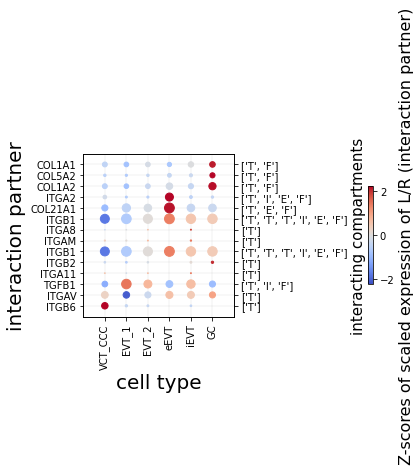

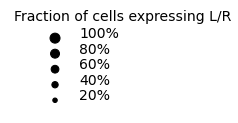

In [823]:
plot_dotplot_complex('complex_fetus', pdf_save_name='20211213_fetus_complex_interactions_zscores_selected_ECM')

In [1005]:
# 13.12.2021 manual selection of interactions (absolute top 10-15) based on pattern in space, Jarrod/CellSign evidence and recetor status
# this is complex and simple molecules for fetus side of signalling
selected_molecules_fetus = list([ # ME_2 
    'CXCR6', 'VSIR',  'DLL4', 'HLA-C', 'PTGFRN', 'BTN3A1',
'PLAUR', 'IL7R', 'PVR', 'WNT7A', 'DLL1', 'VLDLR', 'IGFBP3','TGFB1','RAMP2','CALCRL','ACVR1B','ACVR2B',
'KDR','FLT1','ACVR1','TGFBR2','TGFB1','ITGA11','ITGB1','ITGB2','ITGAM',
'ITGB1',
    'ITGA8',

    # ME_3
    'KIT', 'CSF1R', 'NCAM1','CD93',
'ANGPT4','DSG2','FLT4','FGFR3','ADGRE2','CCR1',
'JAG1','ADORA1','DSC2','NGFR','BMPR1A', 'BMPR2','ACVR2A','KLRD1','KLRC1',
'LRP6','FZD4','CYSLTR2','ITGB1',
    'ITGA2','COL21A1',
    # ME_4
    'EFNB1', 'CD200','HLA-G',
'HSD3B1','PILRA','HLA-E',
    'FLT1', 'ESR1','GP6',
'CXCR4','CYP19A1','LDLR','PDCD1LG2',
'ADORA2B','JAM2','FGFR1','PGR', 'TYROBP', 'TREM2','COL1A1','COL1A2','COL5A2'])

In [1006]:
len(selected_molecules_fetus)

76

In [1007]:
len(set(selected_molecules_fetus))

72

In [1008]:
len(set(selected_molecules_fetus) & set(dfs_for_plotting_expression['simple']['fetus'].columns))

72

In [1009]:
# 13.12.2021 manual selection of interactions (absolute top 10-15) based on pattern in space, Jarrod/CellSign evidence and recetor status
# this is complex and simple molecules for mother+fetus side of signalling (other side from just fetus)
selected_molecules_mother_fetus = list([ # ME_2 
    'CXCL16', # for CXR6
'HLA-E','HLA-F', # for VSIR
'NOTCH1', 'NOTCH2', # for DLL4
'KIR2DL1', 'KIR2DL3', # for HLA-C
'MCAM', # for PTGFRN
'CSF1R', # for BTN3A1
'PLAU', #  for PLAUR
'FGFR3', # for IL7R
'CD226', 'CD96', 'NECTIN3', 'TIGIT', # for PVR
'FRZB', 'SFRP1', 'SFRP4', # for WNT7A
'NOTCH1', 'NOTCH2', # for DLL1
'RELN', # for VLDLR
'TMEM219', # for IGFBP3
'TGFBR1', 'TGFBR2', 'ACVR1', 'ITGB6', 'ITGAV', # for TGFB1
'ADM2', # for RAMP2 and CALCRL that form a complex
'GDF11', 'INHA', # for ACVR2B and ACVR1B that form a complex
'PGF', 'VEGFB', # for FLT1 and KDR that form a complex
'INHA', # for ACVR1 and ACVR2B that form a complex
'TGFB1', 'TGFB2', # for TGFBR2 and ACVR1 that form a complex
'COL11A1', 'COL15A1', 'COL17A1', 'COL19A1', 'COL1A1', 'COL1A2', 'COL21A1', 'COL26A1', 'COL27A1', 'COL3A1', 'COL4A1', 'COL4A2', 'COL5A1', 'COL5A2', 'COL6A1', 'COL6A2', 'COL9A3', # for ITGA11 and ITGB1 that form a complex
'JAM3', # for ITGB2 and ITGAM that form a complex
'FN1', # for ITGB1 and ITGA8 that form a complex
    
    # ME_3
    'LDLR', # for KIT
'BTN3A1', 'CSF1', # for CSF1R
'AGRN', 'FGFR1', 'CNTNAP1', # for NCAM1
'IFNGR1', # for CD93
'TEK', # for ANGPT4
'DSC2', # for DSG2
'VEGFC', # for FLT4
'FGF1', 'FGF2', 'IL7R', # for FGFR3
'CD55', # for ADGRE2
'CCL3L1', 'CCL3', 'CCL5', 'CCL14', 'CCL26', 'CCL7', 'CCL8', # for CCR1
'CD46', 'NOTCH1', 'NOTCH2', 'NOTCH3', 'VASN', # for JAG1
'ENTPD1', # for ADORA1
'DSG2', # for DSC2
'CD80', # for NGFR
'BMP4', # for BMPR1A and BMPR2 that form a complex; for BMPR1A and ACVR2A that form a complex
'HLA-E', # for KLRD1 and KLRC1 that form a complex
'WNT2B','WNT6','WNT7A', # for LRP6 and FZD4 that form a complex
'ALOX5', 'ALOX5AP','LTC4S', # for CYSLTR2
'CDH1', 'COL11A1', 'COL15A1', 'COL17A1', 'COL19A1', 'COL1A1', 'COL1A2', 'COL21A1', 'COL26A1', 'COL27A1', 'COL3A1', 'COL4A1', 'COL4A2', 'COL5A1', 'COL5A2', 'COL6A1', 'COL6A2','COL9A3', 'FN1', 'LAMC1', # for ITGB1 and ITGA2 that form a complex
'ITGA1', 'ITGA2', 'ITGB1', 'ITGA11', # for COL21A1
    # ME_4
    'EPHA2', 'EPHA4','EPHB1','EPHB2','EPHB4','EPHB6', # for EFNB1
'CD200R1', # for CD200
'LILRB1', 'LILRB2', # for HLA-G
'PGR', # for HSD3B1
'IGFLR1', # for PILRA
'KLRC1', 'KLRC2', 'VSIR', # for HLA-E
'PGF', 'VEGFB', # for FLT1
'CYP19A1', 'HSD17B1', # for ESR1
'CD33', # for GP6
'CXCL12', 'CXCL14', # for CXCR4
'ESR1', 'ESR2', # for CYP19A1
'KIT', 'LIFR', # for LDLR
'PDCD1', # for PDCD1LG2
'ENTPD1', # for ADORA2B
'JAM3', # for JAM2
'FGF1', 'FGF2', 'NCAM1', 'PGF', # for FGFR1
'HSD3B1', # for PGR
'APOE', 'APP', 'CLU', # for TYROBP and TREM2 that form a complex
'ITGA1', 'ITGA2', 'ITGB1', 'ITGA11', # for COL1A1
'ITGA1', 'ITGA2', 'ITGB1', 'ITGA11', # for COL1A2
'ITGA1', 'ITGA2', 'ITGB1', 'ITGA11', # for COL5A2
])

In [1010]:
len(selected_molecules_mother_fetus)

163

In [1011]:
len(set(selected_molecules_mother_fetus))

120

In [1012]:
len(set(selected_molecules_mother_fetus) & set(all_LR_genes))

120

In [1013]:
set(selected_molecules_mother_fetus) - set(all_LR_genes)

set()

In [1029]:
# final tables to plot expression of selected molecules in
expr2plot = {}

expr2plot['fetus'] = pd.DataFrame(index = relevant_cell_types_fetus, columns=all_LR_genes)
expr2plot['fetus'] = expr2plot['fetus'].loc[:,selected_molecules_fetus]

expr2plot['mother_fetus'] = pd.DataFrame(index = relevant_cell_types_fetus + relevant_cell_types_mother, columns=all_LR_genes)
expr2plot['mother_fetus'] = expr2plot['mother_fetus'].loc[:,selected_molecules_mother_fetus]

In [1016]:
df_expr_scaled

PRL    LILRA4      NTF3      FZD6      CHAT     NCAM1    COL5A1  \
dNK1    -0.258398 -0.033718 -0.074207 -0.160648 -0.050394  1.866867 -0.529961   
dNK2    -0.267571 -0.031349 -0.074583 -0.171123 -0.054557  1.589170 -0.548226   
dNK3    -0.265895 -0.036172 -0.088918 -0.179524 -0.056168  0.798087 -0.546045   
dM1     -0.267764  0.063841 -0.081846 -0.203269 -0.054922 -0.264407 -0.524881   
dM2     -0.245964 -0.015098 -0.083974 -0.178249 -0.048881 -0.185515 -0.419532   
dS3      2.538679 -0.035254 -0.094370 -0.230076 -0.054777 -0.366881  0.569856   
dS2      0.520462 -0.035825 -0.048880 -0.123249 -0.050829 -0.250846  0.624409   
Endo_M  -0.115103 -0.034169 -0.071141  0.784574 -0.053245 -0.131675 -0.179910   
dS1     -0.164611 -0.034186 -0.067447 -0.137387 -0.049562  0.220375  0.281722   
uSMC    -0.281700 -0.032638 -0.047763  0.042968 -0.042671  0.830423  0.868051   
VCT_CCC -0.316002 -0.036172 -0.091864  0.196142 -0.047011 -0.293318 -0.486572   
EVT_1   -0.313914 -0.035598 -0.091726 -0.098564 -0.054436 -0.330483 -0.479110   
EVT_2   -0.278917 -0.036172 -0.091943 -0.041888 -0.050475 -0.245646 -0.295837   
eEVT    -0.323803 -0.036172 -0.099181 -0.067200 -0.056168  4.631297 -0.343068   
iEVT    -0.284689 -0.036172 -0.086112  0.033061 -0.036954 -0.259675 -0.141073   
GC      -0.323803 -0.036172 -0.099182 -0.260271 -0.056168 -0.273220 -0.194995   

           IFNGR1      BST2      LIFR  ...     ACKR3   TMEM219   RARRES2  \
dNK1    -0.364441  0.707751 -0.390407  ... -0.156974  0.013770 -0.366455   
dNK2    -0.379640  1.018503 -0.453429  ... -0.165895 -0.018311 -0.377269   
dNK3    -0.248035  1.087880 -0.477209  ... -0.148157 -0.085436 -0.377555   
dM1      0.545554  0.880613 -0.388955  ... -0.054231  0.320281 -0.359630   
dM2      0.265185  0.544135 -0.217190  ... -0.097001 -0.049424 -0.320680   
dS3      0.151323 -0.399995 -0.461228  ... -0.117320  0.764414 -0.257414   
dS2     -0.007864 -0.335105 -0.306395  ...  0.068975  0.052505  0.107437   
Endo_M   0.013223  1.000438  0.299789  ...  1.531651  0.130015 -0.185977   
dS1     -0.049178 -0.237845 -0.178673  ... -0.004409  0.012278  0.881683   
uSMC    -0.215566 -0.354309  0.305400  ...  0.141859 -0.390674 -0.018551   
VCT_CCC -0.009221 -0.339626 -0.051106  ... -0.140964  0.013075 -0.365444   
EVT_1    0.043165 -0.139987  0.087238  ... -0.153827  0.668343 -0.376947   
EVT_2   -0.077358 -0.135363  0.684917  ... -0.129589  0.064943 -0.366775   
eEVT     0.118232 -0.334502  3.001366  ...  1.977354 -0.466414 -0.396220   
iEVT     0.029977  0.085326  1.253068  ... -0.104028  0.052345 -0.358356   
GC       0.339584  0.072557  1.805354  ... -0.183969 -0.477138 -0.396220   

           TGFBR2    CCL3L1      RBP4    PLXNA3      NRP2      LRP4     ITGA8  
dNK1    -0.357415  0.116580  0.002803 -0.167294 -0.374104 -0.018690 -0.111348  
dNK2    -0.336963  0.084544 -0.008598 -0.192467 -0.382751 -0.077448 -0.113378  
dNK3    -0.072740  0.582594 -0.037128 -0.167288 -0.391191 -0.117368 -0.119718  
dM1      0.123744  1.519552 -0.082961 -0.076563  0.443475 -0.049435 -0.105204  
dM2      0.269784  1.100267 -0.086779 -0.037530  0.640308 -0.028397 -0.070763  
dS3     -0.232136 -0.198598  0.248287 -0.007007 -0.417599 -0.072669 -0.116444  
dS2     -0.059231 -0.174463  0.133399  0.017838 -0.303059 -0.072624 -0.050322  
Endo_M   1.343818 -0.203905 -0.102728 -0.147494  0.079732 -0.010922  0.365639  
dS1      0.088003 -0.185247 -0.076452 -0.061679 -0.066910 -0.034777  0.101140  
uSMC     0.351533 -0.222779 -0.174548 -0.022905  0.885466  0.200062  0.755944  
VCT_CCC -0.366340 -0.210163 -0.191060 -0.032125 -0.119126 -0.007304 -0.125349  
EVT_1   -0.225882 -0.214382  0.086398 -0.079496 -0.402151 -0.021263 -0.116484  
EVT_2    0.132097 -0.212463 -0.076315  0.251473 -0.375898  0.078551 -0.105559  
eEVT    -0.147745 -0.229291 -0.142039  0.480622 -0.390136  0.952138 -0.129319  
iEVT     1.095164 -0.215584 -0.159276  0.210299 -0.371877  0.241561 -0.086985  
GC       1.394985 -0.229291 -0.231356 -0.291249 -0.309425  0.47

In [1053]:
# filling in NaN values with values from df_expr_scaled since there are purposeful gene repeptitions here
for col in expr2plot['fetus'].columns:
    #print(col)
    curr_subtable = expr2plot['fetus'].loc[:,col]
    #print(curr_subtable.shape)
    if len(curr_subtable.shape) > 1 and curr_subtable.shape[1] > 1:
        #print('in if')
        df2add = pd.DataFrame(index=expr2plot['fetus'].index)
        for i in range(curr_subtable.shape[1]):
            df2add.loc[:,col] = scipy.stats.zscore(df_expr_scaled.loc[expr2plot['fetus'].index, col])
        expr2plot['fetus'].loc[:,col] = df2add
    else:
        expr2plot['fetus'].loc[:,col] = scipy.stats.zscore(df_expr_scaled.loc[expr2plot['fetus'].index, col])

In [1054]:
expr2plot['fetus']

CXCR6      VSIR      DLL4     HLA-C    PTGFRN    BTN3A1     PLAUR  \
VCT_CCC  -0.83995  0.119048  1.269827 -0.810581 -0.208476  1.362271  0.143538   
EVT_1    1.941909  1.950397  0.099995  1.880747 -0.212483  0.706343  1.690219   
EVT_2   -0.004657  0.061413  0.346996  0.448765  0.765382  0.464137  0.253467   
eEVT    -1.103749 -1.204458 -1.311038 -1.214341 -1.053427 -1.308219 -1.727704   
iEVT     0.393843 -0.849321  0.905258  0.051846  1.762431  0.083687 -0.245805   
GC      -0.387396 -0.077079 -1.311038 -0.356436 -1.053427 -1.308219 -0.113715   

             IL7R       PVR     WNT7A  ...  PDCD1LG2   ADORA2B      JAM2  \
VCT_CCC  -0.00373 -0.955361  0.233037  ... -1.361363 -0.580099 -0.828497   
EVT_1   -0.449349 -0.220223  1.892765  ... -0.584787 -1.083869 -0.686758   
EVT_2    1.359018  0.237573  0.305711  ... -0.394862 -0.691316 -0.349975   
eEVT    -1.084872 -0.130582 -1.004449  ... -0.092397 -0.415283 -0.913833   
iEVT     1.263814  2.016583 -1.061744  ...  0.633815  1.372754  1.282787   
GC      -1.084882 -0.947991 -0.365319  ...  1.799594  1.397813  1.496276   

            FGFR1       PGR    TYROBP     TREM2    COL1A1    COL1A2    COL5A2  
VCT_CCC -1.259652 -0.651136 -0.105882 -0.324281 -0.437071 -0.517414 -0.517312  
EVT_1   -0.652036 -0.675379 -0.589533 -0.339821 -0.827465 -0.819963 -0.650983  
EVT_2    0.326991 -0.376325   -0.5641 -0.425861 -0.132758 -0.323609 -0.369059  
eEVT    -0.831908 -0.085593 -0.721187 -0.638564  -0.71646 -0.153618 -0.379277  
iEVT     1.575144 -0.404186 -0.201565  -0.49521 -0.029251 -0.374342 -0.304977  
GC        0.84146  2.192618  2.182267  2.223738  2.143006  2.188947  2.221608  

[6 rows x 76 columns]

In [1055]:
# filling in NaN values with values from df_expr_scaled since there are purposeful gene repeptitions here
for col in expr2plot['mother_fetus'].columns:
    #print(col)
    curr_subtable = expr2plot['mother_fetus'].loc[:,col]
    #print(curr_subtable.shape)
    if len(curr_subtable.shape) > 1 and curr_subtable.shape[1] > 1:
        #print('in if')
        df2add = pd.DataFrame(index=expr2plot['mother_fetus'].index)
        for i in range(curr_subtable.shape[1]):
            df2add.loc[:,col] = scipy.stats.zscore(df_expr_scaled.loc[expr2plot['mother_fetus'].index, col])
        expr2plot['mother_fetus'].loc[:,col] = df2add
    else:
        expr2plot['mother_fetus'].loc[:,col] = scipy.stats.zscore(df_expr_scaled.loc[expr2plot['mother_fetus'].index, col])

In [1056]:
expr2plot['mother_fetus']

CXCL16     HLA-E     HLA-F    NOTCH1    NOTCH2   KIR2DL1   KIR2DL3  \
VCT_CCC -0.260646 -1.222251 -1.229144 -0.078161 -0.633185 -0.445724 -0.433833   
EVT_1   -0.413306 -0.608373 -1.186635 -0.778769 -0.455622  -0.44503 -0.443208   
EVT_2   -0.400163 -0.759503 -1.098344 -0.724052  0.143538 -0.445123 -0.440657   
eEVT     -0.44469 -1.046528 -0.036792 -0.668899   3.46045 -0.454658 -0.452549   
iEVT    -0.368945  -0.76482  -1.00225   -0.8122  0.903678 -0.438643 -0.445724   
GC       -0.44469 -0.698772 -0.775553  -0.92757  0.766432 -0.454658 -0.452549   
dNK1    -0.298269  0.858935  1.048066  0.226892 -0.431604  2.973465  3.078963   
dNK2    -0.293528  1.357568  1.428534  0.277361 -0.455466  2.102751  1.952996   
dNK3    -0.340473  1.848477  2.044021  0.502198 -0.477468   0.54634  0.550074   
dM1      3.523137  1.039268  1.219798  0.299746 -0.224896 -0.406948 -0.399983   
dM2      1.355142  0.386674  0.018114   0.49904 -0.259867 -0.379763  -0.38867   
dS3     -0.355032   0.55491  0.538787 -0.701309 -0.663634 -0.450317 -0.447189   
dS2     -0.320868 -0.141979 -0.223157  -0.31118 -0.520738 -0.443284  -0.43899   
Endo_M  -0.297573  1.180554   0.47692  3.398503 -0.618071 -0.431037 -0.421925   
dS1     -0.260348 -0.505651 -0.339738 -0.007622  -0.35726 -0.396528 -0.388266   
uSMC    -0.379749  -1.47851 -0.882626 -0.193977 -0.176287 -0.430844 -0.428489   

             MCAM     CSF1R      PLAU  ...     ITGB1    ITGA11     ITGA1  \
VCT_CCC -0.786947 -0.264692  1.077182  ... -0.708516   -0.4052 -1.144452   
EVT_1   -0.263299   0.67779 -0.774926  ...  0.203899  -0.42041 -0.770934   
EVT_2    0.786007  0.876423 -0.932474  ...  0.787521 -0.402408  0.076225   
eEVT     1.549539  0.371827 -0.866092  ...  1.871309 -0.440246  2.627847   
iEVT     1.690827  0.117812 -0.953163  ...  1.165635 -0.388482  1.108368   
GC       2.087292 -0.370246 -0.726917  ...  1.101975 -0.440246  1.274522   
dNK1    -0.848801 -0.708994 -0.264018  ... -0.623562 -0.391221  0.025528   
dNK2    -0.914261 -0.705941 -0.388455  ... -0.783884 -0.410245 -0.195632   
dNK3    -0.905777 -0.725597 -0.738808  ... -1.196803   -0.4124 -0.556912   
dM1      -0.88671  1.897016  1.810931  ... -1.597684 -0.357372 -1.158488   
dM2     -0.760742  2.548491  1.964777  ... -1.622375 -0.187649  -0.95235   
dS3     -0.646726 -0.874389  1.458731  ...  0.824383 -0.379286 -0.161499   
dS2      -0.47908 -0.787448  0.444655  ...  0.397182 -0.086253  -0.40013   
Endo_M    0.60881 -0.735205 -0.720802  ...  0.439298  0.009353 -0.428953   
dS1     -0.495968 -0.660532  0.225935  ... -0.325819   1.12091  -0.42905   
uSMC     0.265836 -0.656315 -0.616555  ...  0.067444  3.591156  1.085912   

            ITGA2     ITGB1    ITGA11     ITGA1     ITGA2     ITGB1    ITGA11  
VCT_CCC  0.236792 -0.708516   -0.4052 -1.144452  0.236792 -0.708516   -0.4052  
EVT_1     -0.3665  0.203899  -0.42041 -0.770934   -0.3665  0.203899  -0.42041  
EVT_2   -0.250444  0.787521 -0.402408  0.076225 -0.250444  0.787521 -0.402408  
eEVT     3.726083  1.871309 -0.440246  2.627847  3.726083  1.871309 -0.440246  
iEVT    -0.176138  1.165635 -0.388482  1.108368 -0.176138  1.165635 -0.388482  
GC       -0.03546  1.101975 -0.440246  1.274522  -0.03546  1.101975 -0.440246  
dNK1    -0.416991 -0.623562 -0.391221  0.025528 -0.416991 -0.623562 -0.391221  
dNK2    -0.431951 -0.783884 -0.410245 -0.195632 -0.431951 -0.783884 -0.410245  
dNK3    -0.458157 -1.196803   -0.4124 -0.556912 -0.458157 -1.196803   -0.4124  
dM1     -0.435378 -1.597684 -0.357372 -1.158488 -0.435378 -1.597684 -0.357372  
dM2     -0.416806 -1.622375 -0.187649  -0.95235 -0.416806 -1.622375 -0.187649  
dS3     -0.451893  0.824383 -0.379286 -0.161499 -0.451893  0.824383 -0.379286  
dS2     -0.360622  0.397182 -0.086253  -0.40013 -0.360622  0.397182 -0.086253  
Endo_M   0.553284  0.439298  0.009353 -0.428953  0.553284  0.439298  0.009353  
dS1     -0.376309 -0.325819   1.12091  -0.42905 -0.376309 -0.325819   1.12091  
uSMC     -0.33951  0.067444  3.591156  1.085912  -0.33951  0

In [1063]:
# final tables to plot expression of selected molecules in
per2plot = {}

per2plot['fetus'] = pd.DataFrame(index = relevant_cell_types_fetus, columns=all_LR_genes)
per2plot['fetus'] = per2plot['fetus'].loc[:,selected_molecules_fetus]

per2plot['mother_fetus'] = pd.DataFrame(index = relevant_cell_types_fetus + relevant_cell_types_mother, columns=all_LR_genes)
per2plot['mother_fetus'] = per2plot['mother_fetus'].loc[:,selected_molecules_mother_fetus]

In [1064]:
# filling in NaN values with values from df_expr_scaled since there are purposeful gene repeptitions here
for col in per2plot['fetus'].columns:
    #print(col)
    curr_subtable = per2plot['fetus'].loc[:,col]
    #print(curr_subtable.shape)
    if len(curr_subtable.shape) > 1 and curr_subtable.shape[1] > 1:
        #print('in if')
        df2add = pd.DataFrame(index=per2plot['fetus'].index)
        for i in range(curr_subtable.shape[1]):
            df2add.loc[:,col] = Per_df.loc[per2plot['fetus'].index, col]
        per2plot['fetus'].loc[:,col] = df2add
    else:
        per2plot['fetus'].loc[:,col] = Per_df.loc[per2plot['fetus'].index, col]

In [1066]:
per2plot['fetus']

CXCR6      VSIR      DLL4     HLA-C    PTGFRN    BTN3A1     PLAUR  \
VCT_CCC  0.208123  0.496591  0.014231   0.41684  0.049511  0.069671  0.200119   
EVT_1    0.495746   0.74551  0.007941  0.770089  0.073738  0.074872  0.411609   
EVT_2    0.222222  0.361747  0.005089  0.480916  0.078456  0.042409  0.195505   
eEVT     0.178571  0.178571       0.0  0.357143       0.0       0.0  0.178571   
iEVT     0.273395  0.258705  0.004081  0.480141  0.154516   0.03482  0.206746   
GC       0.105263  0.263158       0.0  0.368421       0.0       0.0  0.157895   

             IL7R       PVR     WNT7A  ...  PDCD1LG2   ADORA2B      JAM2  \
VCT_CCC  0.001482  0.127483  0.399941  ...  0.069078  0.063445  0.015417   
EVT_1    0.001324  0.358291  0.607487  ...  0.314615   0.04878  0.044432   
EVT_2    0.003393  0.235793  0.296438  ...  0.222222  0.032655  0.087362   
eEVT          0.0      0.25  0.178571  ...  0.321429  0.071429       0.0   
iEVT     0.003264  0.452394  0.192329  ...   0.43444  0.111262  0.378672   
GC            0.0  0.052632  0.105263  ...  0.421053  0.052632  0.368421   

            FGFR1       PGR    TYROBP     TREM2    COL1A1    COL1A2    COL5A2  
VCT_CCC  0.288467  0.012155  0.109695  0.023125  0.237474  0.238067  0.059887  
EVT_1    0.541879  0.011912  0.136699  0.031008  0.217054  0.211382  0.047835  
EVT_2    0.542409  0.022901  0.060221  0.008906  0.216709  0.219254  0.059796  
eEVT     0.392857  0.071429  0.071429       0.0  0.178571  0.428571  0.142857  
iEVT     0.770947  0.030468  0.085419  0.008977  0.293798  0.262242  0.093852  
GC       0.526316  0.105263  0.105263  0.052632  0.315789  0.526316  0.263158  

[6 rows x 76 columns]

In [1065]:
# filling in NaN values with values from df_expr_scaled since there are purposeful gene repeptitions here
for col in per2plot['mother_fetus'].columns:
    #print(col)
    curr_subtable = per2plot['mother_fetus'].loc[:,col]
    #print(curr_subtable.shape)
    if len(curr_subtable.shape) > 1 and curr_subtable.shape[1] > 1:
        #print('in if')
        df2add = pd.DataFrame(index=per2plot['mother_fetus'].index)
        for i in range(curr_subtable.shape[1]):
            df2add.loc[:,col] = Per_df.loc[per2plot['mother_fetus'].index, col]
        per2plot['mother_fetus'].loc[:,col] = df2add
    else:
        per2plot['mother_fetus'].loc[:,col] = Per_df.loc[per2plot['mother_fetus'].index, col]

In [1081]:
dotplot_x_fetus = [[i+1]*len(expr2plot['fetus'].columns) for i in range(len(expr2plot['fetus'].index))]

dotplot_x_mother_fetus = [[i+1]*len(expr2plot['mother_fetus'].columns) for i in range(len(expr2plot['mother_fetus'].index))]


In [1082]:
len(dotplot_x_fetus[0])

76

In [1083]:
dotplot_y_fetus = [[i for i in range(len(expr2plot['fetus'].columns))] for i in range(len(expr2plot['fetus'].index))]
dotplot_y_fetus = [item for sublist in dotplot_y_fetus for item in sublist]
dotplot_y_mother_fetus = [[i for i in range(len(expr2plot['mother_fetus'].columns))] for i in range(len(expr2plot['mother_fetus'].index))]
dotplot_y_mother_fetus = [item for sublist in dotplot_y_mother_fetus for item in sublist]


In [1084]:
len(dotplot_y_fetus)

456

In [1074]:
# scaled expression, z-scores
colors_fetus = []

for ct_fetus in expr2plot['fetus'].index:
    colors_fetus.append(list(expr2plot['fetus'].loc[ct_fetus, :]))
colors_fetus = [item for sublist in colors_fetus for item in sublist]

colors_mother_fetus = []

for ct_mother_fetus in expr2plot['mother_fetus'].index:
    colors_mother_fetus.append(list(expr2plot['mother_fetus'].loc[ct_mother_fetus, :]))
colors_mother_fetus = [item for sublist in colors_mother_fetus for item in sublist]


In [1075]:
len(colors_fetus)

456

In [1076]:
len(colors_mother_fetus)

2608

In [1077]:
# percentage of cells from cluster expressing gene
sizes_fetus = []
sizes_mother_fetus = []

for ct_fetus in per2plot['fetus'].index:
    sizes_fetus.append(list(per2plot['fetus'].loc[ct_fetus, :]))
sizes_fetus = [item for sublist in sizes_fetus for item in sublist]

sizes_mother_fetus = []

for ct_mother_fetus in per2plot['mother_fetus'].index:
    sizes_mother_fetus.append(list(per2plot['mother_fetus'].loc[ct_mother_fetus, :]))
sizes_mother_fetus = [item for sublist in sizes_mother_fetus for item in sublist]


In [1078]:
len(sizes_fetus)

456

In [1079]:
# % of cells expr in cluster
dot_sequence_int = [elem for elem in [0.2, 0.4, 0.6, 0.8, 1.0]]

In [1080]:
# scaling the sizes_dict and dot_sequence_int so that dots are more visible
#dot_sequence_int = [elem * 100 for elem in dot_sequence_int]
dot_sequence_int

[0.2, 0.4, 0.6, 0.8, 1.0]

In [1100]:
def plot_dotplot_selected(mode, pdf_save_name):
    
    if mode == 'selected_fetus':
        x = dotplot_x_fetus # factors (1 for now)
        y = dotplot_y_fetus # cell2location cell types

        colors = colors_fetus  # color of points
        sizes = sizes_fetus # size of points

        curr_genes = list(expr2plot['fetus'].columns)  
        curr_cell_types = list(expr2plot['fetus'].index)  
        
    elif mode == 'selected_mother_fetus':
        x = dotplot_x_mother_fetus # factors (1 for now)
        y = dotplot_y_mother_fetus # cell2location cell types

        colors = colors_mother_fetus  # color of points
        sizes = sizes_mother_fetus # size of points

        curr_genes = list(expr2plot['mother_fetus'].columns)  
        curr_cell_types = list(expr2plot['mother_fetus'].index)  
    
    else:
        print('unknown mode, can only deal with selected_fetus OR selected_mother_fetus')
    
    from mpl_toolkits.axes_grid1.inset_locator import inset_axes
    
    # to make the dots more visible
    sizes = [elem*100 for elem in sizes]
    # % of cells expr in cluster
    dot_sequence_int = [elem*100 for elem in [0.2, 0.4, 0.6, 0.8, 1.0]]
    
    fig1 = plt.figure(figsize=[6, int(len(y) / 30)])
    ax1 = plt.subplot(111)

    #plt.title('|\u0394''(Normalised AUC score)| between CVID and control',fontsize=16)

    colors_lim_abs = max(abs(max(colors)), abs(min(colors)))
    
    #print('colors_lim_abs', colors_lim_abs)

    im1 = ax1.scatter(x, y, c=colors, s=sizes, cmap='coolwarm', 
                      #vmin = -colors_lim_abs, 
                      #vmax = colors_lim_abs
                     )
    ax1.set_axisbelow(True)
    ax1.grid(color='grey', linestyle='-', linewidth=0.1)

    # Add a colorbar
    cbar = plt.colorbar(im1, ax=ax1, pad=0.4, shrink=0.6)
    #cbar = plt.clim(min(cisTopic_colors), -min(cisTopic_colors))

    cbar.set_label('Z-scores of scaled expression of L/R (interaction partner)',
                   fontsize=16)

    # set the color limits - not necessary here, but good to know how.
    im1.set_clim(-colors_lim_abs, colors_lim_abs)

    plt.xlabel('cell type',fontsize=20)
    plt.ylabel('interaction partner',fontsize=20)

    ytick_names = list(curr_genes)
    plt.yticks(y[:len(ytick_names)], ytick_names)
    xtick_names = list(curr_cell_types)
    plt.xticks([i + 1 for i in range(len(xtick_names))], xtick_names, rotation=90) # was [elem + 1 for elem in dotplot_x[ct_immune][:len(xtick_names)]] and didn't work

    #plt.tick_params(axis='x',labelsize=16, labelrotation=60)

    plt.xlim(0, len(xtick_names) + 1)
    plt.ylim(-1, len(ytick_names))
    
    #ax_twin = ax1.twinx()
    #s2 = np.sin(2*np.pi*t)
    #ax2.plot(t, s2, 'r.')
    #plt.ylabel('interacting compartments', color='black',fontsize=15)
    #plt.yticks(y[:len(ytick_names)], all_compartments_to_visualise_complex_ECM)
    #plt.ylim(-1, len(ytick_names))
    #print(y[:len(ytick_names)])
    #plt.show()


    fig2 = plt.figure(figsize=[3,2])
    ax2 = plt.subplot()

    x_dots = [1,1,1,1,1]
    y_dots = [0,1,2,3,4]

    im2 = ax2.scatter(x_dots, y_dots, c='black', s=dot_sequence_int, cmap='YlOrRd')

    plt.text(1.1,0,'20%',fontsize=14)
    plt.text(1.1,1,'40%',fontsize=14)
    plt.text(1.1,2,'60%',fontsize=14)
    plt.text(1.1,3,'80%',fontsize=14)
    plt.text(1.1,4,'100%',fontsize=14)

    plt.text(0.83, 5.1, 'Fraction of cells expressing L/R', fontsize=14)

    plt.axis('off')

    plt.xlim(0.8, 1.5)
    plt.ylim(-1, 6)

    #plt.show()



    import matplotlib.backends.backend_pdf
    pdf = matplotlib.backends.backend_pdf.PdfPages('./figures/' + pdf_save_name + '.pdf')
    for fig in [fig1, fig2]:
        pdf.savefig(fig, bbox_inches='tight')
    pdf.close()

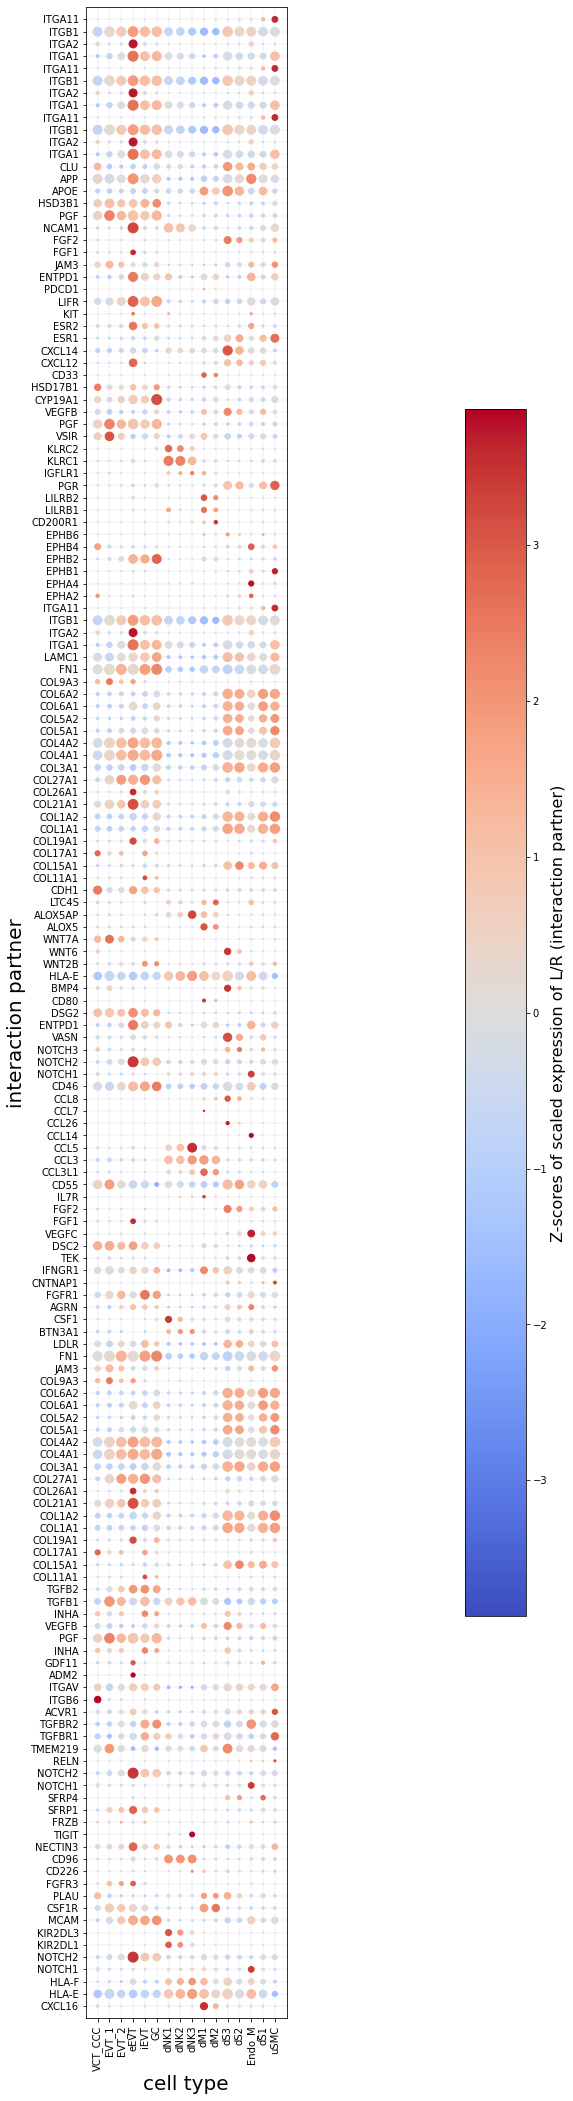

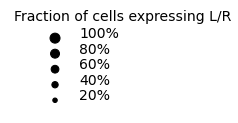

In [1097]:
plot_dotplot_selected('selected_mother_fetus', pdf_save_name='20211213_fetus_mother_top_selected_interactions_zscores')

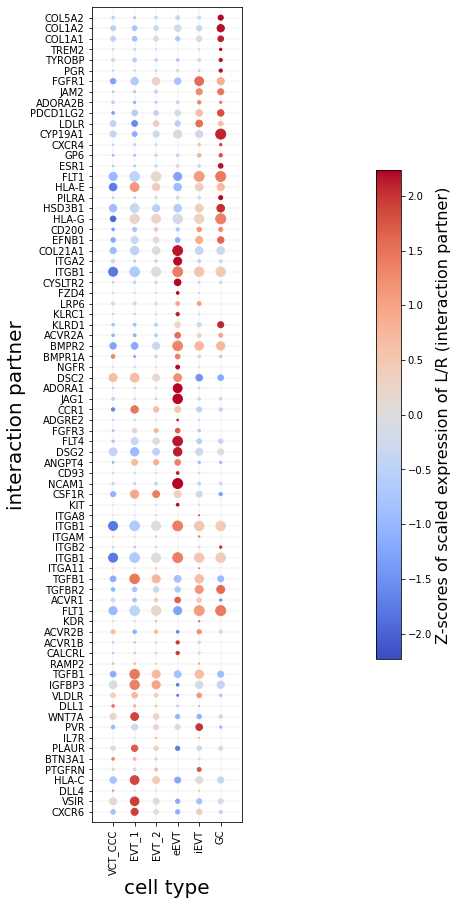

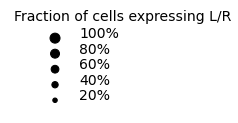

In [1101]:
plot_dotplot_selected('selected_fetus', pdf_save_name='20211213_fetus_top_selected_interactions_zscores')

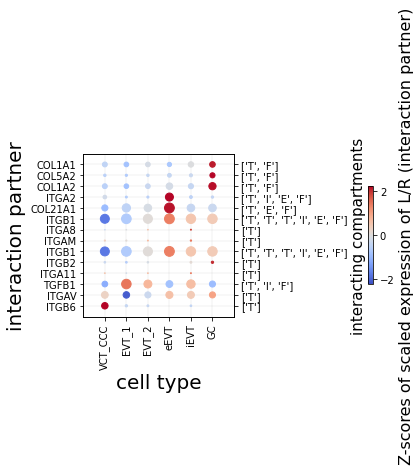

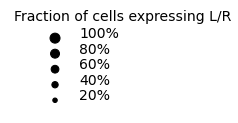

In [823]:
plot_dotplot_complex('complex_fetus', pdf_save_name='20211213_fetus_complex_interactions_zscores_selected_ECM')